In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pycaret
import optuna
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, make_scorer
from math import sqrt
from feature_engine.outliers import Winsorizer

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
print(tf.__version__)

2.16.1


In [3]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [4]:
train.head()

brand        price      Kondisi  TahunKendaraan  Kilometer  Pintu  \
0   Toyota  564800000.0   Mobil Baru          2024.0        5.0    4.0   
1   Toyota  408400000.0   Mobil Baru          2024.0        5.0    5.0   
2   Toyota  290550000.0   Mobil Baru          2024.0        5.0    5.0   
3   Toyota  146000000.0  Mobil Bekas          2017.0       80.0    5.0   
4  Hyundai  298000000.0  Mobil Bekas          2022.0       55.0    5.0   

                     Dirakit  EngineCC  TenagaPuncak(hp)  \
0    Complete Built Up (CBU)    2982.0             134.0   
1  Complete Knock Down (CKD)    1987.0             172.0   
2  Complete Knock Down (CKD)    1496.0             103.0   
3  Complete Knock Down (CKD)    1329.0              95.0   
4  Complete Knock Down (CKD)    1497.0             113.0   

   TenagaPutaranPuncak(Nm)        InjeksiLangsung      Aspirasi  Panjang(mm)  \
0                    300.0       Direct Injection  Turbocharged       5380.0   
1                    205.0       Direct Injection     Aspirated       4755.0   
2                    136.0  Multi-Point Injection     Aspirated       4435.0   
3                    121.0  Multi-Point Injection     Aspirated       4190.0   
4                    144.0  Multi-Point Injection     Aspirated       4315.0   

   Lebar(mm)  JarakRoda(mm)  
0     1880.0         3110.0  
1     1850.0         2850.0  
2     1695.0         2685.0  
3     1660.0         2655.0  
4     1790.0         2610.0

In [5]:
test.head()

brand      Kondisi  TahunKendaraan  Kilometer  Pintu  \
0   Wuling   Mobil Baru          2023.0        5.0    5.0   
1   Suzuki  Mobil Bekas          2022.0       35.0    5.0   
2   Toyota  Mobil Bekas          2013.0      140.0    5.0   
3  Hyundai   Mobil Baru          2024.0        5.0    5.0   
4  Hyundai   Mobil Baru          2024.0        5.0    5.0   

                     Dirakit  EngineCC  TenagaPuncak(hp)  \
0  Complete Knock Down (CKD)    1485.0             105.0   
1  Complete Knock Down (CKD)    1462.0             103.0   
2  Complete Knock Down (CKD)    1998.0             134.0   
3  Complete Knock Down (CKD)    1497.0             113.0   
4    Complete Built Up (CBU)    2151.0             200.0   

   TenagaPutaranPuncak(Nm)        InjeksiLangsung      Aspirasi  Panjang(mm)  \
0                    143.0  Multi-Point Injection     Aspirated       4350.0   
1                    138.0  Multi-Point Injection     Aspirated       4450.0   
2                    182.0  Multi-Point Injection     Aspirated       4585.0   
3                    144.0  Multi-Point Injection     Aspirated       4495.0   
4                    440.0       Direct Injection  Turbocharged       4785.0   

   Lebar(mm)  JarakRoda(mm)  
0     1750.0         2550.0  
1     1775.0         2740.0  
2     1760.0         2750.0  
3     1815.0         2780.0  
4     1900.0         2765.0

In [6]:
encoder = LabelEncoder()

def handle_encoding(df, method, columns):
    for column in columns:
        df[column] = method.fit_transform(df[column])

    return df

In [7]:
features = ['brand', 'Kondisi', 'Dirakit', 'InjeksiLangsung', 'Aspirasi']

handle_encoding(train, encoder, features)
handle_encoding(test, encoder, features)

brand  Kondisi  TahunKendaraan  Kilometer  Pintu  Dirakit  EngineCC  \
0        38        0          2023.0        5.0    5.0        2    1485.0   
1        34        1          2022.0       35.0    5.0        2    1462.0   
2        36        1          2013.0      140.0    5.0        2    1998.0   
3        12        0          2024.0        5.0    5.0        2    1497.0   
4        12        0          2024.0        5.0    5.0        1    2151.0   
...     ...      ...             ...        ...    ...      ...       ...   
2539     38        0          2024.0        5.0    3.0        2    1498.0   
2540     36        1          2013.0        5.0    5.0        2    1495.0   
2541     12        0          2024.0        5.0    5.0        2    1497.0   
2542     23        1          2017.0       45.0    5.0        1    1997.0   
2543     34        0          2024.0        5.0    5.0        2    1462.0   

      TenagaPuncak(hp)  TenagaPutaranPuncak(Nm)  InjeksiLangsung  Aspirasi  \
0                105.0                    143.0                1         0   
1                103.0                    138.0                1         0   
2                134.0                    182.0                1         0   
3                113.0                    144.0                1         0   
4                200.0                    440.0                0         1   
...                ...                      ...              ...       ...   
2539             118.0                    145.0                1         0   
2540             107.0                    141.0                1         0   
2541             113.0                    144.0                1         0   
2542             149.0                    190.0                0         0   
2543             103.0                    138.0                1         0   

      Panjang(mm)  Lebar(mm)  JarakRoda(mm)  
0          4350.0     1750.0         2550.0  
1          4450.0     1775.0         2740.0  
2          4585.0     1760.0         2750.0  
3          4495.0     1815.0         2780.0  
4          4785.0     1900.0         2765.0  
...           ...        ...            ...  
2539       2974.0     1505.0         2010.0  
2540       4420.0     1745.0         2685.0  
2541       4315.0     1790.0         2610.0  
2542       4715.0     1770.0         2850.0  
2543       4450.0     1775.0         2740.0  

[2544 rows x 14 columns]

<Axes: >

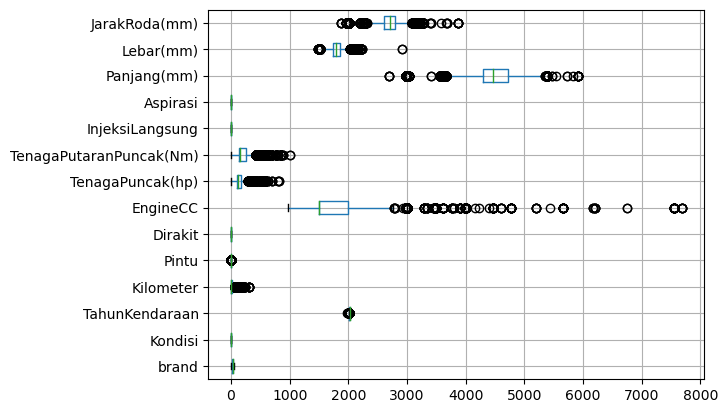

In [8]:
train.drop(columns='price').boxplot(vert=False)

In [9]:
windsorizer = Winsorizer(
    capping_method="iqr",
    tail="both",
    fold=1.5,
    variables=["JarakRoda(mm)", "Lebar(mm)", "Panjang(mm)", "TenagaPutaranPuncak(Nm)", "TenagaPuncak(hp)", "EngineCC", "Kilometer", "price"],
)

In [10]:
def winsorize(df):    
    df = windsorizer.fit_transform
    
winsorize(train)
winsorize(test)

In [11]:
scaler = StandardScaler()

X = train.drop(columns='price')
y = train['price']

In [12]:
def split_and_scale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    y_train = y_train.values.reshape(-1, 1)
    y_train = pd.DataFrame(scaler.fit_transform(y_train), columns=["price"])

    y_test = y_test.values.reshape(-1, 1)
    y_test = pd.DataFrame(scaler.fit_transform(y_test), columns=["price"])
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = split_and_scale(X, y)

In [14]:
X_train

brand   Kondisi  TahunKendaraan  Kilometer     Pintu   Dirakit  \
0     0.239484  1.185687       -0.552007   1.088029  0.390153  0.707403   
1     0.906622  1.185687       -0.805966   1.806618  0.390153  0.707403   
2     0.239484  1.185687       -0.805966   1.806618  0.390153  0.707403   
3    -0.872414 -0.843393        0.717787  -0.492868  0.390153  0.707403   
4    -0.946541  1.185687       -1.313883   2.094054  0.390153  0.707403   
...        ...       ...             ...        ...       ...       ...   
8134  1.203128 -0.843393        0.463828  -0.492868  0.390153  0.707403   
8135  1.054875  1.185687       -0.805966   1.950336  0.390153  0.707403   
8136  1.054875 -0.843393        0.717787  -0.492868  0.390153  0.707403   
8137 -0.946541  1.185687        0.209869   0.225721  0.390153  0.707403   
8138 -1.910185  1.185687       -1.821801   0.225721 -1.126302  0.707403   

      EngineCC  TenagaPuncak(hp)  TenagaPutaranPuncak(Nm)  InjeksiLangsung  \
0    -0.452517         -0.559494                -0.603694         0.696382   
1    -0.640001         -0.735589                -0.695045         0.696382   
2    -0.452517         -0.559494                -0.603694         0.696382   
3    -0.455493         -0.412749                -0.578780         0.696382   
4    -0.006127         -0.060559                -0.371163         0.696382   
...        ...               ...                      ...              ...   
8134 -0.607265          0.130210                 0.301516        -1.435993   
8135 -0.456981         -0.559494                -0.645217         0.696382   
8136 -1.200964         -0.647542                -0.611998         0.696382   
8137 -0.454005         -0.324701                -0.570475         0.696382   
8138  0.288491          1.480271                 1.131984        -1.435993   

      Aspirasi  Panjang(mm)  Lebar(mm)  JarakRoda(mm)  
0    -0.648971     0.074529  -0.391035      -1.879408  
1    -0.648971    -0.418534  -0.896959       0.237284  
2    -0.648971     0.074529  -0.391035      -1.879408  
3    -0.648971    -0.301138  -0.023091      -0.354480  
4    -0.648971    -0.350445  -0.188666      -0.354480  
...        ...          ...        ...            ...  
8134  1.540902     0.605160   0.427641       0.451229  
8135 -0.648971    -0.571149  -1.218910      -0.149639  
8136  1.540902    -0.970296  -0.758980      -0.741402  
8137 -0.648971     0.109748  -0.115077       0.055203  
8138  1.540902     1.070048   0.620812       1.275145  

[8139 rows x 14 columns]

In [15]:
y_test

price
0    -0.223237
1     0.256807
2     0.857926
3    -0.399831
4     1.543976
...        ...
2030 -0.279899
2031 -0.266432
2032 -0.366418
2033 -0.473772
2034  0.026409

[2035 rows x 1 columns]

In [16]:
def make_model(model):
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    result = {
        "r2": r2_score(preds, y_test),
        "mae": mean_absolute_error(preds, y_test),
        "mse": mean_squared_error(preds, y_test),
        "rmse": sqrt(mean_squared_error(preds, y_test))
    }
    
    result = pd.DataFrame(result, index=[0]) 
    
    return result

In [17]:
models = {
    "Random Forest": RandomForestRegressor(),
    "CatBoost": CatBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "Extra Tree": ExtraTreesRegressor(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "AdaBoost": AdaBoostRegressor(),
}

comparison = pd.DataFrame(columns=["model", "r2", "mae", "mse", "rmse"])

for model_name, model in models.items():
    result = make_model(model)
    result["model"] = model_name
    comparison = comparison.append(result, ignore_index=True)

Learning rate set to 0.057023
0:	learn: 0.9683364	total: 132ms	remaining: 2m 12s
1:	learn: 0.9384512	total: 135ms	remaining: 1m 7s
2:	learn: 0.9126392	total: 138ms	remaining: 45.8s
3:	learn: 0.8847752	total: 140ms	remaining: 34.9s
4:	learn: 0.8615742	total: 143ms	remaining: 28.4s
5:	learn: 0.8369547	total: 145ms	remaining: 24s
6:	learn: 0.8148348	total: 146ms	remaining: 20.8s
7:	learn: 0.7943961	total: 148ms	remaining: 18.4s
8:	learn: 0.7741780	total: 150ms	remaining: 16.5s
9:	learn: 0.7571568	total: 152ms	remaining: 15s
10:	learn: 0.7406803	total: 153ms	remaining: 13.8s
11:	learn: 0.7247540	total: 155ms	remaining: 12.8s
12:	learn: 0.7105837	total: 157ms	remaining: 11.9s
13:	learn: 0.6960778	total: 159ms	remaining: 11.2s
14:	learn: 0.6822400	total: 161ms	remaining: 10.5s
15:	learn: 0.6695878	total: 162ms	remaining: 9.98s
16:	learn: 0.6589478	total: 164ms	remaining: 9.49s
17:	learn: 0.6484697	total: 166ms	remaining: 9.04s
18:	learn: 0.6371962	total: 167ms	remaining: 8.64s
19:	learn: 0.6

255:	learn: 0.3927594	total: 593ms	remaining: 1.72s
256:	learn: 0.3927546	total: 595ms	remaining: 1.72s
257:	learn: 0.3926384	total: 596ms	remaining: 1.72s
258:	learn: 0.3926306	total: 598ms	remaining: 1.71s
259:	learn: 0.3924815	total: 600ms	remaining: 1.71s
260:	learn: 0.3922627	total: 602ms	remaining: 1.7s
261:	learn: 0.3921310	total: 604ms	remaining: 1.7s
262:	learn: 0.3920119	total: 605ms	remaining: 1.7s
263:	learn: 0.3919929	total: 607ms	remaining: 1.69s
264:	learn: 0.3914655	total: 609ms	remaining: 1.69s
265:	learn: 0.3913457	total: 611ms	remaining: 1.69s
266:	learn: 0.3912830	total: 613ms	remaining: 1.68s
267:	learn: 0.3906800	total: 614ms	remaining: 1.68s
268:	learn: 0.3906738	total: 616ms	remaining: 1.67s
269:	learn: 0.3906601	total: 617ms	remaining: 1.67s
270:	learn: 0.3906305	total: 619ms	remaining: 1.67s
271:	learn: 0.3905429	total: 621ms	remaining: 1.66s
272:	learn: 0.3904380	total: 622ms	remaining: 1.66s
273:	learn: 0.3904234	total: 624ms	remaining: 1.65s
274:	learn: 0.3

485:	learn: 0.3763584	total: 997ms	remaining: 1.05s
486:	learn: 0.3763408	total: 999ms	remaining: 1.05s
487:	learn: 0.3762977	total: 1s	remaining: 1.05s
488:	learn: 0.3762466	total: 1s	remaining: 1.05s
489:	learn: 0.3762391	total: 1s	remaining: 1.04s
490:	learn: 0.3762162	total: 1.01s	remaining: 1.04s
491:	learn: 0.3762037	total: 1.01s	remaining: 1.04s
492:	learn: 0.3761900	total: 1.01s	remaining: 1.04s
493:	learn: 0.3760954	total: 1.01s	remaining: 1.04s
494:	learn: 0.3760723	total: 1.01s	remaining: 1.03s
495:	learn: 0.3760287	total: 1.02s	remaining: 1.03s
496:	learn: 0.3759557	total: 1.02s	remaining: 1.03s
497:	learn: 0.3759025	total: 1.02s	remaining: 1.03s
498:	learn: 0.3758654	total: 1.02s	remaining: 1.02s
499:	learn: 0.3758405	total: 1.02s	remaining: 1.02s
500:	learn: 0.3758142	total: 1.02s	remaining: 1.02s
501:	learn: 0.3758000	total: 1.03s	remaining: 1.02s
502:	learn: 0.3757678	total: 1.03s	remaining: 1.02s
503:	learn: 0.3757610	total: 1.03s	remaining: 1.01s
504:	learn: 0.3757478

708:	learn: 0.3724168	total: 1.4s	remaining: 574ms
709:	learn: 0.3723973	total: 1.4s	remaining: 572ms
710:	learn: 0.3723900	total: 1.4s	remaining: 570ms
711:	learn: 0.3723837	total: 1.4s	remaining: 568ms
712:	learn: 0.3723791	total: 1.41s	remaining: 566ms
713:	learn: 0.3723696	total: 1.41s	remaining: 564ms
714:	learn: 0.3723642	total: 1.41s	remaining: 562ms
715:	learn: 0.3723563	total: 1.41s	remaining: 560ms
716:	learn: 0.3723473	total: 1.41s	remaining: 558ms
717:	learn: 0.3723434	total: 1.42s	remaining: 556ms
718:	learn: 0.3723339	total: 1.42s	remaining: 554ms
719:	learn: 0.3723289	total: 1.42s	remaining: 552ms
720:	learn: 0.3723246	total: 1.42s	remaining: 550ms
721:	learn: 0.3723174	total: 1.42s	remaining: 548ms
722:	learn: 0.3723142	total: 1.42s	remaining: 546ms
723:	learn: 0.3723075	total: 1.43s	remaining: 544ms
724:	learn: 0.3722994	total: 1.43s	remaining: 542ms
725:	learn: 0.3722961	total: 1.43s	remaining: 540ms
726:	learn: 0.3722852	total: 1.43s	remaining: 537ms
727:	learn: 0.37

926:	learn: 0.3711105	total: 1.79s	remaining: 141ms
927:	learn: 0.3711069	total: 1.79s	remaining: 139ms
928:	learn: 0.3711005	total: 1.79s	remaining: 137ms
929:	learn: 0.3710957	total: 1.79s	remaining: 135ms
930:	learn: 0.3710924	total: 1.79s	remaining: 133ms
931:	learn: 0.3710886	total: 1.8s	remaining: 131ms
932:	learn: 0.3710851	total: 1.8s	remaining: 129ms
933:	learn: 0.3710804	total: 1.8s	remaining: 127ms
934:	learn: 0.3710789	total: 1.8s	remaining: 125ms
935:	learn: 0.3710776	total: 1.8s	remaining: 123ms
936:	learn: 0.3710745	total: 1.81s	remaining: 121ms
937:	learn: 0.3710715	total: 1.81s	remaining: 120ms
938:	learn: 0.3710633	total: 1.81s	remaining: 118ms
939:	learn: 0.3710619	total: 1.81s	remaining: 116ms
940:	learn: 0.3710572	total: 1.81s	remaining: 114ms
941:	learn: 0.3710558	total: 1.82s	remaining: 112ms
942:	learn: 0.3710506	total: 1.82s	remaining: 110ms
943:	learn: 0.3710460	total: 1.82s	remaining: 108ms
944:	learn: 0.3710433	total: 1.82s	remaining: 106ms
945:	learn: 0.371

In [18]:
comparison

model        r2       mae       mse      rmse
0  Random Forest  0.940108  0.089413  0.055669  0.235944
1       CatBoost  0.959272  0.087646  0.040842  0.202094
2        XGBoost  0.872989  0.182714  0.124233  0.352467
3     Extra Tree  0.940768  0.076229  0.061751  0.248497
4          Ridge  0.238805  0.323148  0.376747  0.613797
5          Lasso  0.000000  0.495379  1.000000  1.000000
6       AdaBoost  0.660061  0.324693  0.244281  0.494248

### Feature Selection for Best Model

In [19]:
def rfe(model):
    min_features_to_select = 1  
    model = model()
    cv = KFold(n_splits=5, shuffle=False)
    scorer = make_scorer(r2_score)

    rfecv = RFECV(
        estimator=model,
        step=1,
        scoring=scorer,
        cv=cv,
        min_features_to_select=min_features_to_select,
        n_jobs=1,
    )

    rfecv.fit(X, y)

    return X.columns[rfecv.support_]

In [20]:
features = rfe(CatBoostRegressor)

Learning rate set to 0.057023
0:	learn: 768845492.3418617	total: 2.49ms	remaining: 2.49s
1:	learn: 744762458.8381438	total: 4.52ms	remaining: 2.26s
2:	learn: 723004146.0982032	total: 6.37ms	remaining: 2.12s
3:	learn: 700464520.9008013	total: 8.41ms	remaining: 2.09s
4:	learn: 678588840.4933931	total: 10.3ms	remaining: 2.05s
5:	learn: 659849855.9357665	total: 12.1ms	remaining: 2.01s
6:	learn: 642473810.7967672	total: 14ms	remaining: 1.98s
7:	learn: 625510482.4334735	total: 15.8ms	remaining: 1.96s
8:	learn: 607885069.9881717	total: 17.7ms	remaining: 1.95s
9:	learn: 592951074.1459761	total: 19.6ms	remaining: 1.94s
10:	learn: 578876663.6283166	total: 21.4ms	remaining: 1.93s
11:	learn: 565671471.1520175	total: 23.3ms	remaining: 1.92s
12:	learn: 554433259.8612132	total: 25.2ms	remaining: 1.92s
13:	learn: 544027576.2961173	total: 27.1ms	remaining: 1.91s
14:	learn: 533843488.4725772	total: 28.9ms	remaining: 1.9s
15:	learn: 523144121.2721498	total: 30.8ms	remaining: 1.89s
16:	learn: 513540458.49

205:	learn: 310329641.5634655	total: 391ms	remaining: 1.5s
206:	learn: 310032378.6500773	total: 393ms	remaining: 1.5s
207:	learn: 309900976.8279143	total: 395ms	remaining: 1.5s
208:	learn: 309285662.1414303	total: 397ms	remaining: 1.5s
209:	learn: 309262360.9852362	total: 399ms	remaining: 1.5s
210:	learn: 309148062.8664281	total: 401ms	remaining: 1.5s
211:	learn: 308910472.1191855	total: 403ms	remaining: 1.5s
212:	learn: 308660900.1700326	total: 405ms	remaining: 1.49s
213:	learn: 308606489.5240758	total: 407ms	remaining: 1.49s
214:	learn: 308523323.8362353	total: 408ms	remaining: 1.49s
215:	learn: 308355379.9766021	total: 410ms	remaining: 1.49s
216:	learn: 308186896.7796690	total: 412ms	remaining: 1.49s
217:	learn: 308151717.3206732	total: 414ms	remaining: 1.48s
218:	learn: 308103385.5142153	total: 416ms	remaining: 1.48s
219:	learn: 308024113.4717301	total: 417ms	remaining: 1.48s
220:	learn: 307930220.1738837	total: 419ms	remaining: 1.48s
221:	learn: 307767221.7036245	total: 422ms	rema

417:	learn: 294420335.9064563	total: 780ms	remaining: 1.09s
418:	learn: 294412082.2653446	total: 782ms	remaining: 1.08s
419:	learn: 294366382.0403690	total: 784ms	remaining: 1.08s
420:	learn: 294317639.3417681	total: 786ms	remaining: 1.08s
421:	learn: 294291548.1467294	total: 788ms	remaining: 1.08s
422:	learn: 294286511.9885111	total: 790ms	remaining: 1.08s
423:	learn: 294258542.1570036	total: 792ms	remaining: 1.07s
424:	learn: 294254163.9459119	total: 793ms	remaining: 1.07s
425:	learn: 294250294.2672177	total: 795ms	remaining: 1.07s
426:	learn: 294231996.4378628	total: 797ms	remaining: 1.07s
427:	learn: 294227694.8006509	total: 799ms	remaining: 1.07s
428:	learn: 294198677.8764420	total: 801ms	remaining: 1.06s
429:	learn: 294178391.1114148	total: 802ms	remaining: 1.06s
430:	learn: 294162335.4790322	total: 805ms	remaining: 1.06s
431:	learn: 294135453.8584904	total: 807ms	remaining: 1.06s
432:	learn: 294111989.9375784	total: 808ms	remaining: 1.06s
433:	learn: 294065503.0270342	total: 810

632:	learn: 291399055.9888156	total: 1.17s	remaining: 676ms
633:	learn: 291393340.4356663	total: 1.17s	remaining: 675ms
634:	learn: 291363050.8087367	total: 1.17s	remaining: 673ms
635:	learn: 291362612.7516369	total: 1.17s	remaining: 671ms
636:	learn: 291334016.5884522	total: 1.18s	remaining: 670ms
637:	learn: 291322921.5879462	total: 1.18s	remaining: 668ms
638:	learn: 291318228.2022196	total: 1.18s	remaining: 666ms
639:	learn: 291300236.2559367	total: 1.18s	remaining: 664ms
640:	learn: 291293056.0061263	total: 1.18s	remaining: 662ms
641:	learn: 291289854.7070858	total: 1.18s	remaining: 661ms
642:	learn: 291273198.2217814	total: 1.19s	remaining: 659ms
643:	learn: 291269208.8377424	total: 1.19s	remaining: 657ms
644:	learn: 291265435.1368413	total: 1.19s	remaining: 655ms
645:	learn: 291262482.5126463	total: 1.19s	remaining: 653ms
646:	learn: 291256701.4998392	total: 1.19s	remaining: 651ms
647:	learn: 291239022.8089681	total: 1.2s	remaining: 649ms
648:	learn: 291225217.4444887	total: 1.2s

858:	learn: 290027698.2252459	total: 1.57s	remaining: 258ms
859:	learn: 290026654.1028119	total: 1.57s	remaining: 257ms
860:	learn: 290024596.3812176	total: 1.58s	remaining: 255ms
861:	learn: 290012820.5953165	total: 1.58s	remaining: 253ms
862:	learn: 290011706.7266816	total: 1.58s	remaining: 251ms
863:	learn: 290006954.3464639	total: 1.58s	remaining: 249ms
864:	learn: 290001324.3042372	total: 1.58s	remaining: 247ms
865:	learn: 289995752.0530961	total: 1.59s	remaining: 246ms
866:	learn: 289993071.6021272	total: 1.59s	remaining: 244ms
867:	learn: 289985981.2164277	total: 1.59s	remaining: 242ms
868:	learn: 289980628.8846309	total: 1.59s	remaining: 240ms
869:	learn: 289975708.8742177	total: 1.59s	remaining: 238ms
870:	learn: 289973436.6269943	total: 1.59s	remaining: 236ms
871:	learn: 289972412.4228489	total: 1.6s	remaining: 234ms
872:	learn: 289971262.3101766	total: 1.6s	remaining: 233ms
873:	learn: 289966820.5810712	total: 1.6s	remaining: 231ms
874:	learn: 289966021.3018578	total: 1.6s	r

51:	learn: 370963801.1840057	total: 95.2ms	remaining: 1.74s
52:	learn: 369264984.2705533	total: 97.3ms	remaining: 1.74s
53:	learn: 367989858.4347296	total: 99.3ms	remaining: 1.74s
54:	learn: 366441297.1703475	total: 101ms	remaining: 1.74s
55:	learn: 365212724.9139627	total: 103ms	remaining: 1.74s
56:	learn: 364094031.0211650	total: 105ms	remaining: 1.74s
57:	learn: 362921654.8956029	total: 111ms	remaining: 1.81s
58:	learn: 361725656.7618433	total: 113ms	remaining: 1.81s
59:	learn: 360295835.6962551	total: 115ms	remaining: 1.81s
60:	learn: 359616799.3433457	total: 117ms	remaining: 1.81s
61:	learn: 358346575.8915070	total: 119ms	remaining: 1.8s
62:	learn: 357137939.9831976	total: 121ms	remaining: 1.8s
63:	learn: 355819829.5950379	total: 123ms	remaining: 1.79s
64:	learn: 354893915.3224258	total: 124ms	remaining: 1.79s
65:	learn: 354303118.9812939	total: 126ms	remaining: 1.79s
66:	learn: 353559620.8388132	total: 128ms	remaining: 1.79s
67:	learn: 352438311.9160137	total: 130ms	remaining: 1.

266:	learn: 302107309.5527920	total: 484ms	remaining: 1.33s
267:	learn: 302074691.5674363	total: 486ms	remaining: 1.33s
268:	learn: 302014602.2553266	total: 488ms	remaining: 1.33s
269:	learn: 301935316.3345233	total: 490ms	remaining: 1.32s
270:	learn: 301879085.7003286	total: 492ms	remaining: 1.32s
271:	learn: 301774047.1044313	total: 493ms	remaining: 1.32s
272:	learn: 301768029.1632450	total: 495ms	remaining: 1.32s
273:	learn: 301717385.5619113	total: 497ms	remaining: 1.32s
274:	learn: 301649777.3252251	total: 499ms	remaining: 1.31s
275:	learn: 301617679.7783542	total: 501ms	remaining: 1.31s
276:	learn: 301580253.4919876	total: 503ms	remaining: 1.31s
277:	learn: 301553843.3246783	total: 504ms	remaining: 1.31s
278:	learn: 301487380.5492378	total: 506ms	remaining: 1.31s
279:	learn: 301171882.0222961	total: 508ms	remaining: 1.31s
280:	learn: 301144002.4342837	total: 510ms	remaining: 1.3s
281:	learn: 301081598.1412539	total: 511ms	remaining: 1.3s
282:	learn: 300750728.7766369	total: 513ms

492:	learn: 293026665.4069585	total: 885ms	remaining: 911ms
493:	learn: 293015869.4701203	total: 887ms	remaining: 909ms
494:	learn: 293005563.4793561	total: 889ms	remaining: 907ms
495:	learn: 292986527.1299628	total: 891ms	remaining: 905ms
496:	learn: 292985090.9923230	total: 893ms	remaining: 904ms
497:	learn: 292963273.6298287	total: 895ms	remaining: 902ms
498:	learn: 292950802.8627068	total: 897ms	remaining: 901ms
499:	learn: 292929323.6752195	total: 899ms	remaining: 899ms
500:	learn: 292912242.7380893	total: 901ms	remaining: 898ms
501:	learn: 292899317.5765306	total: 904ms	remaining: 896ms
502:	learn: 292885502.3307580	total: 905ms	remaining: 895ms
503:	learn: 292837454.5053869	total: 907ms	remaining: 893ms
504:	learn: 292834284.2175018	total: 909ms	remaining: 891ms
505:	learn: 292825513.9946197	total: 911ms	remaining: 889ms
506:	learn: 292766197.5328366	total: 913ms	remaining: 887ms
507:	learn: 292765414.3661767	total: 914ms	remaining: 886ms
508:	learn: 292751159.7417808	total: 916

708:	learn: 290585882.1668280	total: 1.27s	remaining: 523ms
709:	learn: 290577133.8832813	total: 1.28s	remaining: 522ms
710:	learn: 290565674.1267794	total: 1.28s	remaining: 520ms
711:	learn: 290561090.9804245	total: 1.28s	remaining: 518ms
712:	learn: 290555672.4999506	total: 1.28s	remaining: 516ms
713:	learn: 290548562.7269704	total: 1.28s	remaining: 515ms
714:	learn: 290538141.5501596	total: 1.29s	remaining: 513ms
715:	learn: 290533510.3121150	total: 1.29s	remaining: 511ms
716:	learn: 290517186.4366171	total: 1.29s	remaining: 509ms
717:	learn: 290509607.1549304	total: 1.29s	remaining: 508ms
718:	learn: 290503264.3848608	total: 1.29s	remaining: 506ms
719:	learn: 290498313.6963992	total: 1.3s	remaining: 504ms
720:	learn: 290494861.6817967	total: 1.3s	remaining: 502ms
721:	learn: 290491891.3332762	total: 1.3s	remaining: 500ms
722:	learn: 290489734.1953251	total: 1.3s	remaining: 499ms
723:	learn: 290480028.8495578	total: 1.3s	remaining: 497ms
724:	learn: 290462585.0413809	total: 1.3s	rem

936:	learn: 289638033.9623320	total: 1.68s	remaining: 113ms
937:	learn: 289636851.6961101	total: 1.68s	remaining: 111ms
938:	learn: 289635303.0515254	total: 1.68s	remaining: 109ms
939:	learn: 289634519.8364912	total: 1.68s	remaining: 107ms
940:	learn: 289629039.9746100	total: 1.68s	remaining: 106ms
941:	learn: 289628349.7729021	total: 1.68s	remaining: 104ms
942:	learn: 289621580.9502912	total: 1.69s	remaining: 102ms
943:	learn: 289619465.8591338	total: 1.69s	remaining: 100ms
944:	learn: 289617135.1727393	total: 1.69s	remaining: 98.4ms
945:	learn: 289613491.8019721	total: 1.69s	remaining: 96.6ms
946:	learn: 289612386.6379311	total: 1.69s	remaining: 94.8ms
947:	learn: 289611105.4880282	total: 1.7s	remaining: 93ms
948:	learn: 289608729.4385616	total: 1.7s	remaining: 91.3ms
949:	learn: 289607859.1830086	total: 1.7s	remaining: 89.5ms
950:	learn: 289604156.7203348	total: 1.7s	remaining: 87.7ms
951:	learn: 289597816.4103457	total: 1.7s	remaining: 85.9ms
952:	learn: 289596981.8520707	total: 1.

137:	learn: 323811494.7422951	total: 242ms	remaining: 1.51s
138:	learn: 323614991.3398875	total: 244ms	remaining: 1.51s
139:	learn: 323546440.6358256	total: 245ms	remaining: 1.51s
140:	learn: 323259549.0502508	total: 247ms	remaining: 1.51s
141:	learn: 323050569.8638905	total: 250ms	remaining: 1.51s
142:	learn: 322731958.9444448	total: 252ms	remaining: 1.51s
143:	learn: 322685619.4417289	total: 254ms	remaining: 1.51s
144:	learn: 322386181.4672648	total: 257ms	remaining: 1.51s
145:	learn: 322196763.5457935	total: 259ms	remaining: 1.51s
146:	learn: 322040678.7178019	total: 261ms	remaining: 1.51s
147:	learn: 321939489.5284436	total: 263ms	remaining: 1.51s
148:	learn: 321824696.2617489	total: 265ms	remaining: 1.51s
149:	learn: 321493921.1340978	total: 266ms	remaining: 1.51s
150:	learn: 320670732.8902363	total: 268ms	remaining: 1.51s
151:	learn: 320406255.7381191	total: 270ms	remaining: 1.51s
152:	learn: 320330840.5972690	total: 272ms	remaining: 1.51s
153:	learn: 320247535.0249068	total: 274

362:	learn: 295335208.9025992	total: 641ms	remaining: 1.13s
363:	learn: 295304048.2868974	total: 643ms	remaining: 1.12s
364:	learn: 295282841.5480853	total: 645ms	remaining: 1.12s
365:	learn: 295256447.7868518	total: 647ms	remaining: 1.12s
366:	learn: 295178141.8790928	total: 649ms	remaining: 1.12s
367:	learn: 295166437.2747851	total: 651ms	remaining: 1.12s
368:	learn: 295083403.2801817	total: 652ms	remaining: 1.11s
369:	learn: 295043108.7707171	total: 655ms	remaining: 1.11s
370:	learn: 295021363.0137553	total: 656ms	remaining: 1.11s
371:	learn: 294983907.5748981	total: 658ms	remaining: 1.11s
372:	learn: 294953355.9135622	total: 660ms	remaining: 1.11s
373:	learn: 294924421.9152458	total: 662ms	remaining: 1.11s
374:	learn: 294905454.9012337	total: 664ms	remaining: 1.1s
375:	learn: 294857340.9652130	total: 665ms	remaining: 1.1s
376:	learn: 294801241.1846004	total: 667ms	remaining: 1.1s
377:	learn: 294780934.9708332	total: 669ms	remaining: 1.1s
378:	learn: 294750196.3657675	total: 671ms	r

584:	learn: 291585768.8964701	total: 1.03s	remaining: 732ms
585:	learn: 291573565.0748269	total: 1.03s	remaining: 730ms
586:	learn: 291563193.0160176	total: 1.03s	remaining: 728ms
587:	learn: 291545837.2116828	total: 1.04s	remaining: 726ms
588:	learn: 291538608.8596618	total: 1.04s	remaining: 725ms
589:	learn: 291516910.6045493	total: 1.04s	remaining: 723ms
590:	learn: 291511765.3272636	total: 1.04s	remaining: 721ms
591:	learn: 291506002.1055220	total: 1.04s	remaining: 720ms
592:	learn: 291503268.9634014	total: 1.05s	remaining: 718ms
593:	learn: 291499554.0516381	total: 1.05s	remaining: 716ms
594:	learn: 291492987.2318367	total: 1.05s	remaining: 715ms
595:	learn: 291484990.6295202	total: 1.05s	remaining: 713ms
596:	learn: 291478204.4349239	total: 1.05s	remaining: 711ms
597:	learn: 291461475.9548095	total: 1.05s	remaining: 709ms
598:	learn: 291456463.7077021	total: 1.06s	remaining: 707ms
599:	learn: 291446526.6265967	total: 1.06s	remaining: 706ms
600:	learn: 291438468.1982332	total: 1.0

808:	learn: 290165477.9739320	total: 1.43s	remaining: 337ms
809:	learn: 290162548.7508497	total: 1.43s	remaining: 336ms
810:	learn: 290158457.0773731	total: 1.43s	remaining: 334ms
811:	learn: 290138729.4783045	total: 1.43s	remaining: 332ms
812:	learn: 290134270.1300562	total: 1.44s	remaining: 330ms
813:	learn: 290131077.7076325	total: 1.44s	remaining: 329ms
814:	learn: 290127524.6047736	total: 1.44s	remaining: 327ms
815:	learn: 290123376.7896452	total: 1.44s	remaining: 325ms
816:	learn: 290117493.0452015	total: 1.44s	remaining: 323ms
817:	learn: 290107156.4394397	total: 1.45s	remaining: 322ms
818:	learn: 290105039.8613521	total: 1.45s	remaining: 320ms
819:	learn: 290101560.6476774	total: 1.45s	remaining: 318ms
820:	learn: 290097143.6396206	total: 1.45s	remaining: 316ms
821:	learn: 290093322.6755743	total: 1.45s	remaining: 315ms
822:	learn: 290090134.1545849	total: 1.45s	remaining: 313ms
823:	learn: 290087563.7546974	total: 1.46s	remaining: 311ms
824:	learn: 290085681.1812138	total: 1.4

Learning rate set to 0.057023
0:	learn: 768938597.4417814	total: 2.21ms	remaining: 2.21s
1:	learn: 744741446.2668868	total: 4.56ms	remaining: 2.27s
2:	learn: 722179502.2000424	total: 6.46ms	remaining: 2.15s
3:	learn: 699766962.6218152	total: 8.31ms	remaining: 2.07s
4:	learn: 678600361.7634718	total: 10.2ms	remaining: 2.02s
5:	learn: 659743198.0380756	total: 12ms	remaining: 1.99s
6:	learn: 642366521.6308126	total: 13.7ms	remaining: 1.95s
7:	learn: 625833117.2589487	total: 15.6ms	remaining: 1.94s
8:	learn: 610143402.7747861	total: 17.4ms	remaining: 1.91s
9:	learn: 596311000.2993104	total: 19.5ms	remaining: 1.93s
10:	learn: 581938779.9398897	total: 21.7ms	remaining: 1.95s
11:	learn: 568675346.1909966	total: 23.4ms	remaining: 1.92s
12:	learn: 554929762.7831794	total: 25.3ms	remaining: 1.92s
13:	learn: 543811104.4464620	total: 27ms	remaining: 1.9s
14:	learn: 533055984.9756468	total: 29ms	remaining: 1.9s
15:	learn: 522524662.4163356	total: 30.7ms	remaining: 1.89s
16:	learn: 512881013.3780361

209:	learn: 309157421.8949395	total: 392ms	remaining: 1.47s
210:	learn: 309004695.4570984	total: 394ms	remaining: 1.47s
211:	learn: 308934222.6348783	total: 396ms	remaining: 1.47s
212:	learn: 308765027.1275067	total: 397ms	remaining: 1.47s
213:	learn: 308715887.1695845	total: 399ms	remaining: 1.47s
214:	learn: 308101303.4160009	total: 401ms	remaining: 1.46s
215:	learn: 308024411.8047865	total: 409ms	remaining: 1.49s
216:	learn: 307987144.7970517	total: 413ms	remaining: 1.49s
217:	learn: 307837555.8466752	total: 415ms	remaining: 1.49s
218:	learn: 307778265.3174841	total: 416ms	remaining: 1.49s
219:	learn: 307662548.8950654	total: 419ms	remaining: 1.48s
220:	learn: 307580718.8033525	total: 421ms	remaining: 1.48s
221:	learn: 307534073.6732109	total: 422ms	remaining: 1.48s
222:	learn: 307392125.0573076	total: 424ms	remaining: 1.48s
223:	learn: 307292975.2717423	total: 426ms	remaining: 1.48s
224:	learn: 307251688.8866093	total: 428ms	remaining: 1.47s
225:	learn: 307180512.3640553	total: 430

429:	learn: 294308749.3464826	total: 791ms	remaining: 1.05s
430:	learn: 294291803.3591327	total: 793ms	remaining: 1.05s
431:	learn: 294274064.9599431	total: 795ms	remaining: 1.04s
432:	learn: 294255314.0717620	total: 797ms	remaining: 1.04s
433:	learn: 294231652.9459518	total: 799ms	remaining: 1.04s
434:	learn: 294198929.1103550	total: 801ms	remaining: 1.04s
435:	learn: 294191107.8972753	total: 803ms	remaining: 1.04s
436:	learn: 294184481.8514376	total: 805ms	remaining: 1.04s
437:	learn: 294155155.8265175	total: 807ms	remaining: 1.03s
438:	learn: 294147787.0943426	total: 808ms	remaining: 1.03s
439:	learn: 294138680.7458670	total: 810ms	remaining: 1.03s
440:	learn: 294104198.3811539	total: 812ms	remaining: 1.03s
441:	learn: 294072071.2511521	total: 814ms	remaining: 1.03s
442:	learn: 294044948.6789061	total: 816ms	remaining: 1.02s
443:	learn: 294029788.7160836	total: 817ms	remaining: 1.02s
444:	learn: 294009910.2943677	total: 819ms	remaining: 1.02s
445:	learn: 293982382.9155757	total: 821

652:	learn: 291313963.1503267	total: 1.19s	remaining: 633ms
653:	learn: 291293625.6325506	total: 1.19s	remaining: 631ms
654:	learn: 291289509.7270509	total: 1.19s	remaining: 629ms
655:	learn: 291283323.7912338	total: 1.2s	remaining: 628ms
656:	learn: 291255725.7044796	total: 1.2s	remaining: 626ms
657:	learn: 291236562.4309190	total: 1.2s	remaining: 624ms
658:	learn: 291231315.2448908	total: 1.2s	remaining: 622ms
659:	learn: 291226724.8191998	total: 1.2s	remaining: 620ms
660:	learn: 291217509.3096371	total: 1.21s	remaining: 619ms
661:	learn: 291215594.6096560	total: 1.21s	remaining: 617ms
662:	learn: 291212127.9478388	total: 1.21s	remaining: 615ms
663:	learn: 291206528.3962365	total: 1.21s	remaining: 613ms
664:	learn: 291195555.6509534	total: 1.21s	remaining: 611ms
665:	learn: 291189659.8648482	total: 1.22s	remaining: 609ms
666:	learn: 291179253.2910717	total: 1.22s	remaining: 608ms
667:	learn: 291154004.0681286	total: 1.22s	remaining: 606ms
668:	learn: 291128661.3955765	total: 1.22s	re

876:	learn: 289929393.8736060	total: 1.59s	remaining: 223ms
877:	learn: 289925135.8144227	total: 1.59s	remaining: 221ms
878:	learn: 289923469.2103437	total: 1.59s	remaining: 219ms
879:	learn: 289913628.3905202	total: 1.6s	remaining: 218ms
880:	learn: 289911641.5071542	total: 1.6s	remaining: 216ms
881:	learn: 289909425.7669638	total: 1.6s	remaining: 214ms
882:	learn: 289907756.0113557	total: 1.6s	remaining: 212ms
883:	learn: 289904043.9472539	total: 1.6s	remaining: 210ms
884:	learn: 289901787.9555070	total: 1.6s	remaining: 209ms
885:	learn: 289898252.9629546	total: 1.61s	remaining: 207ms
886:	learn: 289895120.6724128	total: 1.61s	remaining: 205ms
887:	learn: 289880270.0164739	total: 1.61s	remaining: 203ms
888:	learn: 289875896.4351048	total: 1.61s	remaining: 201ms
889:	learn: 289872907.3495581	total: 1.61s	remaining: 200ms
890:	learn: 289868758.4967353	total: 1.62s	remaining: 198ms
891:	learn: 289861357.7224296	total: 1.62s	remaining: 196ms
892:	learn: 289860440.1598738	total: 1.62s	rem

81:	learn: 346861248.2559019	total: 141ms	remaining: 1.58s
82:	learn: 346399516.0814194	total: 143ms	remaining: 1.58s
83:	learn: 346103051.4193321	total: 145ms	remaining: 1.58s
84:	learn: 345590364.6188359	total: 147ms	remaining: 1.58s
85:	learn: 345253427.8722822	total: 149ms	remaining: 1.58s
86:	learn: 345066747.3892604	total: 151ms	remaining: 1.58s
87:	learn: 344541411.5956467	total: 153ms	remaining: 1.58s
88:	learn: 343997877.1506570	total: 154ms	remaining: 1.58s
89:	learn: 343592664.5825428	total: 156ms	remaining: 1.58s
90:	learn: 343201139.1359557	total: 158ms	remaining: 1.58s
91:	learn: 342401582.5157599	total: 160ms	remaining: 1.58s
92:	learn: 342094825.0857926	total: 162ms	remaining: 1.58s
93:	learn: 341562099.9418117	total: 163ms	remaining: 1.57s
94:	learn: 341270102.6064740	total: 165ms	remaining: 1.57s
95:	learn: 340894442.7366444	total: 167ms	remaining: 1.57s
96:	learn: 340255144.9211434	total: 169ms	remaining: 1.57s
97:	learn: 340071710.4865710	total: 170ms	remaining: 1.5

300:	learn: 301562324.4971738	total: 523ms	remaining: 1.21s
301:	learn: 301454783.3277335	total: 525ms	remaining: 1.21s
302:	learn: 301413117.3842234	total: 527ms	remaining: 1.21s
303:	learn: 301316317.9000203	total: 529ms	remaining: 1.21s
304:	learn: 301312290.8653594	total: 530ms	remaining: 1.21s
305:	learn: 301239964.5842025	total: 532ms	remaining: 1.21s
306:	learn: 301185292.6039095	total: 534ms	remaining: 1.21s
307:	learn: 300910974.1401759	total: 536ms	remaining: 1.2s
308:	learn: 300812519.9942024	total: 538ms	remaining: 1.2s
309:	learn: 300789048.6278251	total: 540ms	remaining: 1.2s
310:	learn: 300741359.6877514	total: 541ms	remaining: 1.2s
311:	learn: 300661992.9434723	total: 543ms	remaining: 1.2s
312:	learn: 300624829.6234334	total: 545ms	remaining: 1.2s
313:	learn: 300570974.0594425	total: 546ms	remaining: 1.19s
314:	learn: 300536375.5278413	total: 548ms	remaining: 1.19s
315:	learn: 300481010.4891098	total: 550ms	remaining: 1.19s
316:	learn: 300449241.9858106	total: 551ms	rem

519:	learn: 293201691.3562775	total: 906ms	remaining: 837ms
520:	learn: 293147063.4895053	total: 908ms	remaining: 835ms
521:	learn: 293136224.8837298	total: 910ms	remaining: 834ms
522:	learn: 293132178.3099827	total: 912ms	remaining: 832ms
523:	learn: 293126575.0010624	total: 914ms	remaining: 830ms
524:	learn: 293114898.5860029	total: 916ms	remaining: 829ms
525:	learn: 293105594.0573034	total: 918ms	remaining: 827ms
526:	learn: 293077248.2305076	total: 920ms	remaining: 825ms
527:	learn: 293069820.4624779	total: 921ms	remaining: 824ms
528:	learn: 293066888.9122725	total: 923ms	remaining: 822ms
529:	learn: 293057277.7405093	total: 925ms	remaining: 820ms
530:	learn: 292995900.6517732	total: 927ms	remaining: 819ms
531:	learn: 292983704.8170606	total: 929ms	remaining: 817ms
532:	learn: 292978034.6629510	total: 931ms	remaining: 816ms
533:	learn: 292965778.6032637	total: 933ms	remaining: 814ms
534:	learn: 292960638.0299411	total: 934ms	remaining: 812ms
535:	learn: 292911754.5526804	total: 936

740:	learn: 290914767.3878747	total: 1.29s	remaining: 452ms
741:	learn: 290912042.1095379	total: 1.3s	remaining: 451ms
742:	learn: 290903508.0571952	total: 1.3s	remaining: 449ms
743:	learn: 290894082.2136545	total: 1.3s	remaining: 447ms
744:	learn: 290891887.5547125	total: 1.3s	remaining: 446ms
745:	learn: 290887183.4976379	total: 1.3s	remaining: 444ms
746:	learn: 290881807.8554974	total: 1.3s	remaining: 442ms
747:	learn: 290879190.8015307	total: 1.31s	remaining: 441ms
748:	learn: 290860783.3731285	total: 1.31s	remaining: 439ms
749:	learn: 290844378.1069499	total: 1.31s	remaining: 437ms
750:	learn: 290844094.5464653	total: 1.31s	remaining: 435ms
751:	learn: 290835966.2174317	total: 1.31s	remaining: 434ms
752:	learn: 290829656.8667102	total: 1.32s	remaining: 432ms
753:	learn: 290819646.2068136	total: 1.32s	remaining: 430ms
754:	learn: 290813991.0698541	total: 1.32s	remaining: 428ms
755:	learn: 290811326.4722009	total: 1.32s	remaining: 427ms
756:	learn: 290805416.8441892	total: 1.32s	rem

955:	learn: 289899715.8522896	total: 1.68s	remaining: 77.2ms
956:	learn: 289895173.7321320	total: 1.68s	remaining: 75.5ms
957:	learn: 289893490.6343201	total: 1.68s	remaining: 73.7ms
958:	learn: 289889603.0411126	total: 1.68s	remaining: 72ms
959:	learn: 289887792.0915634	total: 1.68s	remaining: 70.2ms
960:	learn: 289881167.7487043	total: 1.69s	remaining: 68.4ms
961:	learn: 289878614.1881020	total: 1.69s	remaining: 66.7ms
962:	learn: 289875613.1541360	total: 1.69s	remaining: 64.9ms
963:	learn: 289873732.2421300	total: 1.69s	remaining: 63.2ms
964:	learn: 289873187.3908601	total: 1.69s	remaining: 61.4ms
965:	learn: 289871305.4108245	total: 1.7s	remaining: 59.7ms
966:	learn: 289864254.1646379	total: 1.7s	remaining: 57.9ms
967:	learn: 289862055.0055234	total: 1.7s	remaining: 56.2ms
968:	learn: 289858878.2990503	total: 1.7s	remaining: 54.4ms
969:	learn: 289858779.0066116	total: 1.7s	remaining: 52.7ms
970:	learn: 289857557.9488888	total: 1.7s	remaining: 50.9ms
971:	learn: 289855167.0421711	to

154:	learn: 322938304.1971815	total: 274ms	remaining: 1.5s
155:	learn: 322868542.8966258	total: 276ms	remaining: 1.49s
156:	learn: 322494539.5981371	total: 278ms	remaining: 1.49s
157:	learn: 322259160.0667253	total: 280ms	remaining: 1.49s
158:	learn: 322064254.2491462	total: 282ms	remaining: 1.49s
159:	learn: 321791528.1249624	total: 283ms	remaining: 1.49s
160:	learn: 321696778.5156305	total: 285ms	remaining: 1.49s
161:	learn: 321460511.9205545	total: 287ms	remaining: 1.48s
162:	learn: 321373299.8088236	total: 289ms	remaining: 1.48s
163:	learn: 321151859.9353391	total: 291ms	remaining: 1.48s
164:	learn: 321070475.6960084	total: 292ms	remaining: 1.48s
165:	learn: 320869344.2427856	total: 294ms	remaining: 1.48s
166:	learn: 320776333.4168589	total: 296ms	remaining: 1.47s
167:	learn: 320706639.9878157	total: 297ms	remaining: 1.47s
168:	learn: 320425193.9402208	total: 299ms	remaining: 1.47s
169:	learn: 320265878.4488405	total: 301ms	remaining: 1.47s
170:	learn: 320144445.3985276	total: 303m

372:	learn: 297209150.3288497	total: 661ms	remaining: 1.11s
373:	learn: 297181606.7649710	total: 663ms	remaining: 1.11s
374:	learn: 297152961.0576731	total: 665ms	remaining: 1.11s
375:	learn: 297136615.4469049	total: 667ms	remaining: 1.11s
376:	learn: 297116527.9127688	total: 669ms	remaining: 1.1s
377:	learn: 297098232.4358516	total: 671ms	remaining: 1.1s
378:	learn: 297051865.4945564	total: 673ms	remaining: 1.1s
379:	learn: 297049917.2843757	total: 675ms	remaining: 1.1s
380:	learn: 297015369.5245275	total: 677ms	remaining: 1.1s
381:	learn: 296980825.1793131	total: 680ms	remaining: 1.1s
382:	learn: 296951718.0764548	total: 682ms	remaining: 1.1s
383:	learn: 296920539.3246843	total: 683ms	remaining: 1.1s
384:	learn: 296900899.1621044	total: 685ms	remaining: 1.09s
385:	learn: 296882712.4053256	total: 687ms	remaining: 1.09s
386:	learn: 296854842.7269447	total: 689ms	remaining: 1.09s
387:	learn: 296815833.6937261	total: 691ms	remaining: 1.09s
388:	learn: 296716747.6356071	total: 693ms	remai

583:	learn: 292715614.4563643	total: 1.05s	remaining: 749ms
584:	learn: 292710804.1784918	total: 1.05s	remaining: 748ms
585:	learn: 292698187.5328087	total: 1.05s	remaining: 746ms
586:	learn: 292695313.3509175	total: 1.06s	remaining: 744ms
587:	learn: 292664223.4451041	total: 1.06s	remaining: 742ms
588:	learn: 292659821.9841611	total: 1.06s	remaining: 741ms
589:	learn: 292647176.3078616	total: 1.07s	remaining: 743ms
590:	learn: 292643815.7223619	total: 1.07s	remaining: 742ms
591:	learn: 292632956.9340986	total: 1.07s	remaining: 740ms
592:	learn: 292629501.6111775	total: 1.07s	remaining: 738ms
593:	learn: 292621080.7751590	total: 1.08s	remaining: 737ms
594:	learn: 292592928.7714235	total: 1.08s	remaining: 735ms
595:	learn: 292582214.7096620	total: 1.08s	remaining: 733ms
596:	learn: 292571260.3906391	total: 1.08s	remaining: 732ms
597:	learn: 292559681.2954521	total: 1.08s	remaining: 730ms
598:	learn: 292555017.9551468	total: 1.09s	remaining: 728ms
599:	learn: 292545711.1980729	total: 1.0

782:	learn: 290972604.1879179	total: 1.43s	remaining: 396ms
783:	learn: 290966418.0865349	total: 1.43s	remaining: 394ms
784:	learn: 290964886.5178732	total: 1.43s	remaining: 393ms
785:	learn: 290960835.9843243	total: 1.44s	remaining: 391ms
786:	learn: 290946593.5567917	total: 1.44s	remaining: 389ms
787:	learn: 290942380.6545909	total: 1.44s	remaining: 387ms
788:	learn: 290938660.1568601	total: 1.44s	remaining: 385ms
789:	learn: 290935511.2558941	total: 1.44s	remaining: 384ms
790:	learn: 290932649.4243049	total: 1.44s	remaining: 382ms
791:	learn: 290929914.5692418	total: 1.45s	remaining: 380ms
792:	learn: 290928114.8626335	total: 1.45s	remaining: 378ms
793:	learn: 290922507.2503892	total: 1.45s	remaining: 376ms
794:	learn: 290919679.5255563	total: 1.45s	remaining: 375ms
795:	learn: 290916774.0340156	total: 1.45s	remaining: 373ms
796:	learn: 290914122.7405005	total: 1.46s	remaining: 371ms
797:	learn: 290905859.9886791	total: 1.46s	remaining: 369ms
798:	learn: 290903930.7918411	total: 1.4

990:	learn: 289981012.0029513	total: 1.81s	remaining: 16.5ms
991:	learn: 289976876.7248222	total: 1.82s	remaining: 14.7ms
992:	learn: 289973521.0835793	total: 1.82s	remaining: 12.8ms
993:	learn: 289969965.6460231	total: 1.82s	remaining: 11ms
994:	learn: 289968963.8481076	total: 1.82s	remaining: 9.16ms
995:	learn: 289968071.9640848	total: 1.82s	remaining: 7.33ms
996:	learn: 289967207.9781452	total: 1.83s	remaining: 5.5ms
997:	learn: 289965581.1064594	total: 1.83s	remaining: 3.67ms
998:	learn: 289964234.0453798	total: 1.83s	remaining: 1.83ms
999:	learn: 289961874.5899522	total: 1.83s	remaining: 0us
Learning rate set to 0.057023
0:	learn: 769611424.0613921	total: 2.09ms	remaining: 2.08s
1:	learn: 744366758.0759773	total: 3.9ms	remaining: 1.94s
2:	learn: 722290539.1200570	total: 5.77ms	remaining: 1.92s
3:	learn: 700519090.8672005	total: 7.57ms	remaining: 1.88s
4:	learn: 677879501.6310737	total: 9.45ms	remaining: 1.88s
5:	learn: 659884172.1941532	total: 11.2ms	remaining: 1.85s
6:	learn: 641

187:	learn: 316108262.9498730	total: 327ms	remaining: 1.41s
188:	learn: 315994064.4233840	total: 329ms	remaining: 1.41s
189:	learn: 315690782.3165917	total: 331ms	remaining: 1.41s
190:	learn: 315523072.8890092	total: 333ms	remaining: 1.41s
191:	learn: 315344611.2785613	total: 335ms	remaining: 1.41s
192:	learn: 315251592.9527226	total: 337ms	remaining: 1.41s
193:	learn: 315152898.5304902	total: 338ms	remaining: 1.41s
194:	learn: 314988448.4921718	total: 340ms	remaining: 1.4s
195:	learn: 314782376.8538319	total: 342ms	remaining: 1.4s
196:	learn: 314713076.8320623	total: 344ms	remaining: 1.4s
197:	learn: 314642079.2083209	total: 345ms	remaining: 1.4s
198:	learn: 314563990.4630557	total: 347ms	remaining: 1.4s
199:	learn: 314531963.7296199	total: 349ms	remaining: 1.4s
200:	learn: 313851863.3445931	total: 351ms	remaining: 1.39s
201:	learn: 313631322.3265575	total: 352ms	remaining: 1.39s
202:	learn: 313566503.4383336	total: 354ms	remaining: 1.39s
203:	learn: 313438002.9429319	total: 355ms	rem

427:	learn: 295741574.3504541	total: 739ms	remaining: 988ms
428:	learn: 295729201.3953061	total: 741ms	remaining: 986ms
429:	learn: 295682718.2391320	total: 743ms	remaining: 985ms
430:	learn: 295677997.6839371	total: 745ms	remaining: 983ms
431:	learn: 295638803.8581281	total: 747ms	remaining: 982ms
432:	learn: 295626141.8608326	total: 748ms	remaining: 980ms
433:	learn: 295615710.0872809	total: 750ms	remaining: 978ms
434:	learn: 295589842.2693787	total: 752ms	remaining: 977ms
435:	learn: 295580314.1530055	total: 754ms	remaining: 976ms
436:	learn: 295577275.8985462	total: 756ms	remaining: 974ms
437:	learn: 295513052.5671520	total: 758ms	remaining: 972ms
438:	learn: 295501956.4807283	total: 760ms	remaining: 971ms
439:	learn: 295449459.5964239	total: 761ms	remaining: 969ms
440:	learn: 295422718.7236531	total: 763ms	remaining: 967ms
441:	learn: 295417567.2211500	total: 765ms	remaining: 966ms
442:	learn: 295413475.6872714	total: 767ms	remaining: 964ms
443:	learn: 295380556.2237424	total: 769

656:	learn: 292133580.4094188	total: 1.14s	remaining: 594ms
657:	learn: 292130500.7540638	total: 1.14s	remaining: 592ms
658:	learn: 292127026.5382777	total: 1.14s	remaining: 590ms
659:	learn: 292105583.3113191	total: 1.14s	remaining: 589ms
660:	learn: 292095598.9027762	total: 1.14s	remaining: 587ms
661:	learn: 292067522.0867676	total: 1.15s	remaining: 585ms
662:	learn: 292048026.0754169	total: 1.15s	remaining: 584ms
663:	learn: 292035299.6113899	total: 1.15s	remaining: 582ms
664:	learn: 292021467.3232762	total: 1.15s	remaining: 580ms
665:	learn: 292019908.6246807	total: 1.15s	remaining: 579ms
666:	learn: 291990413.2529618	total: 1.16s	remaining: 577ms
667:	learn: 291986339.2736232	total: 1.16s	remaining: 575ms
668:	learn: 291971445.9766841	total: 1.16s	remaining: 574ms
669:	learn: 291942133.8965088	total: 1.16s	remaining: 572ms
670:	learn: 291939761.9470116	total: 1.16s	remaining: 570ms
671:	learn: 291935520.5869792	total: 1.16s	remaining: 568ms
672:	learn: 291923229.3716373	total: 1.1

881:	learn: 290484041.4814858	total: 1.53s	remaining: 204ms
882:	learn: 290481562.6067952	total: 1.53s	remaining: 202ms
883:	learn: 290479677.9941922	total: 1.53s	remaining: 201ms
884:	learn: 290476381.0814559	total: 1.53s	remaining: 199ms
885:	learn: 290474117.0899962	total: 1.53s	remaining: 197ms
886:	learn: 290471400.1816272	total: 1.53s	remaining: 196ms
887:	learn: 290466863.2460575	total: 1.54s	remaining: 195ms
888:	learn: 290453639.0492258	total: 1.54s	remaining: 193ms
889:	learn: 290452046.7011030	total: 1.55s	remaining: 191ms
890:	learn: 290445434.6965625	total: 1.55s	remaining: 189ms
891:	learn: 290444406.2124968	total: 1.55s	remaining: 188ms
892:	learn: 290442702.5026882	total: 1.55s	remaining: 186ms
893:	learn: 290439045.6280349	total: 1.55s	remaining: 184ms
894:	learn: 290435720.2099177	total: 1.56s	remaining: 183ms
895:	learn: 290433892.2487765	total: 1.56s	remaining: 181ms
896:	learn: 290426076.3577442	total: 1.56s	remaining: 179ms
897:	learn: 290423474.2565778	total: 1.5

74:	learn: 354873558.6878286	total: 136ms	remaining: 1.67s
75:	learn: 354067941.6340709	total: 138ms	remaining: 1.68s
76:	learn: 353319176.9272662	total: 140ms	remaining: 1.67s
77:	learn: 352597028.7378566	total: 141ms	remaining: 1.67s
78:	learn: 351902438.9928114	total: 143ms	remaining: 1.67s
79:	learn: 351503612.4375082	total: 145ms	remaining: 1.67s
80:	learn: 351116199.2008253	total: 147ms	remaining: 1.67s
81:	learn: 350625535.1012849	total: 149ms	remaining: 1.66s
82:	learn: 350401996.6548526	total: 150ms	remaining: 1.66s
83:	learn: 349081653.7989192	total: 152ms	remaining: 1.66s
84:	learn: 348412293.7769300	total: 154ms	remaining: 1.66s
85:	learn: 347776415.2221683	total: 155ms	remaining: 1.65s
86:	learn: 347032834.2734729	total: 157ms	remaining: 1.65s
87:	learn: 346414441.1988404	total: 159ms	remaining: 1.65s
88:	learn: 345880561.1604708	total: 161ms	remaining: 1.64s
89:	learn: 345238057.9951528	total: 162ms	remaining: 1.64s
90:	learn: 344773649.7242631	total: 164ms	remaining: 1.6

301:	learn: 302890983.2079105	total: 524ms	remaining: 1.21s
302:	learn: 302887287.0909348	total: 526ms	remaining: 1.21s
303:	learn: 302846893.7518010	total: 528ms	remaining: 1.21s
304:	learn: 302843315.2989568	total: 529ms	remaining: 1.21s
305:	learn: 302820831.3197522	total: 531ms	remaining: 1.2s
306:	learn: 302737703.5954694	total: 533ms	remaining: 1.2s
307:	learn: 302632113.8445835	total: 535ms	remaining: 1.2s
308:	learn: 302535707.1763227	total: 536ms	remaining: 1.2s
309:	learn: 302504057.8885928	total: 538ms	remaining: 1.2s
310:	learn: 302462171.3373107	total: 540ms	remaining: 1.2s
311:	learn: 302447830.7690586	total: 542ms	remaining: 1.2s
312:	learn: 302409053.7734814	total: 544ms	remaining: 1.19s
313:	learn: 302395936.2518532	total: 545ms	remaining: 1.19s
314:	learn: 302348957.4750526	total: 547ms	remaining: 1.19s
315:	learn: 302295010.9043417	total: 549ms	remaining: 1.19s
316:	learn: 302234161.5831924	total: 551ms	remaining: 1.19s
317:	learn: 302223010.9067824	total: 552ms	rema

533:	learn: 295118883.2384058	total: 925ms	remaining: 807ms
534:	learn: 295105525.8490083	total: 927ms	remaining: 806ms
535:	learn: 295092607.2682614	total: 929ms	remaining: 804ms
536:	learn: 295080600.8191642	total: 931ms	remaining: 802ms
537:	learn: 295065983.6905946	total: 933ms	remaining: 801ms
538:	learn: 295053458.7542128	total: 934ms	remaining: 799ms
539:	learn: 295004937.5910820	total: 936ms	remaining: 798ms
540:	learn: 294992795.9558692	total: 938ms	remaining: 796ms
541:	learn: 294986227.1040398	total: 940ms	remaining: 794ms
542:	learn: 294965332.7220204	total: 942ms	remaining: 793ms
543:	learn: 294955228.5332161	total: 944ms	remaining: 791ms
544:	learn: 294954508.9830325	total: 945ms	remaining: 789ms
545:	learn: 294936263.5802711	total: 947ms	remaining: 787ms
546:	learn: 294920448.2365294	total: 949ms	remaining: 786ms
547:	learn: 294900194.6131732	total: 950ms	remaining: 784ms
548:	learn: 294877229.6251524	total: 952ms	remaining: 782ms
549:	learn: 294847132.3990679	total: 954

766:	learn: 292857571.4201017	total: 1.33s	remaining: 403ms
767:	learn: 292843587.8348435	total: 1.33s	remaining: 401ms
768:	learn: 292836287.9373822	total: 1.33s	remaining: 399ms
769:	learn: 292829373.5653737	total: 1.33s	remaining: 398ms
770:	learn: 292826705.1638481	total: 1.33s	remaining: 396ms
771:	learn: 292821771.3303512	total: 1.33s	remaining: 394ms
772:	learn: 292817184.3329945	total: 1.34s	remaining: 393ms
773:	learn: 292814205.3914000	total: 1.34s	remaining: 391ms
774:	learn: 292811406.1944161	total: 1.34s	remaining: 389ms
775:	learn: 292807523.8090179	total: 1.34s	remaining: 388ms
776:	learn: 292804537.1845766	total: 1.34s	remaining: 386ms
777:	learn: 292797415.0061811	total: 1.35s	remaining: 384ms
778:	learn: 292791767.1490850	total: 1.35s	remaining: 383ms
779:	learn: 292790527.3672919	total: 1.35s	remaining: 381ms
780:	learn: 292768641.8272837	total: 1.35s	remaining: 379ms
781:	learn: 292766789.8506795	total: 1.35s	remaining: 377ms
782:	learn: 292761010.8445339	total: 1.3

985:	learn: 291824731.6951639	total: 1.71s	remaining: 24.3ms
986:	learn: 291822008.5457405	total: 1.71s	remaining: 22.5ms
987:	learn: 291821436.1851982	total: 1.71s	remaining: 20.8ms
988:	learn: 291820849.0029249	total: 1.71s	remaining: 19.1ms
989:	learn: 291818611.1576246	total: 1.72s	remaining: 17.3ms
990:	learn: 291814690.2516024	total: 1.72s	remaining: 15.6ms
991:	learn: 291810873.5176675	total: 1.72s	remaining: 13.9ms
992:	learn: 291810266.7880254	total: 1.72s	remaining: 12.1ms
993:	learn: 291806077.9972798	total: 1.72s	remaining: 10.4ms
994:	learn: 291805095.2568200	total: 1.73s	remaining: 8.67ms
995:	learn: 291802137.1222187	total: 1.73s	remaining: 6.94ms
996:	learn: 291792415.9554360	total: 1.73s	remaining: 5.2ms
997:	learn: 291790421.4967988	total: 1.73s	remaining: 3.47ms
998:	learn: 291788460.7108691	total: 1.73s	remaining: 1.73ms
999:	learn: 291779103.9719172	total: 1.73s	remaining: 0us
Learning rate set to 0.057023
0:	learn: 770891724.8679425	total: 2.25ms	remaining: 2.25s


186:	learn: 317267225.3726696	total: 333ms	remaining: 1.45s
187:	learn: 317207941.9263962	total: 335ms	remaining: 1.45s
188:	learn: 317069748.7129126	total: 337ms	remaining: 1.45s
189:	learn: 316958583.8535986	total: 339ms	remaining: 1.44s
190:	learn: 316895765.1511430	total: 341ms	remaining: 1.44s
191:	learn: 316712532.4271740	total: 342ms	remaining: 1.44s
192:	learn: 316452032.5444325	total: 344ms	remaining: 1.44s
193:	learn: 316344286.9384353	total: 346ms	remaining: 1.44s
194:	learn: 316303381.7715074	total: 348ms	remaining: 1.44s
195:	learn: 316233811.7191637	total: 350ms	remaining: 1.43s
196:	learn: 315881265.2678124	total: 351ms	remaining: 1.43s
197:	learn: 315780473.3636311	total: 353ms	remaining: 1.43s
198:	learn: 315714008.3269727	total: 355ms	remaining: 1.43s
199:	learn: 315592778.3425971	total: 356ms	remaining: 1.43s
200:	learn: 315472987.9824947	total: 358ms	remaining: 1.42s
201:	learn: 315282464.5000118	total: 360ms	remaining: 1.42s
202:	learn: 315216075.4157997	total: 362

416:	learn: 299100846.7794005	total: 733ms	remaining: 1.02s
417:	learn: 299091136.8957087	total: 735ms	remaining: 1.02s
418:	learn: 299064211.9130371	total: 737ms	remaining: 1.02s
419:	learn: 299053867.4073169	total: 739ms	remaining: 1.02s
420:	learn: 299046497.0845551	total: 741ms	remaining: 1.02s
421:	learn: 298992767.3756053	total: 742ms	remaining: 1.02s
422:	learn: 298951378.6060556	total: 744ms	remaining: 1.01s
423:	learn: 298925583.6356711	total: 747ms	remaining: 1.01s
424:	learn: 298856346.9927810	total: 753ms	remaining: 1.02s
425:	learn: 298830177.7514046	total: 755ms	remaining: 1.02s
426:	learn: 298825422.4547491	total: 756ms	remaining: 1.01s
427:	learn: 298764609.3765563	total: 758ms	remaining: 1.01s
428:	learn: 298726746.6284295	total: 759ms	remaining: 1.01s
429:	learn: 298717160.5831166	total: 761ms	remaining: 1.01s
430:	learn: 298662007.3448722	total: 763ms	remaining: 1.01s
431:	learn: 298626380.6226073	total: 765ms	remaining: 1s
432:	learn: 298585907.1056263	total: 767ms	

623:	learn: 295149878.0173854	total: 1.12s	remaining: 673ms
624:	learn: 295138374.7777884	total: 1.12s	remaining: 672ms
625:	learn: 295122871.7281418	total: 1.12s	remaining: 670ms
626:	learn: 295104427.1730748	total: 1.12s	remaining: 668ms
627:	learn: 295089906.6841213	total: 1.13s	remaining: 666ms
628:	learn: 295086954.5409425	total: 1.13s	remaining: 665ms
629:	learn: 295081976.0596855	total: 1.13s	remaining: 663ms
630:	learn: 295061260.3790830	total: 1.13s	remaining: 661ms
631:	learn: 295057670.1310889	total: 1.13s	remaining: 659ms
632:	learn: 295056037.4583056	total: 1.13s	remaining: 658ms
633:	learn: 295036284.4368387	total: 1.14s	remaining: 656ms
634:	learn: 295022975.8981918	total: 1.14s	remaining: 654ms
635:	learn: 295012242.0240318	total: 1.14s	remaining: 652ms
636:	learn: 295004065.8639534	total: 1.14s	remaining: 651ms
637:	learn: 294980017.6051260	total: 1.14s	remaining: 649ms
638:	learn: 294969005.1653358	total: 1.15s	remaining: 647ms
639:	learn: 294962177.3668879	total: 1.1

845:	learn: 293159231.9994963	total: 1.51s	remaining: 274ms
846:	learn: 293152882.7432382	total: 1.51s	remaining: 273ms
847:	learn: 293146349.3419436	total: 1.51s	remaining: 271ms
848:	learn: 293140328.8749260	total: 1.51s	remaining: 269ms
849:	learn: 293135992.0139741	total: 1.51s	remaining: 267ms
850:	learn: 293123824.2463284	total: 1.52s	remaining: 266ms
851:	learn: 293118275.3877897	total: 1.52s	remaining: 264ms
852:	learn: 293106592.8769253	total: 1.52s	remaining: 262ms
853:	learn: 293104139.3422260	total: 1.52s	remaining: 260ms
854:	learn: 293100835.1308961	total: 1.52s	remaining: 259ms
855:	learn: 293094357.4204389	total: 1.53s	remaining: 257ms
856:	learn: 293092245.8156387	total: 1.53s	remaining: 255ms
857:	learn: 293085883.7910600	total: 1.53s	remaining: 253ms
858:	learn: 293084032.6684843	total: 1.53s	remaining: 251ms
859:	learn: 293077814.9123420	total: 1.53s	remaining: 250ms
860:	learn: 293066673.4064889	total: 1.53s	remaining: 248ms
861:	learn: 293052181.0413448	total: 1.5

53:	learn: 372584127.5047355	total: 95.1ms	remaining: 1.67s
54:	learn: 371482936.2817140	total: 97.1ms	remaining: 1.67s
55:	learn: 370553928.0165631	total: 99.1ms	remaining: 1.67s
56:	learn: 369474635.0892667	total: 101ms	remaining: 1.67s
57:	learn: 368224534.0762374	total: 103ms	remaining: 1.67s
58:	learn: 366939241.0475218	total: 104ms	remaining: 1.67s
59:	learn: 365773527.1480539	total: 106ms	remaining: 1.67s
60:	learn: 364528776.5049355	total: 108ms	remaining: 1.67s
61:	learn: 363901829.6347620	total: 110ms	remaining: 1.66s
62:	learn: 363083921.2441626	total: 112ms	remaining: 1.66s
63:	learn: 362147718.7335956	total: 113ms	remaining: 1.66s
64:	learn: 361203627.5295417	total: 115ms	remaining: 1.66s
65:	learn: 360298848.3700128	total: 117ms	remaining: 1.65s
66:	learn: 359372963.1187329	total: 119ms	remaining: 1.65s
67:	learn: 358567624.3109088	total: 120ms	remaining: 1.65s
68:	learn: 357574166.1082012	total: 122ms	remaining: 1.65s
69:	learn: 356834034.3696807	total: 124ms	remaining: 

281:	learn: 307736972.7894213	total: 493ms	remaining: 1.25s
282:	learn: 307713204.9937246	total: 494ms	remaining: 1.25s
283:	learn: 307655820.0492843	total: 496ms	remaining: 1.25s
284:	learn: 307626969.9003955	total: 498ms	remaining: 1.25s
285:	learn: 307571415.5061207	total: 500ms	remaining: 1.25s
286:	learn: 307351565.0190433	total: 501ms	remaining: 1.25s
287:	learn: 307301284.1293585	total: 503ms	remaining: 1.24s
288:	learn: 307201740.9380801	total: 505ms	remaining: 1.24s
289:	learn: 307176726.6629031	total: 507ms	remaining: 1.24s
290:	learn: 307152191.4790561	total: 509ms	remaining: 1.24s
291:	learn: 307078381.2313850	total: 511ms	remaining: 1.24s
292:	learn: 307056001.2388946	total: 512ms	remaining: 1.24s
293:	learn: 307009805.2334040	total: 514ms	remaining: 1.23s
294:	learn: 306944076.4119768	total: 516ms	remaining: 1.23s
295:	learn: 306910944.6237627	total: 517ms	remaining: 1.23s
296:	learn: 306887295.2163199	total: 519ms	remaining: 1.23s
297:	learn: 306853377.4545732	total: 521

502:	learn: 297975801.5391772	total: 881ms	remaining: 871ms
503:	learn: 297945738.1764811	total: 883ms	remaining: 869ms
504:	learn: 297888148.1271971	total: 885ms	remaining: 868ms
505:	learn: 297865395.5680216	total: 887ms	remaining: 866ms
506:	learn: 297824171.2118891	total: 889ms	remaining: 865ms
507:	learn: 297807481.4440506	total: 891ms	remaining: 863ms
508:	learn: 297781828.4456154	total: 893ms	remaining: 861ms
509:	learn: 297758461.8454412	total: 895ms	remaining: 859ms
510:	learn: 297748392.2659749	total: 897ms	remaining: 858ms
511:	learn: 297728762.6480100	total: 898ms	remaining: 856ms
512:	learn: 297722281.9025598	total: 900ms	remaining: 855ms
513:	learn: 297701451.3488067	total: 902ms	remaining: 853ms
514:	learn: 297669410.4684865	total: 904ms	remaining: 851ms
515:	learn: 297638585.4019108	total: 905ms	remaining: 849ms
516:	learn: 297633748.9239447	total: 907ms	remaining: 847ms
517:	learn: 297585513.9808218	total: 909ms	remaining: 846ms
518:	learn: 297575927.1991487	total: 910

725:	learn: 294441911.2043393	total: 1.27s	remaining: 479ms
726:	learn: 294428542.6321632	total: 1.27s	remaining: 477ms
727:	learn: 294426254.7252342	total: 1.27s	remaining: 475ms
728:	learn: 294418838.4316724	total: 1.27s	remaining: 474ms
729:	learn: 294392884.7869070	total: 1.27s	remaining: 472ms
730:	learn: 294382370.2953266	total: 1.28s	remaining: 470ms
731:	learn: 294375305.4339049	total: 1.28s	remaining: 468ms
732:	learn: 294353526.9638943	total: 1.28s	remaining: 467ms
733:	learn: 294338966.8229256	total: 1.28s	remaining: 465ms
734:	learn: 294322878.8303485	total: 1.28s	remaining: 463ms
735:	learn: 294310160.2226009	total: 1.29s	remaining: 462ms
736:	learn: 294303755.5305581	total: 1.29s	remaining: 460ms
737:	learn: 294297560.1703111	total: 1.29s	remaining: 458ms
738:	learn: 294276439.9893723	total: 1.29s	remaining: 456ms
739:	learn: 294271238.5558274	total: 1.29s	remaining: 455ms
740:	learn: 294258582.6856313	total: 1.29s	remaining: 453ms
741:	learn: 294256002.4607791	total: 1.3

948:	learn: 292875415.1011775	total: 1.66s	remaining: 89ms
949:	learn: 292874778.8455405	total: 1.66s	remaining: 87.3ms
950:	learn: 292869292.9158742	total: 1.66s	remaining: 85.6ms
951:	learn: 292863794.8978836	total: 1.67s	remaining: 84.2ms
952:	learn: 292854756.0387396	total: 1.67s	remaining: 82.4ms
953:	learn: 292854504.7801760	total: 1.67s	remaining: 80.7ms
954:	learn: 292854263.2078564	total: 1.68s	remaining: 79ms
955:	learn: 292847597.3929334	total: 1.68s	remaining: 77.2ms
956:	learn: 292840966.1802539	total: 1.68s	remaining: 75.5ms
957:	learn: 292833263.1474701	total: 1.68s	remaining: 73.7ms
958:	learn: 292826862.6479872	total: 1.68s	remaining: 72ms
959:	learn: 292826646.4097294	total: 1.68s	remaining: 70.2ms
960:	learn: 292818902.3161929	total: 1.69s	remaining: 68.4ms
961:	learn: 292815946.6416568	total: 1.69s	remaining: 66.7ms
962:	learn: 292815739.0625665	total: 1.69s	remaining: 65ms
963:	learn: 292811651.0959600	total: 1.69s	remaining: 63.2ms
964:	learn: 292808589.4839407	to

152:	learn: 348360376.8254364	total: 262ms	remaining: 1.45s
153:	learn: 348107841.6028696	total: 264ms	remaining: 1.45s
154:	learn: 347833916.9568792	total: 266ms	remaining: 1.45s
155:	learn: 347766127.5018380	total: 268ms	remaining: 1.45s
156:	learn: 347558066.0197641	total: 269ms	remaining: 1.45s
157:	learn: 347496669.2117790	total: 271ms	remaining: 1.44s
158:	learn: 347372641.2577033	total: 273ms	remaining: 1.44s
159:	learn: 347175598.2305595	total: 275ms	remaining: 1.44s
160:	learn: 347093772.8285421	total: 276ms	remaining: 1.44s
161:	learn: 346852879.6198789	total: 278ms	remaining: 1.44s
162:	learn: 346635848.9402509	total: 280ms	remaining: 1.44s
163:	learn: 346396154.1058182	total: 282ms	remaining: 1.44s
164:	learn: 346323080.0794744	total: 283ms	remaining: 1.43s
165:	learn: 346258332.6567114	total: 284ms	remaining: 1.43s
166:	learn: 346147273.8698422	total: 286ms	remaining: 1.43s
167:	learn: 346071419.4463792	total: 288ms	remaining: 1.43s
168:	learn: 345882056.1379507	total: 289

390:	learn: 320625586.4284738	total: 664ms	remaining: 1.03s
391:	learn: 320587645.6502623	total: 666ms	remaining: 1.03s
392:	learn: 320480368.8139421	total: 668ms	remaining: 1.03s
393:	learn: 320449515.1527963	total: 670ms	remaining: 1.03s
394:	learn: 320434508.6492263	total: 672ms	remaining: 1.03s
395:	learn: 320365524.2972853	total: 673ms	remaining: 1.03s
396:	learn: 320309969.1740685	total: 675ms	remaining: 1.02s
397:	learn: 320262409.6676731	total: 677ms	remaining: 1.02s
398:	learn: 320250104.6070894	total: 679ms	remaining: 1.02s
399:	learn: 320232250.7489753	total: 681ms	remaining: 1.02s
400:	learn: 320187162.6835797	total: 682ms	remaining: 1.02s
401:	learn: 320158268.2970619	total: 684ms	remaining: 1.02s
402:	learn: 320072531.7645152	total: 686ms	remaining: 1.01s
403:	learn: 320022454.9888999	total: 687ms	remaining: 1.01s
404:	learn: 319991772.7366750	total: 689ms	remaining: 1.01s
405:	learn: 319932841.7850748	total: 691ms	remaining: 1.01s
406:	learn: 319892900.6171477	total: 692

617:	learn: 313343408.3617365	total: 1.05s	remaining: 650ms
618:	learn: 313281692.8087841	total: 1.05s	remaining: 649ms
619:	learn: 313275941.3372446	total: 1.05s	remaining: 647ms
620:	learn: 313237232.8089232	total: 1.06s	remaining: 645ms
621:	learn: 313206248.8666634	total: 1.06s	remaining: 644ms
622:	learn: 313203503.9947273	total: 1.06s	remaining: 642ms
623:	learn: 313198760.7516623	total: 1.06s	remaining: 640ms
624:	learn: 313170752.7962131	total: 1.06s	remaining: 639ms
625:	learn: 313137424.9592189	total: 1.07s	remaining: 637ms
626:	learn: 313124126.2392657	total: 1.07s	remaining: 635ms
627:	learn: 313117924.0386544	total: 1.07s	remaining: 634ms
628:	learn: 313105139.9659628	total: 1.07s	remaining: 632ms
629:	learn: 313090806.5362249	total: 1.07s	remaining: 630ms
630:	learn: 313058743.6280581	total: 1.07s	remaining: 629ms
631:	learn: 313043647.5684364	total: 1.08s	remaining: 627ms
632:	learn: 313016841.4155241	total: 1.08s	remaining: 625ms
633:	learn: 312970448.8864352	total: 1.0

849:	learn: 309684304.7151091	total: 1.45s	remaining: 256ms
850:	learn: 309681798.8992793	total: 1.45s	remaining: 254ms
851:	learn: 309667016.6997366	total: 1.45s	remaining: 252ms
852:	learn: 309664662.9086563	total: 1.45s	remaining: 251ms
853:	learn: 309662442.3903133	total: 1.46s	remaining: 249ms
854:	learn: 309659220.7494705	total: 1.46s	remaining: 247ms
855:	learn: 309655443.9871730	total: 1.46s	remaining: 246ms
856:	learn: 309623568.2726598	total: 1.46s	remaining: 244ms
857:	learn: 309620330.3651760	total: 1.46s	remaining: 242ms
858:	learn: 309618237.7494255	total: 1.46s	remaining: 240ms
859:	learn: 309595664.4584447	total: 1.47s	remaining: 239ms
860:	learn: 309592560.4473464	total: 1.47s	remaining: 237ms
861:	learn: 309590502.5537131	total: 1.47s	remaining: 235ms
862:	learn: 309588530.4036230	total: 1.47s	remaining: 234ms
863:	learn: 309583338.9102840	total: 1.47s	remaining: 232ms
864:	learn: 309578999.1558388	total: 1.47s	remaining: 230ms
865:	learn: 309569347.1621525	total: 1.4

47:	learn: 415354551.6842647	total: 84.1ms	remaining: 1.67s
48:	learn: 413474257.3075554	total: 86.2ms	remaining: 1.67s
49:	learn: 412470344.8043008	total: 88ms	remaining: 1.67s
50:	learn: 411142382.3679798	total: 90ms	remaining: 1.67s
51:	learn: 410053367.0499055	total: 91.7ms	remaining: 1.67s
52:	learn: 408712890.9314054	total: 93.5ms	remaining: 1.67s
53:	learn: 407797028.1164156	total: 95.2ms	remaining: 1.67s
54:	learn: 406829400.1768936	total: 97.6ms	remaining: 1.68s
55:	learn: 405419882.2253767	total: 99.4ms	remaining: 1.68s
56:	learn: 404327678.5947886	total: 101ms	remaining: 1.67s
57:	learn: 402966902.6561726	total: 103ms	remaining: 1.67s
58:	learn: 402266381.7604095	total: 104ms	remaining: 1.67s
59:	learn: 401246749.6379861	total: 106ms	remaining: 1.67s
60:	learn: 400331754.7499230	total: 108ms	remaining: 1.66s
61:	learn: 399650795.2509727	total: 110ms	remaining: 1.66s
62:	learn: 398792856.8386419	total: 111ms	remaining: 1.66s
63:	learn: 398128900.6946827	total: 113ms	remaining

259:	learn: 342601783.1893063	total: 470ms	remaining: 1.34s
260:	learn: 342465459.8653204	total: 472ms	remaining: 1.34s
261:	learn: 342394054.7494791	total: 474ms	remaining: 1.33s
262:	learn: 342277297.6720231	total: 476ms	remaining: 1.33s
263:	learn: 342175248.0244260	total: 478ms	remaining: 1.33s
264:	learn: 341983675.6450736	total: 480ms	remaining: 1.33s
265:	learn: 341815125.6009864	total: 482ms	remaining: 1.33s
266:	learn: 341704463.8376682	total: 484ms	remaining: 1.33s
267:	learn: 341653231.1233523	total: 486ms	remaining: 1.33s
268:	learn: 341600573.5818409	total: 488ms	remaining: 1.32s
269:	learn: 341594191.2289879	total: 489ms	remaining: 1.32s
270:	learn: 341449675.3285499	total: 491ms	remaining: 1.32s
271:	learn: 341445003.3918439	total: 492ms	remaining: 1.32s
272:	learn: 341381020.2446399	total: 494ms	remaining: 1.32s
273:	learn: 341180035.8236362	total: 496ms	remaining: 1.31s
274:	learn: 340964555.2331680	total: 498ms	remaining: 1.31s
275:	learn: 340754686.0382020	total: 500

470:	learn: 322366554.4994882	total: 869ms	remaining: 976ms
471:	learn: 322325044.1002027	total: 870ms	remaining: 974ms
472:	learn: 322088414.0977837	total: 872ms	remaining: 972ms
473:	learn: 322071209.3326078	total: 874ms	remaining: 970ms
474:	learn: 322038827.6565190	total: 876ms	remaining: 968ms
475:	learn: 321956614.4711838	total: 878ms	remaining: 966ms
476:	learn: 321865283.7993330	total: 880ms	remaining: 965ms
477:	learn: 321842532.7446166	total: 882ms	remaining: 963ms
478:	learn: 321807982.4107578	total: 884ms	remaining: 961ms
479:	learn: 321726102.1573820	total: 886ms	remaining: 960ms
480:	learn: 321623938.1107593	total: 888ms	remaining: 958ms
481:	learn: 321549131.5617643	total: 890ms	remaining: 957ms
482:	learn: 321390687.2658191	total: 892ms	remaining: 955ms
483:	learn: 321372173.5174077	total: 894ms	remaining: 953ms
484:	learn: 321358296.2856116	total: 896ms	remaining: 951ms
485:	learn: 321322388.2494353	total: 897ms	remaining: 949ms
486:	learn: 321265576.6430263	total: 899

676:	learn: 314744366.9618644	total: 1.25s	remaining: 599ms
677:	learn: 314721907.3836081	total: 1.26s	remaining: 597ms
678:	learn: 314690147.1554587	total: 1.26s	remaining: 595ms
679:	learn: 314668116.6393340	total: 1.26s	remaining: 593ms
680:	learn: 314662993.3243303	total: 1.26s	remaining: 591ms
681:	learn: 314637620.0204678	total: 1.26s	remaining: 589ms
682:	learn: 314621476.0924916	total: 1.26s	remaining: 588ms
683:	learn: 314588580.5245573	total: 1.27s	remaining: 586ms
684:	learn: 314582298.6706980	total: 1.27s	remaining: 584ms
685:	learn: 314548233.3011665	total: 1.27s	remaining: 583ms
686:	learn: 314537658.6264917	total: 1.27s	remaining: 581ms
687:	learn: 314437267.1840170	total: 1.28s	remaining: 579ms
688:	learn: 314425718.9132559	total: 1.28s	remaining: 578ms
689:	learn: 314407143.8893471	total: 1.28s	remaining: 576ms
690:	learn: 314401173.8332997	total: 1.28s	remaining: 574ms
691:	learn: 314383785.1484165	total: 1.28s	remaining: 572ms
692:	learn: 314361437.2289089	total: 1.2

899:	learn: 310693471.3040046	total: 1.64s	remaining: 183ms
900:	learn: 310689267.5408846	total: 1.65s	remaining: 181ms
901:	learn: 310664788.0346448	total: 1.65s	remaining: 179ms
902:	learn: 310653063.4609053	total: 1.65s	remaining: 177ms
903:	learn: 310636041.8922337	total: 1.65s	remaining: 175ms
904:	learn: 310613748.8073295	total: 1.65s	remaining: 174ms
905:	learn: 310606612.8028579	total: 1.66s	remaining: 172ms
906:	learn: 310590409.6074908	total: 1.66s	remaining: 170ms
907:	learn: 310577822.0960771	total: 1.66s	remaining: 168ms
908:	learn: 310574189.1174012	total: 1.66s	remaining: 166ms
909:	learn: 310558518.4584627	total: 1.66s	remaining: 164ms
910:	learn: 310539582.5953509	total: 1.66s	remaining: 163ms
911:	learn: 310536939.4301761	total: 1.67s	remaining: 161ms
912:	learn: 310527164.0241171	total: 1.67s	remaining: 159ms
913:	learn: 310512160.1685068	total: 1.67s	remaining: 157ms
914:	learn: 310495959.8260098	total: 1.67s	remaining: 155ms
915:	learn: 310488964.4381003	total: 1.6

116:	learn: 390364213.2429370	total: 203ms	remaining: 1.53s
117:	learn: 389988421.9415730	total: 205ms	remaining: 1.53s
118:	learn: 389839213.8588268	total: 207ms	remaining: 1.53s
119:	learn: 389651089.0222009	total: 209ms	remaining: 1.53s
120:	learn: 389298329.7879847	total: 211ms	remaining: 1.53s
121:	learn: 389157934.7359223	total: 212ms	remaining: 1.53s
122:	learn: 388923177.5945259	total: 214ms	remaining: 1.53s
123:	learn: 388390695.7151672	total: 216ms	remaining: 1.53s
124:	learn: 388098756.2796311	total: 218ms	remaining: 1.53s
125:	learn: 387759465.4135110	total: 220ms	remaining: 1.53s
126:	learn: 387434516.4829600	total: 222ms	remaining: 1.52s
127:	learn: 387168539.3487213	total: 223ms	remaining: 1.52s
128:	learn: 386746114.7016715	total: 225ms	remaining: 1.52s
129:	learn: 386403218.1832247	total: 227ms	remaining: 1.52s
130:	learn: 386011361.8248057	total: 229ms	remaining: 1.52s
131:	learn: 385808658.6491001	total: 230ms	remaining: 1.51s
132:	learn: 385397994.7382709	total: 232

334:	learn: 345382822.1586164	total: 589ms	remaining: 1.17s
335:	learn: 345192418.0411389	total: 591ms	remaining: 1.17s
336:	learn: 345106510.5882112	total: 593ms	remaining: 1.17s
337:	learn: 344981777.5229415	total: 595ms	remaining: 1.17s
338:	learn: 344907893.0936432	total: 597ms	remaining: 1.16s
339:	learn: 344847289.8755488	total: 599ms	remaining: 1.16s
340:	learn: 344322912.7790495	total: 601ms	remaining: 1.16s
341:	learn: 344273801.1806141	total: 602ms	remaining: 1.16s
342:	learn: 344160803.5860097	total: 604ms	remaining: 1.16s
343:	learn: 344026364.2107297	total: 606ms	remaining: 1.16s
344:	learn: 343989392.0859708	total: 608ms	remaining: 1.15s
345:	learn: 343831861.5723978	total: 609ms	remaining: 1.15s
346:	learn: 343756450.5780503	total: 611ms	remaining: 1.15s
347:	learn: 343575858.2641542	total: 613ms	remaining: 1.15s
348:	learn: 343411094.7184387	total: 614ms	remaining: 1.15s
349:	learn: 343240816.1501098	total: 616ms	remaining: 1.14s
350:	learn: 343187461.9698094	total: 618

561:	learn: 327279138.7066513	total: 975ms	remaining: 760ms
562:	learn: 327159354.7216202	total: 977ms	remaining: 759ms
563:	learn: 327119473.8848709	total: 979ms	remaining: 757ms
564:	learn: 327083966.8209414	total: 981ms	remaining: 755ms
565:	learn: 326999673.7806445	total: 983ms	remaining: 754ms
566:	learn: 326788248.9816996	total: 985ms	remaining: 752ms
567:	learn: 326775083.2053167	total: 987ms	remaining: 750ms
568:	learn: 326767228.0959955	total: 989ms	remaining: 749ms
569:	learn: 326737851.8951025	total: 991ms	remaining: 747ms
570:	learn: 326685523.4607221	total: 992ms	remaining: 746ms
571:	learn: 326572254.0750562	total: 994ms	remaining: 744ms
572:	learn: 326511581.3271282	total: 996ms	remaining: 742ms
573:	learn: 326461872.1450601	total: 998ms	remaining: 740ms
574:	learn: 326425615.9375383	total: 999ms	remaining: 739ms
575:	learn: 326400861.8730273	total: 1s	remaining: 737ms
576:	learn: 326378184.0229509	total: 1s	remaining: 735ms
577:	learn: 326349202.1667489	total: 1s	remain

784:	learn: 318215919.8255116	total: 1.36s	remaining: 373ms
785:	learn: 318208010.8963822	total: 1.36s	remaining: 372ms
786:	learn: 318167846.4148363	total: 1.37s	remaining: 370ms
787:	learn: 318150285.4669613	total: 1.37s	remaining: 368ms
788:	learn: 318122768.6004866	total: 1.37s	remaining: 366ms
789:	learn: 318072407.2465850	total: 1.37s	remaining: 365ms
790:	learn: 318059141.2492802	total: 1.37s	remaining: 363ms
791:	learn: 318024742.0688890	total: 1.38s	remaining: 361ms
792:	learn: 317973070.3272330	total: 1.38s	remaining: 360ms
793:	learn: 317934923.1993254	total: 1.38s	remaining: 358ms
794:	learn: 317900575.7719020	total: 1.38s	remaining: 356ms
795:	learn: 317882355.7441592	total: 1.38s	remaining: 354ms
796:	learn: 317851548.0937982	total: 1.38s	remaining: 353ms
797:	learn: 317815597.9325358	total: 1.39s	remaining: 351ms
798:	learn: 317781373.5936085	total: 1.39s	remaining: 349ms
799:	learn: 317759868.8181499	total: 1.39s	remaining: 348ms
800:	learn: 317733577.0612234	total: 1.3

Learning rate set to 0.057023
0:	learn: 772212805.1624447	total: 1.61ms	remaining: 1.6s
1:	learn: 750136339.1799179	total: 3.16ms	remaining: 1.57s
2:	learn: 729781080.3246071	total: 4.79ms	remaining: 1.59s
3:	learn: 711587134.7709372	total: 5.9ms	remaining: 1.47s
4:	learn: 693842751.7132653	total: 7.43ms	remaining: 1.48s
5:	learn: 678794140.0153921	total: 8.9ms	remaining: 1.47s
6:	learn: 664358565.2645297	total: 10.4ms	remaining: 1.48s
7:	learn: 650747707.2700109	total: 12ms	remaining: 1.49s
8:	learn: 638634204.1932033	total: 13.6ms	remaining: 1.5s
9:	learn: 627091267.7256924	total: 15.2ms	remaining: 1.5s
10:	learn: 616647792.8742725	total: 16.7ms	remaining: 1.5s
11:	learn: 607529056.5467079	total: 18.2ms	remaining: 1.5s
12:	learn: 598830208.7303308	total: 19.7ms	remaining: 1.5s
13:	learn: 590868227.8077842	total: 21.3ms	remaining: 1.5s
14:	learn: 583374926.6857803	total: 22.9ms	remaining: 1.5s
15:	learn: 576650119.5155662	total: 24.4ms	remaining: 1.5s
16:	learn: 570883432.5450366	tota

250:	learn: 445270575.9347914	total: 389ms	remaining: 1.16s
251:	learn: 445128181.2062109	total: 391ms	remaining: 1.16s
252:	learn: 444996461.8931178	total: 392ms	remaining: 1.16s
253:	learn: 444763409.0103484	total: 394ms	remaining: 1.16s
254:	learn: 444642123.8232722	total: 396ms	remaining: 1.16s
255:	learn: 444497615.7754793	total: 397ms	remaining: 1.15s
256:	learn: 444379876.5566083	total: 399ms	remaining: 1.15s
257:	learn: 444295935.8020919	total: 401ms	remaining: 1.15s
258:	learn: 444079593.5482031	total: 402ms	remaining: 1.15s
259:	learn: 443829005.2715325	total: 404ms	remaining: 1.15s
260:	learn: 443677401.2384468	total: 406ms	remaining: 1.15s
261:	learn: 443597973.4682204	total: 407ms	remaining: 1.15s
262:	learn: 443477243.1375223	total: 409ms	remaining: 1.15s
263:	learn: 443239678.8249692	total: 410ms	remaining: 1.14s
264:	learn: 443138950.8500039	total: 412ms	remaining: 1.14s
265:	learn: 443018869.6423062	total: 414ms	remaining: 1.14s
266:	learn: 442919687.6172929	total: 415

492:	learn: 422726877.5253453	total: 774ms	remaining: 796ms
493:	learn: 422709369.3471112	total: 776ms	remaining: 795ms
494:	learn: 422651538.1184018	total: 778ms	remaining: 793ms
495:	learn: 422630372.1407783	total: 779ms	remaining: 792ms
496:	learn: 422613417.2886122	total: 781ms	remaining: 790ms
497:	learn: 422559912.3365465	total: 783ms	remaining: 789ms
498:	learn: 422461300.4434671	total: 784ms	remaining: 787ms
499:	learn: 422376816.6955454	total: 786ms	remaining: 786ms
500:	learn: 422317760.0554879	total: 790ms	remaining: 787ms
501:	learn: 422282132.7274976	total: 792ms	remaining: 786ms
502:	learn: 422199139.5702556	total: 795ms	remaining: 785ms
503:	learn: 422166916.3240410	total: 797ms	remaining: 784ms
504:	learn: 422128101.5074075	total: 798ms	remaining: 782ms
505:	learn: 422111666.4702028	total: 800ms	remaining: 781ms
506:	learn: 422095750.3884354	total: 802ms	remaining: 780ms
507:	learn: 422080336.1494461	total: 803ms	remaining: 778ms
508:	learn: 422046940.8593117	total: 806

739:	learn: 415704161.1098000	total: 1.17s	remaining: 410ms
740:	learn: 415701349.6411022	total: 1.17s	remaining: 408ms
741:	learn: 415692833.0991747	total: 1.17s	remaining: 407ms
742:	learn: 415671156.5895613	total: 1.17s	remaining: 405ms
743:	learn: 415667639.6757790	total: 1.17s	remaining: 403ms
744:	learn: 415662337.6693968	total: 1.17s	remaining: 402ms
745:	learn: 415654697.0544679	total: 1.18s	remaining: 400ms
746:	learn: 415639202.1515623	total: 1.18s	remaining: 399ms
747:	learn: 415624673.2937718	total: 1.18s	remaining: 397ms
748:	learn: 415573419.1643788	total: 1.18s	remaining: 396ms
749:	learn: 415527751.3058829	total: 1.18s	remaining: 394ms
750:	learn: 415516175.2030227	total: 1.18s	remaining: 393ms
751:	learn: 415497159.0027620	total: 1.19s	remaining: 391ms
752:	learn: 415494620.2366563	total: 1.19s	remaining: 389ms
753:	learn: 415492121.3730108	total: 1.19s	remaining: 388ms
754:	learn: 415467533.8434559	total: 1.19s	remaining: 386ms
755:	learn: 415420190.4705656	total: 1.1

986:	learn: 412342802.3303306	total: 1.55s	remaining: 20.4ms
987:	learn: 412340131.7343044	total: 1.55s	remaining: 18.9ms
988:	learn: 412330909.8616721	total: 1.55s	remaining: 17.3ms
989:	learn: 412322095.1416817	total: 1.56s	remaining: 15.7ms
990:	learn: 412310169.0192128	total: 1.56s	remaining: 14.2ms
991:	learn: 412296501.7017699	total: 1.56s	remaining: 12.6ms
992:	learn: 412291400.0333661	total: 1.56s	remaining: 11ms
993:	learn: 412270887.8705548	total: 1.56s	remaining: 9.44ms
994:	learn: 412268364.6331143	total: 1.56s	remaining: 7.87ms
995:	learn: 412265697.7488442	total: 1.57s	remaining: 6.29ms
996:	learn: 412259632.9977756	total: 1.57s	remaining: 4.72ms
997:	learn: 412247550.5811318	total: 1.57s	remaining: 3.15ms
998:	learn: 412245617.8035364	total: 1.57s	remaining: 1.57ms
999:	learn: 412225124.4879838	total: 1.57s	remaining: 0us
Learning rate set to 0.057023
0:	learn: 681288670.1569791	total: 2.02ms	remaining: 2.02s
1:	learn: 656412348.2655483	total: 3.82ms	remaining: 1.9s
2:	l

195:	learn: 132330069.2488355	total: 350ms	remaining: 1.43s
196:	learn: 132232691.0237066	total: 352ms	remaining: 1.43s
197:	learn: 132149500.3134779	total: 353ms	remaining: 1.43s
198:	learn: 131819404.3442210	total: 355ms	remaining: 1.43s
199:	learn: 131503009.3964939	total: 357ms	remaining: 1.43s
200:	learn: 131313938.9734606	total: 359ms	remaining: 1.43s
201:	learn: 130778784.1970163	total: 361ms	remaining: 1.42s
202:	learn: 130442333.7911660	total: 363ms	remaining: 1.42s
203:	learn: 129959958.4739115	total: 365ms	remaining: 1.42s
204:	learn: 129579696.2980851	total: 367ms	remaining: 1.42s
205:	learn: 129089337.7618318	total: 368ms	remaining: 1.42s
206:	learn: 129017873.4740763	total: 370ms	remaining: 1.42s
207:	learn: 128965497.2455539	total: 372ms	remaining: 1.42s
208:	learn: 128631160.4651221	total: 374ms	remaining: 1.41s
209:	learn: 128262753.6270577	total: 376ms	remaining: 1.41s
210:	learn: 127929506.0736673	total: 378ms	remaining: 1.41s
211:	learn: 127865745.4579513	total: 379

401:	learn: 107678632.6970733	total: 732ms	remaining: 1.09s
402:	learn: 107548470.2807643	total: 735ms	remaining: 1.09s
403:	learn: 107530252.0633471	total: 737ms	remaining: 1.09s
404:	learn: 107476188.0435226	total: 738ms	remaining: 1.08s
405:	learn: 107452523.3390782	total: 740ms	remaining: 1.08s
406:	learn: 107416007.9757006	total: 742ms	remaining: 1.08s
407:	learn: 107381862.9438151	total: 744ms	remaining: 1.08s
408:	learn: 107377001.4837014	total: 745ms	remaining: 1.08s
409:	learn: 107316357.2692836	total: 748ms	remaining: 1.07s
410:	learn: 107272066.2269953	total: 750ms	remaining: 1.07s
411:	learn: 107266885.6390998	total: 751ms	remaining: 1.07s
412:	learn: 107234138.0932414	total: 753ms	remaining: 1.07s
413:	learn: 107215357.3929545	total: 755ms	remaining: 1.07s
414:	learn: 107076970.1682754	total: 757ms	remaining: 1.07s
415:	learn: 106996987.5323727	total: 759ms	remaining: 1.06s
416:	learn: 106966390.0210169	total: 761ms	remaining: 1.06s
417:	learn: 106890530.7242832	total: 763

611:	learn: 100171834.5007957	total: 1.12s	remaining: 708ms
612:	learn: 100162821.0813594	total: 1.12s	remaining: 706ms
613:	learn: 100115556.4165479	total: 1.12s	remaining: 704ms
614:	learn: 100097317.5353144	total: 1.12s	remaining: 703ms
615:	learn: 100075501.5297443	total: 1.12s	remaining: 701ms
616:	learn: 100064461.4505984	total: 1.13s	remaining: 699ms
617:	learn: 100042221.1267652	total: 1.13s	remaining: 697ms
618:	learn: 100027591.8585921	total: 1.13s	remaining: 695ms
619:	learn: 100019595.8743764	total: 1.13s	remaining: 694ms
620:	learn: 100001424.8490382	total: 1.13s	remaining: 692ms
621:	learn: 99974295.7456318	total: 1.14s	remaining: 690ms
622:	learn: 99951057.9763121	total: 1.14s	remaining: 688ms
623:	learn: 99936933.8467946	total: 1.14s	remaining: 687ms
624:	learn: 99902262.0500940	total: 1.14s	remaining: 685ms
625:	learn: 99873323.9744096	total: 1.14s	remaining: 683ms
626:	learn: 99846167.7349761	total: 1.14s	remaining: 681ms
627:	learn: 99830999.1810351	total: 1.15s	rema

829:	learn: 96934883.7053449	total: 1.5s	remaining: 308ms
830:	learn: 96930543.5435627	total: 1.51s	remaining: 306ms
831:	learn: 96917643.2541095	total: 1.51s	remaining: 305ms
832:	learn: 96905808.6372325	total: 1.51s	remaining: 303ms
833:	learn: 96892248.2614845	total: 1.51s	remaining: 301ms
834:	learn: 96890423.3495384	total: 1.51s	remaining: 299ms
835:	learn: 96884375.1530181	total: 1.52s	remaining: 297ms
836:	learn: 96869833.1260503	total: 1.52s	remaining: 296ms
837:	learn: 96860915.2251704	total: 1.52s	remaining: 294ms
838:	learn: 96860559.2092522	total: 1.52s	remaining: 292ms
839:	learn: 96848551.8975528	total: 1.52s	remaining: 290ms
840:	learn: 96829428.2015127	total: 1.52s	remaining: 288ms
841:	learn: 96815886.1703057	total: 1.53s	remaining: 287ms
842:	learn: 96802207.5939200	total: 1.53s	remaining: 285ms
843:	learn: 96791895.4628635	total: 1.53s	remaining: 283ms
844:	learn: 96767100.7056882	total: 1.53s	remaining: 281ms
845:	learn: 96766192.5619401	total: 1.53s	remaining: 279m

26:	learn: 321243336.0687355	total: 49.1ms	remaining: 1.77s
27:	learn: 314806179.6347424	total: 51.1ms	remaining: 1.77s
28:	learn: 309282182.8842962	total: 53.1ms	remaining: 1.78s
29:	learn: 303769236.4145745	total: 54.9ms	remaining: 1.77s
30:	learn: 297699537.6531612	total: 57.3ms	remaining: 1.79s
31:	learn: 292954291.1577727	total: 59.1ms	remaining: 1.79s
32:	learn: 288297098.6680566	total: 60.9ms	remaining: 1.78s
33:	learn: 282924754.3919051	total: 62.9ms	remaining: 1.79s
34:	learn: 278999672.7444054	total: 64.9ms	remaining: 1.79s
35:	learn: 274656811.7839845	total: 66.8ms	remaining: 1.79s
36:	learn: 270732923.5014777	total: 68.5ms	remaining: 1.78s
37:	learn: 266008078.4130403	total: 70.2ms	remaining: 1.78s
38:	learn: 263039442.3576969	total: 72ms	remaining: 1.77s
39:	learn: 259528658.3422077	total: 73.8ms	remaining: 1.77s
40:	learn: 255887541.1885639	total: 75.6ms	remaining: 1.77s
41:	learn: 252383660.1623543	total: 77.3ms	remaining: 1.76s
42:	learn: 249064326.6972738	total: 79ms	r

231:	learn: 123569901.3419689	total: 434ms	remaining: 1.44s
232:	learn: 123382319.3140026	total: 437ms	remaining: 1.44s
233:	learn: 123346744.1259562	total: 439ms	remaining: 1.44s
234:	learn: 123126265.5749637	total: 440ms	remaining: 1.43s
235:	learn: 122852221.8429347	total: 442ms	remaining: 1.43s
236:	learn: 122657816.7349533	total: 444ms	remaining: 1.43s
237:	learn: 122538071.3933438	total: 446ms	remaining: 1.43s
238:	learn: 122266966.9569069	total: 448ms	remaining: 1.43s
239:	learn: 122046690.4521876	total: 449ms	remaining: 1.42s
240:	learn: 121931115.7560389	total: 451ms	remaining: 1.42s
241:	learn: 121846709.2850656	total: 453ms	remaining: 1.42s
242:	learn: 121763878.8952491	total: 455ms	remaining: 1.42s
243:	learn: 121655281.0279477	total: 456ms	remaining: 1.41s
244:	learn: 121324543.4483918	total: 458ms	remaining: 1.41s
245:	learn: 121124955.1994027	total: 460ms	remaining: 1.41s
246:	learn: 120983545.0302781	total: 462ms	remaining: 1.41s
247:	learn: 120936378.8512319	total: 464

451:	learn: 104627662.4967964	total: 822ms	remaining: 996ms
452:	learn: 104546607.5054604	total: 824ms	remaining: 994ms
453:	learn: 104504278.6400406	total: 825ms	remaining: 993ms
454:	learn: 104449869.1922170	total: 827ms	remaining: 991ms
455:	learn: 104383651.0070652	total: 829ms	remaining: 989ms
456:	learn: 104327243.4530403	total: 831ms	remaining: 987ms
457:	learn: 104252924.1136146	total: 833ms	remaining: 986ms
458:	learn: 104177551.3051971	total: 835ms	remaining: 984ms
459:	learn: 104082446.2184892	total: 837ms	remaining: 982ms
460:	learn: 104058943.0250779	total: 839ms	remaining: 981ms
461:	learn: 104056492.6458812	total: 841ms	remaining: 979ms
462:	learn: 104038004.1996638	total: 842ms	remaining: 977ms
463:	learn: 103990970.1513197	total: 844ms	remaining: 975ms
464:	learn: 103949754.2151677	total: 846ms	remaining: 973ms
465:	learn: 103919286.6083695	total: 847ms	remaining: 971ms
466:	learn: 103884315.0306989	total: 849ms	remaining: 969ms
467:	learn: 103849782.0070367	total: 851

669:	learn: 98873885.9311962	total: 1.22s	remaining: 601ms
670:	learn: 98854252.0248737	total: 1.22s	remaining: 600ms
671:	learn: 98834694.7389976	total: 1.23s	remaining: 598ms
672:	learn: 98815288.9905675	total: 1.23s	remaining: 596ms
673:	learn: 98802587.1920711	total: 1.23s	remaining: 594ms
674:	learn: 98776977.1491584	total: 1.23s	remaining: 592ms
675:	learn: 98750450.5006797	total: 1.23s	remaining: 591ms
676:	learn: 98738523.5639396	total: 1.23s	remaining: 589ms
677:	learn: 98727903.9164331	total: 1.24s	remaining: 587ms
678:	learn: 98714755.6230120	total: 1.24s	remaining: 585ms
679:	learn: 98702999.4198913	total: 1.24s	remaining: 583ms
680:	learn: 98672409.3739601	total: 1.24s	remaining: 582ms
681:	learn: 98634135.0514880	total: 1.24s	remaining: 580ms
682:	learn: 98612344.8544892	total: 1.25s	remaining: 578ms
683:	learn: 98592048.3073740	total: 1.25s	remaining: 576ms
684:	learn: 98581861.9854596	total: 1.25s	remaining: 574ms
685:	learn: 98564751.7850262	total: 1.25s	remaining: 572

881:	learn: 96322472.2099809	total: 1.6s	remaining: 215ms
882:	learn: 96315554.4238412	total: 1.61s	remaining: 213ms
883:	learn: 96292497.7248839	total: 1.61s	remaining: 211ms
884:	learn: 96274836.7377562	total: 1.61s	remaining: 209ms
885:	learn: 96263549.4272203	total: 1.61s	remaining: 208ms
886:	learn: 96253558.2896644	total: 1.61s	remaining: 206ms
887:	learn: 96242975.4831001	total: 1.62s	remaining: 204ms
888:	learn: 96232624.1798280	total: 1.62s	remaining: 202ms
889:	learn: 96221463.7126833	total: 1.62s	remaining: 200ms
890:	learn: 96214360.1180127	total: 1.62s	remaining: 199ms
891:	learn: 96212525.5057053	total: 1.62s	remaining: 197ms
892:	learn: 96207651.0700497	total: 1.63s	remaining: 195ms
893:	learn: 96203144.9874642	total: 1.63s	remaining: 193ms
894:	learn: 96197916.4602971	total: 1.63s	remaining: 191ms
895:	learn: 96185662.3737850	total: 1.63s	remaining: 189ms
896:	learn: 96180428.8451242	total: 1.63s	remaining: 188ms
897:	learn: 96175584.2653769	total: 1.64s	remaining: 186m

71:	learn: 195149543.7895519	total: 130ms	remaining: 1.67s
72:	learn: 194473356.4229706	total: 132ms	remaining: 1.67s
73:	learn: 193421347.9123693	total: 133ms	remaining: 1.67s
74:	learn: 191722973.7203172	total: 135ms	remaining: 1.67s
75:	learn: 190692196.7136908	total: 137ms	remaining: 1.67s
76:	learn: 190004770.4119511	total: 139ms	remaining: 1.67s
77:	learn: 189204579.7115439	total: 141ms	remaining: 1.67s
78:	learn: 187936580.0115809	total: 143ms	remaining: 1.67s
79:	learn: 187494463.8504269	total: 145ms	remaining: 1.67s
80:	learn: 186884325.3742199	total: 147ms	remaining: 1.67s
81:	learn: 186217045.5646482	total: 149ms	remaining: 1.66s
82:	learn: 185114659.1220896	total: 150ms	remaining: 1.66s
83:	learn: 184199897.2940130	total: 152ms	remaining: 1.66s
84:	learn: 183427240.4559274	total: 154ms	remaining: 1.66s
85:	learn: 182735548.6835294	total: 156ms	remaining: 1.66s
86:	learn: 182112444.7764527	total: 158ms	remaining: 1.66s
87:	learn: 181318466.3886924	total: 160ms	remaining: 1.6

287:	learn: 114708256.6703860	total: 518ms	remaining: 1.28s
288:	learn: 114693032.9813031	total: 520ms	remaining: 1.28s
289:	learn: 114674738.3401881	total: 522ms	remaining: 1.28s
290:	learn: 114660390.1893803	total: 524ms	remaining: 1.28s
291:	learn: 114476681.9693559	total: 526ms	remaining: 1.27s
292:	learn: 114432856.9236910	total: 528ms	remaining: 1.27s
293:	learn: 114415853.8841511	total: 530ms	remaining: 1.27s
294:	learn: 114281108.5455439	total: 532ms	remaining: 1.27s
295:	learn: 114099568.0835267	total: 534ms	remaining: 1.27s
296:	learn: 113935317.5011436	total: 536ms	remaining: 1.27s
297:	learn: 113921964.2516689	total: 537ms	remaining: 1.27s
298:	learn: 113823913.2199434	total: 539ms	remaining: 1.26s
299:	learn: 113744258.5355662	total: 541ms	remaining: 1.26s
300:	learn: 113646592.0050449	total: 543ms	remaining: 1.26s
301:	learn: 113630840.1551632	total: 545ms	remaining: 1.26s
302:	learn: 113501028.2148798	total: 547ms	remaining: 1.26s
303:	learn: 113412186.4050271	total: 548

495:	learn: 103191712.3579659	total: 897ms	remaining: 912ms
496:	learn: 103163756.6702517	total: 900ms	remaining: 910ms
497:	learn: 103096854.9579889	total: 901ms	remaining: 909ms
498:	learn: 103084262.9835686	total: 904ms	remaining: 907ms
499:	learn: 103058138.6988143	total: 906ms	remaining: 906ms
500:	learn: 103013228.7237139	total: 908ms	remaining: 904ms
501:	learn: 102973475.3322888	total: 910ms	remaining: 902ms
502:	learn: 102971789.6259676	total: 912ms	remaining: 901ms
503:	learn: 102970185.9351240	total: 914ms	remaining: 899ms
504:	learn: 102922438.6296482	total: 915ms	remaining: 897ms
505:	learn: 102899329.0127606	total: 917ms	remaining: 895ms
506:	learn: 102888362.6953027	total: 919ms	remaining: 894ms
507:	learn: 102874816.8075602	total: 921ms	remaining: 892ms
508:	learn: 102844046.0577220	total: 923ms	remaining: 890ms
509:	learn: 102791784.9992463	total: 924ms	remaining: 888ms
510:	learn: 102780067.1335855	total: 926ms	remaining: 886ms
511:	learn: 102695631.2396776	total: 928

718:	learn: 98133353.4970822	total: 1.3s	remaining: 507ms
719:	learn: 98127615.1695265	total: 1.3s	remaining: 505ms
720:	learn: 98126078.2928745	total: 1.3s	remaining: 503ms
721:	learn: 98071055.5260797	total: 1.3s	remaining: 502ms
722:	learn: 98065710.3106084	total: 1.3s	remaining: 500ms
723:	learn: 98060115.2204172	total: 1.31s	remaining: 498ms
724:	learn: 98055859.6934532	total: 1.31s	remaining: 496ms
725:	learn: 98051285.0694114	total: 1.31s	remaining: 495ms
726:	learn: 98037432.8361464	total: 1.31s	remaining: 493ms
727:	learn: 98022417.9299948	total: 1.31s	remaining: 491ms
728:	learn: 97998195.1308986	total: 1.32s	remaining: 489ms
729:	learn: 97945692.7292317	total: 1.32s	remaining: 487ms
730:	learn: 97939835.1722498	total: 1.32s	remaining: 486ms
731:	learn: 97924950.2158647	total: 1.32s	remaining: 484ms
732:	learn: 97919534.0994079	total: 1.32s	remaining: 482ms
733:	learn: 97908423.8265562	total: 1.32s	remaining: 480ms
734:	learn: 97902936.8148895	total: 1.33s	remaining: 478ms
73

936:	learn: 96115271.5702060	total: 1.69s	remaining: 113ms
937:	learn: 96105503.7636616	total: 1.69s	remaining: 112ms
938:	learn: 96104866.1589334	total: 1.69s	remaining: 110ms
939:	learn: 96102866.5603324	total: 1.69s	remaining: 108ms
940:	learn: 96102664.8563810	total: 1.69s	remaining: 106ms
941:	learn: 96102264.1161961	total: 1.7s	remaining: 104ms
942:	learn: 96091634.4875062	total: 1.7s	remaining: 103ms
943:	learn: 96082156.9612159	total: 1.7s	remaining: 101ms
944:	learn: 96073763.6025523	total: 1.7s	remaining: 99ms
945:	learn: 96054535.8825417	total: 1.7s	remaining: 97.2ms
946:	learn: 96053391.7371157	total: 1.7s	remaining: 95.4ms
947:	learn: 96048575.3701306	total: 1.71s	remaining: 93.6ms
948:	learn: 96041521.0925075	total: 1.71s	remaining: 91.8ms
949:	learn: 96040818.3486129	total: 1.71s	remaining: 90ms
950:	learn: 96013543.9674817	total: 1.71s	remaining: 88.2ms
951:	learn: 96003720.8644574	total: 1.71s	remaining: 86.4ms
952:	learn: 95999407.2899685	total: 1.72s	remaining: 84.6m

127:	learn: 158912068.2289076	total: 235ms	remaining: 1.6s
128:	learn: 158589113.2204563	total: 237ms	remaining: 1.6s
129:	learn: 158150277.8478796	total: 238ms	remaining: 1.6s
130:	learn: 157969626.8324826	total: 240ms	remaining: 1.59s
131:	learn: 157618609.0400333	total: 242ms	remaining: 1.59s
132:	learn: 157433323.5084645	total: 244ms	remaining: 1.59s
133:	learn: 156884050.3981321	total: 246ms	remaining: 1.59s
134:	learn: 156737650.5839468	total: 249ms	remaining: 1.59s
135:	learn: 156488356.6536561	total: 251ms	remaining: 1.59s
136:	learn: 156379702.0318367	total: 253ms	remaining: 1.59s
137:	learn: 156251544.4961600	total: 254ms	remaining: 1.59s
138:	learn: 155847777.6152143	total: 256ms	remaining: 1.59s
139:	learn: 155061735.3295618	total: 258ms	remaining: 1.59s
140:	learn: 154693939.9626556	total: 260ms	remaining: 1.58s
141:	learn: 154535396.0545568	total: 262ms	remaining: 1.58s
142:	learn: 154417086.4323037	total: 263ms	remaining: 1.58s
143:	learn: 153869772.3741288	total: 265ms	

342:	learn: 112059108.1859574	total: 622ms	remaining: 1.19s
343:	learn: 111946469.2644679	total: 624ms	remaining: 1.19s
344:	learn: 111835395.8487782	total: 626ms	remaining: 1.19s
345:	learn: 111831435.5612635	total: 628ms	remaining: 1.19s
346:	learn: 111741508.5569772	total: 630ms	remaining: 1.19s
347:	learn: 111669184.2822349	total: 632ms	remaining: 1.18s
348:	learn: 111584472.0516960	total: 634ms	remaining: 1.18s
349:	learn: 111461410.5711028	total: 635ms	remaining: 1.18s
350:	learn: 111384629.7497155	total: 637ms	remaining: 1.18s
351:	learn: 111298501.6504827	total: 639ms	remaining: 1.18s
352:	learn: 111296254.6702068	total: 641ms	remaining: 1.17s
353:	learn: 111260216.0876551	total: 642ms	remaining: 1.17s
354:	learn: 111224161.3714144	total: 644ms	remaining: 1.17s
355:	learn: 111220588.9834816	total: 646ms	remaining: 1.17s
356:	learn: 111216724.1204151	total: 648ms	remaining: 1.17s
357:	learn: 111117825.2520364	total: 649ms	remaining: 1.16s
358:	learn: 111114933.1205746	total: 651

571:	learn: 102200934.8956544	total: 1.02s	remaining: 766ms
572:	learn: 102200160.5673843	total: 1.02s	remaining: 764ms
573:	learn: 102199420.4209437	total: 1.03s	remaining: 762ms
574:	learn: 102162478.6746391	total: 1.03s	remaining: 761ms
575:	learn: 102146843.1687369	total: 1.03s	remaining: 759ms
576:	learn: 102146084.7162137	total: 1.03s	remaining: 757ms
577:	learn: 102093948.4136350	total: 1.03s	remaining: 755ms
578:	learn: 102093319.1814439	total: 1.04s	remaining: 753ms
579:	learn: 102058281.8584590	total: 1.04s	remaining: 752ms
580:	learn: 102057680.7698854	total: 1.04s	remaining: 750ms
581:	learn: 102041946.6995085	total: 1.04s	remaining: 749ms
582:	learn: 102021839.6129779	total: 1.04s	remaining: 747ms
583:	learn: 101973247.6698025	total: 1.05s	remaining: 745ms
584:	learn: 101972659.4009830	total: 1.05s	remaining: 743ms
585:	learn: 101968534.6324334	total: 1.05s	remaining: 741ms
586:	learn: 101949046.6504946	total: 1.05s	remaining: 740ms
587:	learn: 101948485.4263221	total: 1.0

784:	learn: 98368923.5141229	total: 1.41s	remaining: 386ms
785:	learn: 98356584.8532890	total: 1.41s	remaining: 385ms
786:	learn: 98336306.9420026	total: 1.41s	remaining: 383ms
787:	learn: 98288686.0142093	total: 1.42s	remaining: 381ms
788:	learn: 98274358.6417825	total: 1.42s	remaining: 379ms
789:	learn: 98261683.7076793	total: 1.42s	remaining: 378ms
790:	learn: 98261376.4323760	total: 1.42s	remaining: 376ms
791:	learn: 98242563.0333259	total: 1.42s	remaining: 374ms
792:	learn: 98181808.5235720	total: 1.43s	remaining: 372ms
793:	learn: 98169263.3406701	total: 1.43s	remaining: 370ms
794:	learn: 98162347.7062359	total: 1.43s	remaining: 369ms
795:	learn: 98158528.8785225	total: 1.43s	remaining: 367ms
796:	learn: 98158223.7666470	total: 1.43s	remaining: 365ms
797:	learn: 98110753.2929337	total: 1.43s	remaining: 363ms
798:	learn: 98104406.5511982	total: 1.44s	remaining: 361ms
799:	learn: 98100015.3310351	total: 1.44s	remaining: 360ms
800:	learn: 98056947.1850193	total: 1.44s	remaining: 358

Learning rate set to 0.057023
0:	learn: 682097565.8440073	total: 2.28ms	remaining: 2.28s
1:	learn: 656689644.4819689	total: 4.27ms	remaining: 2.13s
2:	learn: 633143749.5865306	total: 6.19ms	remaining: 2.06s
3:	learn: 611328355.1290489	total: 7.98ms	remaining: 1.99s
4:	learn: 587964844.1958264	total: 10.1ms	remaining: 2.02s
5:	learn: 566936485.2961191	total: 12.2ms	remaining: 2.01s
6:	learn: 549226043.8336995	total: 14ms	remaining: 1.99s
7:	learn: 531502369.7763245	total: 16.2ms	remaining: 2.01s
8:	learn: 514490493.8839724	total: 18.1ms	remaining: 1.99s
9:	learn: 498285074.5230277	total: 19.8ms	remaining: 1.96s
10:	learn: 481854818.4924890	total: 21.6ms	remaining: 1.94s
11:	learn: 466013295.3824561	total: 23.3ms	remaining: 1.92s
12:	learn: 452497982.7304160	total: 25.3ms	remaining: 1.92s
13:	learn: 439581325.9195164	total: 27ms	remaining: 1.9s
14:	learn: 426286426.3628433	total: 28.9ms	remaining: 1.9s
15:	learn: 414102299.8326845	total: 30.6ms	remaining: 1.88s
16:	learn: 402816585.71278

212:	learn: 130568307.4664271	total: 385ms	remaining: 1.42s
213:	learn: 130410732.0461457	total: 387ms	remaining: 1.42s
214:	learn: 130019595.3448668	total: 389ms	remaining: 1.42s
215:	learn: 129683685.6747423	total: 390ms	remaining: 1.42s
216:	learn: 129499043.7742609	total: 392ms	remaining: 1.42s
217:	learn: 129132012.5418662	total: 394ms	remaining: 1.41s
218:	learn: 128806278.1178249	total: 396ms	remaining: 1.41s
219:	learn: 128764227.8344100	total: 398ms	remaining: 1.41s
220:	learn: 128364385.8631846	total: 400ms	remaining: 1.41s
221:	learn: 128231363.7041383	total: 402ms	remaining: 1.41s
222:	learn: 127984019.5401636	total: 404ms	remaining: 1.41s
223:	learn: 127693758.4386201	total: 405ms	remaining: 1.4s
224:	learn: 127587863.1560734	total: 407ms	remaining: 1.4s
225:	learn: 127491548.8699545	total: 409ms	remaining: 1.4s
226:	learn: 127230547.8663571	total: 411ms	remaining: 1.4s
227:	learn: 127068900.4586031	total: 412ms	remaining: 1.4s
228:	learn: 126718471.6159411	total: 414ms	re

429:	learn: 107491057.7756701	total: 774ms	remaining: 1.02s
430:	learn: 107432746.0494537	total: 776ms	remaining: 1.02s
431:	learn: 107354448.0438281	total: 778ms	remaining: 1.02s
432:	learn: 107321883.3139298	total: 780ms	remaining: 1.02s
433:	learn: 107275523.6688408	total: 782ms	remaining: 1.02s
434:	learn: 107246090.9346796	total: 784ms	remaining: 1.02s
435:	learn: 107242363.6244450	total: 785ms	remaining: 1.01s
436:	learn: 107240309.0779511	total: 787ms	remaining: 1.01s
437:	learn: 107236947.0356649	total: 789ms	remaining: 1.01s
438:	learn: 107235069.7538265	total: 791ms	remaining: 1.01s
439:	learn: 107233279.4178072	total: 793ms	remaining: 1.01s
440:	learn: 107230802.4580224	total: 794ms	remaining: 1.01s
441:	learn: 107228918.0005421	total: 796ms	remaining: 1s
442:	learn: 107155513.6041424	total: 798ms	remaining: 1s
443:	learn: 107153730.0946029	total: 800ms	remaining: 1s
444:	learn: 107151684.0456486	total: 801ms	remaining: 999ms
445:	learn: 107124268.3411241	total: 803ms	remain

643:	learn: 100731269.7700003	total: 1.17s	remaining: 648ms
644:	learn: 100720166.9928505	total: 1.17s	remaining: 646ms
645:	learn: 100713568.5520216	total: 1.18s	remaining: 644ms
646:	learn: 100666164.4933393	total: 1.18s	remaining: 643ms
647:	learn: 100655065.4620127	total: 1.18s	remaining: 641ms
648:	learn: 100624796.9101339	total: 1.18s	remaining: 639ms
649:	learn: 100605399.1574149	total: 1.18s	remaining: 637ms
650:	learn: 100570027.3550218	total: 1.19s	remaining: 636ms
651:	learn: 100534703.2140703	total: 1.19s	remaining: 634ms
652:	learn: 100510598.6733153	total: 1.19s	remaining: 632ms
653:	learn: 100441126.1385829	total: 1.19s	remaining: 630ms
654:	learn: 100440397.0766025	total: 1.19s	remaining: 629ms
655:	learn: 100417158.8007052	total: 1.19s	remaining: 627ms
656:	learn: 100408083.7330611	total: 1.2s	remaining: 625ms
657:	learn: 100398735.1167631	total: 1.2s	remaining: 623ms
658:	learn: 100386345.9652004	total: 1.2s	remaining: 621ms
659:	learn: 100356768.1789700	total: 1.2s	r

864:	learn: 97528076.1536066	total: 1.56s	remaining: 244ms
865:	learn: 97513040.8977706	total: 1.57s	remaining: 242ms
866:	learn: 97499472.2370984	total: 1.57s	remaining: 241ms
867:	learn: 97476597.7506886	total: 1.57s	remaining: 239ms
868:	learn: 97461836.4579775	total: 1.57s	remaining: 237ms
869:	learn: 97443367.6802291	total: 1.57s	remaining: 235ms
870:	learn: 97436227.3382204	total: 1.58s	remaining: 233ms
871:	learn: 97433907.5442951	total: 1.58s	remaining: 232ms
872:	learn: 97410801.7640521	total: 1.58s	remaining: 230ms
873:	learn: 97378895.9590365	total: 1.58s	remaining: 228ms
874:	learn: 97370294.9824281	total: 1.58s	remaining: 226ms
875:	learn: 97352894.9021160	total: 1.58s	remaining: 224ms
876:	learn: 97338372.4310945	total: 1.59s	remaining: 223ms
877:	learn: 97333252.4364928	total: 1.59s	remaining: 221ms
878:	learn: 97321755.3132220	total: 1.59s	remaining: 219ms
879:	learn: 97309661.3005668	total: 1.59s	remaining: 217ms
880:	learn: 97309472.5887657	total: 1.59s	remaining: 215

58:	learn: 218516668.6703618	total: 102ms	remaining: 1.63s
59:	learn: 217271662.0563430	total: 104ms	remaining: 1.63s
60:	learn: 215787437.0076792	total: 106ms	remaining: 1.63s
61:	learn: 214485302.2821857	total: 108ms	remaining: 1.63s
62:	learn: 213347233.8154775	total: 110ms	remaining: 1.63s
63:	learn: 212054220.5907979	total: 111ms	remaining: 1.63s
64:	learn: 210727498.2104662	total: 113ms	remaining: 1.63s
65:	learn: 209147771.0233518	total: 115ms	remaining: 1.63s
66:	learn: 208518350.3945615	total: 117ms	remaining: 1.63s
67:	learn: 207152951.5558457	total: 119ms	remaining: 1.64s
68:	learn: 206251593.9277638	total: 121ms	remaining: 1.63s
69:	learn: 204811591.9100392	total: 123ms	remaining: 1.63s
70:	learn: 204123986.2606854	total: 125ms	remaining: 1.63s
71:	learn: 202983456.1665467	total: 126ms	remaining: 1.63s
72:	learn: 201948309.3769707	total: 128ms	remaining: 1.63s
73:	learn: 201329855.0560562	total: 130ms	remaining: 1.62s
74:	learn: 199919767.2948200	total: 132ms	remaining: 1.6

282:	learn: 120721104.0023600	total: 487ms	remaining: 1.23s
283:	learn: 120633893.4153907	total: 489ms	remaining: 1.23s
284:	learn: 120500386.8705793	total: 491ms	remaining: 1.23s
285:	learn: 120483220.6572987	total: 493ms	remaining: 1.23s
286:	learn: 120466753.7964861	total: 495ms	remaining: 1.23s
287:	learn: 120291734.5215220	total: 496ms	remaining: 1.23s
288:	learn: 120276077.7739951	total: 498ms	remaining: 1.23s
289:	learn: 120109793.5643477	total: 500ms	remaining: 1.22s
290:	learn: 119955712.0363367	total: 502ms	remaining: 1.22s
291:	learn: 119940898.5166449	total: 504ms	remaining: 1.22s
292:	learn: 119791498.2271124	total: 506ms	remaining: 1.22s
293:	learn: 119783080.2075149	total: 507ms	remaining: 1.22s
294:	learn: 119769160.7250141	total: 509ms	remaining: 1.22s
295:	learn: 119673200.4271298	total: 510ms	remaining: 1.21s
296:	learn: 119500168.8497899	total: 512ms	remaining: 1.21s
297:	learn: 119288167.5789970	total: 514ms	remaining: 1.21s
298:	learn: 119094085.0566214	total: 516

503:	learn: 106001434.2255331	total: 875ms	remaining: 861ms
504:	learn: 105943950.6266619	total: 877ms	remaining: 860ms
505:	learn: 105854036.9375969	total: 879ms	remaining: 858ms
506:	learn: 105822780.7122236	total: 881ms	remaining: 856ms
507:	learn: 105734728.9283180	total: 882ms	remaining: 855ms
508:	learn: 105661589.6192012	total: 884ms	remaining: 853ms
509:	learn: 105579859.9861456	total: 886ms	remaining: 851ms
510:	learn: 105531200.7453403	total: 888ms	remaining: 850ms
511:	learn: 105480398.6030432	total: 890ms	remaining: 848ms
512:	learn: 105442535.2721683	total: 892ms	remaining: 847ms
513:	learn: 105403984.4364232	total: 894ms	remaining: 845ms
514:	learn: 105336808.2102494	total: 895ms	remaining: 843ms
515:	learn: 105268599.5976454	total: 897ms	remaining: 842ms
516:	learn: 105219122.1842183	total: 899ms	remaining: 840ms
517:	learn: 105195632.1226225	total: 901ms	remaining: 838ms
518:	learn: 105143780.0302977	total: 902ms	remaining: 836ms
519:	learn: 105121830.3334358	total: 904

723:	learn: 100268481.5986917	total: 1.26s	remaining: 481ms
724:	learn: 100264428.4747877	total: 1.26s	remaining: 480ms
725:	learn: 100264196.8729968	total: 1.26s	remaining: 478ms
726:	learn: 100256424.4068530	total: 1.27s	remaining: 476ms
727:	learn: 100255499.4154199	total: 1.27s	remaining: 474ms
728:	learn: 100211424.5453282	total: 1.27s	remaining: 473ms
729:	learn: 100181505.0209033	total: 1.27s	remaining: 471ms
730:	learn: 100172264.6754203	total: 1.27s	remaining: 469ms
731:	learn: 100119413.4754034	total: 1.28s	remaining: 468ms
732:	learn: 100095447.5590312	total: 1.28s	remaining: 466ms
733:	learn: 100077072.7306816	total: 1.28s	remaining: 464ms
734:	learn: 100072861.3491023	total: 1.28s	remaining: 463ms
735:	learn: 100058086.2850581	total: 1.28s	remaining: 461ms
736:	learn: 100048337.7474881	total: 1.29s	remaining: 459ms
737:	learn: 100039498.7540078	total: 1.29s	remaining: 457ms
738:	learn: 100031537.7859617	total: 1.29s	remaining: 456ms
739:	learn: 100019855.9494224	total: 1.2

936:	learn: 96955011.8649672	total: 1.65s	remaining: 111ms
937:	learn: 96940872.2534285	total: 1.65s	remaining: 109ms
938:	learn: 96932415.6293532	total: 1.65s	remaining: 107ms
939:	learn: 96923421.8621198	total: 1.66s	remaining: 106ms
940:	learn: 96916435.0616854	total: 1.66s	remaining: 104ms
941:	learn: 96908348.8354313	total: 1.66s	remaining: 102ms
942:	learn: 96902658.0774445	total: 1.66s	remaining: 101ms
943:	learn: 96900217.9586011	total: 1.66s	remaining: 98.7ms
944:	learn: 96889803.3088303	total: 1.67s	remaining: 97ms
945:	learn: 96882488.6132635	total: 1.67s	remaining: 95.3ms
946:	learn: 96865314.0486897	total: 1.67s	remaining: 93.5ms
947:	learn: 96864522.3904208	total: 1.67s	remaining: 91.7ms
948:	learn: 96861292.0320907	total: 1.67s	remaining: 90ms
949:	learn: 96860528.2593229	total: 1.68s	remaining: 88.2ms
950:	learn: 96856640.5997785	total: 1.68s	remaining: 86.5ms
951:	learn: 96851141.5466083	total: 1.68s	remaining: 84.7ms
952:	learn: 96842323.5848421	total: 1.68s	remaining

113:	learn: 174443687.2221238	total: 206ms	remaining: 1.6s
114:	learn: 174080635.5857302	total: 209ms	remaining: 1.6s
115:	learn: 173798734.0746373	total: 211ms	remaining: 1.6s
116:	learn: 173192971.7009023	total: 212ms	remaining: 1.6s
117:	learn: 172470630.9743051	total: 214ms	remaining: 1.6s
118:	learn: 171678389.7909009	total: 216ms	remaining: 1.6s
119:	learn: 171384439.9765331	total: 218ms	remaining: 1.6s
120:	learn: 170995706.4612110	total: 221ms	remaining: 1.6s
121:	learn: 170447665.0608338	total: 224ms	remaining: 1.61s
122:	learn: 169875770.5128433	total: 230ms	remaining: 1.64s
123:	learn: 169787766.0680526	total: 231ms	remaining: 1.63s
124:	learn: 169580384.0801286	total: 233ms	remaining: 1.63s
125:	learn: 168712239.7395532	total: 235ms	remaining: 1.63s
126:	learn: 168541453.9770487	total: 236ms	remaining: 1.63s
127:	learn: 168447256.1159866	total: 238ms	remaining: 1.62s
128:	learn: 167858704.7159467	total: 240ms	remaining: 1.62s
129:	learn: 167649922.8500941	total: 242ms	remai

328:	learn: 119858392.6216923	total: 592ms	remaining: 1.21s
329:	learn: 119697916.4951802	total: 594ms	remaining: 1.21s
330:	learn: 119656305.0125027	total: 596ms	remaining: 1.2s
331:	learn: 119573110.2660160	total: 598ms	remaining: 1.2s
332:	learn: 119398275.7774244	total: 600ms	remaining: 1.2s
333:	learn: 119381265.1706145	total: 601ms	remaining: 1.2s
334:	learn: 119300669.6950159	total: 603ms	remaining: 1.2s
335:	learn: 119241184.6414731	total: 605ms	remaining: 1.2s
336:	learn: 119222567.8575812	total: 607ms	remaining: 1.19s
337:	learn: 119071401.4804451	total: 609ms	remaining: 1.19s
338:	learn: 119007867.1296167	total: 611ms	remaining: 1.19s
339:	learn: 118932518.3296734	total: 612ms	remaining: 1.19s
340:	learn: 118768739.6853388	total: 614ms	remaining: 1.19s
341:	learn: 118574172.8166987	total: 616ms	remaining: 1.19s
342:	learn: 118357634.6690185	total: 618ms	remaining: 1.18s
343:	learn: 118253978.1895991	total: 619ms	remaining: 1.18s
344:	learn: 118197884.9580095	total: 621ms	rem

549:	learn: 108167660.8070072	total: 981ms	remaining: 803ms
550:	learn: 108156018.0794930	total: 983ms	remaining: 801ms
551:	learn: 108041302.5039007	total: 985ms	remaining: 799ms
552:	learn: 107994293.7657391	total: 986ms	remaining: 797ms
553:	learn: 107915502.8670438	total: 988ms	remaining: 796ms
554:	learn: 107835739.4858954	total: 990ms	remaining: 794ms
555:	learn: 107796216.1963597	total: 992ms	remaining: 792ms
556:	learn: 107759153.9715442	total: 994ms	remaining: 790ms
557:	learn: 107720450.1757782	total: 996ms	remaining: 789ms
558:	learn: 107621499.6870261	total: 998ms	remaining: 787ms
559:	learn: 107562982.4529081	total: 1000ms	remaining: 785ms
560:	learn: 107542855.5316718	total: 1s	remaining: 784ms
561:	learn: 107442137.4751742	total: 1s	remaining: 782ms
562:	learn: 107414847.0960221	total: 1s	remaining: 780ms
563:	learn: 107381268.9161190	total: 1.01s	remaining: 778ms
564:	learn: 107375130.9041321	total: 1.01s	remaining: 776ms
565:	learn: 107317737.1132187	total: 1.01s	remai

769:	learn: 102283382.1381896	total: 1.37s	remaining: 409ms
770:	learn: 102271713.6774160	total: 1.37s	remaining: 408ms
771:	learn: 102236724.5697171	total: 1.37s	remaining: 406ms
772:	learn: 102228717.7519006	total: 1.38s	remaining: 404ms
773:	learn: 102224278.0674215	total: 1.38s	remaining: 402ms
774:	learn: 102216734.5962294	total: 1.38s	remaining: 401ms
775:	learn: 102212222.3587590	total: 1.38s	remaining: 399ms
776:	learn: 102192454.7388422	total: 1.38s	remaining: 397ms
777:	learn: 102188568.5811478	total: 1.39s	remaining: 395ms
778:	learn: 102187233.5688818	total: 1.39s	remaining: 394ms
779:	learn: 102165237.7087998	total: 1.39s	remaining: 392ms
780:	learn: 102162112.7977617	total: 1.39s	remaining: 390ms
781:	learn: 102129807.7631695	total: 1.39s	remaining: 388ms
782:	learn: 102112406.2225599	total: 1.39s	remaining: 386ms
783:	learn: 102098639.9175095	total: 1.4s	remaining: 385ms
784:	learn: 102065593.4413006	total: 1.4s	remaining: 383ms
785:	learn: 102061892.1486746	total: 1.4s	

998:	learn: 99862624.3068279	total: 1.77s	remaining: 1.77ms
999:	learn: 99854983.8234353	total: 1.77s	remaining: 0us
Learning rate set to 0.057023
0:	learn: 680291755.8687896	total: 2.06ms	remaining: 2.06s
1:	learn: 653988171.8592041	total: 3.88ms	remaining: 1.94s
2:	learn: 628487280.9343823	total: 5.86ms	remaining: 1.95s
3:	learn: 606162894.3461097	total: 7.79ms	remaining: 1.94s
4:	learn: 584410374.3175774	total: 9.79ms	remaining: 1.95s
5:	learn: 565725603.6316726	total: 11.8ms	remaining: 1.96s
6:	learn: 546695759.9754543	total: 13.7ms	remaining: 1.95s
7:	learn: 527953349.2476715	total: 15.6ms	remaining: 1.93s
8:	learn: 512024723.8107905	total: 17.5ms	remaining: 1.93s
9:	learn: 496717339.2923310	total: 19.4ms	remaining: 1.92s
10:	learn: 481926320.8895448	total: 21.2ms	remaining: 1.91s
11:	learn: 466467674.3142792	total: 23.1ms	remaining: 1.9s
12:	learn: 452583124.1187959	total: 25.2ms	remaining: 1.91s
13:	learn: 440084350.2011504	total: 27.1ms	remaining: 1.91s
14:	learn: 426764099.820

193:	learn: 145107105.0012633	total: 352ms	remaining: 1.46s
194:	learn: 144815301.4247116	total: 355ms	remaining: 1.46s
195:	learn: 144561056.2419672	total: 356ms	remaining: 1.46s
196:	learn: 144302010.3464924	total: 358ms	remaining: 1.46s
197:	learn: 143873418.6291507	total: 360ms	remaining: 1.46s
198:	learn: 143198622.7564651	total: 362ms	remaining: 1.46s
199:	learn: 142840247.8777440	total: 364ms	remaining: 1.46s
200:	learn: 142356156.6700081	total: 366ms	remaining: 1.46s
201:	learn: 142172665.6768841	total: 368ms	remaining: 1.45s
202:	learn: 141853341.1544952	total: 370ms	remaining: 1.45s
203:	learn: 141773697.4888132	total: 372ms	remaining: 1.45s
204:	learn: 141488650.2704298	total: 374ms	remaining: 1.45s
205:	learn: 141381045.4689324	total: 376ms	remaining: 1.45s
206:	learn: 141085310.8644508	total: 378ms	remaining: 1.45s
207:	learn: 140754283.7243598	total: 379ms	remaining: 1.44s
208:	learn: 140686855.6136331	total: 381ms	remaining: 1.44s
209:	learn: 140364464.5443509	total: 383

406:	learn: 115782781.3443445	total: 740ms	remaining: 1.08s
407:	learn: 115696028.8470124	total: 742ms	remaining: 1.08s
408:	learn: 115690169.4421294	total: 744ms	remaining: 1.07s
409:	learn: 115684514.2373790	total: 746ms	remaining: 1.07s
410:	learn: 115679055.2432176	total: 748ms	remaining: 1.07s
411:	learn: 115674400.3166231	total: 750ms	remaining: 1.07s
412:	learn: 115619917.1113739	total: 752ms	remaining: 1.07s
413:	learn: 115557528.4759506	total: 754ms	remaining: 1.07s
414:	learn: 115508508.2013423	total: 756ms	remaining: 1.06s
415:	learn: 115451973.7733673	total: 758ms	remaining: 1.06s
416:	learn: 115374327.4208027	total: 760ms	remaining: 1.06s
417:	learn: 115348096.0989757	total: 762ms	remaining: 1.06s
418:	learn: 115287559.7961785	total: 764ms	remaining: 1.06s
419:	learn: 115264754.5560030	total: 766ms	remaining: 1.06s
420:	learn: 115207372.9880017	total: 769ms	remaining: 1.06s
421:	learn: 115094360.4390592	total: 771ms	remaining: 1.05s
422:	learn: 115003290.4442305	total: 773

622:	learn: 106583469.3636997	total: 1.13s	remaining: 686ms
623:	learn: 106551599.0890720	total: 1.14s	remaining: 685ms
624:	learn: 106516158.1758032	total: 1.14s	remaining: 683ms
625:	learn: 106477570.8374935	total: 1.14s	remaining: 681ms
626:	learn: 106455242.8542061	total: 1.14s	remaining: 679ms
627:	learn: 106410327.6078960	total: 1.14s	remaining: 678ms
628:	learn: 106350842.8738113	total: 1.15s	remaining: 676ms
629:	learn: 106337527.6886193	total: 1.15s	remaining: 674ms
630:	learn: 106329721.5050917	total: 1.15s	remaining: 672ms
631:	learn: 106321278.9218582	total: 1.15s	remaining: 671ms
632:	learn: 106298368.3151898	total: 1.15s	remaining: 669ms
633:	learn: 106293967.7345708	total: 1.15s	remaining: 667ms
634:	learn: 106272317.2572230	total: 1.16s	remaining: 665ms
635:	learn: 106242430.8422850	total: 1.16s	remaining: 663ms
636:	learn: 106167124.9125630	total: 1.16s	remaining: 661ms
637:	learn: 106124802.4479865	total: 1.16s	remaining: 659ms
638:	learn: 106096131.4442994	total: 1.1

846:	learn: 102523072.5531906	total: 1.53s	remaining: 277ms
847:	learn: 102496248.0186615	total: 1.53s	remaining: 275ms
848:	learn: 102494377.1908965	total: 1.54s	remaining: 273ms
849:	learn: 102470205.8799028	total: 1.54s	remaining: 272ms
850:	learn: 102465493.0393388	total: 1.54s	remaining: 270ms
851:	learn: 102449702.9275941	total: 1.54s	remaining: 268ms
852:	learn: 102426143.9466193	total: 1.54s	remaining: 266ms
853:	learn: 102417371.9553029	total: 1.54s	remaining: 264ms
854:	learn: 102400124.7022624	total: 1.55s	remaining: 262ms
855:	learn: 102384582.7440418	total: 1.55s	remaining: 261ms
856:	learn: 102380129.3081680	total: 1.55s	remaining: 259ms
857:	learn: 102366728.5388297	total: 1.55s	remaining: 257ms
858:	learn: 102332683.4764683	total: 1.55s	remaining: 255ms
859:	learn: 102314695.8768808	total: 1.56s	remaining: 253ms
860:	learn: 102309222.2183342	total: 1.56s	remaining: 252ms
861:	learn: 102284505.0702582	total: 1.56s	remaining: 250ms
862:	learn: 102269668.5819377	total: 1.5

30:	learn: 305397022.2219008	total: 57ms	remaining: 1.78s
31:	learn: 300437254.9626634	total: 59.1ms	remaining: 1.79s
32:	learn: 295671791.2918137	total: 61ms	remaining: 1.79s
33:	learn: 291663878.0300665	total: 62.8ms	remaining: 1.78s
34:	learn: 287703354.9543804	total: 64.9ms	remaining: 1.79s
35:	learn: 283364593.7823498	total: 66.8ms	remaining: 1.79s
36:	learn: 280022960.9001219	total: 68.6ms	remaining: 1.79s
37:	learn: 276029446.0524030	total: 70.7ms	remaining: 1.79s
38:	learn: 272825356.7232016	total: 72.7ms	remaining: 1.79s
39:	learn: 269122059.6172639	total: 74.6ms	remaining: 1.79s
40:	learn: 266077927.4991938	total: 76.4ms	remaining: 1.79s
41:	learn: 263541917.6647774	total: 78.3ms	remaining: 1.78s
42:	learn: 260604411.5969935	total: 80.4ms	remaining: 1.79s
43:	learn: 257652738.3178023	total: 82.3ms	remaining: 1.79s
44:	learn: 254904017.1306491	total: 84.1ms	remaining: 1.78s
45:	learn: 251934801.6317609	total: 86.1ms	remaining: 1.78s
46:	learn: 249597726.7279778	total: 88.1ms	r

254:	learn: 140853513.7382582	total: 442ms	remaining: 1.29s
255:	learn: 140406860.2483446	total: 445ms	remaining: 1.29s
256:	learn: 140115239.2968995	total: 447ms	remaining: 1.29s
257:	learn: 139790560.1564093	total: 449ms	remaining: 1.29s
258:	learn: 139435414.3436491	total: 451ms	remaining: 1.29s
259:	learn: 139325933.7086636	total: 453ms	remaining: 1.29s
260:	learn: 138939139.8863317	total: 454ms	remaining: 1.29s
261:	learn: 138742337.1296080	total: 456ms	remaining: 1.28s
262:	learn: 138568202.6949250	total: 458ms	remaining: 1.28s
263:	learn: 138433560.0113413	total: 460ms	remaining: 1.28s
264:	learn: 138370413.2138741	total: 462ms	remaining: 1.28s
265:	learn: 138124266.5699865	total: 464ms	remaining: 1.28s
266:	learn: 138028853.9947489	total: 466ms	remaining: 1.28s
267:	learn: 137672224.5659330	total: 468ms	remaining: 1.28s
268:	learn: 137318076.9714256	total: 470ms	remaining: 1.28s
269:	learn: 137259743.6246851	total: 472ms	remaining: 1.27s
270:	learn: 137044589.5790468	total: 474

468:	learn: 115349414.6908332	total: 833ms	remaining: 943ms
469:	learn: 115258900.0878500	total: 835ms	remaining: 941ms
470:	learn: 115171674.7808618	total: 837ms	remaining: 940ms
471:	learn: 115083196.9421478	total: 839ms	remaining: 938ms
472:	learn: 115037458.4179864	total: 841ms	remaining: 937ms
473:	learn: 114983063.1059450	total: 843ms	remaining: 935ms
474:	learn: 114867274.9584638	total: 845ms	remaining: 934ms
475:	learn: 114787748.9981853	total: 847ms	remaining: 932ms
476:	learn: 114753117.5845617	total: 849ms	remaining: 931ms
477:	learn: 114670073.1853582	total: 851ms	remaining: 929ms
478:	learn: 114605257.8932232	total: 853ms	remaining: 928ms
479:	learn: 114568906.0760632	total: 855ms	remaining: 926ms
480:	learn: 114485986.7860812	total: 857ms	remaining: 924ms
481:	learn: 114396634.5528221	total: 859ms	remaining: 923ms
482:	learn: 114356057.9270369	total: 860ms	remaining: 921ms
483:	learn: 114321184.2974758	total: 862ms	remaining: 919ms
484:	learn: 114290636.1827093	total: 864

683:	learn: 106775599.2182310	total: 1.23s	remaining: 569ms
684:	learn: 106750007.2057599	total: 1.23s	remaining: 568ms
685:	learn: 106715128.5061645	total: 1.24s	remaining: 566ms
686:	learn: 106655389.2756961	total: 1.24s	remaining: 565ms
687:	learn: 106620541.0046208	total: 1.24s	remaining: 563ms
688:	learn: 106615148.7305948	total: 1.24s	remaining: 561ms
689:	learn: 106570799.2510757	total: 1.25s	remaining: 559ms
690:	learn: 106565664.5788242	total: 1.25s	remaining: 558ms
691:	learn: 106547465.5621893	total: 1.25s	remaining: 556ms
692:	learn: 106530251.0009231	total: 1.25s	remaining: 554ms
693:	learn: 106511656.5014515	total: 1.25s	remaining: 552ms
694:	learn: 106488121.9566354	total: 1.25s	remaining: 551ms
695:	learn: 106403321.0492858	total: 1.26s	remaining: 549ms
696:	learn: 106388260.3474344	total: 1.26s	remaining: 547ms
697:	learn: 106375617.8669767	total: 1.26s	remaining: 545ms
698:	learn: 106358923.1053772	total: 1.26s	remaining: 544ms
699:	learn: 106308637.5675052	total: 1.2

877:	learn: 103111466.4626665	total: 1.62s	remaining: 225ms
878:	learn: 103091040.6708299	total: 1.62s	remaining: 223ms
879:	learn: 103083420.3069279	total: 1.62s	remaining: 221ms
880:	learn: 103061445.5895067	total: 1.62s	remaining: 219ms
881:	learn: 103051056.4677707	total: 1.63s	remaining: 217ms
882:	learn: 103034238.6329312	total: 1.63s	remaining: 216ms
883:	learn: 103022245.4490321	total: 1.63s	remaining: 214ms
884:	learn: 103001346.9584195	total: 1.63s	remaining: 212ms
885:	learn: 102958731.9486171	total: 1.63s	remaining: 210ms
886:	learn: 102947054.6756687	total: 1.63s	remaining: 208ms
887:	learn: 102936342.1780719	total: 1.64s	remaining: 206ms
888:	learn: 102934149.4829557	total: 1.64s	remaining: 205ms
889:	learn: 102918072.1917452	total: 1.64s	remaining: 203ms
890:	learn: 102908292.6040069	total: 1.64s	remaining: 201ms
891:	learn: 102892806.2662334	total: 1.64s	remaining: 199ms
892:	learn: 102875601.1455505	total: 1.65s	remaining: 197ms
893:	learn: 102848455.4105253	total: 1.6

85:	learn: 203376151.6503000	total: 148ms	remaining: 1.57s
86:	learn: 202182029.2848110	total: 150ms	remaining: 1.57s
87:	learn: 201498872.3830221	total: 151ms	remaining: 1.57s
88:	learn: 200420962.4410334	total: 153ms	remaining: 1.57s
89:	learn: 199211777.3591085	total: 155ms	remaining: 1.57s
90:	learn: 198267982.1803652	total: 157ms	remaining: 1.57s
91:	learn: 197785309.9842383	total: 159ms	remaining: 1.57s
92:	learn: 197169993.8196422	total: 161ms	remaining: 1.57s
93:	learn: 196646255.6287137	total: 162ms	remaining: 1.56s
94:	learn: 196173404.6080115	total: 164ms	remaining: 1.56s
95:	learn: 195917429.0059932	total: 166ms	remaining: 1.56s
96:	learn: 195025090.5287184	total: 168ms	remaining: 1.56s
97:	learn: 194611433.5113635	total: 170ms	remaining: 1.56s
98:	learn: 193933473.0011361	total: 171ms	remaining: 1.56s
99:	learn: 193627039.4159941	total: 173ms	remaining: 1.56s
100:	learn: 193339649.5154579	total: 175ms	remaining: 1.56s
101:	learn: 192862480.5531665	total: 177ms	remaining: 1

295:	learn: 136813606.5540807	total: 537ms	remaining: 1.28s
296:	learn: 136672479.7999960	total: 539ms	remaining: 1.27s
297:	learn: 136463312.4010182	total: 541ms	remaining: 1.27s
298:	learn: 136255381.1728501	total: 543ms	remaining: 1.27s
299:	learn: 136070670.0319084	total: 544ms	remaining: 1.27s
300:	learn: 135758976.4648437	total: 546ms	remaining: 1.27s
301:	learn: 135379735.0168746	total: 548ms	remaining: 1.27s
302:	learn: 135211885.7194069	total: 550ms	remaining: 1.26s
303:	learn: 135160049.0583375	total: 552ms	remaining: 1.26s
304:	learn: 134919820.8887086	total: 554ms	remaining: 1.26s
305:	learn: 134891093.5524240	total: 555ms	remaining: 1.26s
306:	learn: 134760109.5735530	total: 557ms	remaining: 1.26s
307:	learn: 134733330.3670779	total: 559ms	remaining: 1.26s
308:	learn: 134564715.3813574	total: 561ms	remaining: 1.25s
309:	learn: 134464549.2415445	total: 563ms	remaining: 1.25s
310:	learn: 134162860.4623286	total: 564ms	remaining: 1.25s
311:	learn: 133902963.3175360	total: 567

514:	learn: 115284117.6785987	total: 933ms	remaining: 878ms
515:	learn: 115155387.0198690	total: 934ms	remaining: 876ms
516:	learn: 115126039.5016710	total: 936ms	remaining: 875ms
517:	learn: 115049636.6656831	total: 938ms	remaining: 873ms
518:	learn: 114976117.8264108	total: 940ms	remaining: 871ms
519:	learn: 114920915.0969731	total: 942ms	remaining: 870ms
520:	learn: 114918023.3564078	total: 944ms	remaining: 868ms
521:	learn: 114915225.7160583	total: 946ms	remaining: 866ms
522:	learn: 114861060.0047079	total: 948ms	remaining: 865ms
523:	learn: 114826346.1843244	total: 950ms	remaining: 863ms
524:	learn: 114781226.3693986	total: 952ms	remaining: 862ms
525:	learn: 114705448.8717312	total: 954ms	remaining: 860ms
526:	learn: 114676964.6399944	total: 956ms	remaining: 858ms
527:	learn: 114646092.4435254	total: 958ms	remaining: 856ms
528:	learn: 114643378.0477342	total: 959ms	remaining: 854ms
529:	learn: 114562335.7677612	total: 961ms	remaining: 852ms
530:	learn: 114524823.4645738	total: 963

725:	learn: 107247444.8449137	total: 1.32s	remaining: 500ms
726:	learn: 107214831.9742995	total: 1.33s	remaining: 498ms
727:	learn: 107180621.8685725	total: 1.33s	remaining: 497ms
728:	learn: 107163870.4025189	total: 1.33s	remaining: 495ms
729:	learn: 107151918.8211444	total: 1.33s	remaining: 493ms
730:	learn: 107136346.6458376	total: 1.33s	remaining: 491ms
731:	learn: 107082492.9174291	total: 1.34s	remaining: 489ms
732:	learn: 107046060.3396936	total: 1.34s	remaining: 488ms
733:	learn: 107027973.7976031	total: 1.34s	remaining: 486ms
734:	learn: 107018410.2342297	total: 1.34s	remaining: 484ms
735:	learn: 106981115.4586535	total: 1.34s	remaining: 482ms
736:	learn: 106926166.8625505	total: 1.34s	remaining: 480ms
737:	learn: 106899323.8764724	total: 1.35s	remaining: 478ms
738:	learn: 106897371.2289925	total: 1.35s	remaining: 477ms
739:	learn: 106895851.6126316	total: 1.35s	remaining: 475ms
740:	learn: 106894064.0797164	total: 1.35s	remaining: 473ms
741:	learn: 106879845.0384414	total: 1.3

943:	learn: 103171440.1337626	total: 1.71s	remaining: 102ms
944:	learn: 103160705.8719350	total: 1.72s	remaining: 99.9ms
945:	learn: 103157910.5030823	total: 1.72s	remaining: 98.1ms
946:	learn: 103154672.3746440	total: 1.72s	remaining: 96.3ms
947:	learn: 103134924.4138097	total: 1.72s	remaining: 94.5ms
948:	learn: 103119764.6414171	total: 1.72s	remaining: 92.6ms
949:	learn: 103097503.8297781	total: 1.73s	remaining: 90.8ms
950:	learn: 103093686.8926429	total: 1.73s	remaining: 89ms
951:	learn: 103082135.8132965	total: 1.73s	remaining: 87.2ms
952:	learn: 103076000.8538580	total: 1.73s	remaining: 85.4ms
953:	learn: 103066087.1326979	total: 1.73s	remaining: 83.6ms
954:	learn: 103050583.9738103	total: 1.73s	remaining: 81.7ms
955:	learn: 103043274.4487142	total: 1.74s	remaining: 79.9ms
956:	learn: 103031569.1339080	total: 1.74s	remaining: 78.1ms
957:	learn: 103010511.4608692	total: 1.74s	remaining: 76.3ms
958:	learn: 102998810.8959022	total: 1.74s	remaining: 74.5ms
959:	learn: 102984880.62727

150:	learn: 175837667.4379000	total: 245ms	remaining: 1.38s
151:	learn: 175599993.0064173	total: 247ms	remaining: 1.38s
152:	learn: 175450068.3535231	total: 249ms	remaining: 1.38s
153:	learn: 174719136.0375632	total: 251ms	remaining: 1.38s
154:	learn: 174372028.0399643	total: 252ms	remaining: 1.38s
155:	learn: 173913573.1685112	total: 254ms	remaining: 1.37s
156:	learn: 173828262.8670360	total: 256ms	remaining: 1.37s
157:	learn: 172734932.7173844	total: 257ms	remaining: 1.37s
158:	learn: 172682506.8864823	total: 259ms	remaining: 1.37s
159:	learn: 172017848.4683452	total: 261ms	remaining: 1.37s
160:	learn: 171664794.5314826	total: 263ms	remaining: 1.37s
161:	learn: 171448841.8435070	total: 264ms	remaining: 1.37s
162:	learn: 171400767.8658548	total: 265ms	remaining: 1.36s
163:	learn: 171080279.0061800	total: 267ms	remaining: 1.36s
164:	learn: 170581935.5174618	total: 269ms	remaining: 1.36s
165:	learn: 169916075.6482607	total: 270ms	remaining: 1.36s
166:	learn: 169262879.9165843	total: 272

382:	learn: 127565962.6962811	total: 627ms	remaining: 1.01s
383:	learn: 127546898.7027626	total: 629ms	remaining: 1.01s
384:	learn: 127533921.4015004	total: 630ms	remaining: 1.01s
385:	learn: 127301805.9318022	total: 632ms	remaining: 1s
386:	learn: 127251252.2774845	total: 634ms	remaining: 1s
387:	learn: 127218712.8465873	total: 636ms	remaining: 1s
388:	learn: 127144558.8240097	total: 637ms	remaining: 1s
389:	learn: 127099426.3020971	total: 639ms	remaining: 999ms
390:	learn: 127018055.0144594	total: 641ms	remaining: 998ms
391:	learn: 126807171.8359164	total: 642ms	remaining: 997ms
392:	learn: 126664975.8397472	total: 645ms	remaining: 996ms
393:	learn: 126606940.1674142	total: 646ms	remaining: 994ms
394:	learn: 126492191.4363122	total: 648ms	remaining: 992ms
395:	learn: 126426340.0648827	total: 649ms	remaining: 990ms
396:	learn: 126351957.7904999	total: 651ms	remaining: 989ms
397:	learn: 126245292.0499534	total: 653ms	remaining: 987ms
398:	learn: 126037040.7249440	total: 654ms	remaining

620:	learn: 113443939.7257663	total: 1.01s	remaining: 619ms
621:	learn: 113403842.8581530	total: 1.01s	remaining: 617ms
622:	learn: 113382132.3065872	total: 1.02s	remaining: 616ms
623:	learn: 113346025.7838237	total: 1.02s	remaining: 614ms
624:	learn: 113326073.6681211	total: 1.02s	remaining: 613ms
625:	learn: 113323312.4163119	total: 1.02s	remaining: 611ms
626:	learn: 113316808.2443376	total: 1.02s	remaining: 610ms
627:	learn: 113291308.2021389	total: 1.03s	remaining: 608ms
628:	learn: 113236817.6105588	total: 1.03s	remaining: 607ms
629:	learn: 113199202.3252615	total: 1.03s	remaining: 605ms
630:	learn: 113186946.1135738	total: 1.03s	remaining: 604ms
631:	learn: 113095871.6019000	total: 1.03s	remaining: 602ms
632:	learn: 113032095.5164358	total: 1.04s	remaining: 601ms
633:	learn: 112989368.5134277	total: 1.04s	remaining: 599ms
634:	learn: 112950718.6629306	total: 1.04s	remaining: 597ms
635:	learn: 112926831.9580138	total: 1.04s	remaining: 596ms
636:	learn: 112894056.6099069	total: 1.0

858:	learn: 107288125.9315190	total: 1.41s	remaining: 232ms
859:	learn: 107279669.8764779	total: 1.41s	remaining: 230ms
860:	learn: 107239779.2674989	total: 1.42s	remaining: 228ms
861:	learn: 107220098.9902459	total: 1.42s	remaining: 227ms
862:	learn: 107206793.1613826	total: 1.42s	remaining: 225ms
863:	learn: 107187620.1078398	total: 1.42s	remaining: 224ms
864:	learn: 107170519.1751854	total: 1.42s	remaining: 222ms
865:	learn: 107138210.2130160	total: 1.42s	remaining: 220ms
866:	learn: 107118005.1710924	total: 1.43s	remaining: 219ms
867:	learn: 107085190.6044863	total: 1.43s	remaining: 217ms
868:	learn: 107071572.6255463	total: 1.43s	remaining: 215ms
869:	learn: 107047849.6817262	total: 1.43s	remaining: 214ms
870:	learn: 107029987.3796667	total: 1.43s	remaining: 212ms
871:	learn: 107021289.2866262	total: 1.43s	remaining: 211ms
872:	learn: 107008351.3940135	total: 1.44s	remaining: 209ms
873:	learn: 106984908.0306517	total: 1.44s	remaining: 207ms
874:	learn: 106954782.8956267	total: 1.4

77:	learn: 256251626.2022609	total: 127ms	remaining: 1.5s
78:	learn: 255828837.3122752	total: 129ms	remaining: 1.5s
79:	learn: 254550671.5648107	total: 130ms	remaining: 1.5s
80:	learn: 253635031.8978582	total: 132ms	remaining: 1.5s
81:	learn: 253280330.0926778	total: 134ms	remaining: 1.5s
82:	learn: 252335093.2213388	total: 136ms	remaining: 1.5s
83:	learn: 250883138.0897741	total: 137ms	remaining: 1.49s
84:	learn: 250633775.4113821	total: 139ms	remaining: 1.49s
85:	learn: 250056330.6014239	total: 140ms	remaining: 1.49s
86:	learn: 249750043.5914807	total: 142ms	remaining: 1.49s
87:	learn: 249230336.9899867	total: 143ms	remaining: 1.49s
88:	learn: 248785068.7465521	total: 145ms	remaining: 1.49s
89:	learn: 247620451.6977337	total: 147ms	remaining: 1.48s
90:	learn: 247136997.3170931	total: 148ms	remaining: 1.48s
91:	learn: 246805648.8876474	total: 150ms	remaining: 1.48s
92:	learn: 246506363.2871397	total: 151ms	remaining: 1.47s
93:	learn: 245863217.2276768	total: 153ms	remaining: 1.47s
94:

329:	learn: 174757851.8040235	total: 529ms	remaining: 1.07s
330:	learn: 174691327.6125889	total: 531ms	remaining: 1.07s
331:	learn: 174571495.5300652	total: 533ms	remaining: 1.07s
332:	learn: 174307081.7634412	total: 535ms	remaining: 1.07s
333:	learn: 174255940.3895690	total: 537ms	remaining: 1.07s
334:	learn: 174000887.9444170	total: 539ms	remaining: 1.07s
335:	learn: 173952436.1736265	total: 541ms	remaining: 1.07s
336:	learn: 173780361.4585049	total: 542ms	remaining: 1.07s
337:	learn: 173625966.0345646	total: 544ms	remaining: 1.06s
338:	learn: 173532940.9211887	total: 546ms	remaining: 1.06s
339:	learn: 173471447.2904461	total: 547ms	remaining: 1.06s
340:	learn: 173188458.8744859	total: 549ms	remaining: 1.06s
341:	learn: 172897563.8923551	total: 551ms	remaining: 1.06s
342:	learn: 172674989.1530052	total: 553ms	remaining: 1.06s
343:	learn: 172539040.9166655	total: 554ms	remaining: 1.06s
344:	learn: 172389982.5985643	total: 556ms	remaining: 1.05s
345:	learn: 172156300.5514314	total: 558

555:	learn: 149662361.7495803	total: 915ms	remaining: 731ms
556:	learn: 149630249.8635639	total: 917ms	remaining: 730ms
557:	learn: 149520194.5517090	total: 919ms	remaining: 728ms
558:	learn: 149475143.1165387	total: 921ms	remaining: 727ms
559:	learn: 149407032.7438865	total: 923ms	remaining: 725ms
560:	learn: 149326398.6132408	total: 925ms	remaining: 724ms
561:	learn: 149315295.3550461	total: 927ms	remaining: 722ms
562:	learn: 149242321.8720716	total: 929ms	remaining: 721ms
563:	learn: 149148422.1143282	total: 931ms	remaining: 719ms
564:	learn: 149137627.8314759	total: 933ms	remaining: 718ms
565:	learn: 149004269.7133008	total: 935ms	remaining: 717ms
566:	learn: 148890425.1347429	total: 936ms	remaining: 715ms
567:	learn: 148841513.1161466	total: 938ms	remaining: 713ms
568:	learn: 148737533.0334683	total: 940ms	remaining: 712ms
569:	learn: 148693387.8435019	total: 942ms	remaining: 710ms
570:	learn: 148664353.6182912	total: 944ms	remaining: 709ms
571:	learn: 148654068.8119224	total: 945

780:	learn: 138931625.7987436	total: 1.3s	remaining: 365ms
781:	learn: 138867560.7209175	total: 1.3s	remaining: 363ms
782:	learn: 138825216.6043314	total: 1.3s	remaining: 362ms
783:	learn: 138823732.9272006	total: 1.31s	remaining: 360ms
784:	learn: 138795715.8688237	total: 1.31s	remaining: 358ms
785:	learn: 138746132.7230178	total: 1.31s	remaining: 357ms
786:	learn: 138714481.5682934	total: 1.31s	remaining: 355ms
787:	learn: 138669262.9261103	total: 1.31s	remaining: 353ms
788:	learn: 138644550.0313520	total: 1.31s	remaining: 352ms
789:	learn: 138591062.1120174	total: 1.32s	remaining: 352ms
790:	learn: 138531832.4239891	total: 1.33s	remaining: 351ms
791:	learn: 138530846.3413807	total: 1.33s	remaining: 349ms
792:	learn: 138484147.9043838	total: 1.33s	remaining: 348ms
793:	learn: 138450472.9512369	total: 1.33s	remaining: 346ms
794:	learn: 138401391.4947973	total: 1.33s	remaining: 344ms
795:	learn: 138337546.4425246	total: 1.34s	remaining: 343ms
796:	learn: 138298658.9213473	total: 1.34s	

Learning rate set to 0.057023
0:	learn: 682387577.6712142	total: 1.72ms	remaining: 1.71s
1:	learn: 658477947.3098028	total: 3.42ms	remaining: 1.71s
2:	learn: 636826985.4446532	total: 4.99ms	remaining: 1.66s
3:	learn: 616312670.8419356	total: 6.48ms	remaining: 1.61s
4:	learn: 596895234.6979874	total: 8.03ms	remaining: 1.6s
5:	learn: 579748055.9194040	total: 9.54ms	remaining: 1.58s
6:	learn: 561277500.8753579	total: 11.1ms	remaining: 1.57s
7:	learn: 545038072.0117922	total: 12.7ms	remaining: 1.57s
8:	learn: 530050854.8952270	total: 14.2ms	remaining: 1.56s
9:	learn: 516182561.4356736	total: 15.8ms	remaining: 1.56s
10:	learn: 502419504.2767626	total: 17.4ms	remaining: 1.56s
11:	learn: 489531864.0695797	total: 19.1ms	remaining: 1.57s
12:	learn: 477554136.0156242	total: 20.6ms	remaining: 1.56s
13:	learn: 465860773.2862611	total: 22.1ms	remaining: 1.56s
14:	learn: 454770238.9312426	total: 23.7ms	remaining: 1.55s
15:	learn: 445021763.9946162	total: 25.2ms	remaining: 1.55s
16:	learn: 436268375.

249:	learn: 218714523.7330428	total: 390ms	remaining: 1.17s
250:	learn: 218443210.9421703	total: 391ms	remaining: 1.17s
251:	learn: 217895893.7818172	total: 393ms	remaining: 1.17s
252:	learn: 217582401.1087931	total: 394ms	remaining: 1.16s
253:	learn: 217287738.8079188	total: 396ms	remaining: 1.16s
254:	learn: 217254250.2504516	total: 397ms	remaining: 1.16s
255:	learn: 217207616.6330722	total: 399ms	remaining: 1.16s
256:	learn: 217162838.6084155	total: 401ms	remaining: 1.16s
257:	learn: 216585849.5138640	total: 402ms	remaining: 1.16s
258:	learn: 216291528.8713203	total: 404ms	remaining: 1.16s
259:	learn: 215894651.5882412	total: 406ms	remaining: 1.15s
260:	learn: 215660523.7539110	total: 407ms	remaining: 1.15s
261:	learn: 215309101.4806428	total: 409ms	remaining: 1.15s
262:	learn: 215024033.6090358	total: 411ms	remaining: 1.15s
263:	learn: 214902862.8375917	total: 412ms	remaining: 1.15s
264:	learn: 214871715.3261876	total: 414ms	remaining: 1.15s
265:	learn: 214463782.6329589	total: 415

494:	learn: 176192089.6400166	total: 776ms	remaining: 791ms
495:	learn: 176138356.7886319	total: 777ms	remaining: 790ms
496:	learn: 176063700.6278578	total: 779ms	remaining: 788ms
497:	learn: 176003951.8176393	total: 781ms	remaining: 787ms
498:	learn: 175844837.9188799	total: 782ms	remaining: 785ms
499:	learn: 175783597.9696027	total: 784ms	remaining: 784ms
500:	learn: 175745468.9965899	total: 786ms	remaining: 782ms
501:	learn: 175569486.0581963	total: 787ms	remaining: 781ms
502:	learn: 175391851.2521915	total: 789ms	remaining: 780ms
503:	learn: 175248926.1403340	total: 791ms	remaining: 778ms
504:	learn: 175109000.2690221	total: 792ms	remaining: 777ms
505:	learn: 174982651.7029729	total: 794ms	remaining: 775ms
506:	learn: 174887064.4552017	total: 796ms	remaining: 774ms
507:	learn: 174807434.1512084	total: 798ms	remaining: 772ms
508:	learn: 174750580.0914169	total: 799ms	remaining: 771ms
509:	learn: 174600454.4048108	total: 801ms	remaining: 769ms
510:	learn: 174550364.8245002	total: 802

730:	learn: 160896517.5110723	total: 1.16s	remaining: 426ms
731:	learn: 160883928.0878215	total: 1.16s	remaining: 424ms
732:	learn: 160850181.9159725	total: 1.16s	remaining: 423ms
733:	learn: 160799776.1752744	total: 1.16s	remaining: 421ms
734:	learn: 160769363.7397119	total: 1.16s	remaining: 420ms
735:	learn: 160736683.9763143	total: 1.17s	remaining: 418ms
736:	learn: 160650232.6507668	total: 1.17s	remaining: 417ms
737:	learn: 160628381.8502104	total: 1.17s	remaining: 415ms
738:	learn: 160580121.6519066	total: 1.17s	remaining: 414ms
739:	learn: 160558712.3924100	total: 1.17s	remaining: 412ms
740:	learn: 160508913.0268949	total: 1.17s	remaining: 411ms
741:	learn: 160430025.5128473	total: 1.18s	remaining: 409ms
742:	learn: 160396865.4002801	total: 1.18s	remaining: 407ms
743:	learn: 160318494.5417538	total: 1.18s	remaining: 406ms
744:	learn: 160264932.6823000	total: 1.18s	remaining: 404ms
745:	learn: 160222809.6123964	total: 1.18s	remaining: 403ms
746:	learn: 160146420.2313401	total: 1.1

979:	learn: 151787475.5557852	total: 1.55s	remaining: 31.7ms
980:	learn: 151747328.9071345	total: 1.56s	remaining: 30.1ms
981:	learn: 151742005.4412422	total: 1.56s	remaining: 28.6ms
982:	learn: 151726399.1562301	total: 1.56s	remaining: 27ms
983:	learn: 151721714.6544106	total: 1.56s	remaining: 25.4ms
984:	learn: 151689980.0682589	total: 1.56s	remaining: 23.8ms
985:	learn: 151670820.4473955	total: 1.56s	remaining: 22.2ms
986:	learn: 151639417.3546554	total: 1.57s	remaining: 20.6ms
987:	learn: 151632668.1510002	total: 1.57s	remaining: 19ms
988:	learn: 151617519.6037827	total: 1.57s	remaining: 17.5ms
989:	learn: 151570116.0306340	total: 1.57s	remaining: 15.9ms
990:	learn: 151560474.7748632	total: 1.57s	remaining: 14.3ms
991:	learn: 151528535.8123636	total: 1.57s	remaining: 12.7ms
992:	learn: 151486206.7596586	total: 1.58s	remaining: 11.1ms
993:	learn: 151449707.7434943	total: 1.58s	remaining: 9.52ms
994:	learn: 151424886.3191778	total: 1.58s	remaining: 7.94ms
995:	learn: 151385660.383934

202:	learn: 340956378.0978621	total: 315ms	remaining: 1.24s
203:	learn: 340709149.2844464	total: 317ms	remaining: 1.24s
204:	learn: 340587277.3137102	total: 318ms	remaining: 1.23s
205:	learn: 340498875.8495861	total: 320ms	remaining: 1.23s
206:	learn: 340246940.3714262	total: 322ms	remaining: 1.23s
207:	learn: 340070941.3628803	total: 323ms	remaining: 1.23s
208:	learn: 339901584.7284430	total: 324ms	remaining: 1.23s
209:	learn: 339671280.1831099	total: 326ms	remaining: 1.23s
210:	learn: 339058489.1516947	total: 328ms	remaining: 1.23s
211:	learn: 338516118.3091667	total: 329ms	remaining: 1.22s
212:	learn: 338359378.8022506	total: 331ms	remaining: 1.22s
213:	learn: 338001357.0853280	total: 332ms	remaining: 1.22s
214:	learn: 337901842.7100949	total: 334ms	remaining: 1.22s
215:	learn: 337767414.2606228	total: 335ms	remaining: 1.22s
216:	learn: 337607012.3016639	total: 337ms	remaining: 1.22s
217:	learn: 337577880.2537559	total: 338ms	remaining: 1.21s
218:	learn: 337328322.1892061	total: 339

460:	learn: 301738765.3278491	total: 694ms	remaining: 811ms
461:	learn: 301666063.4271324	total: 696ms	remaining: 810ms
462:	learn: 301506527.7942639	total: 697ms	remaining: 809ms
463:	learn: 301305776.0479866	total: 699ms	remaining: 807ms
464:	learn: 301278780.5349307	total: 700ms	remaining: 806ms
465:	learn: 301186949.6331438	total: 702ms	remaining: 804ms
466:	learn: 301182665.7104296	total: 703ms	remaining: 803ms
467:	learn: 301178489.8917457	total: 705ms	remaining: 801ms
468:	learn: 301087085.3383165	total: 706ms	remaining: 799ms
469:	learn: 301061227.4657420	total: 708ms	remaining: 798ms
470:	learn: 300865643.9170392	total: 709ms	remaining: 797ms
471:	learn: 300748620.5171915	total: 711ms	remaining: 795ms
472:	learn: 300547732.5117469	total: 713ms	remaining: 794ms
473:	learn: 300493462.0237113	total: 714ms	remaining: 793ms
474:	learn: 300391028.5075322	total: 716ms	remaining: 791ms
475:	learn: 300235523.7832927	total: 717ms	remaining: 790ms
476:	learn: 300057297.3450135	total: 719

719:	learn: 287689898.5620432	total: 1.08s	remaining: 419ms
720:	learn: 287670249.2387714	total: 1.08s	remaining: 418ms
721:	learn: 287638707.4562896	total: 1.08s	remaining: 416ms
722:	learn: 287603949.1356018	total: 1.08s	remaining: 415ms
723:	learn: 287596958.4330708	total: 1.08s	remaining: 414ms
724:	learn: 287587285.5697166	total: 1.09s	remaining: 412ms
725:	learn: 287551564.0680482	total: 1.09s	remaining: 411ms
726:	learn: 287534936.6986681	total: 1.09s	remaining: 409ms
727:	learn: 287526392.2476065	total: 1.09s	remaining: 408ms
728:	learn: 287518005.6036313	total: 1.09s	remaining: 406ms
729:	learn: 287443071.0981304	total: 1.09s	remaining: 405ms
730:	learn: 287410350.8996481	total: 1.09s	remaining: 403ms
731:	learn: 287401120.4909968	total: 1.1s	remaining: 402ms
732:	learn: 287320878.1605667	total: 1.1s	remaining: 400ms
733:	learn: 287312735.5982141	total: 1.1s	remaining: 399ms
734:	learn: 287294062.9822977	total: 1.1s	remaining: 397ms
735:	learn: 287280170.5013807	total: 1.1s	re

972:	learn: 281784266.0852347	total: 1.46s	remaining: 40.6ms
973:	learn: 281759635.1657571	total: 1.47s	remaining: 39.1ms
974:	learn: 281739442.0290642	total: 1.47s	remaining: 37.6ms
975:	learn: 281710335.5828927	total: 1.47s	remaining: 36.1ms
976:	learn: 281699608.2220617	total: 1.47s	remaining: 34.6ms
977:	learn: 281681415.6510199	total: 1.47s	remaining: 33.1ms
978:	learn: 281661758.7603747	total: 1.47s	remaining: 31.6ms
979:	learn: 281658644.0115112	total: 1.47s	remaining: 30.1ms
980:	learn: 281652576.7942573	total: 1.48s	remaining: 28.6ms
981:	learn: 281649489.1190573	total: 1.48s	remaining: 27.1ms
982:	learn: 281645442.7294462	total: 1.48s	remaining: 25.6ms
983:	learn: 281628479.6905531	total: 1.48s	remaining: 24.1ms
984:	learn: 281613899.4117476	total: 1.48s	remaining: 22.6ms
985:	learn: 281598025.6362653	total: 1.48s	remaining: 21.1ms
986:	learn: 281583843.9011065	total: 1.49s	remaining: 19.6ms
987:	learn: 281566003.7074375	total: 1.49s	remaining: 18.1ms
988:	learn: 281509214.01

166:	learn: 311206803.1194300	total: 300ms	remaining: 1.5s
167:	learn: 310748600.6321094	total: 302ms	remaining: 1.5s
168:	learn: 310660696.8214735	total: 304ms	remaining: 1.5s
169:	learn: 310595480.5814372	total: 306ms	remaining: 1.5s
170:	learn: 310513038.2640851	total: 308ms	remaining: 1.49s
171:	learn: 310135730.7477099	total: 310ms	remaining: 1.49s
172:	learn: 310057017.1277502	total: 312ms	remaining: 1.49s
173:	learn: 309887930.2083148	total: 314ms	remaining: 1.49s
174:	learn: 309736440.0525320	total: 316ms	remaining: 1.49s
175:	learn: 309633146.8896099	total: 318ms	remaining: 1.49s
176:	learn: 309579190.2423362	total: 320ms	remaining: 1.49s
177:	learn: 309036508.9990306	total: 321ms	remaining: 1.48s
178:	learn: 308847639.7004144	total: 323ms	remaining: 1.48s
179:	learn: 308786283.2557345	total: 325ms	remaining: 1.48s
180:	learn: 308715165.9179064	total: 327ms	remaining: 1.48s
181:	learn: 308144735.5354745	total: 328ms	remaining: 1.48s
182:	learn: 308015081.7131879	total: 330ms	r

384:	learn: 293485296.7193449	total: 688ms	remaining: 1.1s
385:	learn: 293450772.3694083	total: 690ms	remaining: 1.1s
386:	learn: 293428255.7369844	total: 692ms	remaining: 1.1s
387:	learn: 293413055.9724774	total: 694ms	remaining: 1.09s
388:	learn: 293317696.1996096	total: 696ms	remaining: 1.09s
389:	learn: 293241704.0611513	total: 698ms	remaining: 1.09s
390:	learn: 293240204.2828795	total: 700ms	remaining: 1.09s
391:	learn: 293207024.6615017	total: 702ms	remaining: 1.09s
392:	learn: 293183366.9289923	total: 704ms	remaining: 1.09s
393:	learn: 293177732.0865113	total: 706ms	remaining: 1.08s
394:	learn: 293160201.8580269	total: 708ms	remaining: 1.08s
395:	learn: 293154933.3867801	total: 710ms	remaining: 1.08s
396:	learn: 293150305.2992346	total: 711ms	remaining: 1.08s
397:	learn: 293119737.9925427	total: 713ms	remaining: 1.08s
398:	learn: 293105965.8479410	total: 715ms	remaining: 1.08s
399:	learn: 293095800.6130446	total: 717ms	remaining: 1.07s
400:	learn: 293061252.9218044	total: 718ms	

599:	learn: 290138894.8785845	total: 1.08s	remaining: 720ms
600:	learn: 290127858.5790332	total: 1.08s	remaining: 719ms
601:	learn: 290123117.7970115	total: 1.08s	remaining: 717ms
602:	learn: 290119077.9970262	total: 1.09s	remaining: 715ms
603:	learn: 290112562.0284161	total: 1.09s	remaining: 713ms
604:	learn: 290107086.6976812	total: 1.09s	remaining: 712ms
605:	learn: 290088522.9372085	total: 1.09s	remaining: 710ms
606:	learn: 290071653.9085243	total: 1.09s	remaining: 709ms
607:	learn: 290066113.4519218	total: 1.1s	remaining: 707ms
608:	learn: 290053407.7818051	total: 1.1s	remaining: 705ms
609:	learn: 290031485.9567094	total: 1.1s	remaining: 703ms
610:	learn: 290030440.1554915	total: 1.1s	remaining: 702ms
611:	learn: 290028802.2760425	total: 1.1s	remaining: 700ms
612:	learn: 290016687.5170628	total: 1.1s	remaining: 698ms
613:	learn: 290001569.6372016	total: 1.11s	remaining: 697ms
614:	learn: 289985032.3811463	total: 1.11s	remaining: 695ms
615:	learn: 289977288.3265089	total: 1.11s	rem

815:	learn: 288822441.4760921	total: 1.49s	remaining: 337ms
816:	learn: 288822174.9112954	total: 1.49s	remaining: 335ms
817:	learn: 288820313.9317687	total: 1.5s	remaining: 333ms
818:	learn: 288813968.9482659	total: 1.5s	remaining: 331ms
819:	learn: 288813500.3823591	total: 1.5s	remaining: 329ms
820:	learn: 288808948.4425188	total: 1.5s	remaining: 327ms
821:	learn: 288805034.8398662	total: 1.5s	remaining: 326ms
822:	learn: 288798465.7748497	total: 1.51s	remaining: 324ms
823:	learn: 288797280.0497374	total: 1.51s	remaining: 322ms
824:	learn: 288793684.8127778	total: 1.51s	remaining: 320ms
825:	learn: 288788585.3617905	total: 1.51s	remaining: 318ms
826:	learn: 288775625.3060445	total: 1.51s	remaining: 317ms
827:	learn: 288773542.2845021	total: 1.51s	remaining: 315ms
828:	learn: 288770860.3437392	total: 1.52s	remaining: 313ms
829:	learn: 288767631.8043692	total: 1.52s	remaining: 311ms
830:	learn: 288763536.5923620	total: 1.52s	remaining: 309ms
831:	learn: 288756163.6061171	total: 1.52s	re

7:	learn: 615208407.1345023	total: 15ms	remaining: 1.85s
8:	learn: 599310786.0256753	total: 17ms	remaining: 1.87s
9:	learn: 585260352.9689382	total: 18.9ms	remaining: 1.87s
10:	learn: 571482911.7596554	total: 20.7ms	remaining: 1.86s
11:	learn: 557287510.1578516	total: 22.5ms	remaining: 1.85s
12:	learn: 544953275.5570099	total: 24.3ms	remaining: 1.84s
13:	learn: 533498571.3751948	total: 26ms	remaining: 1.83s
14:	learn: 522316954.0901863	total: 28.1ms	remaining: 1.84s
15:	learn: 512277064.7695031	total: 30.1ms	remaining: 1.85s
16:	learn: 502381822.0934669	total: 32ms	remaining: 1.85s
17:	learn: 492074859.2372500	total: 33.9ms	remaining: 1.85s
18:	learn: 484303261.6774771	total: 36ms	remaining: 1.86s
19:	learn: 477046034.2401096	total: 37.8ms	remaining: 1.85s
20:	learn: 469356086.7128215	total: 39.7ms	remaining: 1.85s
21:	learn: 462209918.4426833	total: 41.5ms	remaining: 1.84s
22:	learn: 454945147.9562792	total: 43.5ms	remaining: 1.85s
23:	learn: 449055767.7948275	total: 45.3ms	remaining:

223:	learn: 301941837.9781202	total: 403ms	remaining: 1.4s
224:	learn: 301850348.2562594	total: 405ms	remaining: 1.4s
225:	learn: 301785466.9185078	total: 407ms	remaining: 1.39s
226:	learn: 301762635.2586599	total: 409ms	remaining: 1.39s
227:	learn: 301713393.2276090	total: 411ms	remaining: 1.39s
228:	learn: 301698714.4256520	total: 413ms	remaining: 1.39s
229:	learn: 301629545.6657342	total: 414ms	remaining: 1.39s
230:	learn: 301514692.0898815	total: 416ms	remaining: 1.39s
231:	learn: 301489589.9031622	total: 419ms	remaining: 1.39s
232:	learn: 301435072.0417649	total: 421ms	remaining: 1.38s
233:	learn: 301340314.8090411	total: 422ms	remaining: 1.38s
234:	learn: 301335094.8618306	total: 424ms	remaining: 1.38s
235:	learn: 301313687.7856904	total: 426ms	remaining: 1.38s
236:	learn: 301219345.5473586	total: 428ms	remaining: 1.38s
237:	learn: 301110736.1929404	total: 430ms	remaining: 1.38s
238:	learn: 301057498.3663040	total: 431ms	remaining: 1.37s
239:	learn: 300955481.0955486	total: 433ms

435:	learn: 292348817.7154732	total: 790ms	remaining: 1.02s
436:	learn: 292347782.0049778	total: 792ms	remaining: 1.02s
437:	learn: 292331891.0768586	total: 794ms	remaining: 1.02s
438:	learn: 292306381.4812446	total: 796ms	remaining: 1.02s
439:	learn: 292294157.7848207	total: 797ms	remaining: 1.01s
440:	learn: 292293162.0697917	total: 799ms	remaining: 1.01s
441:	learn: 292225392.5100271	total: 801ms	remaining: 1.01s
442:	learn: 292209350.0109854	total: 803ms	remaining: 1.01s
443:	learn: 292174957.4587842	total: 805ms	remaining: 1.01s
444:	learn: 292158158.4654443	total: 813ms	remaining: 1.01s
445:	learn: 292130872.4318116	total: 817ms	remaining: 1.01s
446:	learn: 292109243.6300290	total: 819ms	remaining: 1.01s
447:	learn: 292080758.6263298	total: 821ms	remaining: 1.01s
448:	learn: 292067154.4346548	total: 823ms	remaining: 1.01s
449:	learn: 292057670.5925293	total: 825ms	remaining: 1.01s
450:	learn: 292037423.9191324	total: 827ms	remaining: 1.01s
451:	learn: 291977949.7324146	total: 829

619:	learn: 290128739.6741549	total: 1.17s	remaining: 716ms
620:	learn: 290119309.6748926	total: 1.17s	remaining: 714ms
621:	learn: 290115185.3367205	total: 1.17s	remaining: 712ms
622:	learn: 290106495.7391580	total: 1.17s	remaining: 710ms
623:	learn: 290099142.0560133	total: 1.18s	remaining: 709ms
624:	learn: 290093979.1910073	total: 1.18s	remaining: 707ms
625:	learn: 290079497.8975098	total: 1.18s	remaining: 705ms
626:	learn: 290054497.9762836	total: 1.18s	remaining: 703ms
627:	learn: 290050507.7443046	total: 1.18s	remaining: 701ms
628:	learn: 290027312.4761718	total: 1.19s	remaining: 699ms
629:	learn: 290020876.9393951	total: 1.19s	remaining: 697ms
630:	learn: 290010062.0151340	total: 1.19s	remaining: 696ms
631:	learn: 290003692.6349533	total: 1.19s	remaining: 694ms
632:	learn: 289990043.0845457	total: 1.19s	remaining: 692ms
633:	learn: 289987691.3406285	total: 1.19s	remaining: 690ms
634:	learn: 289982612.5351865	total: 1.2s	remaining: 688ms
635:	learn: 289977142.8674781	total: 1.2s

830:	learn: 288868594.1525327	total: 1.56s	remaining: 316ms
831:	learn: 288864692.5726714	total: 1.56s	remaining: 315ms
832:	learn: 288862740.1281633	total: 1.56s	remaining: 313ms
833:	learn: 288858305.3067861	total: 1.56s	remaining: 311ms
834:	learn: 288856500.8293311	total: 1.56s	remaining: 309ms
835:	learn: 288852047.5658431	total: 1.56s	remaining: 307ms
836:	learn: 288850000.8423614	total: 1.57s	remaining: 305ms
837:	learn: 288841232.5546207	total: 1.57s	remaining: 303ms
838:	learn: 288834011.0626797	total: 1.57s	remaining: 302ms
839:	learn: 288829990.1141590	total: 1.57s	remaining: 300ms
840:	learn: 288829604.0813598	total: 1.57s	remaining: 298ms
841:	learn: 288823626.2047075	total: 1.58s	remaining: 296ms
842:	learn: 288820368.3584594	total: 1.58s	remaining: 294ms
843:	learn: 288820140.7799578	total: 1.58s	remaining: 292ms
844:	learn: 288818392.0499925	total: 1.58s	remaining: 290ms
845:	learn: 288814946.5314883	total: 1.59s	remaining: 289ms
846:	learn: 288803575.7233388	total: 1.5

14:	learn: 522422805.8948833	total: 30ms	remaining: 1.97s
15:	learn: 513113982.0225756	total: 31.9ms	remaining: 1.96s
16:	learn: 504051687.3945463	total: 33.7ms	remaining: 1.95s
17:	learn: 494917196.8403337	total: 35.6ms	remaining: 1.94s
18:	learn: 486092498.1942577	total: 37.4ms	remaining: 1.93s
19:	learn: 477890891.5631742	total: 39.2ms	remaining: 1.92s
20:	learn: 470373552.4276610	total: 41.1ms	remaining: 1.92s
21:	learn: 462284706.1947694	total: 43.1ms	remaining: 1.92s
22:	learn: 455676410.2296788	total: 45ms	remaining: 1.91s
23:	learn: 449276097.6699072	total: 46.8ms	remaining: 1.9s
24:	learn: 443208554.2060742	total: 48.7ms	remaining: 1.9s
25:	learn: 437510288.1288689	total: 50.6ms	remaining: 1.9s
26:	learn: 432243440.6242525	total: 52.7ms	remaining: 1.9s
27:	learn: 427148489.5529419	total: 54.6ms	remaining: 1.9s
28:	learn: 422402782.8922035	total: 56.5ms	remaining: 1.89s
29:	learn: 417853029.2006783	total: 58.4ms	remaining: 1.89s
30:	learn: 414075521.1454464	total: 60.3ms	remain

214:	learn: 305604658.5915657	total: 415ms	remaining: 1.51s
215:	learn: 305508654.9483438	total: 417ms	remaining: 1.51s
216:	learn: 305334684.1378198	total: 419ms	remaining: 1.51s
217:	learn: 305246174.1694815	total: 421ms	remaining: 1.51s
218:	learn: 305217847.9973258	total: 422ms	remaining: 1.51s
219:	learn: 305176737.7667080	total: 424ms	remaining: 1.5s
220:	learn: 305136159.7647430	total: 426ms	remaining: 1.5s
221:	learn: 304846346.9679850	total: 428ms	remaining: 1.5s
222:	learn: 304792855.9652358	total: 430ms	remaining: 1.5s
223:	learn: 304749361.3084811	total: 432ms	remaining: 1.5s
224:	learn: 304233296.5805666	total: 434ms	remaining: 1.49s
225:	learn: 304216895.3449293	total: 436ms	remaining: 1.49s
226:	learn: 304205229.8336917	total: 438ms	remaining: 1.49s
227:	learn: 303731637.2658117	total: 440ms	remaining: 1.49s
228:	learn: 303494524.3070170	total: 441ms	remaining: 1.49s
229:	learn: 303365895.0546795	total: 443ms	remaining: 1.48s
230:	learn: 303318139.6687200	total: 445ms	re

426:	learn: 292801236.6127970	total: 804ms	remaining: 1.08s
427:	learn: 292783484.9280933	total: 806ms	remaining: 1.08s
428:	learn: 292763335.5560527	total: 808ms	remaining: 1.07s
429:	learn: 292726326.0996757	total: 810ms	remaining: 1.07s
430:	learn: 292698736.5972133	total: 812ms	remaining: 1.07s
431:	learn: 292684594.5388550	total: 814ms	remaining: 1.07s
432:	learn: 292658184.7448369	total: 816ms	remaining: 1.07s
433:	learn: 292641946.4572851	total: 818ms	remaining: 1.07s
434:	learn: 292630098.0052704	total: 820ms	remaining: 1.06s
435:	learn: 292614214.2311471	total: 822ms	remaining: 1.06s
436:	learn: 292581108.6144778	total: 823ms	remaining: 1.06s
437:	learn: 292542369.1049742	total: 825ms	remaining: 1.06s
438:	learn: 292521420.4950526	total: 827ms	remaining: 1.06s
439:	learn: 292501588.5975598	total: 829ms	remaining: 1.05s
440:	learn: 292483620.4142746	total: 830ms	remaining: 1.05s
441:	learn: 292464912.3525794	total: 832ms	remaining: 1.05s
442:	learn: 292450802.7491322	total: 834

643:	learn: 289843026.6097969	total: 1.19s	remaining: 660ms
644:	learn: 289831097.3272479	total: 1.2s	remaining: 658ms
645:	learn: 289818655.5546165	total: 1.2s	remaining: 656ms
646:	learn: 289811490.8366705	total: 1.2s	remaining: 654ms
647:	learn: 289807872.3793941	total: 1.2s	remaining: 652ms
648:	learn: 289802622.3958173	total: 1.2s	remaining: 651ms
649:	learn: 289791041.5859911	total: 1.2s	remaining: 649ms
650:	learn: 289778104.0858915	total: 1.21s	remaining: 647ms
651:	learn: 289777119.1487552	total: 1.21s	remaining: 645ms
652:	learn: 289773320.7135144	total: 1.21s	remaining: 643ms
653:	learn: 289769575.3013692	total: 1.21s	remaining: 641ms
654:	learn: 289764485.5425342	total: 1.21s	remaining: 640ms
655:	learn: 289758848.8527726	total: 1.22s	remaining: 638ms
656:	learn: 289754485.0231945	total: 1.22s	remaining: 636ms
657:	learn: 289753813.3233777	total: 1.22s	remaining: 634ms
658:	learn: 289743556.7357942	total: 1.22s	remaining: 632ms
659:	learn: 289732870.6733029	total: 1.22s	rem

853:	learn: 288769330.5499654	total: 1.58s	remaining: 270ms
854:	learn: 288767441.3111221	total: 1.58s	remaining: 268ms
855:	learn: 288763977.9232846	total: 1.58s	remaining: 266ms
856:	learn: 288761479.8788989	total: 1.58s	remaining: 264ms
857:	learn: 288756724.1943014	total: 1.59s	remaining: 263ms
858:	learn: 288754571.7815267	total: 1.59s	remaining: 261ms
859:	learn: 288750564.9011790	total: 1.59s	remaining: 259ms
860:	learn: 288748283.5924497	total: 1.59s	remaining: 257ms
861:	learn: 288748121.1390730	total: 1.59s	remaining: 255ms
862:	learn: 288741797.4272331	total: 1.6s	remaining: 253ms
863:	learn: 288737371.6392484	total: 1.6s	remaining: 252ms
864:	learn: 288735438.2689902	total: 1.6s	remaining: 250ms
865:	learn: 288732454.7589410	total: 1.6s	remaining: 248ms
866:	learn: 288730349.7643868	total: 1.6s	remaining: 246ms
867:	learn: 288726715.2340190	total: 1.61s	remaining: 244ms
868:	learn: 288715466.2104710	total: 1.61s	remaining: 242ms
869:	learn: 288714727.0234104	total: 1.61s	re

26:	learn: 430381510.0429361	total: 48.7ms	remaining: 1.75s
27:	learn: 424791237.2279419	total: 50.8ms	remaining: 1.76s
28:	learn: 419803170.4888465	total: 52.8ms	remaining: 1.77s
29:	learn: 415539403.7010957	total: 54.7ms	remaining: 1.77s
30:	learn: 411727989.6525724	total: 56.6ms	remaining: 1.77s
31:	learn: 408372064.6427491	total: 58.5ms	remaining: 1.77s
32:	learn: 404904126.8272293	total: 60.4ms	remaining: 1.77s
33:	learn: 401183267.1940876	total: 62.3ms	remaining: 1.77s
34:	learn: 398176541.5567107	total: 64.3ms	remaining: 1.77s
35:	learn: 394907421.0832112	total: 66.3ms	remaining: 1.77s
36:	learn: 392277633.3125017	total: 68.5ms	remaining: 1.78s
37:	learn: 389509171.1142722	total: 70.3ms	remaining: 1.78s
38:	learn: 386755588.4528640	total: 72ms	remaining: 1.77s
39:	learn: 384390882.7644655	total: 73.8ms	remaining: 1.77s
40:	learn: 382061280.4045420	total: 75.6ms	remaining: 1.77s
41:	learn: 379699246.4147253	total: 77.4ms	remaining: 1.76s
42:	learn: 377394343.1798919	total: 79.3ms

243:	learn: 301696132.0327708	total: 450ms	remaining: 1.39s
244:	learn: 301625613.5580288	total: 452ms	remaining: 1.39s
245:	learn: 301529056.7652887	total: 454ms	remaining: 1.39s
246:	learn: 301467859.5761688	total: 457ms	remaining: 1.39s
247:	learn: 301428306.2723380	total: 459ms	remaining: 1.39s
248:	learn: 301338395.9886731	total: 461ms	remaining: 1.39s
249:	learn: 301323288.9417379	total: 463ms	remaining: 1.39s
250:	learn: 301308193.5143813	total: 465ms	remaining: 1.39s
251:	learn: 300922208.8173968	total: 467ms	remaining: 1.39s
252:	learn: 300898914.9266108	total: 469ms	remaining: 1.39s
253:	learn: 300789868.3104205	total: 471ms	remaining: 1.38s
254:	learn: 300777008.4492080	total: 473ms	remaining: 1.38s
255:	learn: 300651330.5829873	total: 475ms	remaining: 1.38s
256:	learn: 300639114.8094220	total: 477ms	remaining: 1.38s
257:	learn: 300552572.4874266	total: 479ms	remaining: 1.38s
258:	learn: 300209105.8924339	total: 481ms	remaining: 1.38s
259:	learn: 300205178.1615196	total: 482

446:	learn: 292364181.8238810	total: 836ms	remaining: 1.03s
447:	learn: 292336618.5066409	total: 838ms	remaining: 1.03s
448:	learn: 292321364.9432728	total: 840ms	remaining: 1.03s
449:	learn: 292312958.7096450	total: 841ms	remaining: 1.03s
450:	learn: 292286842.2319924	total: 844ms	remaining: 1.03s
451:	learn: 292283211.7721117	total: 845ms	remaining: 1.02s
452:	learn: 292282474.8762056	total: 847ms	remaining: 1.02s
453:	learn: 292269932.4308000	total: 849ms	remaining: 1.02s
454:	learn: 292267137.6234955	total: 851ms	remaining: 1.02s
455:	learn: 292243121.2707824	total: 853ms	remaining: 1.02s
456:	learn: 292218213.2902848	total: 854ms	remaining: 1.01s
457:	learn: 292204613.3019499	total: 856ms	remaining: 1.01s
458:	learn: 292192278.2015299	total: 858ms	remaining: 1.01s
459:	learn: 292183541.1861677	total: 860ms	remaining: 1.01s
460:	learn: 292169688.7271724	total: 861ms	remaining: 1.01s
461:	learn: 292150508.1737370	total: 863ms	remaining: 1s
462:	learn: 292149817.3221352	total: 865ms	

673:	learn: 289673023.3058486	total: 1.24s	remaining: 598ms
674:	learn: 289656664.9077531	total: 1.24s	remaining: 596ms
675:	learn: 289656222.8520694	total: 1.24s	remaining: 594ms
676:	learn: 289650696.5463502	total: 1.24s	remaining: 592ms
677:	learn: 289642238.0166605	total: 1.24s	remaining: 591ms
678:	learn: 289636366.3179271	total: 1.25s	remaining: 589ms
679:	learn: 289627018.7181826	total: 1.25s	remaining: 587ms
680:	learn: 289622165.9919418	total: 1.25s	remaining: 585ms
681:	learn: 289616758.1903300	total: 1.25s	remaining: 584ms
682:	learn: 289613858.5952199	total: 1.25s	remaining: 582ms
683:	learn: 289610764.4350535	total: 1.25s	remaining: 580ms
684:	learn: 289595642.3123775	total: 1.26s	remaining: 578ms
685:	learn: 289585955.1415669	total: 1.26s	remaining: 576ms
686:	learn: 289585067.4524606	total: 1.26s	remaining: 574ms
687:	learn: 289582409.1886525	total: 1.26s	remaining: 573ms
688:	learn: 289572435.9334568	total: 1.26s	remaining: 571ms
689:	learn: 289572107.5180268	total: 1.2

890:	learn: 288640922.8741885	total: 1.62s	remaining: 199ms
891:	learn: 288637191.5258092	total: 1.63s	remaining: 197ms
892:	learn: 288635888.0668179	total: 1.63s	remaining: 195ms
893:	learn: 288631599.6566302	total: 1.63s	remaining: 193ms
894:	learn: 288629381.4306304	total: 1.63s	remaining: 191ms
895:	learn: 288626966.8778051	total: 1.63s	remaining: 190ms
896:	learn: 288623632.6207747	total: 1.63s	remaining: 188ms
897:	learn: 288622556.1023386	total: 1.64s	remaining: 186ms
898:	learn: 288620472.0284960	total: 1.64s	remaining: 184ms
899:	learn: 288617116.6862724	total: 1.64s	remaining: 182ms
900:	learn: 288614510.6143646	total: 1.64s	remaining: 180ms
901:	learn: 288613546.4626677	total: 1.64s	remaining: 179ms
902:	learn: 288605254.4551468	total: 1.65s	remaining: 177ms
903:	learn: 288601007.2968863	total: 1.65s	remaining: 175ms
904:	learn: 288598320.6658695	total: 1.65s	remaining: 173ms
905:	learn: 288597246.0198385	total: 1.65s	remaining: 171ms
906:	learn: 288595937.0863171	total: 1.6

113:	learn: 325270833.7961722	total: 205ms	remaining: 1.59s
114:	learn: 325091154.1902404	total: 207ms	remaining: 1.59s
115:	learn: 324004745.4670751	total: 209ms	remaining: 1.59s
116:	learn: 323763980.7098828	total: 211ms	remaining: 1.59s
117:	learn: 323518253.8472864	total: 213ms	remaining: 1.59s
118:	learn: 323302376.1235672	total: 215ms	remaining: 1.59s
119:	learn: 323160456.2826917	total: 216ms	remaining: 1.59s
120:	learn: 322934732.7613307	total: 218ms	remaining: 1.58s
121:	learn: 322744004.1407616	total: 220ms	remaining: 1.58s
122:	learn: 322559281.8349900	total: 222ms	remaining: 1.58s
123:	learn: 322264964.1737975	total: 224ms	remaining: 1.58s
124:	learn: 321927051.4120981	total: 226ms	remaining: 1.58s
125:	learn: 320963061.5323808	total: 228ms	remaining: 1.58s
126:	learn: 320716119.9768307	total: 230ms	remaining: 1.58s
127:	learn: 320635144.7176583	total: 231ms	remaining: 1.57s
128:	learn: 320450188.0403460	total: 233ms	remaining: 1.57s
129:	learn: 319992208.6320558	total: 235

333:	learn: 295345478.4205301	total: 601ms	remaining: 1.2s
334:	learn: 295310649.4571834	total: 603ms	remaining: 1.2s
335:	learn: 295251116.1270695	total: 605ms	remaining: 1.2s
336:	learn: 295218571.1107216	total: 607ms	remaining: 1.19s
337:	learn: 295200143.0321326	total: 609ms	remaining: 1.19s
338:	learn: 295144818.6906086	total: 611ms	remaining: 1.19s
339:	learn: 295135989.4685446	total: 612ms	remaining: 1.19s
340:	learn: 295106784.8837634	total: 614ms	remaining: 1.19s
341:	learn: 295065550.3353963	total: 616ms	remaining: 1.19s
342:	learn: 294934455.2153278	total: 618ms	remaining: 1.18s
343:	learn: 294903782.3717747	total: 620ms	remaining: 1.18s
344:	learn: 294897937.4756113	total: 622ms	remaining: 1.18s
345:	learn: 294896854.1979267	total: 623ms	remaining: 1.18s
346:	learn: 294885726.9770057	total: 625ms	remaining: 1.18s
347:	learn: 294764941.1009023	total: 627ms	remaining: 1.17s
348:	learn: 294736001.2986628	total: 629ms	remaining: 1.17s
349:	learn: 294689646.8080884	total: 631ms	

547:	learn: 290604710.3196751	total: 987ms	remaining: 814ms
548:	learn: 290597811.5152952	total: 989ms	remaining: 813ms
549:	learn: 290592972.7877531	total: 991ms	remaining: 811ms
550:	learn: 290588656.3637322	total: 993ms	remaining: 809ms
551:	learn: 290577304.2294565	total: 995ms	remaining: 807ms
552:	learn: 290570988.5773448	total: 996ms	remaining: 805ms
553:	learn: 290562661.9630148	total: 998ms	remaining: 804ms
554:	learn: 290562188.5293891	total: 1000ms	remaining: 802ms
555:	learn: 290555515.1437962	total: 1s	remaining: 800ms
556:	learn: 290555061.9786511	total: 1s	remaining: 798ms
557:	learn: 290550671.8079734	total: 1s	remaining: 797ms
558:	learn: 290544225.4528237	total: 1.01s	remaining: 795ms
559:	learn: 290538000.1604116	total: 1.01s	remaining: 793ms
560:	learn: 290509146.7847108	total: 1.01s	remaining: 791ms
561:	learn: 290501278.6278828	total: 1.01s	remaining: 790ms
562:	learn: 290496618.8820831	total: 1.01s	remaining: 788ms
563:	learn: 290487081.1017234	total: 1.02s	remai

770:	learn: 289100251.8930069	total: 1.39s	remaining: 413ms
771:	learn: 289093068.2587562	total: 1.39s	remaining: 411ms
772:	learn: 289086957.2830889	total: 1.39s	remaining: 409ms
773:	learn: 289075327.9238131	total: 1.4s	remaining: 407ms
774:	learn: 289069682.8316767	total: 1.4s	remaining: 406ms
775:	learn: 289069197.1891654	total: 1.4s	remaining: 404ms
776:	learn: 289066374.7831435	total: 1.4s	remaining: 402ms
777:	learn: 289061013.2045875	total: 1.4s	remaining: 400ms
778:	learn: 289058823.6194534	total: 1.41s	remaining: 399ms
779:	learn: 289056824.2802852	total: 1.41s	remaining: 397ms
780:	learn: 289055554.6285639	total: 1.41s	remaining: 395ms
781:	learn: 289052298.1341475	total: 1.41s	remaining: 393ms
782:	learn: 289047377.3235433	total: 1.41s	remaining: 391ms
783:	learn: 289043615.2089104	total: 1.41s	remaining: 390ms
784:	learn: 289037228.0234404	total: 1.42s	remaining: 388ms
785:	learn: 289032936.7537974	total: 1.42s	remaining: 386ms
786:	learn: 289024923.0743532	total: 1.42s	re

983:	learn: 288260734.8529643	total: 1.78s	remaining: 28.9ms
984:	learn: 288259120.2285650	total: 1.78s	remaining: 27.1ms
985:	learn: 288256665.5319405	total: 1.78s	remaining: 25.3ms
986:	learn: 288254395.6687474	total: 1.78s	remaining: 23.5ms
987:	learn: 288253350.2628810	total: 1.78s	remaining: 21.7ms
988:	learn: 288251706.6843332	total: 1.79s	remaining: 19.9ms
989:	learn: 288250567.4964435	total: 1.79s	remaining: 18.1ms
990:	learn: 288249482.7375878	total: 1.79s	remaining: 16.3ms
991:	learn: 288247934.7010679	total: 1.79s	remaining: 14.4ms
992:	learn: 288238751.5472205	total: 1.79s	remaining: 12.6ms
993:	learn: 288236372.0021284	total: 1.79s	remaining: 10.8ms
994:	learn: 288235611.3311241	total: 1.8s	remaining: 9.03ms
995:	learn: 288232387.6601700	total: 1.8s	remaining: 7.23ms
996:	learn: 288232307.6455120	total: 1.8s	remaining: 5.42ms
997:	learn: 288230759.6246340	total: 1.8s	remaining: 3.61ms
998:	learn: 288228174.8499614	total: 1.8s	remaining: 1.81ms
999:	learn: 288224527.5928453

194:	learn: 307993130.8832883	total: 347ms	remaining: 1.43s
195:	learn: 307946381.9787904	total: 349ms	remaining: 1.43s
196:	learn: 307872436.3301905	total: 351ms	remaining: 1.43s
197:	learn: 307757584.2516770	total: 353ms	remaining: 1.43s
198:	learn: 307573967.8286601	total: 355ms	remaining: 1.43s
199:	learn: 307476419.6368006	total: 357ms	remaining: 1.43s
200:	learn: 307406534.2513979	total: 359ms	remaining: 1.43s
201:	learn: 307382195.8283376	total: 360ms	remaining: 1.42s
202:	learn: 307329006.7032636	total: 362ms	remaining: 1.42s
203:	learn: 307237048.1803574	total: 364ms	remaining: 1.42s
204:	learn: 307188532.2790567	total: 366ms	remaining: 1.42s
205:	learn: 307128940.8470229	total: 368ms	remaining: 1.42s
206:	learn: 307023816.5741960	total: 370ms	remaining: 1.42s
207:	learn: 306958537.1685224	total: 372ms	remaining: 1.41s
208:	learn: 306865283.9932017	total: 373ms	remaining: 1.41s
209:	learn: 306724178.2741061	total: 375ms	remaining: 1.41s
210:	learn: 306630670.6792220	total: 377

412:	learn: 293739603.2063638	total: 735ms	remaining: 1.04s
413:	learn: 293720455.4858164	total: 737ms	remaining: 1.04s
414:	learn: 293704458.9405246	total: 739ms	remaining: 1.04s
415:	learn: 293667001.9098156	total: 741ms	remaining: 1.04s
416:	learn: 293661704.0638034	total: 743ms	remaining: 1.04s
417:	learn: 293654727.9734032	total: 745ms	remaining: 1.04s
418:	learn: 293642946.5371180	total: 746ms	remaining: 1.03s
419:	learn: 293634223.3090928	total: 748ms	remaining: 1.03s
420:	learn: 293554866.6293026	total: 751ms	remaining: 1.03s
421:	learn: 293538666.9938496	total: 762ms	remaining: 1.04s
422:	learn: 293521075.0351714	total: 765ms	remaining: 1.04s
423:	learn: 293490174.7047849	total: 767ms	remaining: 1.04s
424:	learn: 293464435.3069076	total: 769ms	remaining: 1.04s
425:	learn: 293463328.5938758	total: 771ms	remaining: 1.04s
426:	learn: 293451002.1354007	total: 773ms	remaining: 1.04s
427:	learn: 293409423.3687247	total: 776ms	remaining: 1.04s
428:	learn: 293404588.3295747	total: 777

627:	learn: 290422228.4567153	total: 1.14s	remaining: 673ms
628:	learn: 290410558.5787308	total: 1.14s	remaining: 672ms
629:	learn: 290405216.2342662	total: 1.14s	remaining: 670ms
630:	learn: 290397033.3723117	total: 1.14s	remaining: 668ms
631:	learn: 290391584.5944882	total: 1.14s	remaining: 666ms
632:	learn: 290380501.7861568	total: 1.15s	remaining: 665ms
633:	learn: 290366736.7805480	total: 1.15s	remaining: 663ms
634:	learn: 290361358.4306561	total: 1.15s	remaining: 661ms
635:	learn: 290353370.9608011	total: 1.15s	remaining: 659ms
636:	learn: 290339804.4093843	total: 1.15s	remaining: 658ms
637:	learn: 290332997.3164004	total: 1.16s	remaining: 656ms
638:	learn: 290323438.0012345	total: 1.16s	remaining: 654ms
639:	learn: 290317156.1379196	total: 1.16s	remaining: 652ms
640:	learn: 290304802.6278847	total: 1.16s	remaining: 651ms
641:	learn: 290302017.5359178	total: 1.16s	remaining: 649ms
642:	learn: 290293287.4495300	total: 1.16s	remaining: 647ms
643:	learn: 290291886.0366812	total: 1.1

844:	learn: 289038529.7902193	total: 1.52s	remaining: 279ms
845:	learn: 289034144.0444092	total: 1.52s	remaining: 277ms
846:	learn: 289029704.6219622	total: 1.52s	remaining: 275ms
847:	learn: 289016482.8480023	total: 1.52s	remaining: 273ms
848:	learn: 289012964.0250021	total: 1.53s	remaining: 272ms
849:	learn: 289009039.3564277	total: 1.53s	remaining: 270ms
850:	learn: 289002240.3347602	total: 1.53s	remaining: 268ms
851:	learn: 289002133.8883505	total: 1.53s	remaining: 266ms
852:	learn: 288994596.3933839	total: 1.53s	remaining: 264ms
853:	learn: 288992754.6044879	total: 1.54s	remaining: 263ms
854:	learn: 288986616.7160842	total: 1.54s	remaining: 261ms
855:	learn: 288974709.7065893	total: 1.54s	remaining: 259ms
856:	learn: 288970792.7311767	total: 1.54s	remaining: 257ms
857:	learn: 288965829.3061725	total: 1.54s	remaining: 256ms
858:	learn: 288962610.6310874	total: 1.54s	remaining: 254ms
859:	learn: 288958647.1306558	total: 1.55s	remaining: 252ms
860:	learn: 288956383.6418244	total: 1.5

41:	learn: 384261090.9844803	total: 76ms	remaining: 1.73s
42:	learn: 382305776.3888257	total: 78ms	remaining: 1.74s
43:	learn: 379266156.9219543	total: 80ms	remaining: 1.74s
44:	learn: 377837649.9808491	total: 81.9ms	remaining: 1.74s
45:	learn: 375862348.7579561	total: 83.7ms	remaining: 1.74s
46:	learn: 374146848.4663614	total: 85.6ms	remaining: 1.74s
47:	learn: 372669973.5140975	total: 87.5ms	remaining: 1.74s
48:	learn: 371140496.4187826	total: 89.3ms	remaining: 1.73s
49:	learn: 369350163.8753976	total: 91.1ms	remaining: 1.73s
50:	learn: 368172013.2648848	total: 93.1ms	remaining: 1.73s
51:	learn: 366771628.0572196	total: 95.2ms	remaining: 1.73s
52:	learn: 365464988.3655976	total: 96.9ms	remaining: 1.73s
53:	learn: 364291823.4706258	total: 99.1ms	remaining: 1.74s
54:	learn: 363147548.8064224	total: 101ms	remaining: 1.73s
55:	learn: 361889663.5064228	total: 103ms	remaining: 1.73s
56:	learn: 360820148.6042513	total: 105ms	remaining: 1.73s
57:	learn: 359857840.8100834	total: 106ms	remaini

255:	learn: 303788741.5586051	total: 463ms	remaining: 1.35s
256:	learn: 303592761.0806250	total: 466ms	remaining: 1.34s
257:	learn: 303555294.9419376	total: 468ms	remaining: 1.34s
258:	learn: 303489204.4280164	total: 469ms	remaining: 1.34s
259:	learn: 303430086.0499732	total: 471ms	remaining: 1.34s
260:	learn: 303316317.6518167	total: 473ms	remaining: 1.34s
261:	learn: 303274155.8598102	total: 475ms	remaining: 1.34s
262:	learn: 303207769.7862083	total: 477ms	remaining: 1.33s
263:	learn: 303040795.5551317	total: 478ms	remaining: 1.33s
264:	learn: 302978235.2373825	total: 481ms	remaining: 1.33s
265:	learn: 302939264.3666509	total: 482ms	remaining: 1.33s
266:	learn: 302894474.3788521	total: 484ms	remaining: 1.33s
267:	learn: 302822460.1699479	total: 486ms	remaining: 1.33s
268:	learn: 302703211.9966815	total: 488ms	remaining: 1.32s
269:	learn: 302394964.7353055	total: 489ms	remaining: 1.32s
270:	learn: 302322213.9238451	total: 491ms	remaining: 1.32s
271:	learn: 302101234.0468453	total: 493

472:	learn: 292774802.6042606	total: 847ms	remaining: 944ms
473:	learn: 292756396.1080752	total: 849ms	remaining: 942ms
474:	learn: 292733535.1741155	total: 851ms	remaining: 941ms
475:	learn: 292718520.5774428	total: 853ms	remaining: 939ms
476:	learn: 292705305.4725410	total: 855ms	remaining: 937ms
477:	learn: 292700146.1271148	total: 856ms	remaining: 935ms
478:	learn: 292669321.6262651	total: 859ms	remaining: 934ms
479:	learn: 292650661.5543863	total: 860ms	remaining: 932ms
480:	learn: 292635000.6408606	total: 862ms	remaining: 931ms
481:	learn: 292618509.0874286	total: 864ms	remaining: 929ms
482:	learn: 292612720.9324059	total: 866ms	remaining: 927ms
483:	learn: 292578604.1984186	total: 868ms	remaining: 925ms
484:	learn: 292557714.6072910	total: 870ms	remaining: 924ms
485:	learn: 292544900.4127682	total: 872ms	remaining: 922ms
486:	learn: 292516582.3987865	total: 873ms	remaining: 920ms
487:	learn: 292496694.3484319	total: 875ms	remaining: 918ms
488:	learn: 292456390.3635823	total: 877

693:	learn: 290031399.1426995	total: 1.24s	remaining: 546ms
694:	learn: 290030281.9188875	total: 1.24s	remaining: 544ms
695:	learn: 290000489.8380311	total: 1.24s	remaining: 542ms
696:	learn: 289998450.9968134	total: 1.24s	remaining: 541ms
697:	learn: 289993329.0428429	total: 1.25s	remaining: 539ms
698:	learn: 289986696.1831534	total: 1.25s	remaining: 537ms
699:	learn: 289980753.3477280	total: 1.25s	remaining: 535ms
700:	learn: 289977437.5979523	total: 1.25s	remaining: 534ms
701:	learn: 289969945.3154216	total: 1.25s	remaining: 532ms
702:	learn: 289969051.2124711	total: 1.25s	remaining: 530ms
703:	learn: 289965868.4166515	total: 1.26s	remaining: 528ms
704:	learn: 289962112.3374200	total: 1.26s	remaining: 527ms
705:	learn: 289960627.1612541	total: 1.26s	remaining: 525ms
706:	learn: 289953288.0553495	total: 1.26s	remaining: 523ms
707:	learn: 289946514.8276389	total: 1.26s	remaining: 521ms
708:	learn: 289942777.7671898	total: 1.26s	remaining: 519ms
709:	learn: 289931840.5433736	total: 1.2

920:	learn: 288873553.3166720	total: 1.64s	remaining: 141ms
921:	learn: 288870373.6791988	total: 1.64s	remaining: 139ms
922:	learn: 288868729.7646757	total: 1.64s	remaining: 137ms
923:	learn: 288866658.3634075	total: 1.64s	remaining: 135ms
924:	learn: 288865141.4081643	total: 1.65s	remaining: 133ms
925:	learn: 288861633.3268585	total: 1.65s	remaining: 132ms
926:	learn: 288860207.4213380	total: 1.65s	remaining: 130ms
927:	learn: 288854684.1445650	total: 1.65s	remaining: 128ms
928:	learn: 288851525.0244915	total: 1.65s	remaining: 126ms
929:	learn: 288846091.8830077	total: 1.66s	remaining: 125ms
930:	learn: 288844802.0334129	total: 1.66s	remaining: 123ms
931:	learn: 288840352.1224700	total: 1.66s	remaining: 121ms
932:	learn: 288837537.3680604	total: 1.66s	remaining: 119ms
933:	learn: 288832515.5292758	total: 1.66s	remaining: 117ms
934:	learn: 288828806.3518145	total: 1.66s	remaining: 116ms
935:	learn: 288825130.8453088	total: 1.67s	remaining: 114ms
936:	learn: 288821933.9743407	total: 1.6

115:	learn: 328283510.2347287	total: 207ms	remaining: 1.58s
116:	learn: 327963538.4015543	total: 210ms	remaining: 1.58s
117:	learn: 327528664.5496327	total: 212ms	remaining: 1.58s
118:	learn: 327442902.4158954	total: 213ms	remaining: 1.58s
119:	learn: 326643162.8058483	total: 215ms	remaining: 1.58s
120:	learn: 326520684.0895517	total: 217ms	remaining: 1.58s
121:	learn: 326111436.7435375	total: 219ms	remaining: 1.58s
122:	learn: 325169228.2699024	total: 221ms	remaining: 1.58s
123:	learn: 324999473.8595797	total: 223ms	remaining: 1.57s
124:	learn: 324805425.0727378	total: 225ms	remaining: 1.57s
125:	learn: 324655038.2245456	total: 227ms	remaining: 1.57s
126:	learn: 324433270.2228017	total: 228ms	remaining: 1.57s
127:	learn: 324290634.9023706	total: 230ms	remaining: 1.57s
128:	learn: 323957827.7233911	total: 232ms	remaining: 1.57s
129:	learn: 323843382.1667373	total: 234ms	remaining: 1.56s
130:	learn: 323557811.4241222	total: 236ms	remaining: 1.56s
131:	learn: 323408892.1523236	total: 237

339:	learn: 298756897.7669936	total: 608ms	remaining: 1.18s
340:	learn: 298732781.2719742	total: 610ms	remaining: 1.18s
341:	learn: 298565446.1002914	total: 612ms	remaining: 1.18s
342:	learn: 298509272.2020451	total: 614ms	remaining: 1.18s
343:	learn: 298452880.0473485	total: 616ms	remaining: 1.17s
344:	learn: 298429542.8188625	total: 618ms	remaining: 1.17s
345:	learn: 298406241.3948137	total: 619ms	remaining: 1.17s
346:	learn: 298384500.6465499	total: 621ms	remaining: 1.17s
347:	learn: 298356508.5032250	total: 623ms	remaining: 1.17s
348:	learn: 298330071.7236978	total: 625ms	remaining: 1.17s
349:	learn: 298304644.7641269	total: 627ms	remaining: 1.16s
350:	learn: 298295944.5768789	total: 629ms	remaining: 1.16s
351:	learn: 298275580.4908659	total: 631ms	remaining: 1.16s
352:	learn: 298192878.7388376	total: 633ms	remaining: 1.16s
353:	learn: 298172816.0775680	total: 634ms	remaining: 1.16s
354:	learn: 298152800.9127659	total: 636ms	remaining: 1.16s
355:	learn: 298134158.1892974	total: 638

561:	learn: 292773738.0414282	total: 998ms	remaining: 777ms
562:	learn: 292759321.3428150	total: 1000ms	remaining: 776ms
563:	learn: 292754725.4997057	total: 1s	remaining: 774ms
564:	learn: 292731195.0308470	total: 1s	remaining: 772ms
565:	learn: 292712252.6916240	total: 1s	remaining: 771ms
566:	learn: 292699623.9965101	total: 1.01s	remaining: 769ms
567:	learn: 292695520.5621871	total: 1.01s	remaining: 767ms
568:	learn: 292693375.1232702	total: 1.01s	remaining: 765ms
569:	learn: 292682967.2967445	total: 1.01s	remaining: 764ms
570:	learn: 292669271.9841391	total: 1.01s	remaining: 762ms
571:	learn: 292659354.6329683	total: 1.02s	remaining: 760ms
572:	learn: 292640701.9469335	total: 1.02s	remaining: 759ms
573:	learn: 292622606.1667512	total: 1.02s	remaining: 757ms
574:	learn: 292599265.7698710	total: 1.02s	remaining: 755ms
575:	learn: 292585404.1624395	total: 1.02s	remaining: 753ms
576:	learn: 292571854.4641144	total: 1.02s	remaining: 751ms
577:	learn: 292569362.8582388	total: 1.03s	remai

791:	learn: 290715580.2041847	total: 1.4s	remaining: 367ms
792:	learn: 290705564.1002537	total: 1.4s	remaining: 366ms
793:	learn: 290697770.0895446	total: 1.4s	remaining: 364ms
794:	learn: 290687377.0234612	total: 1.4s	remaining: 362ms
795:	learn: 290686291.6597886	total: 1.41s	remaining: 360ms
796:	learn: 290682334.3208320	total: 1.41s	remaining: 359ms
797:	learn: 290681063.3029693	total: 1.41s	remaining: 357ms
798:	learn: 290677097.9984479	total: 1.41s	remaining: 355ms
799:	learn: 290668216.9442457	total: 1.41s	remaining: 354ms
800:	learn: 290664602.1481169	total: 1.42s	remaining: 352ms
801:	learn: 290659430.9440446	total: 1.42s	remaining: 350ms
802:	learn: 290656612.8567691	total: 1.42s	remaining: 348ms
803:	learn: 290651942.4783915	total: 1.42s	remaining: 347ms
804:	learn: 290636775.3013241	total: 1.42s	remaining: 345ms
805:	learn: 290630980.7660884	total: 1.43s	remaining: 343ms
806:	learn: 290625721.7204607	total: 1.43s	remaining: 341ms
807:	learn: 290619255.0383212	total: 1.43s	r

Learning rate set to 0.057023
0:	learn: 758476626.1907597	total: 1.97ms	remaining: 1.96s
1:	learn: 733596362.0771401	total: 3.71ms	remaining: 1.85s
2:	learn: 712431973.2615292	total: 5.31ms	remaining: 1.76s
3:	learn: 690282754.6539006	total: 7.16ms	remaining: 1.78s
4:	learn: 669995619.4653116	total: 8.83ms	remaining: 1.76s
5:	learn: 649286280.9750133	total: 10.5ms	remaining: 1.73s
6:	learn: 631670215.7528118	total: 12.2ms	remaining: 1.73s
7:	learn: 614351349.2384324	total: 13.9ms	remaining: 1.73s
8:	learn: 599632225.1821408	total: 15.8ms	remaining: 1.74s
9:	learn: 584714104.6403450	total: 17.5ms	remaining: 1.73s
10:	learn: 571692818.2833388	total: 19.2ms	remaining: 1.73s
11:	learn: 559548416.6235085	total: 21ms	remaining: 1.73s
12:	learn: 546489211.9976839	total: 22.8ms	remaining: 1.73s
13:	learn: 534304142.1652682	total: 24.5ms	remaining: 1.73s
14:	learn: 523390248.1106955	total: 26.2ms	remaining: 1.72s
15:	learn: 513548900.4093577	total: 27.8ms	remaining: 1.71s
16:	learn: 502981211.8

229:	learn: 307484963.8835853	total: 395ms	remaining: 1.32s
230:	learn: 307381317.4978470	total: 397ms	remaining: 1.32s
231:	learn: 307316815.5941377	total: 399ms	remaining: 1.32s
232:	learn: 307229396.5420234	total: 401ms	remaining: 1.32s
233:	learn: 307139818.1196833	total: 402ms	remaining: 1.32s
234:	learn: 306739921.1690150	total: 404ms	remaining: 1.32s
235:	learn: 306605616.4807455	total: 406ms	remaining: 1.31s
236:	learn: 306541432.0049474	total: 408ms	remaining: 1.31s
237:	learn: 306391033.3370125	total: 410ms	remaining: 1.31s
238:	learn: 306382639.2081591	total: 412ms	remaining: 1.31s
239:	learn: 306219739.3998384	total: 414ms	remaining: 1.31s
240:	learn: 306178331.0754493	total: 416ms	remaining: 1.31s
241:	learn: 306027912.6222961	total: 417ms	remaining: 1.31s
242:	learn: 305925373.5132297	total: 419ms	remaining: 1.3s
243:	learn: 305807176.4212289	total: 421ms	remaining: 1.3s
244:	learn: 305752340.5794232	total: 422ms	remaining: 1.3s
245:	learn: 305744721.0973311	total: 424ms	

453:	learn: 295650900.0151285	total: 782ms	remaining: 941ms
454:	learn: 295633443.6652885	total: 784ms	remaining: 939ms
455:	learn: 295627432.3066463	total: 786ms	remaining: 938ms
456:	learn: 295616117.8606248	total: 788ms	remaining: 936ms
457:	learn: 295567941.8950860	total: 790ms	remaining: 935ms
458:	learn: 295531703.8701066	total: 792ms	remaining: 933ms
459:	learn: 295512698.7545112	total: 793ms	remaining: 931ms
460:	learn: 295486019.8357022	total: 795ms	remaining: 930ms
461:	learn: 295478954.7445784	total: 797ms	remaining: 928ms
462:	learn: 295470921.2070473	total: 799ms	remaining: 927ms
463:	learn: 295453392.2140602	total: 801ms	remaining: 925ms
464:	learn: 295409786.3640581	total: 803ms	remaining: 923ms
465:	learn: 295397189.8068624	total: 804ms	remaining: 922ms
466:	learn: 295389369.3430794	total: 806ms	remaining: 920ms
467:	learn: 295362904.7119832	total: 808ms	remaining: 918ms
468:	learn: 295341894.0251672	total: 809ms	remaining: 916ms
469:	learn: 295309469.8953978	total: 811

673:	learn: 292467907.0377974	total: 1.17s	remaining: 564ms
674:	learn: 292440179.4625448	total: 1.17s	remaining: 562ms
675:	learn: 292428169.7986860	total: 1.17s	remaining: 560ms
676:	learn: 292419600.5155879	total: 1.17s	remaining: 559ms
677:	learn: 292410372.9203156	total: 1.17s	remaining: 557ms
678:	learn: 292400940.8369715	total: 1.17s	remaining: 555ms
679:	learn: 292385108.0556024	total: 1.18s	remaining: 554ms
680:	learn: 292382241.0437554	total: 1.18s	remaining: 552ms
681:	learn: 292378338.5151582	total: 1.18s	remaining: 550ms
682:	learn: 292370363.1823787	total: 1.18s	remaining: 549ms
683:	learn: 292370013.5385479	total: 1.18s	remaining: 547ms
684:	learn: 292361036.4983055	total: 1.19s	remaining: 545ms
685:	learn: 292352385.2850865	total: 1.19s	remaining: 544ms
686:	learn: 292336598.2910982	total: 1.19s	remaining: 542ms
687:	learn: 292332620.2145300	total: 1.19s	remaining: 540ms
688:	learn: 292326569.0978743	total: 1.19s	remaining: 538ms
689:	learn: 292326294.4091336	total: 1.1

888:	learn: 290941498.3011432	total: 1.55s	remaining: 193ms
889:	learn: 290934844.7195932	total: 1.55s	remaining: 192ms
890:	learn: 290933312.9054095	total: 1.55s	remaining: 190ms
891:	learn: 290931044.5476827	total: 1.55s	remaining: 188ms
892:	learn: 290927446.6552405	total: 1.56s	remaining: 187ms
893:	learn: 290927309.1783065	total: 1.56s	remaining: 185ms
894:	learn: 290922667.3810829	total: 1.56s	remaining: 183ms
895:	learn: 290921235.1611120	total: 1.56s	remaining: 181ms
896:	learn: 290920146.7202612	total: 1.56s	remaining: 180ms
897:	learn: 290919212.7182174	total: 1.57s	remaining: 178ms
898:	learn: 290917934.8469345	total: 1.57s	remaining: 176ms
899:	learn: 290913117.6503509	total: 1.57s	remaining: 175ms
900:	learn: 290908614.4816669	total: 1.57s	remaining: 173ms
901:	learn: 290908483.2252612	total: 1.57s	remaining: 171ms
902:	learn: 290906515.8837202	total: 1.58s	remaining: 169ms
903:	learn: 290881428.6475298	total: 1.58s	remaining: 168ms
904:	learn: 290879615.6102337	total: 1.5

74:	learn: 350111489.5410087	total: 134ms	remaining: 1.65s
75:	learn: 349814048.2106733	total: 136ms	remaining: 1.65s
76:	learn: 349394186.2114118	total: 138ms	remaining: 1.65s
77:	learn: 348952266.7139544	total: 140ms	remaining: 1.65s
78:	learn: 348553931.8895274	total: 142ms	remaining: 1.65s
79:	learn: 347693435.5033166	total: 143ms	remaining: 1.65s
80:	learn: 346163366.2409467	total: 145ms	remaining: 1.65s
81:	learn: 345823310.1104414	total: 147ms	remaining: 1.65s
82:	learn: 344919593.1769437	total: 149ms	remaining: 1.65s
83:	learn: 343995018.4767976	total: 151ms	remaining: 1.65s
84:	learn: 343749291.0197160	total: 153ms	remaining: 1.65s
85:	learn: 343268209.1229197	total: 155ms	remaining: 1.65s
86:	learn: 341921573.7470605	total: 157ms	remaining: 1.64s
87:	learn: 341683150.8785166	total: 158ms	remaining: 1.64s
88:	learn: 341207428.2865025	total: 160ms	remaining: 1.64s
89:	learn: 339984235.2439584	total: 162ms	remaining: 1.64s
90:	learn: 339497430.7951878	total: 164ms	remaining: 1.6

289:	learn: 302875933.8948691	total: 517ms	remaining: 1.27s
290:	learn: 302836684.9705284	total: 519ms	remaining: 1.26s
291:	learn: 302817373.3205140	total: 521ms	remaining: 1.26s
292:	learn: 302746828.1196793	total: 523ms	remaining: 1.26s
293:	learn: 302697765.6064115	total: 525ms	remaining: 1.26s
294:	learn: 302639637.9519116	total: 527ms	remaining: 1.26s
295:	learn: 302588108.3665233	total: 529ms	remaining: 1.26s
296:	learn: 302500333.5758299	total: 531ms	remaining: 1.25s
297:	learn: 302460538.7859538	total: 532ms	remaining: 1.25s
298:	learn: 302442042.3344166	total: 534ms	remaining: 1.25s
299:	learn: 302402275.7312975	total: 536ms	remaining: 1.25s
300:	learn: 302380406.7571027	total: 538ms	remaining: 1.25s
301:	learn: 302344968.2895770	total: 540ms	remaining: 1.25s
302:	learn: 302330253.5908965	total: 542ms	remaining: 1.25s
303:	learn: 302287198.3558494	total: 543ms	remaining: 1.24s
304:	learn: 302180105.7741985	total: 545ms	remaining: 1.24s
305:	learn: 302142450.1905752	total: 547

510:	learn: 295087512.1402570	total: 904ms	remaining: 865ms
511:	learn: 295070569.8572766	total: 906ms	remaining: 864ms
512:	learn: 295048166.8209527	total: 908ms	remaining: 862ms
513:	learn: 295024484.0736955	total: 910ms	remaining: 860ms
514:	learn: 295008817.1096181	total: 912ms	remaining: 859ms
515:	learn: 294978950.1431003	total: 914ms	remaining: 857ms
516:	learn: 294951219.7461867	total: 915ms	remaining: 855ms
517:	learn: 294937344.7635584	total: 917ms	remaining: 854ms
518:	learn: 294915267.0807354	total: 919ms	remaining: 852ms
519:	learn: 294898438.5313051	total: 921ms	remaining: 850ms
520:	learn: 294868018.9362791	total: 923ms	remaining: 849ms
521:	learn: 294848553.3772154	total: 925ms	remaining: 847ms
522:	learn: 294830157.6436262	total: 927ms	remaining: 845ms
523:	learn: 294811351.9134902	total: 928ms	remaining: 843ms
524:	learn: 294792374.1374297	total: 930ms	remaining: 841ms
525:	learn: 294775910.5936579	total: 932ms	remaining: 840ms
526:	learn: 294769951.8779207	total: 934

731:	learn: 292197146.2268797	total: 1.29s	remaining: 473ms
732:	learn: 292184205.7773576	total: 1.29s	remaining: 471ms
733:	learn: 292182105.8708174	total: 1.29s	remaining: 469ms
734:	learn: 292177186.8942356	total: 1.3s	remaining: 468ms
735:	learn: 292174489.0891311	total: 1.3s	remaining: 466ms
736:	learn: 292162418.8149365	total: 1.3s	remaining: 464ms
737:	learn: 292158475.7278540	total: 1.3s	remaining: 463ms
738:	learn: 292156488.6635460	total: 1.3s	remaining: 461ms
739:	learn: 292147299.5484123	total: 1.31s	remaining: 459ms
740:	learn: 292139560.2924460	total: 1.31s	remaining: 457ms
741:	learn: 292136421.6958033	total: 1.32s	remaining: 460ms
742:	learn: 292133527.6971464	total: 1.32s	remaining: 458ms
743:	learn: 292131664.0228146	total: 1.33s	remaining: 456ms
744:	learn: 292124849.7023705	total: 1.33s	remaining: 455ms
745:	learn: 292118036.8074878	total: 1.33s	remaining: 453ms
746:	learn: 292104507.3610305	total: 1.33s	remaining: 451ms
747:	learn: 292099343.9696046	total: 1.33s	re

945:	learn: 290892147.9029987	total: 1.68s	remaining: 95.9ms
946:	learn: 290889604.2155131	total: 1.68s	remaining: 94.2ms
947:	learn: 290877640.2935982	total: 1.68s	remaining: 92.4ms
948:	learn: 290875046.6649583	total: 1.69s	remaining: 90.6ms
949:	learn: 290868468.9305511	total: 1.69s	remaining: 88.8ms
950:	learn: 290860941.1066310	total: 1.69s	remaining: 87.1ms
951:	learn: 290858638.9212195	total: 1.69s	remaining: 85.3ms
952:	learn: 290850873.9872110	total: 1.69s	remaining: 83.5ms
953:	learn: 290842722.8059402	total: 1.7s	remaining: 81.8ms
954:	learn: 290835440.7265052	total: 1.7s	remaining: 80ms
955:	learn: 290832373.5984964	total: 1.7s	remaining: 78.2ms
956:	learn: 290826884.5784892	total: 1.7s	remaining: 76.4ms
957:	learn: 290824860.3425862	total: 1.7s	remaining: 74.7ms
958:	learn: 290814549.2171589	total: 1.7s	remaining: 72.9ms
959:	learn: 290802685.3482347	total: 1.71s	remaining: 71.1ms
960:	learn: 290794709.6859730	total: 1.71s	remaining: 69.3ms
961:	learn: 290791546.0817983	to

140:	learn: 325828647.2301713	total: 252ms	remaining: 1.53s
141:	learn: 325610748.7657475	total: 254ms	remaining: 1.53s
142:	learn: 325528068.9162042	total: 256ms	remaining: 1.53s
143:	learn: 325311817.9241189	total: 257ms	remaining: 1.53s
144:	learn: 325077924.4346114	total: 259ms	remaining: 1.53s
145:	learn: 324923185.8567623	total: 261ms	remaining: 1.53s
146:	learn: 324731545.1504291	total: 263ms	remaining: 1.53s
147:	learn: 324063163.3826436	total: 265ms	remaining: 1.53s
148:	learn: 323845620.6585943	total: 267ms	remaining: 1.53s
149:	learn: 323712129.1433088	total: 269ms	remaining: 1.53s
150:	learn: 323615076.9033019	total: 271ms	remaining: 1.52s
151:	learn: 323499878.2828431	total: 273ms	remaining: 1.52s
152:	learn: 323278055.2979524	total: 275ms	remaining: 1.52s
153:	learn: 323137515.8940927	total: 277ms	remaining: 1.52s
154:	learn: 322718496.6278106	total: 278ms	remaining: 1.52s
155:	learn: 322518733.8592048	total: 280ms	remaining: 1.51s
156:	learn: 322460337.9430268	total: 282

367:	learn: 301763035.4345036	total: 651ms	remaining: 1.12s
368:	learn: 301703992.5280244	total: 653ms	remaining: 1.12s
369:	learn: 301634325.2023584	total: 655ms	remaining: 1.11s
370:	learn: 301595120.5302107	total: 657ms	remaining: 1.11s
371:	learn: 301577295.6862725	total: 658ms	remaining: 1.11s
372:	learn: 301558792.9083174	total: 660ms	remaining: 1.11s
373:	learn: 301531057.6863939	total: 662ms	remaining: 1.11s
374:	learn: 301445426.7689099	total: 664ms	remaining: 1.11s
375:	learn: 301400573.0557365	total: 666ms	remaining: 1.1s
376:	learn: 301356887.3923778	total: 668ms	remaining: 1.1s
377:	learn: 301346820.2942916	total: 669ms	remaining: 1.1s
378:	learn: 301313805.1948704	total: 671ms	remaining: 1.1s
379:	learn: 301273442.8399132	total: 673ms	remaining: 1.1s
380:	learn: 301228257.7469267	total: 675ms	remaining: 1.1s
381:	learn: 301136935.9538525	total: 677ms	remaining: 1.09s
382:	learn: 301116356.8040220	total: 679ms	remaining: 1.09s
383:	learn: 301061254.6171859	total: 681ms	rem

592:	learn: 294978226.6719860	total: 1.04s	remaining: 713ms
593:	learn: 294972635.6286219	total: 1.04s	remaining: 711ms
594:	learn: 294963012.6769513	total: 1.04s	remaining: 710ms
595:	learn: 294954944.2370086	total: 1.04s	remaining: 708ms
596:	learn: 294947192.2580124	total: 1.05s	remaining: 706ms
597:	learn: 294919438.1040286	total: 1.05s	remaining: 705ms
598:	learn: 294919081.9546748	total: 1.05s	remaining: 703ms
599:	learn: 294907043.2305907	total: 1.05s	remaining: 701ms
600:	learn: 294894383.1811621	total: 1.05s	remaining: 700ms
601:	learn: 294875321.5585540	total: 1.05s	remaining: 698ms
602:	learn: 294858204.0900007	total: 1.06s	remaining: 696ms
603:	learn: 294846613.0978730	total: 1.06s	remaining: 695ms
604:	learn: 294841357.2637300	total: 1.06s	remaining: 693ms
605:	learn: 294825771.1381748	total: 1.06s	remaining: 691ms
606:	learn: 294819866.8022121	total: 1.06s	remaining: 689ms
607:	learn: 294803908.6844035	total: 1.07s	remaining: 688ms
608:	learn: 294799818.6556383	total: 1.0

820:	learn: 292428266.5611950	total: 1.44s	remaining: 314ms
821:	learn: 292427999.6014529	total: 1.44s	remaining: 312ms
822:	learn: 292419314.5190043	total: 1.44s	remaining: 310ms
823:	learn: 292417166.7441083	total: 1.44s	remaining: 309ms
824:	learn: 292404688.9943540	total: 1.45s	remaining: 307ms
825:	learn: 292399628.1288909	total: 1.45s	remaining: 305ms
826:	learn: 292383843.5619413	total: 1.45s	remaining: 303ms
827:	learn: 292383497.7721128	total: 1.45s	remaining: 302ms
828:	learn: 292383242.0370018	total: 1.45s	remaining: 300ms
829:	learn: 292382906.7329122	total: 1.46s	remaining: 298ms
830:	learn: 292382666.2391492	total: 1.46s	remaining: 296ms
831:	learn: 292381158.3083931	total: 1.46s	remaining: 295ms
832:	learn: 292366630.5245599	total: 1.46s	remaining: 293ms
833:	learn: 292366399.7060111	total: 1.46s	remaining: 291ms
834:	learn: 292366179.8437075	total: 1.46s	remaining: 289ms
835:	learn: 292350016.8715541	total: 1.47s	remaining: 288ms
836:	learn: 292349807.7161377	total: 1.4

19:	learn: 501534488.2914681	total: 35.9ms	remaining: 1.76s
20:	learn: 494196754.1380309	total: 37.9ms	remaining: 1.77s
21:	learn: 488045490.1527356	total: 39.8ms	remaining: 1.77s
22:	learn: 481434906.5012799	total: 41.6ms	remaining: 1.76s
23:	learn: 475653060.2155861	total: 43.4ms	remaining: 1.76s
24:	learn: 470183494.8350781	total: 45.1ms	remaining: 1.76s
25:	learn: 465004558.4014001	total: 46.9ms	remaining: 1.76s
26:	learn: 460527322.3071024	total: 48.8ms	remaining: 1.76s
27:	learn: 456300229.4893837	total: 50.7ms	remaining: 1.76s
28:	learn: 452468900.5875237	total: 52.5ms	remaining: 1.76s
29:	learn: 448950345.6710539	total: 54.5ms	remaining: 1.76s
30:	learn: 445270461.2490487	total: 56.1ms	remaining: 1.75s
31:	learn: 441990451.8254218	total: 57.8ms	remaining: 1.75s
32:	learn: 438450955.6034004	total: 59.5ms	remaining: 1.74s
33:	learn: 435536559.5340920	total: 61.4ms	remaining: 1.74s
34:	learn: 432547188.2033077	total: 63.2ms	remaining: 1.74s
35:	learn: 429754151.5231218	total: 64.9

232:	learn: 338315668.8017206	total: 424ms	remaining: 1.39s
233:	learn: 338190435.5281959	total: 426ms	remaining: 1.39s
234:	learn: 337895062.2305087	total: 428ms	remaining: 1.39s
235:	learn: 337776954.5814359	total: 430ms	remaining: 1.39s
236:	learn: 337735103.0381782	total: 431ms	remaining: 1.39s
237:	learn: 337465394.1851519	total: 433ms	remaining: 1.39s
238:	learn: 337301966.1350279	total: 435ms	remaining: 1.39s
239:	learn: 337226803.3610904	total: 437ms	remaining: 1.38s
240:	learn: 337079136.5219277	total: 439ms	remaining: 1.38s
241:	learn: 336923684.1083645	total: 441ms	remaining: 1.38s
242:	learn: 336781184.9342715	total: 443ms	remaining: 1.38s
243:	learn: 336733288.7358674	total: 445ms	remaining: 1.38s
244:	learn: 336550398.9420331	total: 447ms	remaining: 1.38s
245:	learn: 336419462.2606171	total: 448ms	remaining: 1.37s
246:	learn: 336369808.9987257	total: 450ms	remaining: 1.37s
247:	learn: 336228490.3501336	total: 452ms	remaining: 1.37s
248:	learn: 336101263.0537623	total: 454

431:	learn: 320233701.7883920	total: 809ms	remaining: 1.06s
432:	learn: 320148414.8890258	total: 811ms	remaining: 1.06s
433:	learn: 320035719.0982137	total: 813ms	remaining: 1.06s
434:	learn: 320011235.1337278	total: 815ms	remaining: 1.06s
435:	learn: 319955045.3205786	total: 817ms	remaining: 1.06s
436:	learn: 319918899.1288130	total: 819ms	remaining: 1.05s
437:	learn: 319868691.7633132	total: 822ms	remaining: 1.05s
438:	learn: 319852286.3589815	total: 824ms	remaining: 1.05s
439:	learn: 319841680.9533876	total: 826ms	remaining: 1.05s
440:	learn: 319727903.3745211	total: 828ms	remaining: 1.05s
441:	learn: 319666109.6068971	total: 830ms	remaining: 1.05s
442:	learn: 319576487.5702229	total: 832ms	remaining: 1.05s
443:	learn: 319533625.8669627	total: 834ms	remaining: 1.04s
444:	learn: 319504729.0387666	total: 836ms	remaining: 1.04s
445:	learn: 319461524.2870137	total: 838ms	remaining: 1.04s
446:	learn: 319421732.6972309	total: 840ms	remaining: 1.04s
447:	learn: 319322596.8015471	total: 842

620:	learn: 313091857.0099847	total: 1.19s	remaining: 726ms
621:	learn: 313078399.1865355	total: 1.19s	remaining: 725ms
622:	learn: 313055357.8810625	total: 1.19s	remaining: 723ms
623:	learn: 313028981.7227516	total: 1.2s	remaining: 721ms
624:	learn: 313012941.0383991	total: 1.2s	remaining: 719ms
625:	learn: 312970846.9864602	total: 1.2s	remaining: 717ms
626:	learn: 312951060.0927142	total: 1.2s	remaining: 715ms
627:	learn: 312942440.0815158	total: 1.2s	remaining: 713ms
628:	learn: 312921528.0608770	total: 1.2s	remaining: 711ms
629:	learn: 312904336.5177679	total: 1.21s	remaining: 709ms
630:	learn: 312867336.9412549	total: 1.21s	remaining: 707ms
631:	learn: 312815253.1060312	total: 1.21s	remaining: 705ms
632:	learn: 312805441.3424079	total: 1.21s	remaining: 703ms
633:	learn: 312753659.7077286	total: 1.21s	remaining: 701ms
634:	learn: 312718066.7586696	total: 1.22s	remaining: 699ms
635:	learn: 312672943.6818606	total: 1.22s	remaining: 697ms
636:	learn: 312659884.5738060	total: 1.22s	rem

824:	learn: 309003141.3294546	total: 1.58s	remaining: 335ms
825:	learn: 308990622.9775667	total: 1.58s	remaining: 333ms
826:	learn: 308976029.2062848	total: 1.58s	remaining: 331ms
827:	learn: 308964404.4476479	total: 1.58s	remaining: 329ms
828:	learn: 308941075.1189188	total: 1.59s	remaining: 327ms
829:	learn: 308938904.9487059	total: 1.59s	remaining: 325ms
830:	learn: 308898589.1890662	total: 1.59s	remaining: 323ms
831:	learn: 308888364.1381207	total: 1.59s	remaining: 321ms
832:	learn: 308873461.6732562	total: 1.59s	remaining: 319ms
833:	learn: 308866770.7479759	total: 1.59s	remaining: 317ms
834:	learn: 308863503.8074834	total: 1.6s	remaining: 315ms
835:	learn: 308860103.7152116	total: 1.6s	remaining: 314ms
836:	learn: 308856942.0784702	total: 1.6s	remaining: 312ms
837:	learn: 308848136.7078849	total: 1.6s	remaining: 310ms
838:	learn: 308844911.9013897	total: 1.6s	remaining: 308ms
839:	learn: 308827781.7054467	total: 1.6s	remaining: 306ms
840:	learn: 308807960.3520810	total: 1.61s	rem

24:	learn: 478088541.6115050	total: 46.9ms	remaining: 1.83s
25:	learn: 473379658.0624697	total: 49ms	remaining: 1.83s
26:	learn: 469583410.2428843	total: 50.9ms	remaining: 1.83s
27:	learn: 465769758.2210212	total: 52.7ms	remaining: 1.83s
28:	learn: 461441062.6401946	total: 54.5ms	remaining: 1.82s
29:	learn: 458388829.6976401	total: 56.4ms	remaining: 1.82s
30:	learn: 455116672.4406148	total: 58.2ms	remaining: 1.82s
31:	learn: 451877526.4866236	total: 60ms	remaining: 1.81s
32:	learn: 449290001.1265347	total: 61.9ms	remaining: 1.81s
33:	learn: 446581776.6175039	total: 63.6ms	remaining: 1.81s
34:	learn: 443720520.7621215	total: 65.6ms	remaining: 1.81s
35:	learn: 441137917.5043741	total: 67.4ms	remaining: 1.8s
36:	learn: 438924019.3308658	total: 69.2ms	remaining: 1.8s
37:	learn: 437082312.6791809	total: 70.8ms	remaining: 1.79s
38:	learn: 434931598.4974720	total: 72.6ms	remaining: 1.79s
39:	learn: 433282744.5927786	total: 74.4ms	remaining: 1.78s
40:	learn: 431495619.5713632	total: 76.2ms	rem

240:	learn: 356247129.5131068	total: 436ms	remaining: 1.37s
241:	learn: 356190834.9280811	total: 438ms	remaining: 1.37s
242:	learn: 355929914.2211298	total: 439ms	remaining: 1.37s
243:	learn: 355684062.9752027	total: 441ms	remaining: 1.37s
244:	learn: 355484349.4885592	total: 443ms	remaining: 1.36s
245:	learn: 355363905.4940454	total: 445ms	remaining: 1.36s
246:	learn: 355295829.9678550	total: 447ms	remaining: 1.36s
247:	learn: 355106328.1323870	total: 449ms	remaining: 1.36s
248:	learn: 354989083.8015960	total: 450ms	remaining: 1.36s
249:	learn: 354802130.1558212	total: 452ms	remaining: 1.36s
250:	learn: 354735440.2233393	total: 454ms	remaining: 1.35s
251:	learn: 354658294.2752159	total: 456ms	remaining: 1.35s
252:	learn: 354437752.5484068	total: 458ms	remaining: 1.35s
253:	learn: 354304367.6197791	total: 459ms	remaining: 1.35s
254:	learn: 354240527.0164955	total: 461ms	remaining: 1.35s
255:	learn: 354101526.2089849	total: 463ms	remaining: 1.34s
256:	learn: 353940542.4007888	total: 465

462:	learn: 329072075.9993545	total: 835ms	remaining: 968ms
463:	learn: 329008136.5224851	total: 837ms	remaining: 967ms
464:	learn: 328711094.4973226	total: 839ms	remaining: 965ms
465:	learn: 328637041.8060594	total: 841ms	remaining: 964ms
466:	learn: 328597137.7172756	total: 843ms	remaining: 962ms
467:	learn: 328580546.8560286	total: 844ms	remaining: 960ms
468:	learn: 328515976.4196687	total: 846ms	remaining: 958ms
469:	learn: 328513320.2537704	total: 847ms	remaining: 955ms
470:	learn: 328475054.2044452	total: 849ms	remaining: 953ms
471:	learn: 328397824.7448295	total: 851ms	remaining: 952ms
472:	learn: 328355304.2558920	total: 852ms	remaining: 950ms
473:	learn: 328334779.2316550	total: 854ms	remaining: 948ms
474:	learn: 328319826.4847908	total: 856ms	remaining: 946ms
475:	learn: 328282343.4283654	total: 857ms	remaining: 944ms
476:	learn: 328270520.1413339	total: 859ms	remaining: 942ms
477:	learn: 328196782.8927220	total: 861ms	remaining: 940ms
478:	learn: 328171280.7492089	total: 862

688:	learn: 318048176.8706295	total: 1.22s	remaining: 551ms
689:	learn: 317973523.4988086	total: 1.22s	remaining: 550ms
690:	learn: 317943901.1029543	total: 1.22s	remaining: 548ms
691:	learn: 317908985.7473954	total: 1.23s	remaining: 546ms
692:	learn: 317900031.3915465	total: 1.23s	remaining: 544ms
693:	learn: 317881898.6177163	total: 1.23s	remaining: 542ms
694:	learn: 317867911.6610733	total: 1.23s	remaining: 540ms
695:	learn: 317840744.4689133	total: 1.23s	remaining: 539ms
696:	learn: 317803548.9056557	total: 1.24s	remaining: 537ms
697:	learn: 317797968.4488408	total: 1.24s	remaining: 535ms
698:	learn: 317713633.2960041	total: 1.24s	remaining: 533ms
699:	learn: 317689897.6100860	total: 1.24s	remaining: 532ms
700:	learn: 317676970.5162479	total: 1.24s	remaining: 530ms
701:	learn: 317661634.0431936	total: 1.24s	remaining: 528ms
702:	learn: 317652076.0869942	total: 1.25s	remaining: 526ms
703:	learn: 317618620.0513504	total: 1.25s	remaining: 524ms
704:	learn: 317564038.5547664	total: 1.2

903:	learn: 312937831.0593441	total: 1.6s	remaining: 170ms
904:	learn: 312931252.3880449	total: 1.6s	remaining: 169ms
905:	learn: 312907884.1923937	total: 1.61s	remaining: 167ms
906:	learn: 312898609.9793865	total: 1.61s	remaining: 165ms
907:	learn: 312893250.5547798	total: 1.61s	remaining: 163ms
908:	learn: 312886195.1229873	total: 1.61s	remaining: 162ms
909:	learn: 312875797.9379333	total: 1.61s	remaining: 160ms
910:	learn: 312837514.7829111	total: 1.62s	remaining: 158ms
911:	learn: 312832542.8589802	total: 1.62s	remaining: 156ms
912:	learn: 312800105.9536464	total: 1.62s	remaining: 154ms
913:	learn: 312790284.6623766	total: 1.62s	remaining: 153ms
914:	learn: 312705921.0174503	total: 1.62s	remaining: 151ms
915:	learn: 312696409.0379887	total: 1.63s	remaining: 149ms
916:	learn: 312658372.4661375	total: 1.63s	remaining: 147ms
917:	learn: 312645665.6961625	total: 1.63s	remaining: 146ms
918:	learn: 312636828.2862833	total: 1.63s	remaining: 144ms
919:	learn: 312625073.9079981	total: 1.63s

105:	learn: 467533244.3793512	total: 190ms	remaining: 1.6s
106:	learn: 467336153.2843446	total: 192ms	remaining: 1.6s
107:	learn: 466911025.3903249	total: 193ms	remaining: 1.6s
108:	learn: 466742678.5971601	total: 195ms	remaining: 1.59s
109:	learn: 466608140.8688489	total: 197ms	remaining: 1.59s
110:	learn: 466208719.3900178	total: 198ms	remaining: 1.59s
111:	learn: 465773380.0269340	total: 200ms	remaining: 1.59s
112:	learn: 465449265.5968431	total: 202ms	remaining: 1.58s
113:	learn: 465035699.7494087	total: 203ms	remaining: 1.58s
114:	learn: 464945140.5507287	total: 205ms	remaining: 1.58s
115:	learn: 464598568.6173615	total: 207ms	remaining: 1.57s
116:	learn: 464243864.8453363	total: 208ms	remaining: 1.57s
117:	learn: 463715695.2976321	total: 210ms	remaining: 1.57s
118:	learn: 463518207.0488902	total: 212ms	remaining: 1.57s
119:	learn: 463122569.8571889	total: 214ms	remaining: 1.57s
120:	learn: 462950017.5637861	total: 216ms	remaining: 1.56s
121:	learn: 462806157.6315846	total: 217ms	

340:	learn: 428181111.0845060	total: 575ms	remaining: 1.11s
341:	learn: 428128368.3330867	total: 577ms	remaining: 1.11s
342:	learn: 428037680.4592711	total: 578ms	remaining: 1.11s
343:	learn: 427950297.5002459	total: 580ms	remaining: 1.1s
344:	learn: 427824353.6511407	total: 582ms	remaining: 1.1s
345:	learn: 427751834.4674432	total: 583ms	remaining: 1.1s
346:	learn: 427700988.2949280	total: 585ms	remaining: 1.1s
347:	learn: 427616212.8012149	total: 586ms	remaining: 1.1s
348:	learn: 427554710.6687174	total: 588ms	remaining: 1.1s
349:	learn: 427526435.1138073	total: 590ms	remaining: 1.09s
350:	learn: 427447259.5569932	total: 591ms	remaining: 1.09s
351:	learn: 427328384.8738068	total: 593ms	remaining: 1.09s
352:	learn: 427202016.2609782	total: 595ms	remaining: 1.09s
353:	learn: 427143651.6833254	total: 596ms	remaining: 1.09s
354:	learn: 427083014.8577347	total: 598ms	remaining: 1.09s
355:	learn: 427022540.0327619	total: 599ms	remaining: 1.08s
356:	learn: 426948433.8078064	total: 601ms	rem

579:	learn: 414897999.1213096	total: 961ms	remaining: 696ms
580:	learn: 414889421.7191133	total: 962ms	remaining: 694ms
581:	learn: 414864369.3670900	total: 964ms	remaining: 692ms
582:	learn: 414810212.5774298	total: 966ms	remaining: 691ms
583:	learn: 414791945.8644990	total: 967ms	remaining: 689ms
584:	learn: 414734277.2099426	total: 969ms	remaining: 687ms
585:	learn: 414698132.4329407	total: 971ms	remaining: 686ms
586:	learn: 414692194.5950264	total: 972ms	remaining: 684ms
587:	learn: 414626885.4293873	total: 974ms	remaining: 683ms
588:	learn: 414603788.3039703	total: 976ms	remaining: 681ms
589:	learn: 414582490.6409351	total: 978ms	remaining: 679ms
590:	learn: 414514697.5080569	total: 979ms	remaining: 678ms
591:	learn: 414469986.0983249	total: 981ms	remaining: 676ms
592:	learn: 414451420.3608828	total: 982ms	remaining: 674ms
593:	learn: 414433529.3669451	total: 984ms	remaining: 672ms
594:	learn: 414411946.0424404	total: 985ms	remaining: 671ms
595:	learn: 414372206.0521314	total: 987

833:	learn: 410045400.1511767	total: 1.36s	remaining: 270ms
834:	learn: 410025578.5448555	total: 1.36s	remaining: 269ms
835:	learn: 410012675.8980889	total: 1.36s	remaining: 267ms
836:	learn: 410002935.7205116	total: 1.36s	remaining: 265ms
837:	learn: 409995471.6650770	total: 1.36s	remaining: 264ms
838:	learn: 409991804.1737311	total: 1.37s	remaining: 262ms
839:	learn: 409986969.8082501	total: 1.37s	remaining: 261ms
840:	learn: 409978604.8748187	total: 1.37s	remaining: 259ms
841:	learn: 409971307.2473721	total: 1.37s	remaining: 257ms
842:	learn: 409968657.4817645	total: 1.37s	remaining: 256ms
843:	learn: 409963342.3292003	total: 1.37s	remaining: 254ms
844:	learn: 409955465.7559897	total: 1.38s	remaining: 252ms
845:	learn: 409952033.2303784	total: 1.38s	remaining: 251ms
846:	learn: 409945637.4843850	total: 1.38s	remaining: 249ms
847:	learn: 409940479.4821181	total: 1.38s	remaining: 247ms
848:	learn: 409937150.2838721	total: 1.38s	remaining: 246ms
849:	learn: 409921454.2600312	total: 1.3

54:	learn: 362274506.8840656	total: 103ms	remaining: 1.76s
55:	learn: 361620196.0281893	total: 104ms	remaining: 1.76s
56:	learn: 360803449.5216625	total: 106ms	remaining: 1.76s
57:	learn: 359773121.3036858	total: 108ms	remaining: 1.76s
58:	learn: 358705306.5889834	total: 110ms	remaining: 1.75s
59:	learn: 357815861.7640634	total: 112ms	remaining: 1.75s
60:	learn: 356709145.2418592	total: 114ms	remaining: 1.75s
61:	learn: 355796998.7169883	total: 115ms	remaining: 1.75s
62:	learn: 355194456.3792051	total: 117ms	remaining: 1.74s
63:	learn: 354743651.1314355	total: 119ms	remaining: 1.74s
64:	learn: 353922684.7178121	total: 121ms	remaining: 1.74s
65:	learn: 353343144.5956855	total: 123ms	remaining: 1.74s
66:	learn: 352973958.5181316	total: 125ms	remaining: 1.74s
67:	learn: 352466552.3847443	total: 126ms	remaining: 1.73s
68:	learn: 352245440.0407458	total: 128ms	remaining: 1.73s
69:	learn: 351526219.5609147	total: 130ms	remaining: 1.73s
70:	learn: 351126506.1700004	total: 132ms	remaining: 1.7

273:	learn: 306992552.7311430	total: 502ms	remaining: 1.33s
274:	learn: 306915997.0676337	total: 504ms	remaining: 1.33s
275:	learn: 306862113.3374882	total: 506ms	remaining: 1.33s
276:	learn: 306859228.5601340	total: 508ms	remaining: 1.32s
277:	learn: 306449030.9849125	total: 509ms	remaining: 1.32s
278:	learn: 306382482.4501365	total: 511ms	remaining: 1.32s
279:	learn: 306317288.7228372	total: 513ms	remaining: 1.32s
280:	learn: 306223379.2175998	total: 515ms	remaining: 1.32s
281:	learn: 306140104.3791546	total: 517ms	remaining: 1.32s
282:	learn: 305850160.3933001	total: 519ms	remaining: 1.31s
283:	learn: 305763663.1601600	total: 521ms	remaining: 1.31s
284:	learn: 305759078.0877687	total: 523ms	remaining: 1.31s
285:	learn: 305594993.3367303	total: 524ms	remaining: 1.31s
286:	learn: 305428310.4604375	total: 526ms	remaining: 1.31s
287:	learn: 305336468.0804515	total: 529ms	remaining: 1.31s
288:	learn: 305214346.1850928	total: 530ms	remaining: 1.3s
289:	learn: 305081153.9774107	total: 532m

475:	learn: 297139517.3643416	total: 887ms	remaining: 977ms
476:	learn: 297123355.1042107	total: 890ms	remaining: 976ms
477:	learn: 297101716.2350232	total: 892ms	remaining: 974ms
478:	learn: 297083889.7842647	total: 894ms	remaining: 973ms
479:	learn: 297057869.6989434	total: 896ms	remaining: 971ms
480:	learn: 297009706.0395793	total: 899ms	remaining: 970ms
481:	learn: 296991819.5705425	total: 901ms	remaining: 968ms
482:	learn: 296891829.6154127	total: 903ms	remaining: 967ms
483:	learn: 296878483.6788095	total: 905ms	remaining: 965ms
484:	learn: 296868262.3265344	total: 907ms	remaining: 963ms
485:	learn: 296855705.9601455	total: 909ms	remaining: 961ms
486:	learn: 296841920.9375449	total: 911ms	remaining: 960ms
487:	learn: 296814473.0830181	total: 913ms	remaining: 958ms
488:	learn: 296797451.7223337	total: 915ms	remaining: 956ms
489:	learn: 296796811.8492606	total: 917ms	remaining: 955ms
490:	learn: 296777357.8867002	total: 919ms	remaining: 953ms
491:	learn: 296774770.8545437	total: 921

665:	learn: 294265062.5715268	total: 1.28s	remaining: 644ms
666:	learn: 294253389.4462379	total: 1.28s	remaining: 642ms
667:	learn: 294249429.7707750	total: 1.29s	remaining: 640ms
668:	learn: 294249152.8114681	total: 1.29s	remaining: 638ms
669:	learn: 294242526.5106657	total: 1.29s	remaining: 636ms
670:	learn: 294242317.0627807	total: 1.29s	remaining: 634ms
671:	learn: 294239209.7014421	total: 1.29s	remaining: 631ms
672:	learn: 294217474.6402904	total: 1.29s	remaining: 629ms
673:	learn: 294204981.1805528	total: 1.3s	remaining: 628ms
674:	learn: 294187685.2573220	total: 1.3s	remaining: 626ms
675:	learn: 294184006.0197974	total: 1.3s	remaining: 624ms
676:	learn: 294171312.3455266	total: 1.3s	remaining: 622ms
677:	learn: 294171135.3677347	total: 1.3s	remaining: 619ms
678:	learn: 294165024.1687373	total: 1.31s	remaining: 617ms
679:	learn: 294163933.0666806	total: 1.31s	remaining: 615ms
680:	learn: 294157153.1612814	total: 1.31s	remaining: 613ms
681:	learn: 294147531.9537846	total: 1.31s	re

880:	learn: 293212622.8867541	total: 1.67s	remaining: 226ms
881:	learn: 293210591.1726640	total: 1.67s	remaining: 224ms
882:	learn: 293209550.6982574	total: 1.67s	remaining: 222ms
883:	learn: 293204423.7330693	total: 1.68s	remaining: 220ms
884:	learn: 293201437.6908187	total: 1.68s	remaining: 218ms
885:	learn: 293194162.2401641	total: 1.68s	remaining: 216ms
886:	learn: 293189232.9720134	total: 1.68s	remaining: 214ms
887:	learn: 293187248.6525169	total: 1.68s	remaining: 212ms
888:	learn: 293175843.6751822	total: 1.69s	remaining: 211ms
889:	learn: 293170911.4943858	total: 1.69s	remaining: 209ms
890:	learn: 293164627.0827224	total: 1.69s	remaining: 207ms
891:	learn: 293161925.2172423	total: 1.69s	remaining: 205ms
892:	learn: 293157356.7192990	total: 1.69s	remaining: 203ms
893:	learn: 293151874.5503536	total: 1.7s	remaining: 201ms
894:	learn: 293148036.7371613	total: 1.7s	remaining: 199ms
895:	learn: 293144250.1869261	total: 1.7s	remaining: 197ms
896:	learn: 293141612.0283499	total: 1.7s	r

75:	learn: 348069700.1266301	total: 136ms	remaining: 1.65s
76:	learn: 347993772.5589679	total: 137ms	remaining: 1.65s
77:	learn: 347780343.8704570	total: 139ms	remaining: 1.65s
78:	learn: 347254744.5632033	total: 141ms	remaining: 1.65s
79:	learn: 347063258.7316320	total: 143ms	remaining: 1.65s
80:	learn: 346679134.2451575	total: 145ms	remaining: 1.64s
81:	learn: 346510473.5316799	total: 147ms	remaining: 1.64s
82:	learn: 346096269.6298407	total: 149ms	remaining: 1.64s
83:	learn: 345628858.4030890	total: 151ms	remaining: 1.65s
84:	learn: 345398846.2862930	total: 153ms	remaining: 1.64s
85:	learn: 345093704.3495524	total: 155ms	remaining: 1.64s
86:	learn: 344954568.9389774	total: 156ms	remaining: 1.64s
87:	learn: 344490424.8087728	total: 158ms	remaining: 1.64s
88:	learn: 343500028.2126505	total: 160ms	remaining: 1.63s
89:	learn: 343198174.5280122	total: 161ms	remaining: 1.63s
90:	learn: 343010483.8198801	total: 163ms	remaining: 1.63s
91:	learn: 342822601.7628735	total: 165ms	remaining: 1.6

303:	learn: 304058779.2296344	total: 536ms	remaining: 1.23s
304:	learn: 303994535.6656691	total: 539ms	remaining: 1.23s
305:	learn: 303986815.7887866	total: 541ms	remaining: 1.23s
306:	learn: 303979252.2436733	total: 542ms	remaining: 1.22s
307:	learn: 303952408.9457673	total: 544ms	remaining: 1.22s
308:	learn: 303902637.7601335	total: 547ms	remaining: 1.22s
309:	learn: 303854723.3105426	total: 549ms	remaining: 1.22s
310:	learn: 303810201.7852465	total: 551ms	remaining: 1.22s
311:	learn: 303789155.1575536	total: 553ms	remaining: 1.22s
312:	learn: 303768549.2903534	total: 555ms	remaining: 1.22s
313:	learn: 303754715.2351770	total: 557ms	remaining: 1.22s
314:	learn: 303697051.0877365	total: 559ms	remaining: 1.22s
315:	learn: 303677312.5788724	total: 561ms	remaining: 1.22s
316:	learn: 303657910.9302569	total: 564ms	remaining: 1.21s
317:	learn: 303569852.1686931	total: 566ms	remaining: 1.21s
318:	learn: 303252273.6257593	total: 568ms	remaining: 1.21s
319:	learn: 303234079.9483101	total: 571

504:	learn: 296115539.8334024	total: 934ms	remaining: 915ms
505:	learn: 296102719.1747851	total: 936ms	remaining: 914ms
506:	learn: 296087781.8281577	total: 938ms	remaining: 912ms
507:	learn: 296060829.2375745	total: 939ms	remaining: 910ms
508:	learn: 296031892.7193227	total: 941ms	remaining: 908ms
509:	learn: 296009722.1087982	total: 943ms	remaining: 906ms
510:	learn: 295985637.1163802	total: 945ms	remaining: 904ms
511:	learn: 295964848.8523971	total: 946ms	remaining: 902ms
512:	learn: 295956926.8859710	total: 948ms	remaining: 900ms
513:	learn: 295945075.8130409	total: 950ms	remaining: 898ms
514:	learn: 295878810.5311679	total: 952ms	remaining: 896ms
515:	learn: 295864488.6825003	total: 954ms	remaining: 895ms
516:	learn: 295851373.4532511	total: 956ms	remaining: 893ms
517:	learn: 295847849.1277936	total: 957ms	remaining: 891ms
518:	learn: 295846776.3960595	total: 959ms	remaining: 889ms
519:	learn: 295846023.2480912	total: 961ms	remaining: 887ms
520:	learn: 295831089.0629478	total: 963

712:	learn: 294012318.5506749	total: 1.32s	remaining: 533ms
713:	learn: 294010497.4691546	total: 1.33s	remaining: 531ms
714:	learn: 294002488.3463780	total: 1.33s	remaining: 530ms
715:	learn: 293997182.5656741	total: 1.33s	remaining: 528ms
716:	learn: 293994086.4231899	total: 1.33s	remaining: 526ms
717:	learn: 293993845.5724284	total: 1.33s	remaining: 524ms
718:	learn: 293993616.4155211	total: 1.34s	remaining: 522ms
719:	learn: 293991440.2359297	total: 1.34s	remaining: 520ms
720:	learn: 293983147.9111988	total: 1.34s	remaining: 519ms
721:	learn: 293982929.8925757	total: 1.34s	remaining: 517ms
722:	learn: 293971864.1994759	total: 1.34s	remaining: 515ms
723:	learn: 293963818.6874221	total: 1.34s	remaining: 513ms
724:	learn: 293960098.9183919	total: 1.35s	remaining: 511ms
725:	learn: 293959890.0028906	total: 1.35s	remaining: 509ms
726:	learn: 293956296.8550787	total: 1.35s	remaining: 507ms
727:	learn: 293941087.9191617	total: 1.35s	remaining: 505ms
728:	learn: 293935492.8336340	total: 1.3

924:	learn: 293108383.4668080	total: 1.73s	remaining: 140ms
925:	learn: 293106959.7338642	total: 1.73s	remaining: 138ms
926:	learn: 293103717.7299577	total: 1.73s	remaining: 136ms
927:	learn: 293103222.5487542	total: 1.73s	remaining: 134ms
928:	learn: 293093079.0307038	total: 1.73s	remaining: 133ms
929:	learn: 293090520.7080679	total: 1.74s	remaining: 131ms
930:	learn: 293090220.6686714	total: 1.74s	remaining: 129ms
931:	learn: 293089486.1380722	total: 1.74s	remaining: 127ms
932:	learn: 293087630.0873933	total: 1.74s	remaining: 125ms
933:	learn: 293084704.6622431	total: 1.74s	remaining: 123ms
934:	learn: 293081692.3667337	total: 1.75s	remaining: 121ms
935:	learn: 293081269.2039635	total: 1.75s	remaining: 120ms
936:	learn: 293076979.3433395	total: 1.75s	remaining: 118ms
937:	learn: 293073944.5522366	total: 1.76s	remaining: 116ms
938:	learn: 293072202.6295700	total: 1.76s	remaining: 114ms
939:	learn: 293071815.6529447	total: 1.76s	remaining: 113ms
940:	learn: 293064606.9116088	total: 1.7

106:	learn: 336823817.6852259	total: 192ms	remaining: 1.6s
107:	learn: 336490791.7874312	total: 194ms	remaining: 1.6s
108:	learn: 336007611.9772440	total: 196ms	remaining: 1.6s
109:	learn: 335650264.7148321	total: 198ms	remaining: 1.6s
110:	learn: 335526057.2830684	total: 200ms	remaining: 1.6s
111:	learn: 334582538.1520740	total: 202ms	remaining: 1.6s
112:	learn: 334070162.4381069	total: 203ms	remaining: 1.6s
113:	learn: 334039560.2154233	total: 205ms	remaining: 1.59s
114:	learn: 333767860.9589733	total: 207ms	remaining: 1.59s
115:	learn: 333413716.6765102	total: 209ms	remaining: 1.59s
116:	learn: 333251852.4166867	total: 211ms	remaining: 1.59s
117:	learn: 333075689.7009374	total: 212ms	remaining: 1.59s
118:	learn: 332459485.1646464	total: 214ms	remaining: 1.59s
119:	learn: 332303123.8845624	total: 216ms	remaining: 1.58s
120:	learn: 331943184.9330470	total: 218ms	remaining: 1.58s
121:	learn: 331685146.8328321	total: 220ms	remaining: 1.58s
122:	learn: 331253577.3461130	total: 221ms	rema

327:	learn: 303065052.0163708	total: 589ms	remaining: 1.21s
328:	learn: 303007640.5465059	total: 591ms	remaining: 1.21s
329:	learn: 303002148.8426294	total: 593ms	remaining: 1.2s
330:	learn: 302951464.3536628	total: 595ms	remaining: 1.2s
331:	learn: 302784683.1419097	total: 597ms	remaining: 1.2s
332:	learn: 302742739.8361591	total: 598ms	remaining: 1.2s
333:	learn: 302700477.8383178	total: 600ms	remaining: 1.2s
334:	learn: 302585103.0515011	total: 602ms	remaining: 1.2s
335:	learn: 302520614.6336131	total: 604ms	remaining: 1.19s
336:	learn: 302514644.9440462	total: 606ms	remaining: 1.19s
337:	learn: 302512799.1991463	total: 608ms	remaining: 1.19s
338:	learn: 302472797.7462238	total: 610ms	remaining: 1.19s
339:	learn: 302462832.4584209	total: 612ms	remaining: 1.19s
340:	learn: 302409158.6245764	total: 613ms	remaining: 1.19s
341:	learn: 302188398.9505075	total: 615ms	remaining: 1.18s
342:	learn: 301959969.1345283	total: 617ms	remaining: 1.18s
343:	learn: 301887715.5188958	total: 619ms	rem

546:	learn: 295730354.9242259	total: 991ms	remaining: 820ms
547:	learn: 295716483.1557714	total: 993ms	remaining: 819ms
548:	learn: 295706533.3812414	total: 995ms	remaining: 817ms
549:	learn: 295698431.7005382	total: 997ms	remaining: 816ms
550:	learn: 295686129.4854567	total: 999ms	remaining: 814ms
551:	learn: 295677846.3353097	total: 1s	remaining: 812ms
552:	learn: 295657838.8169852	total: 1s	remaining: 811ms
553:	learn: 295643269.1191293	total: 1s	remaining: 809ms
554:	learn: 295630979.5198667	total: 1.01s	remaining: 807ms
555:	learn: 295629826.2270925	total: 1.01s	remaining: 806ms
556:	learn: 295613069.3431864	total: 1.01s	remaining: 804ms
557:	learn: 295595799.2803859	total: 1.01s	remaining: 802ms
558:	learn: 295582991.5947610	total: 1.01s	remaining: 801ms
559:	learn: 295571999.8701819	total: 1.02s	remaining: 799ms
560:	learn: 295564389.2427290	total: 1.02s	remaining: 797ms
561:	learn: 295558096.2202095	total: 1.02s	remaining: 796ms
562:	learn: 295556931.0241926	total: 1.02s	remain

753:	learn: 294019715.8573311	total: 1.39s	remaining: 453ms
754:	learn: 294014388.5913801	total: 1.39s	remaining: 451ms
755:	learn: 294011024.3293794	total: 1.39s	remaining: 450ms
756:	learn: 294007239.6076120	total: 1.39s	remaining: 448ms
757:	learn: 294003801.9044594	total: 1.4s	remaining: 446ms
758:	learn: 294002635.2499420	total: 1.4s	remaining: 444ms
759:	learn: 294000470.2873611	total: 1.4s	remaining: 443ms
760:	learn: 293990098.0348486	total: 1.4s	remaining: 441ms
761:	learn: 293977784.5258417	total: 1.41s	remaining: 439ms
762:	learn: 293975377.5328681	total: 1.41s	remaining: 438ms
763:	learn: 293965031.6671042	total: 1.41s	remaining: 436ms
764:	learn: 293961874.9728374	total: 1.41s	remaining: 434ms
765:	learn: 293959595.3892255	total: 1.41s	remaining: 432ms
766:	learn: 293955684.6685701	total: 1.42s	remaining: 430ms
767:	learn: 293942722.8495005	total: 1.42s	remaining: 429ms
768:	learn: 293941814.8170505	total: 1.42s	remaining: 427ms
769:	learn: 293941682.0145851	total: 1.42s	r

927:	learn: 293137059.6082499	total: 1.77s	remaining: 137ms
928:	learn: 293134258.3804646	total: 1.77s	remaining: 135ms
929:	learn: 293130129.0376987	total: 1.77s	remaining: 134ms
930:	learn: 293126228.8003660	total: 1.78s	remaining: 132ms
931:	learn: 293123624.3530186	total: 1.78s	remaining: 130ms
932:	learn: 293116358.8528112	total: 1.78s	remaining: 128ms
933:	learn: 293115633.6417021	total: 1.78s	remaining: 126ms
934:	learn: 293110190.8593435	total: 1.78s	remaining: 124ms
935:	learn: 293106608.6932384	total: 1.79s	remaining: 122ms
936:	learn: 293106378.3459342	total: 1.79s	remaining: 120ms
937:	learn: 293104945.0859017	total: 1.79s	remaining: 118ms
938:	learn: 293101888.3967694	total: 1.79s	remaining: 116ms
939:	learn: 293095407.2303116	total: 1.79s	remaining: 115ms
940:	learn: 293095189.8373979	total: 1.8s	remaining: 113ms
941:	learn: 293091637.7916776	total: 1.8s	remaining: 111ms
942:	learn: 293083652.3949273	total: 1.8s	remaining: 109ms
943:	learn: 293081315.1963879	total: 1.8s	r

98:	learn: 340485912.2104999	total: 200ms	remaining: 1.82s
99:	learn: 340331038.8660753	total: 202ms	remaining: 1.81s
100:	learn: 339931054.1842267	total: 204ms	remaining: 1.81s
101:	learn: 339698849.5130160	total: 206ms	remaining: 1.81s
102:	learn: 339222246.6458091	total: 208ms	remaining: 1.81s
103:	learn: 339104024.3869910	total: 209ms	remaining: 1.8s
104:	learn: 338702831.3136897	total: 211ms	remaining: 1.8s
105:	learn: 338266262.5435256	total: 213ms	remaining: 1.8s
106:	learn: 337765227.0718417	total: 215ms	remaining: 1.79s
107:	learn: 337497917.6711247	total: 217ms	remaining: 1.79s
108:	learn: 337330622.5977417	total: 219ms	remaining: 1.79s
109:	learn: 337090930.6332882	total: 221ms	remaining: 1.79s
110:	learn: 336003659.3558505	total: 223ms	remaining: 1.78s
111:	learn: 335923313.2300913	total: 224ms	remaining: 1.78s
112:	learn: 335578962.2340050	total: 226ms	remaining: 1.77s
113:	learn: 335404293.1074828	total: 228ms	remaining: 1.77s
114:	learn: 334714905.3409982	total: 230ms	re

302:	learn: 303568851.1175575	total: 583ms	remaining: 1.34s
303:	learn: 303508306.3924874	total: 585ms	remaining: 1.34s
304:	learn: 303471137.5932296	total: 587ms	remaining: 1.34s
305:	learn: 303395011.0261419	total: 589ms	remaining: 1.33s
306:	learn: 303332345.0251629	total: 591ms	remaining: 1.33s
307:	learn: 303314320.3564667	total: 592ms	remaining: 1.33s
308:	learn: 303265459.0631305	total: 594ms	remaining: 1.33s
309:	learn: 303211120.6644704	total: 596ms	remaining: 1.33s
310:	learn: 303177437.4450596	total: 598ms	remaining: 1.32s
311:	learn: 303018825.7378830	total: 600ms	remaining: 1.32s
312:	learn: 302954972.4934051	total: 602ms	remaining: 1.32s
313:	learn: 302908735.6129550	total: 604ms	remaining: 1.32s
314:	learn: 302906544.0937999	total: 605ms	remaining: 1.32s
315:	learn: 302904578.5356081	total: 607ms	remaining: 1.31s
316:	learn: 302879448.8550680	total: 609ms	remaining: 1.31s
317:	learn: 302824063.4783614	total: 610ms	remaining: 1.31s
318:	learn: 302770055.1445608	total: 613

489:	learn: 296565098.0835358	total: 975ms	remaining: 1.01s
490:	learn: 296545269.4458070	total: 978ms	remaining: 1.01s
491:	learn: 296539280.4605017	total: 980ms	remaining: 1.01s
492:	learn: 296538799.3570118	total: 981ms	remaining: 1.01s
493:	learn: 296513136.5731852	total: 983ms	remaining: 1.01s
494:	learn: 296505435.5565853	total: 985ms	remaining: 1s
495:	learn: 296491300.3218919	total: 987ms	remaining: 1s
496:	learn: 296473133.7152992	total: 989ms	remaining: 1s
497:	learn: 296453590.8422045	total: 991ms	remaining: 999ms
498:	learn: 296432144.1816968	total: 993ms	remaining: 997ms
499:	learn: 296412318.6960963	total: 995ms	remaining: 995ms
500:	learn: 296411854.0548293	total: 997ms	remaining: 993ms
501:	learn: 296411381.1794226	total: 999ms	remaining: 991ms
502:	learn: 296363184.6712549	total: 1s	remaining: 988ms
503:	learn: 296316257.5722946	total: 1s	remaining: 986ms
504:	learn: 296315833.8723358	total: 1s	remaining: 984ms
505:	learn: 296292021.0120810	total: 1.01s	remaining: 983m

690:	learn: 294043746.9857148	total: 1.36s	remaining: 608ms
691:	learn: 294034423.4689675	total: 1.36s	remaining: 606ms
692:	learn: 294022559.6350420	total: 1.36s	remaining: 604ms
693:	learn: 294022366.3003287	total: 1.37s	remaining: 602ms
694:	learn: 294015550.7162007	total: 1.37s	remaining: 601ms
695:	learn: 294009119.5425436	total: 1.37s	remaining: 599ms
696:	learn: 293998944.9346533	total: 1.37s	remaining: 597ms
697:	learn: 293998806.9302006	total: 1.37s	remaining: 594ms
698:	learn: 293990854.8706067	total: 1.38s	remaining: 592ms
699:	learn: 293981345.5794801	total: 1.38s	remaining: 590ms
700:	learn: 293977707.8760580	total: 1.38s	remaining: 588ms
701:	learn: 293972447.0573946	total: 1.38s	remaining: 586ms
702:	learn: 293971998.7612984	total: 1.38s	remaining: 584ms
703:	learn: 293961927.0124454	total: 1.38s	remaining: 582ms
704:	learn: 293960906.5820103	total: 1.39s	remaining: 580ms
705:	learn: 293955166.7737556	total: 1.39s	remaining: 578ms
706:	learn: 293941657.1008451	total: 1.3

900:	learn: 293093814.9948574	total: 1.75s	remaining: 192ms
901:	learn: 293092974.7571042	total: 1.75s	remaining: 190ms
902:	learn: 293092892.2011762	total: 1.75s	remaining: 188ms
903:	learn: 293086999.4668822	total: 1.75s	remaining: 186ms
904:	learn: 293081653.8928624	total: 1.75s	remaining: 184ms
905:	learn: 293072326.8838185	total: 1.76s	remaining: 182ms
906:	learn: 293067702.8917110	total: 1.76s	remaining: 180ms
907:	learn: 293059202.5258207	total: 1.76s	remaining: 178ms
908:	learn: 293058472.9343920	total: 1.76s	remaining: 176ms
909:	learn: 293053477.9865257	total: 1.76s	remaining: 175ms
910:	learn: 293050035.9707034	total: 1.77s	remaining: 173ms
911:	learn: 293046603.2290430	total: 1.77s	remaining: 171ms
912:	learn: 293045619.0388550	total: 1.77s	remaining: 169ms
913:	learn: 293043294.1098608	total: 1.77s	remaining: 167ms
914:	learn: 293043234.1003679	total: 1.77s	remaining: 165ms
915:	learn: 293043143.4054890	total: 1.77s	remaining: 163ms
916:	learn: 293038953.7488998	total: 1.7

108:	learn: 335855847.7745043	total: 197ms	remaining: 1.61s
109:	learn: 335487399.1337436	total: 199ms	remaining: 1.61s
110:	learn: 334429694.6798531	total: 201ms	remaining: 1.61s
111:	learn: 333903841.8162640	total: 203ms	remaining: 1.61s
112:	learn: 333672406.8478855	total: 204ms	remaining: 1.6s
113:	learn: 333515328.3815362	total: 206ms	remaining: 1.6s
114:	learn: 333495982.1427886	total: 207ms	remaining: 1.59s
115:	learn: 333141086.2366662	total: 209ms	remaining: 1.59s
116:	learn: 332137963.7718342	total: 211ms	remaining: 1.59s
117:	learn: 331787708.3090217	total: 212ms	remaining: 1.59s
118:	learn: 331462720.1906980	total: 214ms	remaining: 1.58s
119:	learn: 331245380.2850119	total: 216ms	remaining: 1.58s
120:	learn: 330971664.8765542	total: 218ms	remaining: 1.58s
121:	learn: 330157706.9898753	total: 220ms	remaining: 1.58s
122:	learn: 329908246.9035128	total: 222ms	remaining: 1.58s
123:	learn: 329823352.5309556	total: 223ms	remaining: 1.58s
124:	learn: 329400926.6951077	total: 225ms

324:	learn: 303208942.4565385	total: 586ms	remaining: 1.22s
325:	learn: 303048896.4257541	total: 588ms	remaining: 1.22s
326:	learn: 303010448.3027280	total: 590ms	remaining: 1.21s
327:	learn: 303006980.3703589	total: 591ms	remaining: 1.21s
328:	learn: 303004762.7327693	total: 593ms	remaining: 1.21s
329:	learn: 302979807.5811397	total: 595ms	remaining: 1.21s
330:	learn: 302834471.8034284	total: 596ms	remaining: 1.21s
331:	learn: 302763582.5494254	total: 598ms	remaining: 1.2s
332:	learn: 302741391.3874130	total: 601ms	remaining: 1.2s
333:	learn: 302697181.8786371	total: 603ms	remaining: 1.2s
334:	learn: 302695624.0187503	total: 604ms	remaining: 1.2s
335:	learn: 302693810.6390381	total: 605ms	remaining: 1.2s
336:	learn: 302691889.0101606	total: 607ms	remaining: 1.19s
337:	learn: 302690054.6920977	total: 609ms	remaining: 1.19s
338:	learn: 302688732.5007076	total: 610ms	remaining: 1.19s
339:	learn: 302685811.7629212	total: 611ms	remaining: 1.19s
340:	learn: 302684164.8813198	total: 613ms	re

539:	learn: 296014156.5618504	total: 974ms	remaining: 829ms
540:	learn: 296003841.6108247	total: 975ms	remaining: 828ms
541:	learn: 295993914.8187578	total: 977ms	remaining: 826ms
542:	learn: 295989684.7036954	total: 979ms	remaining: 824ms
543:	learn: 295987771.5256636	total: 981ms	remaining: 822ms
544:	learn: 295985935.4022275	total: 983ms	remaining: 821ms
545:	learn: 295950406.8042143	total: 985ms	remaining: 819ms
546:	learn: 295921866.6301169	total: 987ms	remaining: 817ms
547:	learn: 295886207.0370021	total: 988ms	remaining: 815ms
548:	learn: 295871947.5837317	total: 990ms	remaining: 814ms
549:	learn: 295864466.9118041	total: 992ms	remaining: 812ms
550:	learn: 295853376.7864479	total: 994ms	remaining: 810ms
551:	learn: 295839950.7074609	total: 996ms	remaining: 808ms
552:	learn: 295824099.6658168	total: 998ms	remaining: 806ms
553:	learn: 295810587.6751531	total: 999ms	remaining: 805ms
554:	learn: 295797545.9517771	total: 1s	remaining: 803ms
555:	learn: 295788579.1940029	total: 1s	rem

757:	learn: 294012725.9212118	total: 1.37s	remaining: 438ms
758:	learn: 294001560.0394360	total: 1.38s	remaining: 437ms
759:	learn: 293995454.8913635	total: 1.38s	remaining: 435ms
760:	learn: 293988438.4350417	total: 1.38s	remaining: 433ms
761:	learn: 293982686.6842490	total: 1.38s	remaining: 431ms
762:	learn: 293976380.5672356	total: 1.38s	remaining: 429ms
763:	learn: 293972044.3764411	total: 1.38s	remaining: 428ms
764:	learn: 293967102.7654831	total: 1.39s	remaining: 426ms
765:	learn: 293966536.1079893	total: 1.39s	remaining: 424ms
766:	learn: 293957451.2369329	total: 1.39s	remaining: 422ms
767:	learn: 293953348.3582491	total: 1.39s	remaining: 420ms
768:	learn: 293952806.1203652	total: 1.39s	remaining: 418ms
769:	learn: 293946757.0728478	total: 1.39s	remaining: 417ms
770:	learn: 293932463.6381878	total: 1.4s	remaining: 415ms
771:	learn: 293928706.2818405	total: 1.4s	remaining: 413ms
772:	learn: 293920484.0543782	total: 1.4s	remaining: 411ms
773:	learn: 293916557.0633476	total: 1.4s	r

973:	learn: 293045463.0866063	total: 1.76s	remaining: 46.9ms
974:	learn: 293044198.1496298	total: 1.76s	remaining: 45.1ms
975:	learn: 293037007.2702324	total: 1.76s	remaining: 43.3ms
976:	learn: 293034263.9226284	total: 1.76s	remaining: 41.5ms
977:	learn: 293033979.8090325	total: 1.77s	remaining: 39.7ms
978:	learn: 293029861.9265498	total: 1.77s	remaining: 37.9ms
979:	learn: 293021171.1766576	total: 1.77s	remaining: 36.1ms
980:	learn: 293017909.3493990	total: 1.77s	remaining: 34.3ms
981:	learn: 293013233.2568693	total: 1.77s	remaining: 32.5ms
982:	learn: 293009217.8918670	total: 1.78s	remaining: 30.7ms
983:	learn: 293009172.7814726	total: 1.78s	remaining: 28.9ms
984:	learn: 293004384.1284090	total: 1.78s	remaining: 27.1ms
985:	learn: 293002892.0238682	total: 1.78s	remaining: 25.3ms
986:	learn: 293000810.6017562	total: 1.78s	remaining: 23.5ms
987:	learn: 292997292.0044314	total: 1.78s	remaining: 21.7ms
988:	learn: 292994524.0810818	total: 1.79s	remaining: 19.9ms
989:	learn: 292992905.46

147:	learn: 326042978.8133681	total: 296ms	remaining: 1.7s
148:	learn: 325743837.7320644	total: 298ms	remaining: 1.7s
149:	learn: 325249677.2108077	total: 300ms	remaining: 1.7s
150:	learn: 324968905.1326542	total: 302ms	remaining: 1.7s
151:	learn: 324726848.3094360	total: 304ms	remaining: 1.69s
152:	learn: 324430487.0532357	total: 306ms	remaining: 1.69s
153:	learn: 324304438.3077891	total: 308ms	remaining: 1.69s
154:	learn: 324129169.5086636	total: 309ms	remaining: 1.69s
155:	learn: 324063263.1154414	total: 311ms	remaining: 1.68s
156:	learn: 323988092.4429864	total: 313ms	remaining: 1.68s
157:	learn: 323717323.0818202	total: 315ms	remaining: 1.68s
158:	learn: 323632987.2257826	total: 317ms	remaining: 1.68s
159:	learn: 323604052.1461535	total: 318ms	remaining: 1.67s
160:	learn: 323536407.8283229	total: 320ms	remaining: 1.67s
161:	learn: 323327981.0861928	total: 322ms	remaining: 1.67s
162:	learn: 323252234.3246560	total: 324ms	remaining: 1.67s
163:	learn: 323214483.8748803	total: 326ms	r

363:	learn: 303128773.9026966	total: 681ms	remaining: 1.19s
364:	learn: 303086942.3937449	total: 683ms	remaining: 1.19s
365:	learn: 303051127.7940978	total: 685ms	remaining: 1.19s
366:	learn: 303033693.0251151	total: 687ms	remaining: 1.18s
367:	learn: 302990462.7837456	total: 689ms	remaining: 1.18s
368:	learn: 302951896.0892760	total: 690ms	remaining: 1.18s
369:	learn: 302661150.8595095	total: 692ms	remaining: 1.18s
370:	learn: 302652280.7299148	total: 694ms	remaining: 1.18s
371:	learn: 302438228.9210433	total: 696ms	remaining: 1.17s
372:	learn: 302360972.1404720	total: 698ms	remaining: 1.17s
373:	learn: 302327156.0518957	total: 699ms	remaining: 1.17s
374:	learn: 302216953.9347410	total: 701ms	remaining: 1.17s
375:	learn: 302160010.0324153	total: 703ms	remaining: 1.17s
376:	learn: 302119121.6390171	total: 705ms	remaining: 1.17s
377:	learn: 302077679.7802590	total: 707ms	remaining: 1.16s
378:	learn: 302032772.8030187	total: 709ms	remaining: 1.16s
379:	learn: 301982838.1764410	total: 711

568:	learn: 295995738.9019539	total: 1.07s	remaining: 809ms
569:	learn: 295994830.8922427	total: 1.07s	remaining: 807ms
570:	learn: 295981151.9828466	total: 1.07s	remaining: 805ms
571:	learn: 295924196.5902618	total: 1.07s	remaining: 803ms
572:	learn: 295923584.0169739	total: 1.07s	remaining: 802ms
573:	learn: 295905639.8670949	total: 1.08s	remaining: 800ms
574:	learn: 295895439.3003905	total: 1.08s	remaining: 798ms
575:	learn: 295864884.0353831	total: 1.08s	remaining: 796ms
576:	learn: 295864011.5463744	total: 1.08s	remaining: 794ms
577:	learn: 295852112.0779533	total: 1.08s	remaining: 792ms
578:	learn: 295842204.8679001	total: 1.09s	remaining: 790ms
579:	learn: 295841627.2148563	total: 1.09s	remaining: 788ms
580:	learn: 295813985.2885897	total: 1.09s	remaining: 786ms
581:	learn: 295806079.7301229	total: 1.09s	remaining: 784ms
582:	learn: 295786542.0599022	total: 1.09s	remaining: 782ms
583:	learn: 295751179.2303395	total: 1.09s	remaining: 780ms
584:	learn: 295704963.1406157	total: 1.1

787:	learn: 293949864.9105319	total: 1.46s	remaining: 394ms
788:	learn: 293941602.2667718	total: 1.47s	remaining: 392ms
789:	learn: 293924249.1098172	total: 1.47s	remaining: 390ms
790:	learn: 293917197.1051507	total: 1.47s	remaining: 388ms
791:	learn: 293902875.9521337	total: 1.47s	remaining: 386ms
792:	learn: 293896936.8074557	total: 1.47s	remaining: 385ms
793:	learn: 293891967.6749921	total: 1.48s	remaining: 383ms
794:	learn: 293885128.2944594	total: 1.48s	remaining: 381ms
795:	learn: 293878589.5770163	total: 1.48s	remaining: 379ms
796:	learn: 293875711.3374282	total: 1.48s	remaining: 377ms
797:	learn: 293872813.2441955	total: 1.48s	remaining: 375ms
798:	learn: 293865429.0222782	total: 1.48s	remaining: 373ms
799:	learn: 293862201.1939247	total: 1.49s	remaining: 372ms
800:	learn: 293855889.6754352	total: 1.49s	remaining: 370ms
801:	learn: 293855635.8559798	total: 1.49s	remaining: 368ms
802:	learn: 293842459.7552242	total: 1.49s	remaining: 366ms
803:	learn: 293835463.0844384	total: 1.5

992:	learn: 293001919.5656633	total: 1.85s	remaining: 13.1ms
993:	learn: 292999321.3603998	total: 1.85s	remaining: 11.2ms
994:	learn: 292997127.6169516	total: 1.85s	remaining: 9.32ms
995:	learn: 292996680.7692034	total: 1.86s	remaining: 7.46ms
996:	learn: 292994323.1588991	total: 1.86s	remaining: 5.59ms
997:	learn: 292990183.7839671	total: 1.86s	remaining: 3.73ms
998:	learn: 292987134.7398244	total: 1.86s	remaining: 1.86ms
999:	learn: 292984879.9770329	total: 1.86s	remaining: 0us
Learning rate set to 0.057023
0:	learn: 740737873.1095877	total: 2.03ms	remaining: 2.03s
1:	learn: 718039984.7217437	total: 3.78ms	remaining: 1.89s
2:	learn: 697987822.6299899	total: 5.49ms	remaining: 1.82s
3:	learn: 677459182.4590694	total: 7.16ms	remaining: 1.78s
4:	learn: 657861161.9344014	total: 8.96ms	remaining: 1.78s
5:	learn: 639137734.7576991	total: 10.7ms	remaining: 1.78s
6:	learn: 620900614.7010843	total: 12.6ms	remaining: 1.79s
7:	learn: 605507429.8506185	total: 14.3ms	remaining: 1.77s
8:	learn: 590

189:	learn: 314749061.0799856	total: 331ms	remaining: 1.41s
190:	learn: 314190730.8460836	total: 333ms	remaining: 1.41s
191:	learn: 313994694.1628734	total: 335ms	remaining: 1.41s
192:	learn: 313803355.3868007	total: 337ms	remaining: 1.41s
193:	learn: 313393125.7422969	total: 339ms	remaining: 1.41s
194:	learn: 313263075.3227639	total: 341ms	remaining: 1.41s
195:	learn: 313139243.8006859	total: 342ms	remaining: 1.4s
196:	learn: 313036424.4535426	total: 344ms	remaining: 1.4s
197:	learn: 312998365.2208616	total: 346ms	remaining: 1.4s
198:	learn: 312778929.3000244	total: 347ms	remaining: 1.4s
199:	learn: 312663029.9818284	total: 349ms	remaining: 1.4s
200:	learn: 312585775.3786923	total: 351ms	remaining: 1.4s
201:	learn: 312509868.2133253	total: 353ms	remaining: 1.39s
202:	learn: 312347288.5983035	total: 355ms	remaining: 1.39s
203:	learn: 312221684.5818836	total: 356ms	remaining: 1.39s
204:	learn: 312162716.8516479	total: 358ms	remaining: 1.39s
205:	learn: 312125925.7621942	total: 360ms	rem

417:	learn: 299877078.4778304	total: 745ms	remaining: 1.04s
418:	learn: 299843466.9805931	total: 748ms	remaining: 1.04s
419:	learn: 299812440.1052902	total: 750ms	remaining: 1.03s
420:	learn: 299755591.7717525	total: 753ms	remaining: 1.03s
421:	learn: 299584701.6421168	total: 756ms	remaining: 1.03s
422:	learn: 299583909.7095453	total: 758ms	remaining: 1.03s
423:	learn: 299439233.5034001	total: 760ms	remaining: 1.03s
424:	learn: 299436404.1746125	total: 763ms	remaining: 1.03s
425:	learn: 299409322.4134631	total: 765ms	remaining: 1.03s
426:	learn: 299408578.0868431	total: 767ms	remaining: 1.03s
427:	learn: 299275507.5558936	total: 768ms	remaining: 1.03s
428:	learn: 299244910.4695287	total: 770ms	remaining: 1.02s
429:	learn: 299204030.2877045	total: 772ms	remaining: 1.02s
430:	learn: 299186878.7684407	total: 775ms	remaining: 1.02s
431:	learn: 299130148.8036336	total: 777ms	remaining: 1.02s
432:	learn: 299124350.8281872	total: 779ms	remaining: 1.02s
433:	learn: 299079750.6057636	total: 781

627:	learn: 295369746.0558727	total: 1.13s	remaining: 670ms
628:	learn: 295369159.1579311	total: 1.13s	remaining: 669ms
629:	learn: 295358247.2598972	total: 1.14s	remaining: 667ms
630:	learn: 295352657.6751283	total: 1.14s	remaining: 665ms
631:	learn: 295345938.1993827	total: 1.14s	remaining: 663ms
632:	learn: 295331642.2325999	total: 1.14s	remaining: 661ms
633:	learn: 295325050.6212442	total: 1.14s	remaining: 660ms
634:	learn: 295317788.3008121	total: 1.14s	remaining: 658ms
635:	learn: 295317277.9294367	total: 1.15s	remaining: 656ms
636:	learn: 295302039.8956200	total: 1.15s	remaining: 654ms
637:	learn: 295295071.9808855	total: 1.15s	remaining: 652ms
638:	learn: 295287812.6309277	total: 1.15s	remaining: 651ms
639:	learn: 295246561.9112570	total: 1.15s	remaining: 649ms
640:	learn: 295243256.6554480	total: 1.16s	remaining: 647ms
641:	learn: 295234190.4053567	total: 1.16s	remaining: 645ms
642:	learn: 295227666.8065278	total: 1.16s	remaining: 643ms
643:	learn: 295213831.3455959	total: 1.1

841:	learn: 293848866.3895169	total: 1.52s	remaining: 285ms
842:	learn: 293844900.2590331	total: 1.52s	remaining: 283ms
843:	learn: 293839690.0686483	total: 1.52s	remaining: 281ms
844:	learn: 293833635.9198110	total: 1.52s	remaining: 279ms
845:	learn: 293831961.3381212	total: 1.52s	remaining: 278ms
846:	learn: 293827550.9128183	total: 1.53s	remaining: 276ms
847:	learn: 293822139.3204426	total: 1.53s	remaining: 274ms
848:	learn: 293819571.8341743	total: 1.53s	remaining: 272ms
849:	learn: 293813006.3134389	total: 1.53s	remaining: 270ms
850:	learn: 293805063.3161562	total: 1.53s	remaining: 269ms
851:	learn: 293804979.5181125	total: 1.54s	remaining: 267ms
852:	learn: 293801740.1606781	total: 1.54s	remaining: 265ms
853:	learn: 293796241.3562885	total: 1.54s	remaining: 263ms
854:	learn: 293788938.8496863	total: 1.54s	remaining: 261ms
855:	learn: 293784590.1104336	total: 1.54s	remaining: 260ms
856:	learn: 293778559.8140022	total: 1.54s	remaining: 258ms
857:	learn: 293775055.5010437	total: 1.5

36:	learn: 401228727.7275330	total: 65ms	remaining: 1.69s
37:	learn: 398522519.4215824	total: 67.1ms	remaining: 1.7s
38:	learn: 395952723.2754535	total: 68.9ms	remaining: 1.7s
39:	learn: 393509818.4096739	total: 70.7ms	remaining: 1.7s
40:	learn: 390956914.3698478	total: 72.6ms	remaining: 1.7s
41:	learn: 388957608.4276847	total: 74.3ms	remaining: 1.69s
42:	learn: 386945739.6631095	total: 76.2ms	remaining: 1.7s
43:	learn: 384857937.0256144	total: 78ms	remaining: 1.69s
44:	learn: 383203813.2875317	total: 79.8ms	remaining: 1.69s
45:	learn: 381003092.9902794	total: 81.5ms	remaining: 1.69s
46:	learn: 379739121.8434517	total: 83.2ms	remaining: 1.69s
47:	learn: 377980002.3044063	total: 84.9ms	remaining: 1.68s
48:	learn: 376478273.3177630	total: 86.5ms	remaining: 1.68s
49:	learn: 375303833.3638425	total: 88.2ms	remaining: 1.68s
50:	learn: 373901075.4341408	total: 89.9ms	remaining: 1.67s
51:	learn: 372468032.1802741	total: 91.5ms	remaining: 1.67s
52:	learn: 371368770.1033142	total: 93.3ms	remain

253:	learn: 310807539.9825457	total: 448ms	remaining: 1.31s
254:	learn: 310793988.7394414	total: 450ms	remaining: 1.31s
255:	learn: 310588998.4335026	total: 452ms	remaining: 1.31s
256:	learn: 310550634.3721545	total: 453ms	remaining: 1.31s
257:	learn: 310392232.1697779	total: 455ms	remaining: 1.31s
258:	learn: 310379055.6183364	total: 457ms	remaining: 1.31s
259:	learn: 310349809.2152443	total: 459ms	remaining: 1.3s
260:	learn: 310011291.6775401	total: 460ms	remaining: 1.3s
261:	learn: 309886834.2988467	total: 462ms	remaining: 1.3s
262:	learn: 309763736.6379080	total: 464ms	remaining: 1.3s
263:	learn: 309486781.6476219	total: 466ms	remaining: 1.3s
264:	learn: 309375441.0550693	total: 468ms	remaining: 1.3s
265:	learn: 309349129.5506624	total: 469ms	remaining: 1.29s
266:	learn: 309307787.7321249	total: 471ms	remaining: 1.29s
267:	learn: 309280064.1407217	total: 473ms	remaining: 1.29s
268:	learn: 309157580.8085249	total: 475ms	remaining: 1.29s
269:	learn: 309153050.4713377	total: 476ms	rem

472:	learn: 300342038.7625135	total: 834ms	remaining: 929ms
473:	learn: 300318235.2954719	total: 836ms	remaining: 927ms
474:	learn: 300299842.4476078	total: 837ms	remaining: 925ms
475:	learn: 300272372.6529537	total: 839ms	remaining: 924ms
476:	learn: 300244242.3342386	total: 841ms	remaining: 922ms
477:	learn: 300227960.8958669	total: 843ms	remaining: 920ms
478:	learn: 300189407.4011337	total: 844ms	remaining: 918ms
479:	learn: 300143841.7144278	total: 846ms	remaining: 916ms
480:	learn: 300030002.1248332	total: 848ms	remaining: 915ms
481:	learn: 300029416.4540153	total: 850ms	remaining: 913ms
482:	learn: 299999548.3854237	total: 851ms	remaining: 911ms
483:	learn: 299974209.8200987	total: 853ms	remaining: 909ms
484:	learn: 299973707.9086146	total: 855ms	remaining: 908ms
485:	learn: 299873316.7448326	total: 857ms	remaining: 906ms
486:	learn: 299831910.1131249	total: 858ms	remaining: 904ms
487:	learn: 299819646.9629359	total: 860ms	remaining: 902ms
488:	learn: 299796059.0678247	total: 862

689:	learn: 296985494.4920923	total: 1.22s	remaining: 548ms
690:	learn: 296985030.9882783	total: 1.22s	remaining: 547ms
691:	learn: 296973183.8998429	total: 1.22s	remaining: 545ms
692:	learn: 296923736.5906507	total: 1.23s	remaining: 543ms
693:	learn: 296923293.7940392	total: 1.23s	remaining: 541ms
694:	learn: 296894653.9468083	total: 1.23s	remaining: 540ms
695:	learn: 296887314.6025422	total: 1.23s	remaining: 538ms
696:	learn: 296878980.2897056	total: 1.23s	remaining: 536ms
697:	learn: 296873213.3705670	total: 1.23s	remaining: 534ms
698:	learn: 296867548.9750021	total: 1.24s	remaining: 533ms
699:	learn: 296853098.3006007	total: 1.24s	remaining: 531ms
700:	learn: 296851553.8417284	total: 1.24s	remaining: 529ms
701:	learn: 296851151.3701758	total: 1.24s	remaining: 527ms
702:	learn: 296841188.0482543	total: 1.24s	remaining: 525ms
703:	learn: 296829746.6022823	total: 1.25s	remaining: 524ms
704:	learn: 296829354.9933677	total: 1.25s	remaining: 522ms
705:	learn: 296822449.6738521	total: 1.2

912:	learn: 295390326.3761575	total: 1.61s	remaining: 154ms
913:	learn: 295388561.0371593	total: 1.61s	remaining: 152ms
914:	learn: 295384723.8102204	total: 1.61s	remaining: 150ms
915:	learn: 295381683.7522889	total: 1.62s	remaining: 148ms
916:	learn: 295379212.7205936	total: 1.62s	remaining: 146ms
917:	learn: 295377203.6628498	total: 1.62s	remaining: 145ms
918:	learn: 295366287.0628732	total: 1.62s	remaining: 143ms
919:	learn: 295360074.8911326	total: 1.62s	remaining: 141ms
920:	learn: 295356570.9419163	total: 1.63s	remaining: 139ms
921:	learn: 295349971.3399501	total: 1.63s	remaining: 138ms
922:	learn: 295349209.4650270	total: 1.63s	remaining: 136ms
923:	learn: 295338339.6411024	total: 1.63s	remaining: 134ms
924:	learn: 295331460.8593298	total: 1.63s	remaining: 132ms
925:	learn: 295328237.9136201	total: 1.63s	remaining: 131ms
926:	learn: 295324039.2358267	total: 1.64s	remaining: 129ms
927:	learn: 295320003.0243818	total: 1.64s	remaining: 127ms
928:	learn: 295316879.0702685	total: 1.6

111:	learn: 335881660.5155597	total: 195ms	remaining: 1.54s
112:	learn: 335671238.4881017	total: 197ms	remaining: 1.54s
113:	learn: 335540213.6572048	total: 198ms	remaining: 1.54s
114:	learn: 335062800.9584178	total: 200ms	remaining: 1.54s
115:	learn: 334801192.2923483	total: 202ms	remaining: 1.54s
116:	learn: 334553083.1660683	total: 203ms	remaining: 1.53s
117:	learn: 333959150.9146452	total: 205ms	remaining: 1.53s
118:	learn: 333632821.0880891	total: 207ms	remaining: 1.53s
119:	learn: 333395618.8738782	total: 209ms	remaining: 1.53s
120:	learn: 333184279.1336993	total: 211ms	remaining: 1.53s
121:	learn: 332823764.4854055	total: 212ms	remaining: 1.53s
122:	learn: 332494690.7740017	total: 214ms	remaining: 1.53s
123:	learn: 332283108.6381437	total: 216ms	remaining: 1.53s
124:	learn: 332189752.7885674	total: 218ms	remaining: 1.53s
125:	learn: 332017132.2768344	total: 220ms	remaining: 1.53s
126:	learn: 331938135.8966700	total: 222ms	remaining: 1.52s
127:	learn: 331793712.5133900	total: 224

340:	learn: 305234617.3960170	total: 580ms	remaining: 1.12s
341:	learn: 305133928.2294878	total: 581ms	remaining: 1.12s
342:	learn: 305088442.0289419	total: 583ms	remaining: 1.12s
343:	learn: 305058182.8481593	total: 585ms	remaining: 1.11s
344:	learn: 305023252.7285874	total: 587ms	remaining: 1.11s
345:	learn: 304962501.0636025	total: 588ms	remaining: 1.11s
346:	learn: 304955745.1915990	total: 590ms	remaining: 1.11s
347:	learn: 304865482.2516558	total: 592ms	remaining: 1.11s
348:	learn: 304819381.1847089	total: 593ms	remaining: 1.11s
349:	learn: 304764423.5692559	total: 595ms	remaining: 1.1s
350:	learn: 304667712.0651349	total: 597ms	remaining: 1.1s
351:	learn: 304644843.2047451	total: 599ms	remaining: 1.1s
352:	learn: 304600123.9196033	total: 601ms	remaining: 1.1s
353:	learn: 304517867.0562210	total: 602ms	remaining: 1.1s
354:	learn: 304426637.4316376	total: 604ms	remaining: 1.1s
355:	learn: 304380668.4446556	total: 606ms	remaining: 1.09s
356:	learn: 304374607.7512708	total: 607ms	rem

564:	learn: 298478213.8462184	total: 963ms	remaining: 741ms
565:	learn: 298473301.5272866	total: 964ms	remaining: 740ms
566:	learn: 298470776.3939840	total: 966ms	remaining: 738ms
567:	learn: 298458891.8436807	total: 968ms	remaining: 736ms
568:	learn: 298455902.0628437	total: 970ms	remaining: 734ms
569:	learn: 298455370.1193826	total: 970ms	remaining: 732ms
570:	learn: 298423003.5084215	total: 972ms	remaining: 730ms
571:	learn: 298399785.2004533	total: 974ms	remaining: 729ms
572:	learn: 298395411.8989558	total: 975ms	remaining: 727ms
573:	learn: 298385824.7255216	total: 977ms	remaining: 725ms
574:	learn: 298374783.0856705	total: 979ms	remaining: 724ms
575:	learn: 298368825.9981530	total: 981ms	remaining: 722ms
576:	learn: 298360177.5810844	total: 982ms	remaining: 720ms
577:	learn: 298359113.9643585	total: 984ms	remaining: 718ms
578:	learn: 298358647.0978603	total: 985ms	remaining: 716ms
579:	learn: 298354670.3257812	total: 987ms	remaining: 714ms
580:	learn: 298346405.4152506	total: 988

779:	learn: 296583944.8368581	total: 1.35s	remaining: 381ms
780:	learn: 296574601.4339217	total: 1.35s	remaining: 380ms
781:	learn: 296574060.6480820	total: 1.35s	remaining: 378ms
782:	learn: 296567007.2523785	total: 1.36s	remaining: 376ms
783:	learn: 296566457.0232114	total: 1.36s	remaining: 375ms
784:	learn: 296564480.0208728	total: 1.36s	remaining: 373ms
785:	learn: 296560636.5956224	total: 1.36s	remaining: 371ms
786:	learn: 296544584.5759951	total: 1.36s	remaining: 369ms
787:	learn: 296536826.2693163	total: 1.37s	remaining: 368ms
788:	learn: 296518378.5870614	total: 1.37s	remaining: 366ms
789:	learn: 296512818.3358704	total: 1.37s	remaining: 365ms
790:	learn: 296508946.1549633	total: 1.37s	remaining: 363ms
791:	learn: 296505062.6950858	total: 1.37s	remaining: 361ms
792:	learn: 296494606.0760432	total: 1.38s	remaining: 359ms
793:	learn: 296490938.1119202	total: 1.38s	remaining: 358ms
794:	learn: 296489004.7471107	total: 1.38s	remaining: 356ms
795:	learn: 296484307.7182034	total: 1.3

996:	learn: 295462804.9681687	total: 1.74s	remaining: 5.24ms
997:	learn: 295459963.7973285	total: 1.74s	remaining: 3.49ms
998:	learn: 295457206.3539484	total: 1.74s	remaining: 1.75ms
999:	learn: 295455253.1761746	total: 1.75s	remaining: 0us
Learning rate set to 0.057023
0:	learn: 741588346.3927100	total: 2.07ms	remaining: 2.06s
1:	learn: 719058587.1175051	total: 3.8ms	remaining: 1.89s
2:	learn: 697699224.4016873	total: 5.57ms	remaining: 1.85s
3:	learn: 677024642.5141141	total: 7.39ms	remaining: 1.84s
4:	learn: 657316003.1991113	total: 9.28ms	remaining: 1.84s
5:	learn: 640311923.8905621	total: 11.1ms	remaining: 1.84s
6:	learn: 623281365.7818652	total: 12.9ms	remaining: 1.83s
7:	learn: 606924521.9166119	total: 14.7ms	remaining: 1.82s
8:	learn: 592721244.3308034	total: 16.5ms	remaining: 1.82s
9:	learn: 578855027.0014607	total: 18.2ms	remaining: 1.8s
10:	learn: 566027981.9654529	total: 19.9ms	remaining: 1.79s
11:	learn: 554028713.8671043	total: 21.8ms	remaining: 1.79s
12:	learn: 542807220.

203:	learn: 328604895.7501261	total: 355ms	remaining: 1.38s
204:	learn: 327904299.9780396	total: 357ms	remaining: 1.38s
205:	learn: 327715540.0074375	total: 358ms	remaining: 1.38s
206:	learn: 327649730.7868980	total: 360ms	remaining: 1.38s
207:	learn: 327483684.1811110	total: 362ms	remaining: 1.38s
208:	learn: 327417114.4096321	total: 363ms	remaining: 1.38s
209:	learn: 327382157.5501727	total: 365ms	remaining: 1.37s
210:	learn: 327372802.0486374	total: 366ms	remaining: 1.37s
211:	learn: 327144665.5683273	total: 368ms	remaining: 1.37s
212:	learn: 327066155.1777478	total: 370ms	remaining: 1.37s
213:	learn: 326812850.0857159	total: 372ms	remaining: 1.36s
214:	learn: 326552367.7789098	total: 373ms	remaining: 1.36s
215:	learn: 326519997.9262019	total: 375ms	remaining: 1.36s
216:	learn: 326489121.3903771	total: 377ms	remaining: 1.36s
217:	learn: 326299589.1004161	total: 379ms	remaining: 1.36s
218:	learn: 326216149.9972076	total: 380ms	remaining: 1.36s
219:	learn: 326186606.7523904	total: 382

427:	learn: 305137879.9625642	total: 741ms	remaining: 990ms
428:	learn: 305107711.1213741	total: 743ms	remaining: 989ms
429:	learn: 305091830.1988481	total: 745ms	remaining: 987ms
430:	learn: 305073625.1529300	total: 746ms	remaining: 985ms
431:	learn: 305048230.6643206	total: 748ms	remaining: 983ms
432:	learn: 305030906.7926025	total: 750ms	remaining: 982ms
433:	learn: 305029604.4422718	total: 751ms	remaining: 979ms
434:	learn: 305017114.9734590	total: 752ms	remaining: 977ms
435:	learn: 304988275.5584862	total: 754ms	remaining: 976ms
436:	learn: 304824297.7215874	total: 756ms	remaining: 974ms
437:	learn: 304782184.6353955	total: 757ms	remaining: 972ms
438:	learn: 304780296.0288772	total: 759ms	remaining: 970ms
439:	learn: 304760072.5469663	total: 761ms	remaining: 968ms
440:	learn: 304757261.7087398	total: 762ms	remaining: 966ms
441:	learn: 304736563.9912921	total: 764ms	remaining: 965ms
442:	learn: 304723127.1928923	total: 766ms	remaining: 963ms
443:	learn: 304697175.2009366	total: 767

654:	learn: 299100767.1287608	total: 1.14s	remaining: 603ms
655:	learn: 299090985.3483812	total: 1.15s	remaining: 601ms
656:	learn: 299089072.8500696	total: 1.15s	remaining: 599ms
657:	learn: 299087653.9833726	total: 1.15s	remaining: 597ms
658:	learn: 299085868.8656594	total: 1.15s	remaining: 596ms
659:	learn: 299079601.0214158	total: 1.15s	remaining: 594ms
660:	learn: 299044048.9066814	total: 1.15s	remaining: 592ms
661:	learn: 299043446.2339866	total: 1.16s	remaining: 590ms
662:	learn: 299028065.7982882	total: 1.16s	remaining: 589ms
663:	learn: 299021365.1051557	total: 1.16s	remaining: 587ms
664:	learn: 299016615.7544553	total: 1.16s	remaining: 585ms
665:	learn: 299007624.3319552	total: 1.16s	remaining: 584ms
666:	learn: 299000179.2134181	total: 1.17s	remaining: 582ms
667:	learn: 298975073.2856548	total: 1.17s	remaining: 580ms
668:	learn: 298970335.4343245	total: 1.17s	remaining: 578ms
669:	learn: 298969007.8630853	total: 1.17s	remaining: 577ms
670:	learn: 298960370.9330326	total: 1.1

876:	learn: 296999855.3277916	total: 1.53s	remaining: 215ms
877:	learn: 296994336.0212044	total: 1.53s	remaining: 213ms
878:	learn: 296989542.5260243	total: 1.54s	remaining: 212ms
879:	learn: 296989128.7563592	total: 1.54s	remaining: 210ms
880:	learn: 296979606.3897182	total: 1.54s	remaining: 208ms
881:	learn: 296972462.1998155	total: 1.54s	remaining: 206ms
882:	learn: 296961902.1434050	total: 1.54s	remaining: 205ms
883:	learn: 296955721.6009520	total: 1.54s	remaining: 203ms
884:	learn: 296955249.7120758	total: 1.55s	remaining: 201ms
885:	learn: 296949087.5827112	total: 1.55s	remaining: 199ms
886:	learn: 296942090.4135822	total: 1.55s	remaining: 197ms
887:	learn: 296938304.3773189	total: 1.55s	remaining: 196ms
888:	learn: 296930080.2983876	total: 1.55s	remaining: 194ms
889:	learn: 296929513.6008983	total: 1.55s	remaining: 192ms
890:	learn: 296920457.6875269	total: 1.56s	remaining: 190ms
891:	learn: 296916648.3469764	total: 1.56s	remaining: 189ms
892:	learn: 296913917.0621326	total: 1.5

84:	learn: 359888404.1988630	total: 148ms	remaining: 1.59s
85:	learn: 359722372.5058933	total: 150ms	remaining: 1.59s
86:	learn: 359326990.9011644	total: 152ms	remaining: 1.59s
87:	learn: 359067662.8256054	total: 153ms	remaining: 1.59s
88:	learn: 358650982.6036322	total: 155ms	remaining: 1.58s
89:	learn: 358291662.8194715	total: 157ms	remaining: 1.58s
90:	learn: 357706708.3332175	total: 158ms	remaining: 1.58s
91:	learn: 357418068.6162814	total: 160ms	remaining: 1.58s
92:	learn: 357009883.6090236	total: 162ms	remaining: 1.58s
93:	learn: 356737037.1614777	total: 163ms	remaining: 1.57s
94:	learn: 356258713.5710112	total: 165ms	remaining: 1.57s
95:	learn: 355943775.1915300	total: 167ms	remaining: 1.57s
96:	learn: 355750338.7825611	total: 169ms	remaining: 1.57s
97:	learn: 355216818.7803375	total: 170ms	remaining: 1.57s
98:	learn: 354981730.0991334	total: 172ms	remaining: 1.56s
99:	learn: 354817359.6984411	total: 174ms	remaining: 1.56s
100:	learn: 354520402.1770838	total: 175ms	remaining: 1.

314:	learn: 314960752.5329922	total: 534ms	remaining: 1.16s
315:	learn: 314844983.3380487	total: 536ms	remaining: 1.16s
316:	learn: 314678250.8297883	total: 538ms	remaining: 1.16s
317:	learn: 314653821.5312110	total: 539ms	remaining: 1.16s
318:	learn: 314645683.6091002	total: 541ms	remaining: 1.15s
319:	learn: 314497182.4793442	total: 543ms	remaining: 1.15s
320:	learn: 314380193.4040866	total: 544ms	remaining: 1.15s
321:	learn: 314206130.4293722	total: 546ms	remaining: 1.15s
322:	learn: 314132131.9222694	total: 548ms	remaining: 1.15s
323:	learn: 314109092.2158878	total: 549ms	remaining: 1.15s
324:	learn: 314084468.9298478	total: 551ms	remaining: 1.14s
325:	learn: 314077024.7613273	total: 553ms	remaining: 1.14s
326:	learn: 314056318.0546639	total: 554ms	remaining: 1.14s
327:	learn: 314033553.6891028	total: 556ms	remaining: 1.14s
328:	learn: 313961740.6205488	total: 557ms	remaining: 1.14s
329:	learn: 313928970.2977233	total: 559ms	remaining: 1.14s
330:	learn: 313672419.4799829	total: 561

544:	learn: 303947227.2473696	total: 925ms	remaining: 772ms
545:	learn: 303872816.7099260	total: 927ms	remaining: 771ms
546:	learn: 303860401.7341036	total: 929ms	remaining: 769ms
547:	learn: 303838118.1910596	total: 930ms	remaining: 767ms
548:	learn: 303826603.1458485	total: 932ms	remaining: 766ms
549:	learn: 303752846.4573679	total: 934ms	remaining: 764ms
550:	learn: 303719701.7477696	total: 936ms	remaining: 762ms
551:	learn: 303701908.4564714	total: 937ms	remaining: 761ms
552:	learn: 303684353.9652756	total: 939ms	remaining: 759ms
553:	learn: 303643987.6393377	total: 941ms	remaining: 758ms
554:	learn: 303619499.7686726	total: 943ms	remaining: 756ms
555:	learn: 303608920.9355805	total: 944ms	remaining: 754ms
556:	learn: 303575435.6814511	total: 946ms	remaining: 752ms
557:	learn: 303568693.1694238	total: 948ms	remaining: 751ms
558:	learn: 303530206.5150002	total: 949ms	remaining: 749ms
559:	learn: 303507536.7388210	total: 951ms	remaining: 747ms
560:	learn: 303493337.7662402	total: 953

774:	learn: 299451915.6979688	total: 1.32s	remaining: 384ms
775:	learn: 299432865.2923197	total: 1.33s	remaining: 383ms
776:	learn: 299413104.4121664	total: 1.33s	remaining: 381ms
777:	learn: 299398061.6336787	total: 1.33s	remaining: 380ms
778:	learn: 299366136.2956014	total: 1.33s	remaining: 379ms
779:	learn: 299353059.4265676	total: 1.34s	remaining: 377ms
780:	learn: 299326732.4215001	total: 1.34s	remaining: 376ms
781:	learn: 299312256.3430687	total: 1.34s	remaining: 374ms
782:	learn: 299271817.6466008	total: 1.34s	remaining: 372ms
783:	learn: 299250995.8023363	total: 1.35s	remaining: 371ms
784:	learn: 299234286.1482841	total: 1.35s	remaining: 369ms
785:	learn: 299213645.8927479	total: 1.35s	remaining: 368ms
786:	learn: 299196772.8847051	total: 1.35s	remaining: 366ms
787:	learn: 299193528.3656386	total: 1.35s	remaining: 364ms
788:	learn: 299170799.2547399	total: 1.36s	remaining: 363ms
789:	learn: 299160377.6582999	total: 1.36s	remaining: 361ms
790:	learn: 299159748.0253525	total: 1.3

991:	learn: 297366338.9631587	total: 1.71s	remaining: 13.8ms
992:	learn: 297358315.7579470	total: 1.71s	remaining: 12.1ms
993:	learn: 297354944.6412473	total: 1.72s	remaining: 10.4ms
994:	learn: 297334744.8103079	total: 1.72s	remaining: 8.63ms
995:	learn: 297331984.2258424	total: 1.72s	remaining: 6.91ms
996:	learn: 297324017.9122359	total: 1.72s	remaining: 5.18ms
997:	learn: 297319241.5778335	total: 1.72s	remaining: 3.45ms
998:	learn: 297316052.3319592	total: 1.73s	remaining: 1.73ms
999:	learn: 297310373.9221140	total: 1.73s	remaining: 0us
Learning rate set to 0.057023
0:	learn: 741870273.6306560	total: 2.03ms	remaining: 2.03s
1:	learn: 719706479.2768083	total: 3.77ms	remaining: 1.88s
2:	learn: 699719820.0975555	total: 5.51ms	remaining: 1.83s
3:	learn: 680899612.8644707	total: 7.31ms	remaining: 1.82s
4:	learn: 662618674.2864716	total: 9.02ms	remaining: 1.79s
5:	learn: 644819269.4332516	total: 10.7ms	remaining: 1.77s
6:	learn: 630047115.9114661	total: 12.4ms	remaining: 1.76s
7:	learn: 6

161:	learn: 365444710.1407925	total: 332ms	remaining: 1.72s
162:	learn: 365125926.4877008	total: 335ms	remaining: 1.72s
163:	learn: 365062150.2945896	total: 336ms	remaining: 1.71s
164:	learn: 364942897.6391859	total: 338ms	remaining: 1.71s
165:	learn: 364878636.3767747	total: 341ms	remaining: 1.71s
166:	learn: 364710260.0774838	total: 343ms	remaining: 1.71s
167:	learn: 364226016.6455197	total: 345ms	remaining: 1.71s
168:	learn: 364136970.7657773	total: 348ms	remaining: 1.71s
169:	learn: 364077225.4878701	total: 350ms	remaining: 1.71s
170:	learn: 363676230.8952339	total: 352ms	remaining: 1.7s
171:	learn: 363620538.0054810	total: 353ms	remaining: 1.7s
172:	learn: 363525597.2609901	total: 356ms	remaining: 1.7s
173:	learn: 363377168.8506719	total: 358ms	remaining: 1.7s
174:	learn: 363128939.6712669	total: 360ms	remaining: 1.7s
175:	learn: 362776357.9525072	total: 362ms	remaining: 1.69s
176:	learn: 362727785.9077470	total: 363ms	remaining: 1.69s
177:	learn: 362544493.2232749	total: 365ms	re

363:	learn: 334139652.8204060	total: 728ms	remaining: 1.27s
364:	learn: 334048282.4942167	total: 730ms	remaining: 1.27s
365:	learn: 333954326.0856856	total: 732ms	remaining: 1.27s
366:	learn: 333798816.9757982	total: 734ms	remaining: 1.26s
367:	learn: 333788963.8346143	total: 736ms	remaining: 1.26s
368:	learn: 333700348.2070786	total: 737ms	remaining: 1.26s
369:	learn: 333690761.8433437	total: 739ms	remaining: 1.26s
370:	learn: 333673076.2167082	total: 741ms	remaining: 1.26s
371:	learn: 333546166.4115915	total: 743ms	remaining: 1.25s
372:	learn: 333381314.5723598	total: 744ms	remaining: 1.25s
373:	learn: 333273645.6963404	total: 746ms	remaining: 1.25s
374:	learn: 333184345.0649745	total: 748ms	remaining: 1.25s
375:	learn: 333064051.2283816	total: 750ms	remaining: 1.24s
376:	learn: 332997867.8775429	total: 752ms	remaining: 1.24s
377:	learn: 332969121.4408565	total: 754ms	remaining: 1.24s
378:	learn: 332907181.8338480	total: 755ms	remaining: 1.24s
379:	learn: 332890177.4108117	total: 757

566:	learn: 321002263.7277588	total: 1.11s	remaining: 846ms
567:	learn: 320942617.2713276	total: 1.11s	remaining: 845ms
568:	learn: 320934165.0423851	total: 1.11s	remaining: 842ms
569:	learn: 320871077.9131234	total: 1.11s	remaining: 840ms
570:	learn: 320836239.2424163	total: 1.11s	remaining: 838ms
571:	learn: 320772582.1187500	total: 1.12s	remaining: 836ms
572:	learn: 320718949.0319166	total: 1.12s	remaining: 834ms
573:	learn: 320683006.9667118	total: 1.12s	remaining: 832ms
574:	learn: 320661702.1619287	total: 1.12s	remaining: 830ms
575:	learn: 320645053.0022316	total: 1.12s	remaining: 828ms
576:	learn: 320598748.7309539	total: 1.13s	remaining: 826ms
577:	learn: 320519311.0860125	total: 1.13s	remaining: 824ms
578:	learn: 320504652.7086336	total: 1.13s	remaining: 822ms
579:	learn: 320455456.3567709	total: 1.13s	remaining: 820ms
580:	learn: 320419688.8273655	total: 1.13s	remaining: 818ms
581:	learn: 320394622.4883342	total: 1.14s	remaining: 816ms
582:	learn: 320393706.6412262	total: 1.1

782:	learn: 314523496.9114679	total: 1.51s	remaining: 418ms
783:	learn: 314491416.7385789	total: 1.51s	remaining: 416ms
784:	learn: 314483430.7936799	total: 1.51s	remaining: 414ms
785:	learn: 314449968.9330870	total: 1.51s	remaining: 412ms
786:	learn: 314442189.3931230	total: 1.51s	remaining: 410ms
787:	learn: 314416659.9079597	total: 1.52s	remaining: 408ms
788:	learn: 314367870.0867828	total: 1.52s	remaining: 406ms
789:	learn: 314344869.9546175	total: 1.52s	remaining: 404ms
790:	learn: 314302751.8026866	total: 1.52s	remaining: 402ms
791:	learn: 314286235.0540773	total: 1.52s	remaining: 400ms
792:	learn: 314256780.1658263	total: 1.53s	remaining: 398ms
793:	learn: 314219739.7768911	total: 1.53s	remaining: 397ms
794:	learn: 314208638.4253760	total: 1.53s	remaining: 395ms
795:	learn: 314175182.0102328	total: 1.53s	remaining: 393ms
796:	learn: 314161703.5929186	total: 1.53s	remaining: 391ms
797:	learn: 314153404.2619590	total: 1.53s	remaining: 389ms
798:	learn: 314138739.5891855	total: 1.5

Learning rate set to 0.057023
0:	learn: 742449510.1346788	total: 1.9ms	remaining: 1.9s
1:	learn: 721720823.7720860	total: 3.67ms	remaining: 1.83s
2:	learn: 700536464.3325282	total: 5.44ms	remaining: 1.81s
3:	learn: 682435049.8190057	total: 7.19ms	remaining: 1.79s
4:	learn: 664684448.3994428	total: 8.96ms	remaining: 1.78s
5:	learn: 648964921.8762641	total: 10.7ms	remaining: 1.77s
6:	learn: 632447154.6235042	total: 12.5ms	remaining: 1.78s
7:	learn: 618860917.8240499	total: 14.5ms	remaining: 1.79s
8:	learn: 605666754.0199212	total: 16.1ms	remaining: 1.77s
9:	learn: 592751403.6572753	total: 17.8ms	remaining: 1.76s
10:	learn: 580974202.2795136	total: 19.6ms	remaining: 1.76s
11:	learn: 570513937.8701923	total: 21.3ms	remaining: 1.75s
12:	learn: 559782763.8480625	total: 22.9ms	remaining: 1.74s
13:	learn: 550146690.1982466	total: 24.5ms	remaining: 1.73s
14:	learn: 541360238.0250727	total: 26.2ms	remaining: 1.72s
15:	learn: 532997282.0010211	total: 27.9ms	remaining: 1.71s
16:	learn: 524344767.7

236:	learn: 361695901.7705609	total: 397ms	remaining: 1.28s
237:	learn: 361591640.8867709	total: 399ms	remaining: 1.28s
238:	learn: 361328849.6489173	total: 400ms	remaining: 1.27s
239:	learn: 361135882.8378973	total: 402ms	remaining: 1.27s
240:	learn: 360772650.0424412	total: 404ms	remaining: 1.27s
241:	learn: 360511044.2316126	total: 405ms	remaining: 1.27s
242:	learn: 360376916.7699826	total: 407ms	remaining: 1.27s
243:	learn: 360281680.3849568	total: 409ms	remaining: 1.27s
244:	learn: 360209292.4027305	total: 410ms	remaining: 1.26s
245:	learn: 360084347.2198282	total: 412ms	remaining: 1.26s
246:	learn: 359939451.1580508	total: 414ms	remaining: 1.26s
247:	learn: 359699835.5113531	total: 415ms	remaining: 1.26s
248:	learn: 359557181.9709722	total: 417ms	remaining: 1.26s
249:	learn: 359487119.2265564	total: 419ms	remaining: 1.26s
250:	learn: 358833853.7688813	total: 420ms	remaining: 1.25s
251:	learn: 358598259.3035853	total: 422ms	remaining: 1.25s
252:	learn: 358530387.2362322	total: 424

465:	learn: 334860270.6794063	total: 784ms	remaining: 898ms
466:	learn: 334749160.8257518	total: 785ms	remaining: 896ms
467:	learn: 334485908.1552019	total: 787ms	remaining: 895ms
468:	learn: 334396521.0049573	total: 789ms	remaining: 893ms
469:	learn: 334326399.6175042	total: 790ms	remaining: 891ms
470:	learn: 334284770.1782660	total: 792ms	remaining: 889ms
471:	learn: 334234742.1223422	total: 794ms	remaining: 888ms
472:	learn: 334070014.5830809	total: 795ms	remaining: 886ms
473:	learn: 334049869.1001868	total: 797ms	remaining: 884ms
474:	learn: 333974577.5398434	total: 799ms	remaining: 883ms
475:	learn: 333860092.3618424	total: 800ms	remaining: 881ms
476:	learn: 333844579.0383251	total: 802ms	remaining: 879ms
477:	learn: 333612330.6628953	total: 804ms	remaining: 877ms
478:	learn: 333456168.0995373	total: 805ms	remaining: 876ms
479:	learn: 333440459.9146277	total: 807ms	remaining: 874ms
480:	learn: 333381967.0176240	total: 808ms	remaining: 872ms
481:	learn: 333367183.7653034	total: 810

690:	learn: 323082026.0985063	total: 1.17s	remaining: 524ms
691:	learn: 323056663.2763969	total: 1.17s	remaining: 522ms
692:	learn: 323009400.2509742	total: 1.17s	remaining: 521ms
693:	learn: 322935755.5008836	total: 1.18s	remaining: 519ms
694:	learn: 322858926.8382968	total: 1.18s	remaining: 517ms
695:	learn: 322835073.8013450	total: 1.18s	remaining: 516ms
696:	learn: 322790554.3866093	total: 1.18s	remaining: 514ms
697:	learn: 322781275.2718925	total: 1.18s	remaining: 512ms
698:	learn: 322759325.0698716	total: 1.19s	remaining: 511ms
699:	learn: 322730986.6056854	total: 1.19s	remaining: 509ms
700:	learn: 322714073.7686672	total: 1.19s	remaining: 507ms
701:	learn: 322645525.5096294	total: 1.19s	remaining: 505ms
702:	learn: 322601811.0955181	total: 1.19s	remaining: 504ms
703:	learn: 322561469.7002417	total: 1.19s	remaining: 502ms
704:	learn: 322530254.7331575	total: 1.2s	remaining: 500ms
705:	learn: 322520010.9782008	total: 1.2s	remaining: 499ms
706:	learn: 322461707.3107333	total: 1.2s	

914:	learn: 316885945.1738707	total: 1.55s	remaining: 144ms
915:	learn: 316877549.2252909	total: 1.56s	remaining: 143ms
916:	learn: 316872583.0374729	total: 1.56s	remaining: 141ms
917:	learn: 316868834.4957155	total: 1.56s	remaining: 139ms
918:	learn: 316840739.1106214	total: 1.56s	remaining: 138ms
919:	learn: 316832078.3451622	total: 1.56s	remaining: 136ms
920:	learn: 316821683.0964686	total: 1.56s	remaining: 134ms
921:	learn: 316803734.6464944	total: 1.57s	remaining: 133ms
922:	learn: 316795093.0607729	total: 1.57s	remaining: 131ms
923:	learn: 316770412.0533269	total: 1.57s	remaining: 129ms
924:	learn: 316752226.2397584	total: 1.57s	remaining: 127ms
925:	learn: 316734260.4434621	total: 1.57s	remaining: 126ms
926:	learn: 316712878.1266080	total: 1.57s	remaining: 124ms
927:	learn: 316700720.4709696	total: 1.58s	remaining: 122ms
928:	learn: 316684228.5234369	total: 1.58s	remaining: 121ms
929:	learn: 316662932.8424066	total: 1.58s	remaining: 119ms
930:	learn: 316623978.8168754	total: 1.5

134:	learn: 449253728.6583254	total: 209ms	remaining: 1.34s
135:	learn: 448879095.8284292	total: 211ms	remaining: 1.34s
136:	learn: 448786140.7621523	total: 213ms	remaining: 1.34s
137:	learn: 448439260.4697273	total: 214ms	remaining: 1.34s
138:	learn: 448118431.7599931	total: 216ms	remaining: 1.33s
139:	learn: 447891769.7610707	total: 217ms	remaining: 1.33s
140:	learn: 447740360.1845943	total: 219ms	remaining: 1.33s
141:	learn: 447621900.9748316	total: 220ms	remaining: 1.33s
142:	learn: 447549856.6394144	total: 222ms	remaining: 1.33s
143:	learn: 447393634.6918949	total: 224ms	remaining: 1.33s
144:	learn: 447151888.8779455	total: 225ms	remaining: 1.33s
145:	learn: 447008118.9582792	total: 227ms	remaining: 1.33s
146:	learn: 446935121.2090690	total: 228ms	remaining: 1.32s
147:	learn: 446870634.8096336	total: 230ms	remaining: 1.32s
148:	learn: 446715077.8620313	total: 231ms	remaining: 1.32s
149:	learn: 446596721.2089034	total: 233ms	remaining: 1.32s
150:	learn: 446401142.6490668	total: 234

381:	learn: 420564862.4968708	total: 593ms	remaining: 960ms
382:	learn: 420551576.5906473	total: 595ms	remaining: 958ms
383:	learn: 420538672.1920366	total: 596ms	remaining: 956ms
384:	learn: 420480555.6449825	total: 598ms	remaining: 955ms
385:	learn: 420428641.5050089	total: 599ms	remaining: 953ms
386:	learn: 420358793.9421797	total: 601ms	remaining: 952ms
387:	learn: 420346519.3922650	total: 602ms	remaining: 950ms
388:	learn: 420249701.1225345	total: 604ms	remaining: 948ms
389:	learn: 420156028.1549097	total: 605ms	remaining: 947ms
390:	learn: 420109025.8566454	total: 607ms	remaining: 945ms
391:	learn: 420097099.3078599	total: 608ms	remaining: 944ms
392:	learn: 420085531.7224301	total: 610ms	remaining: 942ms
393:	learn: 420074296.2921270	total: 611ms	remaining: 939ms
394:	learn: 420016809.0771810	total: 612ms	remaining: 938ms
395:	learn: 419895293.5668763	total: 614ms	remaining: 936ms
396:	learn: 419842133.9220828	total: 616ms	remaining: 935ms
397:	learn: 419790617.0454970	total: 617

624:	learn: 409850610.1768207	total: 978ms	remaining: 587ms
625:	learn: 409826187.2332149	total: 979ms	remaining: 585ms
626:	learn: 409795984.2241015	total: 981ms	remaining: 584ms
627:	learn: 409729086.5404584	total: 983ms	remaining: 582ms
628:	learn: 409697163.5810915	total: 984ms	remaining: 581ms
629:	learn: 409645655.7875738	total: 986ms	remaining: 579ms
630:	learn: 409617264.6273411	total: 988ms	remaining: 578ms
631:	learn: 409572226.1606256	total: 989ms	remaining: 576ms
632:	learn: 409565868.3437956	total: 991ms	remaining: 575ms
633:	learn: 409505049.6890208	total: 993ms	remaining: 573ms
634:	learn: 409478449.7121809	total: 995ms	remaining: 572ms
635:	learn: 409431388.7922449	total: 996ms	remaining: 570ms
636:	learn: 409390693.9012095	total: 998ms	remaining: 568ms
637:	learn: 409374282.9440574	total: 999ms	remaining: 567ms
638:	learn: 409351438.6605835	total: 1s	remaining: 565ms
639:	learn: 409329630.9806186	total: 1s	remaining: 564ms
640:	learn: 409309507.3398590	total: 1s	remain

873:	learn: 405585778.5702978	total: 1.37s	remaining: 198ms
874:	learn: 405578900.6313800	total: 1.37s	remaining: 196ms
875:	learn: 405577973.2176072	total: 1.37s	remaining: 194ms
876:	learn: 405569530.5702058	total: 1.37s	remaining: 193ms
877:	learn: 405560034.6480342	total: 1.38s	remaining: 191ms
878:	learn: 405551448.7578388	total: 1.38s	remaining: 190ms
879:	learn: 405547646.9501394	total: 1.38s	remaining: 188ms
880:	learn: 405538712.9285235	total: 1.38s	remaining: 187ms
881:	learn: 405531252.9991918	total: 1.38s	remaining: 185ms
882:	learn: 405522314.7195690	total: 1.38s	remaining: 183ms
883:	learn: 405514562.0755090	total: 1.39s	remaining: 182ms
884:	learn: 405487273.1981195	total: 1.39s	remaining: 180ms
885:	learn: 405475678.7854506	total: 1.39s	remaining: 179ms
886:	learn: 405456321.8025281	total: 1.39s	remaining: 177ms
887:	learn: 405436142.4375128	total: 1.39s	remaining: 175ms
888:	learn: 405416891.3288482	total: 1.39s	remaining: 174ms
889:	learn: 405391774.9354689	total: 1.3

72:	learn: 336260396.7337043	total: 146ms	remaining: 1.85s
73:	learn: 335288200.9098228	total: 148ms	remaining: 1.85s
74:	learn: 334680031.1332623	total: 150ms	remaining: 1.85s
75:	learn: 334038509.0979906	total: 152ms	remaining: 1.85s
76:	learn: 333621212.8529022	total: 154ms	remaining: 1.84s
77:	learn: 331887365.2074233	total: 156ms	remaining: 1.84s
78:	learn: 331122294.5943837	total: 158ms	remaining: 1.84s
79:	learn: 330532441.3049673	total: 160ms	remaining: 1.83s
80:	learn: 329869808.8929728	total: 161ms	remaining: 1.83s
81:	learn: 329442052.8456608	total: 163ms	remaining: 1.83s
82:	learn: 328749974.2940217	total: 165ms	remaining: 1.82s
83:	learn: 328439478.7932351	total: 167ms	remaining: 1.82s
84:	learn: 327980301.7806662	total: 168ms	remaining: 1.81s
85:	learn: 327396265.7506483	total: 170ms	remaining: 1.81s
86:	learn: 327164713.0670043	total: 172ms	remaining: 1.8s
87:	learn: 326864846.8047578	total: 174ms	remaining: 1.8s
88:	learn: 326359062.8201117	total: 176ms	remaining: 1.8s


274:	learn: 288508384.8601043	total: 534ms	remaining: 1.41s
275:	learn: 288442541.6016076	total: 536ms	remaining: 1.41s
276:	learn: 288426250.0200217	total: 538ms	remaining: 1.4s
277:	learn: 288395223.4705530	total: 540ms	remaining: 1.4s
278:	learn: 288353004.6805271	total: 542ms	remaining: 1.4s
279:	learn: 288288899.9030343	total: 543ms	remaining: 1.4s
280:	learn: 288273821.4494843	total: 545ms	remaining: 1.39s
281:	learn: 288259403.8701796	total: 547ms	remaining: 1.39s
282:	learn: 288216961.1050491	total: 548ms	remaining: 1.39s
283:	learn: 288061122.2578295	total: 550ms	remaining: 1.39s
284:	learn: 288019720.4096802	total: 552ms	remaining: 1.39s
285:	learn: 287950777.4696239	total: 554ms	remaining: 1.38s
286:	learn: 287888496.2867768	total: 556ms	remaining: 1.38s
287:	learn: 287871833.1802015	total: 558ms	remaining: 1.38s
288:	learn: 287832419.5865729	total: 560ms	remaining: 1.38s
289:	learn: 287786297.7049931	total: 562ms	remaining: 1.37s
290:	learn: 287749373.1894262	total: 563ms	r

469:	learn: 283005863.6300540	total: 921ms	remaining: 1.04s
470:	learn: 283004463.3810806	total: 923ms	remaining: 1.04s
471:	learn: 283002420.1175709	total: 925ms	remaining: 1.03s
472:	learn: 282994755.3706176	total: 928ms	remaining: 1.03s
473:	learn: 282987105.5124912	total: 930ms	remaining: 1.03s
474:	learn: 282967277.8733202	total: 932ms	remaining: 1.03s
475:	learn: 282963808.1883349	total: 934ms	remaining: 1.03s
476:	learn: 282936707.4125244	total: 936ms	remaining: 1.02s
477:	learn: 282925189.6165069	total: 938ms	remaining: 1.02s
478:	learn: 282920476.5743154	total: 940ms	remaining: 1.02s
479:	learn: 282900945.1260714	total: 942ms	remaining: 1.02s
480:	learn: 282872910.2248395	total: 944ms	remaining: 1.02s
481:	learn: 282849395.5543543	total: 946ms	remaining: 1.02s
482:	learn: 282847931.8952038	total: 949ms	remaining: 1.01s
483:	learn: 282835783.9377860	total: 951ms	remaining: 1.01s
484:	learn: 282825798.5813290	total: 953ms	remaining: 1.01s
485:	learn: 282811763.5997153	total: 955

663:	learn: 281071387.0172145	total: 1.31s	remaining: 662ms
664:	learn: 281049575.3478267	total: 1.31s	remaining: 660ms
665:	learn: 281045959.5637550	total: 1.31s	remaining: 658ms
666:	learn: 281038135.2988290	total: 1.31s	remaining: 656ms
667:	learn: 281023832.7604597	total: 1.31s	remaining: 654ms
668:	learn: 281022255.0959545	total: 1.32s	remaining: 652ms
669:	learn: 281009346.9329219	total: 1.32s	remaining: 650ms
670:	learn: 281009143.3705149	total: 1.32s	remaining: 648ms
671:	learn: 281007640.3859016	total: 1.32s	remaining: 646ms
672:	learn: 281000089.3317586	total: 1.32s	remaining: 644ms
673:	learn: 280995492.4749460	total: 1.33s	remaining: 642ms
674:	learn: 280984085.1867256	total: 1.33s	remaining: 640ms
675:	learn: 280979951.5009301	total: 1.33s	remaining: 638ms
676:	learn: 280974910.4494714	total: 1.33s	remaining: 636ms
677:	learn: 280974627.5337493	total: 1.33s	remaining: 634ms
678:	learn: 280969674.5211980	total: 1.33s	remaining: 632ms
679:	learn: 280955484.2311726	total: 1.3

870:	learn: 280152307.5352549	total: 1.7s	remaining: 252ms
871:	learn: 280148361.5876935	total: 1.7s	remaining: 250ms
872:	learn: 280145968.3246936	total: 1.7s	remaining: 248ms
873:	learn: 280142884.1375271	total: 1.71s	remaining: 246ms
874:	learn: 280140013.0957406	total: 1.71s	remaining: 244ms
875:	learn: 280138605.5256009	total: 1.71s	remaining: 242ms
876:	learn: 280136035.7096238	total: 1.71s	remaining: 240ms
877:	learn: 280135102.7464992	total: 1.71s	remaining: 238ms
878:	learn: 280133924.0956273	total: 1.72s	remaining: 236ms
879:	learn: 280129919.7106553	total: 1.72s	remaining: 234ms
880:	learn: 280128855.8851843	total: 1.72s	remaining: 232ms
881:	learn: 280125173.1004701	total: 1.72s	remaining: 230ms
882:	learn: 280124038.5028301	total: 1.72s	remaining: 228ms
883:	learn: 280120739.8592041	total: 1.72s	remaining: 226ms
884:	learn: 280113914.7547194	total: 1.73s	remaining: 224ms
885:	learn: 280111406.8155303	total: 1.73s	remaining: 222ms
886:	learn: 280110372.6963835	total: 1.73s	

54:	learn: 351662975.0934163	total: 103ms	remaining: 1.77s
55:	learn: 350483982.6150512	total: 105ms	remaining: 1.77s
56:	learn: 349394459.1072500	total: 107ms	remaining: 1.77s
57:	learn: 348317118.1516564	total: 108ms	remaining: 1.76s
58:	learn: 347054382.7253457	total: 110ms	remaining: 1.76s
59:	learn: 345723453.7674103	total: 112ms	remaining: 1.75s
60:	learn: 344496605.0598323	total: 114ms	remaining: 1.75s
61:	learn: 343396156.2948217	total: 116ms	remaining: 1.75s
62:	learn: 342592088.5627823	total: 118ms	remaining: 1.75s
63:	learn: 341911162.0167490	total: 119ms	remaining: 1.75s
64:	learn: 340964398.5947958	total: 121ms	remaining: 1.74s
65:	learn: 340409521.9680451	total: 123ms	remaining: 1.74s
66:	learn: 339603063.4614362	total: 125ms	remaining: 1.74s
67:	learn: 338480368.9817153	total: 127ms	remaining: 1.74s
68:	learn: 337930106.2361081	total: 128ms	remaining: 1.73s
69:	learn: 337054613.6658567	total: 130ms	remaining: 1.73s
70:	learn: 336242519.0017043	total: 132ms	remaining: 1.7

256:	learn: 291074491.7572178	total: 493ms	remaining: 1.43s
257:	learn: 290810426.1230359	total: 496ms	remaining: 1.43s
258:	learn: 290761287.5940506	total: 497ms	remaining: 1.42s
259:	learn: 290752528.8200889	total: 499ms	remaining: 1.42s
260:	learn: 290744116.2160434	total: 501ms	remaining: 1.42s
261:	learn: 290498243.7633690	total: 502ms	remaining: 1.41s
262:	learn: 290417583.3447461	total: 505ms	remaining: 1.41s
263:	learn: 290313436.5904477	total: 506ms	remaining: 1.41s
264:	learn: 290300765.0554941	total: 508ms	remaining: 1.41s
265:	learn: 290084538.8130041	total: 510ms	remaining: 1.41s
266:	learn: 289983298.2516931	total: 512ms	remaining: 1.41s
267:	learn: 289931738.1116879	total: 514ms	remaining: 1.4s
268:	learn: 289923847.7750437	total: 516ms	remaining: 1.4s
269:	learn: 289881489.1528640	total: 517ms	remaining: 1.4s
270:	learn: 289862354.9684258	total: 519ms	remaining: 1.4s
271:	learn: 289668646.7443096	total: 521ms	remaining: 1.39s
272:	learn: 289575761.8111613	total: 523ms	r

468:	learn: 283442499.5694650	total: 893ms	remaining: 1.01s
469:	learn: 283423366.8189521	total: 895ms	remaining: 1.01s
470:	learn: 283414973.8121162	total: 897ms	remaining: 1.01s
471:	learn: 283409478.6005569	total: 899ms	remaining: 1s
472:	learn: 283404972.5754823	total: 901ms	remaining: 1s
473:	learn: 283387612.6477969	total: 903ms	remaining: 1s
474:	learn: 283376176.2110128	total: 905ms	remaining: 1s
475:	learn: 283344358.2720659	total: 907ms	remaining: 998ms
476:	learn: 283324215.6015726	total: 909ms	remaining: 997ms
477:	learn: 283315440.8013914	total: 911ms	remaining: 995ms
478:	learn: 283310442.1815337	total: 913ms	remaining: 993ms
479:	learn: 283309550.3585647	total: 915ms	remaining: 991ms
480:	learn: 283298320.3185005	total: 917ms	remaining: 989ms
481:	learn: 283267386.6137383	total: 919ms	remaining: 987ms
482:	learn: 283247401.9557092	total: 921ms	remaining: 986ms
483:	learn: 283224320.7831711	total: 923ms	remaining: 984ms
484:	learn: 283200994.0297210	total: 925ms	remaining

667:	learn: 281155583.0675997	total: 1.28s	remaining: 636ms
668:	learn: 281153532.5668944	total: 1.28s	remaining: 635ms
669:	learn: 281145174.3959262	total: 1.28s	remaining: 633ms
670:	learn: 281138021.4958491	total: 1.29s	remaining: 631ms
671:	learn: 281134811.9672435	total: 1.29s	remaining: 629ms
672:	learn: 281123200.2970416	total: 1.29s	remaining: 627ms
673:	learn: 281122131.6001574	total: 1.29s	remaining: 625ms
674:	learn: 281120654.1341673	total: 1.29s	remaining: 623ms
675:	learn: 281119670.7073792	total: 1.3s	remaining: 621ms
676:	learn: 281111823.1531441	total: 1.3s	remaining: 620ms
677:	learn: 281106007.7701012	total: 1.3s	remaining: 618ms
678:	learn: 281104563.8172584	total: 1.3s	remaining: 616ms
679:	learn: 281097356.7064666	total: 1.3s	remaining: 614ms
680:	learn: 281091388.8261905	total: 1.31s	remaining: 612ms
681:	learn: 281075788.8334404	total: 1.31s	remaining: 610ms
682:	learn: 281074122.8423490	total: 1.31s	remaining: 608ms
683:	learn: 281061134.4261459	total: 1.31s	re

870:	learn: 280232077.5077953	total: 1.67s	remaining: 247ms
871:	learn: 280231256.5915847	total: 1.67s	remaining: 245ms
872:	learn: 280228852.6254022	total: 1.67s	remaining: 243ms
873:	learn: 280227178.5403661	total: 1.68s	remaining: 242ms
874:	learn: 280224574.7278194	total: 1.68s	remaining: 240ms
875:	learn: 280224168.2619300	total: 1.68s	remaining: 238ms
876:	learn: 280222951.7100497	total: 1.68s	remaining: 236ms
877:	learn: 280211872.4436465	total: 1.68s	remaining: 234ms
878:	learn: 280210640.9569446	total: 1.69s	remaining: 232ms
879:	learn: 280206655.6890806	total: 1.69s	remaining: 230ms
880:	learn: 280203630.0519409	total: 1.69s	remaining: 228ms
881:	learn: 280196175.3570639	total: 1.69s	remaining: 226ms
882:	learn: 280192838.2463873	total: 1.69s	remaining: 224ms
883:	learn: 280190992.6139752	total: 1.7s	remaining: 222ms
884:	learn: 280184606.4600239	total: 1.7s	remaining: 221ms
885:	learn: 280182293.7328705	total: 1.7s	remaining: 219ms
886:	learn: 280180339.1657512	total: 1.7s	r

63:	learn: 341366744.8959800	total: 117ms	remaining: 1.71s
64:	learn: 340841800.8227933	total: 119ms	remaining: 1.72s
65:	learn: 340172274.6825217	total: 121ms	remaining: 1.72s
66:	learn: 339488575.6301172	total: 123ms	remaining: 1.71s
67:	learn: 338623449.8811790	total: 125ms	remaining: 1.71s
68:	learn: 337758761.4962925	total: 127ms	remaining: 1.71s
69:	learn: 337098476.3394708	total: 128ms	remaining: 1.71s
70:	learn: 336518188.9963706	total: 130ms	remaining: 1.7s
71:	learn: 336108930.5411881	total: 132ms	remaining: 1.7s
72:	learn: 335554664.0300410	total: 134ms	remaining: 1.7s
73:	learn: 335034612.0318120	total: 136ms	remaining: 1.7s
74:	learn: 334396606.6525889	total: 137ms	remaining: 1.69s
75:	learn: 333740225.6487066	total: 139ms	remaining: 1.69s
76:	learn: 332800630.7930416	total: 141ms	remaining: 1.69s
77:	learn: 332522310.2793499	total: 142ms	remaining: 1.68s
78:	learn: 331924377.3727167	total: 144ms	remaining: 1.68s
79:	learn: 331243472.9109035	total: 146ms	remaining: 1.68s
8

279:	learn: 288974325.2431169	total: 506ms	remaining: 1.3s
280:	learn: 288791675.0365436	total: 508ms	remaining: 1.3s
281:	learn: 288772804.2781373	total: 510ms	remaining: 1.3s
282:	learn: 288688595.7468425	total: 511ms	remaining: 1.29s
283:	learn: 288636674.2253452	total: 513ms	remaining: 1.29s
284:	learn: 288578800.2527558	total: 515ms	remaining: 1.29s
285:	learn: 288530834.2107762	total: 517ms	remaining: 1.29s
286:	learn: 288486664.3178012	total: 519ms	remaining: 1.29s
287:	learn: 288398982.9626068	total: 520ms	remaining: 1.29s
288:	learn: 288383276.7138656	total: 523ms	remaining: 1.29s
289:	learn: 288370592.6065741	total: 525ms	remaining: 1.28s
290:	learn: 288355395.6812073	total: 527ms	remaining: 1.28s
291:	learn: 288340086.5519332	total: 529ms	remaining: 1.28s
292:	learn: 288321072.5600310	total: 530ms	remaining: 1.28s
293:	learn: 288282210.2426085	total: 532ms	remaining: 1.28s
294:	learn: 288242172.3513725	total: 534ms	remaining: 1.28s
295:	learn: 288185727.6417737	total: 536ms	

490:	learn: 282622262.0276167	total: 890ms	remaining: 923ms
491:	learn: 282613606.2042767	total: 892ms	remaining: 921ms
492:	learn: 282604960.5769041	total: 895ms	remaining: 920ms
493:	learn: 282578107.8893428	total: 897ms	remaining: 919ms
494:	learn: 282577406.7252591	total: 899ms	remaining: 917ms
495:	learn: 282559664.4743752	total: 901ms	remaining: 915ms
496:	learn: 282546183.1281697	total: 903ms	remaining: 913ms
497:	learn: 282536421.5664610	total: 905ms	remaining: 912ms
498:	learn: 282526639.4745011	total: 907ms	remaining: 910ms
499:	learn: 282520006.2834780	total: 908ms	remaining: 908ms
500:	learn: 282497236.1813807	total: 910ms	remaining: 907ms
501:	learn: 282487587.4551411	total: 912ms	remaining: 905ms
502:	learn: 282479233.5684788	total: 914ms	remaining: 903ms
503:	learn: 282455050.8054301	total: 916ms	remaining: 901ms
504:	learn: 282436065.5861641	total: 917ms	remaining: 899ms
505:	learn: 282427268.5904288	total: 919ms	remaining: 898ms
506:	learn: 282409376.9921603	total: 921

714:	learn: 280820638.9346182	total: 1.29s	remaining: 515ms
715:	learn: 280819585.4577460	total: 1.29s	remaining: 513ms
716:	learn: 280817068.4811486	total: 1.29s	remaining: 511ms
717:	learn: 280813763.3823738	total: 1.3s	remaining: 509ms
718:	learn: 280810456.7906238	total: 1.3s	remaining: 508ms
719:	learn: 280807908.0677685	total: 1.3s	remaining: 506ms
720:	learn: 280807819.6215632	total: 1.3s	remaining: 504ms
721:	learn: 280807684.7142993	total: 1.3s	remaining: 502ms
722:	learn: 280798074.5467898	total: 1.3s	remaining: 500ms
723:	learn: 280793483.8741938	total: 1.31s	remaining: 499ms
724:	learn: 280790271.3911007	total: 1.31s	remaining: 497ms
725:	learn: 280784669.7313239	total: 1.31s	remaining: 495ms
726:	learn: 280777479.5792018	total: 1.31s	remaining: 493ms
727:	learn: 280770848.6023455	total: 1.31s	remaining: 491ms
728:	learn: 280770736.0301444	total: 1.32s	remaining: 490ms
729:	learn: 280764208.4852834	total: 1.32s	remaining: 488ms
730:	learn: 280759332.6207798	total: 1.32s	rem

932:	learn: 280035349.2085806	total: 1.68s	remaining: 121ms
933:	learn: 280030612.6276255	total: 1.68s	remaining: 119ms
934:	learn: 280029542.5424004	total: 1.68s	remaining: 117ms
935:	learn: 280028545.7257814	total: 1.69s	remaining: 115ms
936:	learn: 280020392.1011351	total: 1.69s	remaining: 113ms
937:	learn: 280019692.8209508	total: 1.69s	remaining: 112ms
938:	learn: 280017983.2647914	total: 1.69s	remaining: 110ms
939:	learn: 280014787.5376745	total: 1.69s	remaining: 108ms
940:	learn: 280013921.4915869	total: 1.69s	remaining: 106ms
941:	learn: 280010788.9983860	total: 1.7s	remaining: 104ms
942:	learn: 280010292.6095102	total: 1.7s	remaining: 103ms
943:	learn: 280006621.4789743	total: 1.7s	remaining: 101ms
944:	learn: 280003459.9229791	total: 1.7s	remaining: 99ms
945:	learn: 280002424.8739398	total: 1.7s	remaining: 97.2ms
946:	learn: 280000039.8250380	total: 1.71s	remaining: 95.4ms
947:	learn: 279998585.3801738	total: 1.71s	remaining: 93.6ms
948:	learn: 279997538.9047475	total: 1.71s	

122:	learn: 312695744.4028612	total: 239ms	remaining: 1.71s
123:	learn: 312533329.0643194	total: 241ms	remaining: 1.71s
124:	learn: 312339260.8602753	total: 243ms	remaining: 1.7s
125:	learn: 312246657.1421682	total: 245ms	remaining: 1.7s
126:	learn: 311897976.6721151	total: 247ms	remaining: 1.7s
127:	learn: 311673717.0979500	total: 249ms	remaining: 1.7s
128:	learn: 311557176.4097940	total: 251ms	remaining: 1.7s
129:	learn: 311377198.2572718	total: 253ms	remaining: 1.69s
130:	learn: 311280540.7282408	total: 255ms	remaining: 1.69s
131:	learn: 311094817.0464478	total: 257ms	remaining: 1.69s
132:	learn: 310992234.8464166	total: 259ms	remaining: 1.69s
133:	learn: 310817429.0992112	total: 261ms	remaining: 1.68s
134:	learn: 310469791.8346180	total: 262ms	remaining: 1.68s
135:	learn: 310229032.4129267	total: 264ms	remaining: 1.68s
136:	learn: 309958382.0575055	total: 266ms	remaining: 1.68s
137:	learn: 309121893.7296541	total: 268ms	remaining: 1.67s
138:	learn: 309070182.7525014	total: 270ms	re

336:	learn: 287212161.0209540	total: 626ms	remaining: 1.23s
337:	learn: 287154612.4342216	total: 628ms	remaining: 1.23s
338:	learn: 287137780.4791320	total: 630ms	remaining: 1.23s
339:	learn: 287119901.9932913	total: 631ms	remaining: 1.23s
340:	learn: 287091168.1993673	total: 633ms	remaining: 1.22s
341:	learn: 286960106.2408820	total: 635ms	remaining: 1.22s
342:	learn: 286913818.3065146	total: 637ms	remaining: 1.22s
343:	learn: 286892858.4399946	total: 638ms	remaining: 1.22s
344:	learn: 286875497.8953651	total: 640ms	remaining: 1.22s
345:	learn: 286828684.8555863	total: 642ms	remaining: 1.21s
346:	learn: 286777096.1853026	total: 644ms	remaining: 1.21s
347:	learn: 286751098.5258119	total: 645ms	remaining: 1.21s
348:	learn: 286714339.4668015	total: 647ms	remaining: 1.21s
349:	learn: 286683414.1964450	total: 649ms	remaining: 1.21s
350:	learn: 286676270.2022172	total: 651ms	remaining: 1.2s
351:	learn: 286640353.5432650	total: 652ms	remaining: 1.2s
352:	learn: 286601835.8756008	total: 654ms

555:	learn: 282260125.9147407	total: 1.01s	remaining: 808ms
556:	learn: 282251518.3649384	total: 1.01s	remaining: 806ms
557:	learn: 282251257.2919197	total: 1.01s	remaining: 805ms
558:	learn: 282243326.9515814	total: 1.02s	remaining: 803ms
559:	learn: 282238999.2351308	total: 1.02s	remaining: 801ms
560:	learn: 282237562.3938138	total: 1.02s	remaining: 799ms
561:	learn: 282217788.1251326	total: 1.02s	remaining: 797ms
562:	learn: 282205119.7623172	total: 1.02s	remaining: 795ms
563:	learn: 282195679.7871447	total: 1.03s	remaining: 794ms
564:	learn: 282185064.9231198	total: 1.03s	remaining: 792ms
565:	learn: 282177305.1739110	total: 1.03s	remaining: 790ms
566:	learn: 282142880.0745134	total: 1.03s	remaining: 788ms
567:	learn: 282137467.2107660	total: 1.03s	remaining: 786ms
568:	learn: 282127081.5574359	total: 1.03s	remaining: 784ms
569:	learn: 282117794.4299617	total: 1.04s	remaining: 783ms
570:	learn: 282090339.4721512	total: 1.04s	remaining: 781ms
571:	learn: 282076294.0328724	total: 1.0

772:	learn: 280577657.4201426	total: 1.4s	remaining: 412ms
773:	learn: 280574402.9086344	total: 1.4s	remaining: 410ms
774:	learn: 280569449.7033899	total: 1.41s	remaining: 408ms
775:	learn: 280563767.2149124	total: 1.41s	remaining: 406ms
776:	learn: 280563659.1886941	total: 1.41s	remaining: 404ms
777:	learn: 280559615.7410833	total: 1.41s	remaining: 403ms
778:	learn: 280554547.7042239	total: 1.41s	remaining: 401ms
779:	learn: 280550811.3313308	total: 1.41s	remaining: 399ms
780:	learn: 280546760.3981452	total: 1.42s	remaining: 397ms
781:	learn: 280543107.5478987	total: 1.42s	remaining: 395ms
782:	learn: 280540008.5184108	total: 1.42s	remaining: 394ms
783:	learn: 280537275.0575644	total: 1.42s	remaining: 392ms
784:	learn: 280534866.8254558	total: 1.42s	remaining: 390ms
785:	learn: 280530250.8156955	total: 1.43s	remaining: 388ms
786:	learn: 280530168.0183208	total: 1.43s	remaining: 386ms
787:	learn: 280525497.3043109	total: 1.43s	remaining: 385ms
788:	learn: 280522423.1167725	total: 1.43s

987:	learn: 279827380.3809968	total: 1.79s	remaining: 21.7ms
988:	learn: 279826385.0472114	total: 1.79s	remaining: 19.9ms
989:	learn: 279822828.6794706	total: 1.79s	remaining: 18.1ms
990:	learn: 279820587.1368407	total: 1.79s	remaining: 16.3ms
991:	learn: 279820549.7733737	total: 1.79s	remaining: 14.5ms
992:	learn: 279813988.1516811	total: 1.8s	remaining: 12.7ms
993:	learn: 279811847.4105660	total: 1.8s	remaining: 10.9ms
994:	learn: 279805613.3306513	total: 1.8s	remaining: 9.05ms
995:	learn: 279801801.0721270	total: 1.8s	remaining: 7.24ms
996:	learn: 279799645.3142714	total: 1.8s	remaining: 5.43ms
997:	learn: 279797354.5050970	total: 1.8s	remaining: 3.62ms
998:	learn: 279797317.6684323	total: 1.81s	remaining: 1.81ms
999:	learn: 279793643.8124790	total: 1.81s	remaining: 0us
Learning rate set to 0.057024
0:	learn: 767311975.2102741	total: 1.98ms	remaining: 1.98s
1:	learn: 742167609.1804776	total: 3.78ms	remaining: 1.89s
2:	learn: 717670961.7625887	total: 5.53ms	remaining: 1.84s
3:	learn:

181:	learn: 302582598.1830940	total: 324ms	remaining: 1.46s
182:	learn: 302382910.9081489	total: 326ms	remaining: 1.46s
183:	learn: 302334835.6005475	total: 328ms	remaining: 1.45s
184:	learn: 302172949.8246586	total: 330ms	remaining: 1.45s
185:	learn: 302088682.6334620	total: 332ms	remaining: 1.45s
186:	learn: 302007307.6235869	total: 333ms	remaining: 1.45s
187:	learn: 301857651.3227678	total: 335ms	remaining: 1.45s
188:	learn: 301808229.6736991	total: 337ms	remaining: 1.45s
189:	learn: 301677771.7768709	total: 339ms	remaining: 1.44s
190:	learn: 301054047.1251400	total: 341ms	remaining: 1.44s
191:	learn: 300919248.0291243	total: 343ms	remaining: 1.44s
192:	learn: 300813212.9090203	total: 344ms	remaining: 1.44s
193:	learn: 300781523.4808320	total: 346ms	remaining: 1.44s
194:	learn: 300700962.6787358	total: 348ms	remaining: 1.44s
195:	learn: 300602443.4876758	total: 349ms	remaining: 1.43s
196:	learn: 300495599.6574610	total: 351ms	remaining: 1.43s
197:	learn: 300321877.1618308	total: 353

400:	learn: 285765569.2898379	total: 710ms	remaining: 1.06s
401:	learn: 285638433.4722069	total: 712ms	remaining: 1.06s
402:	learn: 285626162.9097614	total: 714ms	remaining: 1.06s
403:	learn: 285595131.1276670	total: 716ms	remaining: 1.05s
404:	learn: 285489001.5788677	total: 718ms	remaining: 1.05s
405:	learn: 285478602.4150901	total: 720ms	remaining: 1.05s
406:	learn: 285477738.0624164	total: 722ms	remaining: 1.05s
407:	learn: 285477357.8657407	total: 724ms	remaining: 1.05s
408:	learn: 285468606.3044677	total: 726ms	remaining: 1.05s
409:	learn: 285439204.9589682	total: 728ms	remaining: 1.05s
410:	learn: 285438397.7799015	total: 730ms	remaining: 1.05s
411:	learn: 285419639.1844919	total: 732ms	remaining: 1.04s
412:	learn: 285396522.6025807	total: 734ms	remaining: 1.04s
413:	learn: 285376080.0928782	total: 736ms	remaining: 1.04s
414:	learn: 285345052.3145893	total: 738ms	remaining: 1.04s
415:	learn: 285317147.7391157	total: 740ms	remaining: 1.04s
416:	learn: 285305887.9064606	total: 742

608:	learn: 281980742.2919230	total: 1.09s	remaining: 700ms
609:	learn: 281965004.0438966	total: 1.09s	remaining: 698ms
610:	learn: 281958553.8245997	total: 1.09s	remaining: 696ms
611:	learn: 281958379.8878112	total: 1.09s	remaining: 694ms
612:	learn: 281948241.9050112	total: 1.1s	remaining: 693ms
613:	learn: 281948059.7008868	total: 1.1s	remaining: 691ms
614:	learn: 281934620.0290691	total: 1.1s	remaining: 689ms
615:	learn: 281925528.1540994	total: 1.1s	remaining: 687ms
616:	learn: 281916979.2829129	total: 1.1s	remaining: 685ms
617:	learn: 281911560.3415044	total: 1.11s	remaining: 684ms
618:	learn: 281903774.1703107	total: 1.11s	remaining: 682ms
619:	learn: 281899952.8628360	total: 1.11s	remaining: 680ms
620:	learn: 281891623.8909240	total: 1.11s	remaining: 678ms
621:	learn: 281884033.7241146	total: 1.11s	remaining: 677ms
622:	learn: 281879845.4307857	total: 1.11s	remaining: 675ms
623:	learn: 281866864.5309975	total: 1.12s	remaining: 673ms
624:	learn: 281859215.8521590	total: 1.12s	re

832:	learn: 280581542.6452671	total: 1.49s	remaining: 299ms
833:	learn: 280579747.3513765	total: 1.49s	remaining: 297ms
834:	learn: 280575949.2609160	total: 1.49s	remaining: 295ms
835:	learn: 280574936.6528435	total: 1.5s	remaining: 294ms
836:	learn: 280569438.2780442	total: 1.5s	remaining: 292ms
837:	learn: 280562025.9356268	total: 1.5s	remaining: 290ms
838:	learn: 280560692.7323641	total: 1.5s	remaining: 288ms
839:	learn: 280555592.3365391	total: 1.5s	remaining: 286ms
840:	learn: 280549341.8316721	total: 1.5s	remaining: 285ms
841:	learn: 280543316.1267534	total: 1.51s	remaining: 283ms
842:	learn: 280537777.9332464	total: 1.51s	remaining: 281ms
843:	learn: 280533203.4518088	total: 1.51s	remaining: 279ms
844:	learn: 280517430.0436313	total: 1.51s	remaining: 277ms
845:	learn: 280506476.1315327	total: 1.51s	remaining: 276ms
846:	learn: 280504156.4028476	total: 1.52s	remaining: 274ms
847:	learn: 280500824.8545753	total: 1.52s	remaining: 272ms
848:	learn: 280496617.6900938	total: 1.52s	rem

31:	learn: 405881500.2305604	total: 56.5ms	remaining: 1.71s
32:	learn: 401442518.3366427	total: 58.6ms	remaining: 1.72s
33:	learn: 397714140.1085215	total: 60.3ms	remaining: 1.71s
34:	learn: 394715853.3449117	total: 62ms	remaining: 1.71s
35:	learn: 391673117.0794532	total: 63.7ms	remaining: 1.7s
36:	learn: 388674114.7017788	total: 65.4ms	remaining: 1.7s
37:	learn: 386050137.1759332	total: 67.1ms	remaining: 1.7s
38:	learn: 383740694.5673891	total: 68.9ms	remaining: 1.7s
39:	learn: 381100640.7625527	total: 70.7ms	remaining: 1.7s
40:	learn: 378638705.0855467	total: 72.6ms	remaining: 1.7s
41:	learn: 376972569.3019288	total: 74.3ms	remaining: 1.69s
42:	learn: 374554950.6772794	total: 75.9ms	remaining: 1.69s
43:	learn: 372296371.7162201	total: 77.8ms	remaining: 1.69s
44:	learn: 369830123.9208003	total: 79.6ms	remaining: 1.69s
45:	learn: 368186956.6390252	total: 81.3ms	remaining: 1.69s
46:	learn: 366206164.3505676	total: 83ms	remaining: 1.68s
47:	learn: 364442838.5080292	total: 84.7ms	remaini

251:	learn: 294408243.3861868	total: 445ms	remaining: 1.32s
252:	learn: 294077613.7772606	total: 447ms	remaining: 1.32s
253:	learn: 293964798.2829326	total: 448ms	remaining: 1.32s
254:	learn: 293866678.0761466	total: 450ms	remaining: 1.31s
255:	learn: 293765395.7043123	total: 452ms	remaining: 1.31s
256:	learn: 293680184.6306286	total: 453ms	remaining: 1.31s
257:	learn: 293569065.4551970	total: 455ms	remaining: 1.31s
258:	learn: 293273700.6397641	total: 457ms	remaining: 1.31s
259:	learn: 293242721.5847066	total: 459ms	remaining: 1.3s
260:	learn: 292882620.4548031	total: 460ms	remaining: 1.3s
261:	learn: 292807165.0345311	total: 462ms	remaining: 1.3s
262:	learn: 292720670.9811527	total: 464ms	remaining: 1.3s
263:	learn: 292712995.0777345	total: 465ms	remaining: 1.3s
264:	learn: 292607498.8113548	total: 467ms	remaining: 1.3s
265:	learn: 292530119.7356753	total: 469ms	remaining: 1.29s
266:	learn: 292498605.3892816	total: 471ms	remaining: 1.29s
267:	learn: 292456267.8057533	total: 472ms	rem

470:	learn: 284266978.1052487	total: 831ms	remaining: 933ms
471:	learn: 284243782.1748031	total: 833ms	remaining: 932ms
472:	learn: 284221958.3493825	total: 835ms	remaining: 930ms
473:	learn: 284194087.7020090	total: 836ms	remaining: 928ms
474:	learn: 284167923.8557249	total: 838ms	remaining: 926ms
475:	learn: 284138700.3331571	total: 840ms	remaining: 925ms
476:	learn: 284096613.6940554	total: 842ms	remaining: 923ms
477:	learn: 284096285.5495200	total: 843ms	remaining: 921ms
478:	learn: 284067648.2616108	total: 845ms	remaining: 919ms
479:	learn: 284045250.9942423	total: 847ms	remaining: 917ms
480:	learn: 284027213.8739412	total: 849ms	remaining: 916ms
481:	learn: 284001178.3248181	total: 850ms	remaining: 914ms
482:	learn: 284000864.8379452	total: 852ms	remaining: 912ms
483:	learn: 283983495.5452903	total: 854ms	remaining: 910ms
484:	learn: 283967628.6560786	total: 855ms	remaining: 908ms
485:	learn: 283945236.1216452	total: 857ms	remaining: 907ms
486:	learn: 283914409.0137895	total: 859

697:	learn: 281489534.5504659	total: 1.23s	remaining: 534ms
698:	learn: 281471094.6398615	total: 1.24s	remaining: 533ms
699:	learn: 281467347.5618920	total: 1.24s	remaining: 531ms
700:	learn: 281454012.3042337	total: 1.24s	remaining: 529ms
701:	learn: 281448209.1667166	total: 1.24s	remaining: 527ms
702:	learn: 281443728.0098071	total: 1.24s	remaining: 525ms
703:	learn: 281440693.9939554	total: 1.25s	remaining: 524ms
704:	learn: 281425644.8234480	total: 1.25s	remaining: 522ms
705:	learn: 281413128.0104145	total: 1.25s	remaining: 520ms
706:	learn: 281406797.8208813	total: 1.25s	remaining: 519ms
707:	learn: 281404725.7098527	total: 1.25s	remaining: 517ms
708:	learn: 281399963.6345783	total: 1.25s	remaining: 515ms
709:	learn: 281399837.9418132	total: 1.26s	remaining: 513ms
710:	learn: 281395906.5086389	total: 1.26s	remaining: 512ms
711:	learn: 281393236.0764298	total: 1.26s	remaining: 510ms
712:	learn: 281388348.1880635	total: 1.26s	remaining: 508ms
713:	learn: 281381902.2432656	total: 1.2

908:	learn: 280329001.4987199	total: 1.62s	remaining: 162ms
909:	learn: 280325063.4136548	total: 1.62s	remaining: 161ms
910:	learn: 280322399.5700801	total: 1.63s	remaining: 159ms
911:	learn: 280319729.0932841	total: 1.63s	remaining: 157ms
912:	learn: 280317759.4913214	total: 1.63s	remaining: 155ms
913:	learn: 280307248.3251340	total: 1.63s	remaining: 154ms
914:	learn: 280303690.3076631	total: 1.63s	remaining: 152ms
915:	learn: 280300675.5981495	total: 1.64s	remaining: 150ms
916:	learn: 280296583.0188604	total: 1.64s	remaining: 148ms
917:	learn: 280295488.4933410	total: 1.64s	remaining: 147ms
918:	learn: 280293410.2237787	total: 1.64s	remaining: 145ms
919:	learn: 280290574.5060681	total: 1.64s	remaining: 143ms
920:	learn: 280287032.9812434	total: 1.65s	remaining: 141ms
921:	learn: 280283376.0345648	total: 1.65s	remaining: 139ms
922:	learn: 280279449.1961911	total: 1.65s	remaining: 138ms
923:	learn: 280277835.3656944	total: 1.65s	remaining: 136ms
924:	learn: 280271990.1404387	total: 1.6

108:	learn: 320578689.7319888	total: 193ms	remaining: 1.58s
109:	learn: 320343925.2118632	total: 196ms	remaining: 1.58s
110:	learn: 320123412.8189282	total: 197ms	remaining: 1.58s
111:	learn: 319912517.3123562	total: 199ms	remaining: 1.58s
112:	learn: 319479091.5928559	total: 201ms	remaining: 1.58s
113:	learn: 319341096.7138689	total: 203ms	remaining: 1.57s
114:	learn: 319145702.2428155	total: 204ms	remaining: 1.57s
115:	learn: 318752601.6229273	total: 206ms	remaining: 1.57s
116:	learn: 318614208.5049162	total: 208ms	remaining: 1.57s
117:	learn: 318249282.7050824	total: 210ms	remaining: 1.57s
118:	learn: 318091831.9795429	total: 211ms	remaining: 1.56s
119:	learn: 317776646.3604466	total: 213ms	remaining: 1.56s
120:	learn: 317683771.2631633	total: 215ms	remaining: 1.56s
121:	learn: 317437498.4101539	total: 217ms	remaining: 1.56s
122:	learn: 317198893.4418864	total: 219ms	remaining: 1.56s
123:	learn: 317126685.1880444	total: 220ms	remaining: 1.56s
124:	learn: 316515471.1910281	total: 222

328:	learn: 290047241.2652369	total: 583ms	remaining: 1.19s
329:	learn: 290035351.1398872	total: 584ms	remaining: 1.19s
330:	learn: 290028442.4753819	total: 586ms	remaining: 1.18s
331:	learn: 289952422.4661896	total: 588ms	remaining: 1.18s
332:	learn: 289791203.0676622	total: 590ms	remaining: 1.18s
333:	learn: 289647369.2865801	total: 591ms	remaining: 1.18s
334:	learn: 289587426.4554886	total: 593ms	remaining: 1.18s
335:	learn: 289574627.2060637	total: 595ms	remaining: 1.18s
336:	learn: 289564978.4487133	total: 596ms	remaining: 1.17s
337:	learn: 289554300.6438773	total: 598ms	remaining: 1.17s
338:	learn: 289492993.4264327	total: 600ms	remaining: 1.17s
339:	learn: 289478843.8689420	total: 602ms	remaining: 1.17s
340:	learn: 289455287.1874593	total: 604ms	remaining: 1.17s
341:	learn: 289409391.0104457	total: 605ms	remaining: 1.16s
342:	learn: 289372515.0397671	total: 607ms	remaining: 1.16s
343:	learn: 289240058.9724785	total: 609ms	remaining: 1.16s
344:	learn: 289198119.3260205	total: 611

549:	learn: 284418880.7757065	total: 971ms	remaining: 794ms
550:	learn: 284418370.7084527	total: 973ms	remaining: 793ms
551:	learn: 284403237.8846476	total: 974ms	remaining: 791ms
552:	learn: 284393603.0763355	total: 976ms	remaining: 789ms
553:	learn: 284362974.0791710	total: 978ms	remaining: 787ms
554:	learn: 284352039.8634303	total: 980ms	remaining: 786ms
555:	learn: 284337884.7005739	total: 982ms	remaining: 784ms
556:	learn: 284315327.9538601	total: 984ms	remaining: 782ms
557:	learn: 284290541.1089452	total: 985ms	remaining: 780ms
558:	learn: 284283552.9529438	total: 987ms	remaining: 779ms
559:	learn: 284274167.9328848	total: 989ms	remaining: 777ms
560:	learn: 284259426.5113743	total: 991ms	remaining: 775ms
561:	learn: 284248189.9193836	total: 993ms	remaining: 774ms
562:	learn: 284230496.3920833	total: 994ms	remaining: 772ms
563:	learn: 284206018.9523225	total: 996ms	remaining: 770ms
564:	learn: 284192907.8583413	total: 998ms	remaining: 768ms
565:	learn: 284178619.3665555	total: 100

761:	learn: 282652809.2360172	total: 1.35s	remaining: 422ms
762:	learn: 282652716.3781164	total: 1.35s	remaining: 421ms
763:	learn: 282652635.5072125	total: 1.36s	remaining: 419ms
764:	learn: 282648885.6098502	total: 1.36s	remaining: 417ms
765:	learn: 282631423.5364424	total: 1.36s	remaining: 415ms
766:	learn: 282627545.3736011	total: 1.36s	remaining: 414ms
767:	learn: 282623495.9509351	total: 1.36s	remaining: 412ms
768:	learn: 282609000.4652599	total: 1.36s	remaining: 410ms
769:	learn: 282600337.7797990	total: 1.37s	remaining: 408ms
770:	learn: 282599753.9281627	total: 1.37s	remaining: 407ms
771:	learn: 282585813.7113342	total: 1.37s	remaining: 405ms
772:	learn: 282581844.1442041	total: 1.37s	remaining: 403ms
773:	learn: 282575659.7541983	total: 1.37s	remaining: 401ms
774:	learn: 282550802.7659422	total: 1.38s	remaining: 399ms
775:	learn: 282545327.8679267	total: 1.38s	remaining: 398ms
776:	learn: 282543723.3664976	total: 1.38s	remaining: 396ms
777:	learn: 282530233.6778684	total: 1.3

987:	learn: 281766685.0358002	total: 1.76s	remaining: 21.3ms
988:	learn: 281765630.3294938	total: 1.76s	remaining: 19.6ms
989:	learn: 281763657.5180610	total: 1.76s	remaining: 17.8ms
990:	learn: 281762404.2278996	total: 1.76s	remaining: 16ms
991:	learn: 281761802.0818462	total: 1.76s	remaining: 14.2ms
992:	learn: 281761749.7859105	total: 1.76s	remaining: 12.4ms
993:	learn: 281758608.0530032	total: 1.77s	remaining: 10.7ms
994:	learn: 281757017.5233464	total: 1.77s	remaining: 8.89ms
995:	learn: 281755166.2317985	total: 1.77s	remaining: 7.11ms
996:	learn: 281754109.5868882	total: 1.77s	remaining: 5.33ms
997:	learn: 281748983.9140692	total: 1.77s	remaining: 3.56ms
998:	learn: 281746356.4760043	total: 1.77s	remaining: 1.78ms
999:	learn: 281745696.0384640	total: 1.78s	remaining: 0us
Learning rate set to 0.057024
0:	learn: 767441912.6326464	total: 2.16ms	remaining: 2.16s
1:	learn: 741725166.7032063	total: 3.97ms	remaining: 1.98s
2:	learn: 718861755.7631320	total: 5.81ms	remaining: 1.93s
3:	le

187:	learn: 303215586.1493240	total: 327ms	remaining: 1.41s
188:	learn: 303003309.5675798	total: 329ms	remaining: 1.41s
189:	learn: 302859551.0211018	total: 331ms	remaining: 1.41s
190:	learn: 302715372.3276241	total: 333ms	remaining: 1.41s
191:	learn: 302629988.4165388	total: 334ms	remaining: 1.41s
192:	learn: 302258778.0553537	total: 336ms	remaining: 1.41s
193:	learn: 302028166.5224997	total: 338ms	remaining: 1.4s
194:	learn: 301956081.6669961	total: 340ms	remaining: 1.4s
195:	learn: 301731335.3930007	total: 342ms	remaining: 1.4s
196:	learn: 301559795.3608302	total: 343ms	remaining: 1.4s
197:	learn: 301507888.2027465	total: 345ms	remaining: 1.4s
198:	learn: 301480805.4604742	total: 347ms	remaining: 1.4s
199:	learn: 301062166.2970203	total: 348ms	remaining: 1.39s
200:	learn: 301043106.9901278	total: 350ms	remaining: 1.39s
201:	learn: 300983818.2427514	total: 352ms	remaining: 1.39s
202:	learn: 300814329.7907109	total: 354ms	remaining: 1.39s
203:	learn: 300576634.7229027	total: 355ms	rem

403:	learn: 287448701.9549627	total: 715ms	remaining: 1.05s
404:	learn: 287422494.4227749	total: 717ms	remaining: 1.05s
405:	learn: 287401774.6410205	total: 718ms	remaining: 1.05s
406:	learn: 287383345.0424054	total: 720ms	remaining: 1.05s
407:	learn: 287381833.4131344	total: 722ms	remaining: 1.05s
408:	learn: 287341485.8851459	total: 724ms	remaining: 1.04s
409:	learn: 287340054.6244594	total: 725ms	remaining: 1.04s
410:	learn: 287327859.2264217	total: 727ms	remaining: 1.04s
411:	learn: 287326153.0081509	total: 729ms	remaining: 1.04s
412:	learn: 287323056.3073388	total: 731ms	remaining: 1.04s
413:	learn: 287289671.0283870	total: 733ms	remaining: 1.04s
414:	learn: 287288005.5749299	total: 734ms	remaining: 1.03s
415:	learn: 287257187.3549950	total: 736ms	remaining: 1.03s
416:	learn: 287229456.7126222	total: 738ms	remaining: 1.03s
417:	learn: 287226934.6163251	total: 739ms	remaining: 1.03s
418:	learn: 287225566.1228964	total: 741ms	remaining: 1.03s
419:	learn: 287204110.6907831	total: 743

622:	learn: 283629709.5586509	total: 1.1s	remaining: 665ms
623:	learn: 283615287.6812105	total: 1.1s	remaining: 664ms
624:	learn: 283605145.8886789	total: 1.1s	remaining: 662ms
625:	learn: 283592993.0700420	total: 1.1s	remaining: 660ms
626:	learn: 283588052.4662576	total: 1.11s	remaining: 658ms
627:	learn: 283572642.8800512	total: 1.11s	remaining: 657ms
628:	learn: 283566915.4277139	total: 1.11s	remaining: 655ms
629:	learn: 283566661.1139105	total: 1.11s	remaining: 653ms
630:	learn: 283554355.0953357	total: 1.11s	remaining: 651ms
631:	learn: 283545767.5449627	total: 1.11s	remaining: 650ms
632:	learn: 283543708.5832551	total: 1.12s	remaining: 648ms
633:	learn: 283511595.0858584	total: 1.12s	remaining: 646ms
634:	learn: 283499535.4788019	total: 1.12s	remaining: 644ms
635:	learn: 283499289.6584758	total: 1.12s	remaining: 642ms
636:	learn: 283497302.2190946	total: 1.12s	remaining: 641ms
637:	learn: 283484948.7523091	total: 1.13s	remaining: 639ms
638:	learn: 283479527.7180653	total: 1.13s	r

845:	learn: 282226761.2459393	total: 1.5s	remaining: 273ms
846:	learn: 282207379.9950795	total: 1.5s	remaining: 271ms
847:	learn: 282188352.6817613	total: 1.5s	remaining: 270ms
848:	learn: 282184925.6093285	total: 1.51s	remaining: 268ms
849:	learn: 282183337.1032206	total: 1.51s	remaining: 266ms
850:	learn: 282178633.6618344	total: 1.51s	remaining: 264ms
851:	learn: 282177129.1622314	total: 1.51s	remaining: 263ms
852:	learn: 282175711.0691950	total: 1.51s	remaining: 261ms
853:	learn: 282174287.4333295	total: 1.51s	remaining: 259ms
854:	learn: 282172144.6756963	total: 1.52s	remaining: 257ms
855:	learn: 282171210.9636894	total: 1.52s	remaining: 255ms
856:	learn: 282166346.9316385	total: 1.52s	remaining: 254ms
857:	learn: 282160568.9900506	total: 1.52s	remaining: 252ms
858:	learn: 282158502.6127903	total: 1.52s	remaining: 250ms
859:	learn: 282155610.7429462	total: 1.52s	remaining: 248ms
860:	learn: 282154839.0830148	total: 1.53s	remaining: 247ms
861:	learn: 282152317.9352912	total: 1.53s	

41:	learn: 378038286.0058804	total: 73.2ms	remaining: 1.67s
42:	learn: 375873112.4995311	total: 75.3ms	remaining: 1.67s
43:	learn: 373957150.5285141	total: 76.9ms	remaining: 1.67s
44:	learn: 371801810.3108127	total: 78.6ms	remaining: 1.67s
45:	learn: 370074357.7957717	total: 80.3ms	remaining: 1.67s
46:	learn: 367868660.2590608	total: 82.1ms	remaining: 1.66s
47:	learn: 365689136.7989199	total: 83.7ms	remaining: 1.66s
48:	learn: 363881321.7052286	total: 85.5ms	remaining: 1.66s
49:	learn: 362172628.5401627	total: 87.5ms	remaining: 1.66s
50:	learn: 360936265.0027113	total: 89.2ms	remaining: 1.66s
51:	learn: 359700033.3861051	total: 90.8ms	remaining: 1.66s
52:	learn: 358495609.4415110	total: 92.5ms	remaining: 1.65s
53:	learn: 357082076.7604156	total: 94.2ms	remaining: 1.65s
54:	learn: 356049232.7703888	total: 95.8ms	remaining: 1.65s
55:	learn: 354978326.9119787	total: 97.5ms	remaining: 1.64s
56:	learn: 353977447.1525813	total: 99.3ms	remaining: 1.64s
57:	learn: 352493381.6070460	total: 101m

268:	learn: 296077456.0724457	total: 464ms	remaining: 1.26s
269:	learn: 295984463.8074338	total: 466ms	remaining: 1.26s
270:	learn: 295977320.8308138	total: 467ms	remaining: 1.26s
271:	learn: 295874575.2231980	total: 469ms	remaining: 1.25s
272:	learn: 295779262.7100993	total: 471ms	remaining: 1.25s
273:	learn: 295537262.6444669	total: 472ms	remaining: 1.25s
274:	learn: 295510576.9818031	total: 474ms	remaining: 1.25s
275:	learn: 295485915.8663422	total: 476ms	remaining: 1.25s
276:	learn: 295421278.2959689	total: 478ms	remaining: 1.25s
277:	learn: 295332000.4696074	total: 479ms	remaining: 1.24s
278:	learn: 295280931.7099937	total: 481ms	remaining: 1.24s
279:	learn: 295192393.9233727	total: 483ms	remaining: 1.24s
280:	learn: 295086584.4040982	total: 484ms	remaining: 1.24s
281:	learn: 295041442.9045234	total: 486ms	remaining: 1.24s
282:	learn: 294956318.2964514	total: 488ms	remaining: 1.24s
283:	learn: 294913028.6119485	total: 489ms	remaining: 1.23s
284:	learn: 294891269.4362785	total: 491

498:	learn: 286207286.7593206	total: 861ms	remaining: 864ms
499:	learn: 286194675.4440096	total: 863ms	remaining: 863ms
500:	learn: 286174125.8644965	total: 865ms	remaining: 861ms
501:	learn: 286159394.3454619	total: 867ms	remaining: 860ms
502:	learn: 286140552.1834936	total: 868ms	remaining: 858ms
503:	learn: 286087443.3412956	total: 870ms	remaining: 856ms
504:	learn: 286062789.5505749	total: 872ms	remaining: 854ms
505:	learn: 286052131.6100567	total: 873ms	remaining: 853ms
506:	learn: 286020262.8919478	total: 875ms	remaining: 851ms
507:	learn: 286008093.8162981	total: 877ms	remaining: 849ms
508:	learn: 285992887.0688038	total: 879ms	remaining: 848ms
509:	learn: 285953986.3442525	total: 880ms	remaining: 846ms
510:	learn: 285919748.6338252	total: 882ms	remaining: 844ms
511:	learn: 285910220.3676016	total: 884ms	remaining: 842ms
512:	learn: 285908444.1657556	total: 886ms	remaining: 841ms
513:	learn: 285868129.2100965	total: 887ms	remaining: 839ms
514:	learn: 285866748.3589790	total: 889

725:	learn: 283347200.6697811	total: 1.26s	remaining: 477ms
726:	learn: 283344336.6807814	total: 1.27s	remaining: 475ms
727:	learn: 283336003.9455031	total: 1.27s	remaining: 474ms
728:	learn: 283327065.4368573	total: 1.27s	remaining: 472ms
729:	learn: 283323380.8554823	total: 1.27s	remaining: 470ms
730:	learn: 283307498.6918061	total: 1.27s	remaining: 469ms
731:	learn: 283302985.1405169	total: 1.27s	remaining: 467ms
732:	learn: 283293927.1925635	total: 1.28s	remaining: 465ms
733:	learn: 283288825.1750576	total: 1.28s	remaining: 463ms
734:	learn: 283284641.9088824	total: 1.28s	remaining: 462ms
735:	learn: 283282706.9823578	total: 1.28s	remaining: 460ms
736:	learn: 283276188.5638161	total: 1.28s	remaining: 458ms
737:	learn: 283272310.4798827	total: 1.29s	remaining: 457ms
738:	learn: 283266105.4706213	total: 1.29s	remaining: 455ms
739:	learn: 283260910.8644772	total: 1.29s	remaining: 453ms
740:	learn: 283252887.8230714	total: 1.29s	remaining: 451ms
741:	learn: 283248345.8303103	total: 1.2

942:	learn: 282292911.3426331	total: 1.65s	remaining: 99.6ms
943:	learn: 282291117.0148076	total: 1.65s	remaining: 97.9ms
944:	learn: 282286600.1720908	total: 1.65s	remaining: 96.1ms
945:	learn: 282284482.8672129	total: 1.65s	remaining: 94.4ms
946:	learn: 282272208.0525498	total: 1.65s	remaining: 92.6ms
947:	learn: 282268377.3388386	total: 1.66s	remaining: 90.9ms
948:	learn: 282263046.0968797	total: 1.66s	remaining: 89.1ms
949:	learn: 282261623.3132771	total: 1.66s	remaining: 87.4ms
950:	learn: 282258179.4549302	total: 1.66s	remaining: 85.6ms
951:	learn: 282256144.2130591	total: 1.66s	remaining: 83.9ms
952:	learn: 282254602.7740890	total: 1.67s	remaining: 82.1ms
953:	learn: 282253740.8397688	total: 1.67s	remaining: 80.4ms
954:	learn: 282250095.1566932	total: 1.67s	remaining: 78.6ms
955:	learn: 282247915.5994503	total: 1.67s	remaining: 76.9ms
956:	learn: 282246062.9647337	total: 1.67s	remaining: 75.1ms
957:	learn: 282235480.0356886	total: 1.67s	remaining: 73.4ms
958:	learn: 282229780.76

152:	learn: 313584121.8180846	total: 248ms	remaining: 1.38s
153:	learn: 313407648.4820721	total: 250ms	remaining: 1.38s
154:	learn: 313119430.9914271	total: 252ms	remaining: 1.37s
155:	learn: 312998756.7165687	total: 254ms	remaining: 1.37s
156:	learn: 312925303.4249615	total: 255ms	remaining: 1.37s
157:	learn: 312830871.3861303	total: 257ms	remaining: 1.37s
158:	learn: 312606752.4436762	total: 258ms	remaining: 1.37s
159:	learn: 312424021.2103903	total: 260ms	remaining: 1.36s
160:	learn: 312340976.0539218	total: 262ms	remaining: 1.36s
161:	learn: 312287710.5030344	total: 263ms	remaining: 1.36s
162:	learn: 312174846.5406994	total: 265ms	remaining: 1.36s
163:	learn: 312048512.3998207	total: 266ms	remaining: 1.36s
164:	learn: 311869036.0501456	total: 268ms	remaining: 1.35s
165:	learn: 311678822.9477608	total: 270ms	remaining: 1.35s
166:	learn: 311619483.4704219	total: 271ms	remaining: 1.35s
167:	learn: 311543764.0419126	total: 273ms	remaining: 1.35s
168:	learn: 311479350.6129436	total: 274

389:	learn: 291500336.0369141	total: 635ms	remaining: 993ms
390:	learn: 291464609.1783088	total: 637ms	remaining: 992ms
391:	learn: 291461784.1872858	total: 638ms	remaining: 990ms
392:	learn: 291406729.6181238	total: 640ms	remaining: 989ms
393:	learn: 291358069.1176392	total: 642ms	remaining: 987ms
394:	learn: 291292284.2635040	total: 643ms	remaining: 985ms
395:	learn: 291250670.4726747	total: 645ms	remaining: 984ms
396:	learn: 291234767.8969441	total: 647ms	remaining: 982ms
397:	learn: 291172290.0658745	total: 648ms	remaining: 981ms
398:	learn: 291146675.0463551	total: 650ms	remaining: 979ms
399:	learn: 291143954.4304376	total: 651ms	remaining: 977ms
400:	learn: 291128681.9653236	total: 653ms	remaining: 975ms
401:	learn: 291117719.4221961	total: 655ms	remaining: 974ms
402:	learn: 291101794.8079448	total: 656ms	remaining: 972ms
403:	learn: 291054303.0529088	total: 658ms	remaining: 970ms
404:	learn: 291051841.8273239	total: 659ms	remaining: 969ms
405:	learn: 291012825.5892082	total: 661

630:	learn: 285771791.0903531	total: 1.03s	remaining: 601ms
631:	learn: 285761788.1553407	total: 1.03s	remaining: 599ms
632:	learn: 285746537.1811385	total: 1.03s	remaining: 598ms
633:	learn: 285739872.9730651	total: 1.03s	remaining: 596ms
634:	learn: 285730008.5296400	total: 1.03s	remaining: 594ms
635:	learn: 285718776.2857972	total: 1.03s	remaining: 593ms
636:	learn: 285708772.6393467	total: 1.04s	remaining: 591ms
637:	learn: 285703274.2853084	total: 1.04s	remaining: 589ms
638:	learn: 285696709.7471979	total: 1.04s	remaining: 588ms
639:	learn: 285690621.9965338	total: 1.04s	remaining: 586ms
640:	learn: 285679705.5618914	total: 1.04s	remaining: 585ms
641:	learn: 285677893.6970484	total: 1.04s	remaining: 583ms
642:	learn: 285671160.1806107	total: 1.05s	remaining: 581ms
643:	learn: 285667316.9904304	total: 1.05s	remaining: 580ms
644:	learn: 285653266.9299642	total: 1.05s	remaining: 578ms
645:	learn: 285643190.2839448	total: 1.05s	remaining: 577ms
646:	learn: 285624347.3624858	total: 1.0

864:	learn: 283649730.5610210	total: 1.41s	remaining: 220ms
865:	learn: 283649550.4666846	total: 1.41s	remaining: 219ms
866:	learn: 283648381.3869774	total: 1.42s	remaining: 217ms
867:	learn: 283648207.3449956	total: 1.42s	remaining: 216ms
868:	learn: 283640330.9489088	total: 1.42s	remaining: 214ms
869:	learn: 283638032.9654700	total: 1.42s	remaining: 212ms
870:	learn: 283637862.3329282	total: 1.42s	remaining: 211ms
871:	learn: 283633554.4601809	total: 1.42s	remaining: 209ms
872:	learn: 283630921.8903722	total: 1.43s	remaining: 207ms
873:	learn: 283626753.6615337	total: 1.43s	remaining: 206ms
874:	learn: 283621756.8589648	total: 1.43s	remaining: 204ms
875:	learn: 283613784.0210948	total: 1.43s	remaining: 203ms
876:	learn: 283612696.7820368	total: 1.43s	remaining: 201ms
877:	learn: 283606782.6768832	total: 1.43s	remaining: 199ms
878:	learn: 283597304.3869753	total: 1.44s	remaining: 198ms
879:	learn: 283596094.0311590	total: 1.44s	remaining: 196ms
880:	learn: 283587288.1197669	total: 1.4

95:	learn: 360185863.4975648	total: 156ms	remaining: 1.47s
96:	learn: 359981820.5407839	total: 158ms	remaining: 1.47s
97:	learn: 359809285.9162990	total: 160ms	remaining: 1.47s
98:	learn: 359250269.5633059	total: 161ms	remaining: 1.47s
99:	learn: 358833920.0772785	total: 163ms	remaining: 1.46s
100:	learn: 358350193.3904354	total: 164ms	remaining: 1.46s
101:	learn: 358083264.1394544	total: 166ms	remaining: 1.46s
102:	learn: 357607292.5321335	total: 168ms	remaining: 1.46s
103:	learn: 357152466.7997134	total: 169ms	remaining: 1.46s
104:	learn: 356911919.3474221	total: 171ms	remaining: 1.46s
105:	learn: 356571803.7975172	total: 172ms	remaining: 1.45s
106:	learn: 356107391.4215976	total: 174ms	remaining: 1.45s
107:	learn: 355745514.9590930	total: 176ms	remaining: 1.45s
108:	learn: 355580131.8564705	total: 177ms	remaining: 1.45s
109:	learn: 355266375.6858064	total: 179ms	remaining: 1.45s
110:	learn: 354936315.2394065	total: 181ms	remaining: 1.45s
111:	learn: 354516444.2025499	total: 182ms	re

334:	learn: 321948269.1361358	total: 542ms	remaining: 1.08s
335:	learn: 321887714.0976046	total: 544ms	remaining: 1.07s
336:	learn: 321768386.2375405	total: 546ms	remaining: 1.07s
337:	learn: 321660745.6773020	total: 547ms	remaining: 1.07s
338:	learn: 321617420.9007807	total: 549ms	remaining: 1.07s
339:	learn: 321514629.5974016	total: 551ms	remaining: 1.07s
340:	learn: 321427232.4067203	total: 552ms	remaining: 1.07s
341:	learn: 321366450.8191752	total: 554ms	remaining: 1.06s
342:	learn: 321292134.2416093	total: 556ms	remaining: 1.06s
343:	learn: 321220077.3616254	total: 558ms	remaining: 1.06s
344:	learn: 321126125.1812645	total: 559ms	remaining: 1.06s
345:	learn: 321107834.4213040	total: 561ms	remaining: 1.06s
346:	learn: 321086077.8404563	total: 562ms	remaining: 1.06s
347:	learn: 320975449.8894088	total: 564ms	remaining: 1.06s
348:	learn: 320927204.0863122	total: 566ms	remaining: 1.05s
349:	learn: 320875991.1154138	total: 567ms	remaining: 1.05s
350:	learn: 320786923.7475426	total: 569

570:	learn: 311948610.1454741	total: 954ms	remaining: 717ms
571:	learn: 311941255.0545765	total: 956ms	remaining: 715ms
572:	learn: 311915443.7036354	total: 958ms	remaining: 714ms
573:	learn: 311870793.8294311	total: 960ms	remaining: 712ms
574:	learn: 311848692.5840800	total: 961ms	remaining: 711ms
575:	learn: 311840379.2303088	total: 963ms	remaining: 709ms
576:	learn: 311806438.9294690	total: 965ms	remaining: 707ms
577:	learn: 311782695.4835125	total: 967ms	remaining: 706ms
578:	learn: 311755450.8447765	total: 968ms	remaining: 704ms
579:	learn: 311737110.6454949	total: 970ms	remaining: 703ms
580:	learn: 311704603.7698102	total: 972ms	remaining: 701ms
581:	learn: 311679042.6656474	total: 974ms	remaining: 699ms
582:	learn: 311635066.2763477	total: 976ms	remaining: 698ms
583:	learn: 311613863.1541622	total: 977ms	remaining: 696ms
584:	learn: 311612442.5756030	total: 979ms	remaining: 695ms
585:	learn: 311596842.1689490	total: 981ms	remaining: 693ms
586:	learn: 311578835.2089616	total: 983

797:	learn: 307954544.3011919	total: 1.35s	remaining: 342ms
798:	learn: 307950465.1016758	total: 1.35s	remaining: 341ms
799:	learn: 307943671.7545437	total: 1.36s	remaining: 339ms
800:	learn: 307933508.4335753	total: 1.36s	remaining: 337ms
801:	learn: 307931413.0504812	total: 1.36s	remaining: 336ms
802:	learn: 307918283.9245299	total: 1.36s	remaining: 334ms
803:	learn: 307914123.4419346	total: 1.36s	remaining: 332ms
804:	learn: 307899477.7764105	total: 1.36s	remaining: 331ms
805:	learn: 307878381.8720987	total: 1.37s	remaining: 329ms
806:	learn: 307862230.9358252	total: 1.37s	remaining: 327ms
807:	learn: 307843270.5078558	total: 1.37s	remaining: 326ms
808:	learn: 307837567.4112801	total: 1.37s	remaining: 324ms
809:	learn: 307816893.2000896	total: 1.37s	remaining: 322ms
810:	learn: 307803993.9492346	total: 1.38s	remaining: 321ms
811:	learn: 307797462.1083329	total: 1.38s	remaining: 319ms
812:	learn: 307792211.6289034	total: 1.38s	remaining: 317ms
813:	learn: 307785936.2890872	total: 1.3

996:	learn: 306260462.9696144	total: 1.73s	remaining: 5.22ms
997:	learn: 306256953.2213672	total: 1.74s	remaining: 3.48ms
998:	learn: 306252200.3646896	total: 1.74s	remaining: 1.74ms
999:	learn: 306244636.5832589	total: 1.74s	remaining: 0us
Learning rate set to 0.057024
0:	learn: 768079003.9261203	total: 2.03ms	remaining: 2.02s
1:	learn: 743478368.4407086	total: 3.83ms	remaining: 1.91s
2:	learn: 720060715.4245119	total: 5.63ms	remaining: 1.87s
3:	learn: 698871678.6664209	total: 7.51ms	remaining: 1.87s
4:	learn: 679313591.5904657	total: 9.29ms	remaining: 1.85s
5:	learn: 661229194.4193201	total: 10.9ms	remaining: 1.81s
6:	learn: 644869471.4607030	total: 12.7ms	remaining: 1.81s
7:	learn: 629364423.9117302	total: 14.5ms	remaining: 1.79s
8:	learn: 613590220.5016837	total: 16.2ms	remaining: 1.79s
9:	learn: 599325138.7082267	total: 18ms	remaining: 1.78s
10:	learn: 585162309.4974090	total: 19.7ms	remaining: 1.77s
11:	learn: 572540329.1668080	total: 21.4ms	remaining: 1.76s
12:	learn: 560864782.

212:	learn: 341837463.2599128	total: 345ms	remaining: 1.27s
213:	learn: 341569379.8504847	total: 347ms	remaining: 1.27s
214:	learn: 341490353.7943738	total: 348ms	remaining: 1.27s
215:	learn: 341269535.8072544	total: 350ms	remaining: 1.27s
216:	learn: 341060493.9948311	total: 352ms	remaining: 1.27s
217:	learn: 341011827.1108028	total: 353ms	remaining: 1.27s
218:	learn: 340783890.5607306	total: 355ms	remaining: 1.26s
219:	learn: 340629008.4978175	total: 356ms	remaining: 1.26s
220:	learn: 340593542.1618723	total: 358ms	remaining: 1.26s
221:	learn: 340393231.4604288	total: 360ms	remaining: 1.26s
222:	learn: 340283367.4342198	total: 362ms	remaining: 1.26s
223:	learn: 340100821.3896694	total: 363ms	remaining: 1.26s
224:	learn: 340055507.1381258	total: 365ms	remaining: 1.26s
225:	learn: 339710587.7230321	total: 367ms	remaining: 1.26s
226:	learn: 339661586.6661588	total: 368ms	remaining: 1.25s
227:	learn: 339504258.5375763	total: 370ms	remaining: 1.25s
228:	learn: 339321661.3057990	total: 372

433:	learn: 320589801.5284151	total: 729ms	remaining: 951ms
434:	learn: 320550185.3743485	total: 731ms	remaining: 950ms
435:	learn: 320484258.7789463	total: 733ms	remaining: 948ms
436:	learn: 320436160.2862506	total: 734ms	remaining: 946ms
437:	learn: 320390399.7162293	total: 736ms	remaining: 945ms
438:	learn: 320346853.0043166	total: 738ms	remaining: 943ms
439:	learn: 320279751.3959861	total: 739ms	remaining: 941ms
440:	learn: 320268488.1287194	total: 741ms	remaining: 939ms
441:	learn: 320257763.5795135	total: 743ms	remaining: 938ms
442:	learn: 320224160.7435685	total: 744ms	remaining: 936ms
443:	learn: 320146498.8665941	total: 746ms	remaining: 934ms
444:	learn: 320123464.5648327	total: 748ms	remaining: 932ms
445:	learn: 320020307.9786572	total: 749ms	remaining: 931ms
446:	learn: 319987391.9241090	total: 751ms	remaining: 929ms
447:	learn: 319960381.4189293	total: 753ms	remaining: 927ms
448:	learn: 319868561.9648566	total: 754ms	remaining: 926ms
449:	learn: 319824261.5077191	total: 756

664:	learn: 313047959.7833449	total: 1.13s	remaining: 568ms
665:	learn: 313036829.5932070	total: 1.13s	remaining: 566ms
666:	learn: 313024980.4543314	total: 1.13s	remaining: 564ms
667:	learn: 313014702.8245283	total: 1.13s	remaining: 563ms
668:	learn: 312990542.6533577	total: 1.13s	remaining: 561ms
669:	learn: 312986390.9393263	total: 1.14s	remaining: 559ms
670:	learn: 312966850.8929597	total: 1.14s	remaining: 558ms
671:	learn: 312944471.8752313	total: 1.14s	remaining: 556ms
672:	learn: 312911331.2976424	total: 1.14s	remaining: 554ms
673:	learn: 312899510.0090702	total: 1.14s	remaining: 553ms
674:	learn: 312885654.0366470	total: 1.14s	remaining: 551ms
675:	learn: 312859307.4513050	total: 1.15s	remaining: 549ms
676:	learn: 312834288.1838418	total: 1.15s	remaining: 548ms
677:	learn: 312819801.4414681	total: 1.15s	remaining: 546ms
678:	learn: 312785125.8613501	total: 1.15s	remaining: 544ms
679:	learn: 312754034.2560476	total: 1.15s	remaining: 543ms
680:	learn: 312735414.8297244	total: 1.1

889:	learn: 309770796.8504121	total: 1.51s	remaining: 186ms
890:	learn: 309750462.8060390	total: 1.51s	remaining: 185ms
891:	learn: 309747355.8043771	total: 1.51s	remaining: 183ms
892:	learn: 309736813.8668752	total: 1.51s	remaining: 181ms
893:	learn: 309728722.1916751	total: 1.51s	remaining: 180ms
894:	learn: 309726492.4501146	total: 1.52s	remaining: 178ms
895:	learn: 309708320.1287948	total: 1.52s	remaining: 176ms
896:	learn: 309706218.2700241	total: 1.52s	remaining: 175ms
897:	learn: 309703415.3334007	total: 1.52s	remaining: 173ms
898:	learn: 309684135.4621691	total: 1.52s	remaining: 171ms
899:	learn: 309681675.7843584	total: 1.53s	remaining: 170ms
900:	learn: 309666363.0505977	total: 1.53s	remaining: 168ms
901:	learn: 309649353.6232464	total: 1.53s	remaining: 166ms
902:	learn: 309646457.1494600	total: 1.53s	remaining: 165ms
903:	learn: 309629425.8053493	total: 1.53s	remaining: 163ms
904:	learn: 309627106.0221208	total: 1.53s	remaining: 161ms
905:	learn: 309609179.5477288	total: 1.5

81:	learn: 393689683.1087589	total: 152ms	remaining: 1.7s
82:	learn: 393357822.8096135	total: 154ms	remaining: 1.7s
83:	learn: 392906755.5485041	total: 156ms	remaining: 1.7s
84:	learn: 392394875.8147084	total: 157ms	remaining: 1.69s
85:	learn: 392061283.6815013	total: 159ms	remaining: 1.69s
86:	learn: 391804358.1517848	total: 161ms	remaining: 1.69s
87:	learn: 391352425.1445165	total: 163ms	remaining: 1.69s
88:	learn: 391066673.3794125	total: 164ms	remaining: 1.68s
89:	learn: 390856412.1539241	total: 166ms	remaining: 1.68s
90:	learn: 390388439.6674909	total: 168ms	remaining: 1.68s
91:	learn: 390223742.8248112	total: 169ms	remaining: 1.67s
92:	learn: 389921907.2510488	total: 171ms	remaining: 1.66s
93:	learn: 389435066.6972986	total: 172ms	remaining: 1.66s
94:	learn: 389166841.8901343	total: 174ms	remaining: 1.66s
95:	learn: 388666224.1161315	total: 176ms	remaining: 1.65s
96:	learn: 388426456.2194001	total: 177ms	remaining: 1.65s
97:	learn: 388236826.2071493	total: 179ms	remaining: 1.65s


317:	learn: 345609053.7731199	total: 536ms	remaining: 1.15s
318:	learn: 345554393.5962951	total: 538ms	remaining: 1.15s
319:	learn: 345436545.2309435	total: 540ms	remaining: 1.15s
320:	learn: 345312415.2971021	total: 541ms	remaining: 1.15s
321:	learn: 345287674.5021497	total: 543ms	remaining: 1.14s
322:	learn: 345263712.9578517	total: 545ms	remaining: 1.14s
323:	learn: 345109516.6193718	total: 546ms	remaining: 1.14s
324:	learn: 344952884.6245384	total: 548ms	remaining: 1.14s
325:	learn: 344833410.1722909	total: 549ms	remaining: 1.14s
326:	learn: 344699764.0897330	total: 551ms	remaining: 1.13s
327:	learn: 344595889.5631903	total: 553ms	remaining: 1.13s
328:	learn: 344496909.1994617	total: 555ms	remaining: 1.13s
329:	learn: 344304409.3723983	total: 556ms	remaining: 1.13s
330:	learn: 344270763.3240270	total: 558ms	remaining: 1.13s
331:	learn: 344123152.0123072	total: 559ms	remaining: 1.13s
332:	learn: 344062291.8238170	total: 561ms	remaining: 1.12s
333:	learn: 343904334.0795197	total: 562

546:	learn: 328890459.9283244	total: 918ms	remaining: 760ms
547:	learn: 328842329.9800576	total: 920ms	remaining: 759ms
548:	learn: 328759663.7588354	total: 922ms	remaining: 757ms
549:	learn: 328716632.0190974	total: 924ms	remaining: 756ms
550:	learn: 328700423.0892841	total: 925ms	remaining: 754ms
551:	learn: 328662179.8850844	total: 927ms	remaining: 752ms
552:	learn: 328655339.7284825	total: 929ms	remaining: 751ms
553:	learn: 328648726.1241807	total: 930ms	remaining: 749ms
554:	learn: 328569188.9196171	total: 932ms	remaining: 747ms
555:	learn: 328499103.9721420	total: 934ms	remaining: 746ms
556:	learn: 328435325.7021168	total: 935ms	remaining: 744ms
557:	learn: 328346745.0550420	total: 937ms	remaining: 742ms
558:	learn: 328259983.9909493	total: 939ms	remaining: 740ms
559:	learn: 328168860.5699026	total: 940ms	remaining: 739ms
560:	learn: 328121292.0299954	total: 942ms	remaining: 737ms
561:	learn: 328044565.0974338	total: 944ms	remaining: 736ms
562:	learn: 327989163.6445695	total: 946

775:	learn: 321161193.1949269	total: 1.31s	remaining: 380ms
776:	learn: 321146943.9533352	total: 1.32s	remaining: 378ms
777:	learn: 321120182.2750943	total: 1.32s	remaining: 376ms
778:	learn: 321099324.1420604	total: 1.32s	remaining: 375ms
779:	learn: 321082536.4288990	total: 1.32s	remaining: 373ms
780:	learn: 321052908.2643999	total: 1.32s	remaining: 371ms
781:	learn: 321030546.1641842	total: 1.33s	remaining: 370ms
782:	learn: 321009233.4773796	total: 1.33s	remaining: 368ms
783:	learn: 320989467.3551927	total: 1.33s	remaining: 366ms
784:	learn: 320947497.4630865	total: 1.33s	remaining: 365ms
785:	learn: 320944734.4941038	total: 1.33s	remaining: 363ms
786:	learn: 320938309.4402570	total: 1.33s	remaining: 362ms
787:	learn: 320907653.7538449	total: 1.34s	remaining: 360ms
788:	learn: 320898117.1057596	total: 1.34s	remaining: 358ms
789:	learn: 320874779.3130111	total: 1.34s	remaining: 357ms
790:	learn: 320859000.7051505	total: 1.34s	remaining: 355ms
791:	learn: 320855008.0003152	total: 1.3

996:	learn: 316991956.3730636	total: 1.7s	remaining: 5.12ms
997:	learn: 316971982.1495365	total: 1.7s	remaining: 3.42ms
998:	learn: 316955678.4448113	total: 1.71s	remaining: 1.71ms
999:	learn: 316938867.2510132	total: 1.71s	remaining: 0us
Learning rate set to 0.057024
0:	learn: 769344276.6385697	total: 1.54ms	remaining: 1.54s
1:	learn: 746805242.8827840	total: 3.14ms	remaining: 1.57s
2:	learn: 725836511.4438124	total: 4.71ms	remaining: 1.57s
3:	learn: 706680900.7493184	total: 6.28ms	remaining: 1.56s
4:	learn: 689453175.2189773	total: 7.9ms	remaining: 1.57s
5:	learn: 672800727.9876012	total: 9.45ms	remaining: 1.56s
6:	learn: 657610750.3095192	total: 10.9ms	remaining: 1.55s
7:	learn: 644212364.9987944	total: 12.4ms	remaining: 1.54s
8:	learn: 631605306.3336778	total: 13.9ms	remaining: 1.53s
9:	learn: 620113408.2990236	total: 15.4ms	remaining: 1.53s
10:	learn: 609777595.6577121	total: 17.2ms	remaining: 1.55s
11:	learn: 600343721.8635637	total: 18.7ms	remaining: 1.54s
12:	learn: 591447079.9

225:	learn: 435472965.5102652	total: 348ms	remaining: 1.19s
226:	learn: 435199490.0402312	total: 350ms	remaining: 1.19s
227:	learn: 434971133.4622110	total: 351ms	remaining: 1.19s
228:	learn: 434818759.6602372	total: 353ms	remaining: 1.19s
229:	learn: 434544692.2219607	total: 354ms	remaining: 1.19s
230:	learn: 434299816.8438199	total: 356ms	remaining: 1.18s
231:	learn: 434156169.4272039	total: 357ms	remaining: 1.18s
232:	learn: 434119363.1256325	total: 359ms	remaining: 1.18s
233:	learn: 433961308.5066264	total: 360ms	remaining: 1.18s
234:	learn: 433758965.4737980	total: 362ms	remaining: 1.18s
235:	learn: 433624832.6245194	total: 364ms	remaining: 1.18s
236:	learn: 433403747.1250987	total: 365ms	remaining: 1.18s
237:	learn: 433308547.2335750	total: 367ms	remaining: 1.17s
238:	learn: 433145757.9823489	total: 368ms	remaining: 1.17s
239:	learn: 432957923.2757649	total: 370ms	remaining: 1.17s
240:	learn: 432866859.8353127	total: 371ms	remaining: 1.17s
241:	learn: 432746103.2114190	total: 373

473:	learn: 409931725.6178713	total: 734ms	remaining: 814ms
474:	learn: 409887392.5360032	total: 735ms	remaining: 813ms
475:	learn: 409803110.7932527	total: 737ms	remaining: 811ms
476:	learn: 409786993.4559181	total: 738ms	remaining: 810ms
477:	learn: 409758370.0676848	total: 740ms	remaining: 808ms
478:	learn: 409721042.0342945	total: 742ms	remaining: 807ms
479:	learn: 409581897.8293369	total: 743ms	remaining: 805ms
480:	learn: 409508185.5879556	total: 745ms	remaining: 803ms
481:	learn: 409469205.2080167	total: 746ms	remaining: 802ms
482:	learn: 409420181.4472948	total: 748ms	remaining: 800ms
483:	learn: 409337072.3809015	total: 749ms	remaining: 799ms
484:	learn: 409295336.4757730	total: 751ms	remaining: 797ms
485:	learn: 409259845.3620903	total: 752ms	remaining: 796ms
486:	learn: 409190124.2292529	total: 754ms	remaining: 794ms
487:	learn: 409118001.2466874	total: 755ms	remaining: 792ms
488:	learn: 409109069.8845309	total: 757ms	remaining: 791ms
489:	learn: 409072106.1374387	total: 758

725:	learn: 401340409.1463496	total: 1.12s	remaining: 424ms
726:	learn: 401331900.8033509	total: 1.12s	remaining: 422ms
727:	learn: 401310562.9177160	total: 1.13s	remaining: 421ms
728:	learn: 401256987.3234054	total: 1.13s	remaining: 419ms
729:	learn: 401227350.7149451	total: 1.13s	remaining: 418ms
730:	learn: 401222031.3611084	total: 1.13s	remaining: 416ms
731:	learn: 401193001.8657439	total: 1.13s	remaining: 414ms
732:	learn: 401186107.7031507	total: 1.13s	remaining: 413ms
733:	learn: 401164889.5004558	total: 1.14s	remaining: 411ms
734:	learn: 401139723.5856306	total: 1.14s	remaining: 410ms
735:	learn: 401069282.7045971	total: 1.14s	remaining: 408ms
736:	learn: 401034940.3469800	total: 1.14s	remaining: 407ms
737:	learn: 401012169.3827139	total: 1.14s	remaining: 405ms
738:	learn: 400958942.9102474	total: 1.14s	remaining: 404ms
739:	learn: 400912229.8925563	total: 1.14s	remaining: 402ms
740:	learn: 400877108.9842031	total: 1.15s	remaining: 401ms
741:	learn: 400849020.9885259	total: 1.1

975:	learn: 397680882.7879919	total: 1.51s	remaining: 37.1ms
976:	learn: 397669165.7864572	total: 1.51s	remaining: 35.6ms
977:	learn: 397658676.8622139	total: 1.51s	remaining: 34ms
978:	learn: 397653680.1288926	total: 1.51s	remaining: 32.5ms
979:	learn: 397651747.1855921	total: 1.51s	remaining: 30.9ms
980:	learn: 397647377.7302295	total: 1.52s	remaining: 29.4ms
981:	learn: 397645525.5203681	total: 1.52s	remaining: 27.8ms
982:	learn: 397634597.8707876	total: 1.52s	remaining: 26.3ms
983:	learn: 397619339.0087426	total: 1.52s	remaining: 24.7ms
984:	learn: 397617546.2072662	total: 1.52s	remaining: 23.2ms
985:	learn: 397603243.3064753	total: 1.52s	remaining: 21.6ms
986:	learn: 397599964.4714307	total: 1.52s	remaining: 20.1ms
987:	learn: 397595786.2405420	total: 1.53s	remaining: 18.5ms
988:	learn: 397582366.6781979	total: 1.53s	remaining: 17ms
989:	learn: 397580065.5310794	total: 1.53s	remaining: 15.4ms
990:	learn: 397568043.9450923	total: 1.53s	remaining: 13.9ms
991:	learn: 397566316.084568

142:	learn: 291897764.9312834	total: 325ms	remaining: 1.94s
143:	learn: 291597347.1993328	total: 327ms	remaining: 1.94s
144:	learn: 291463482.9895585	total: 329ms	remaining: 1.94s
145:	learn: 291047391.2081938	total: 331ms	remaining: 1.94s
146:	learn: 290768815.6208174	total: 334ms	remaining: 1.94s
147:	learn: 289953518.5180705	total: 336ms	remaining: 1.94s
148:	learn: 289872458.3087083	total: 338ms	remaining: 1.93s
149:	learn: 289570247.9568252	total: 340ms	remaining: 1.93s
150:	learn: 289490365.0094605	total: 343ms	remaining: 1.93s
151:	learn: 289353227.7203075	total: 345ms	remaining: 1.92s
152:	learn: 289266653.7077522	total: 347ms	remaining: 1.92s
153:	learn: 289217883.2201886	total: 349ms	remaining: 1.92s
154:	learn: 289030894.4952063	total: 352ms	remaining: 1.92s
155:	learn: 288761240.3032873	total: 355ms	remaining: 1.92s
156:	learn: 288698481.7439206	total: 358ms	remaining: 1.92s
157:	learn: 288539291.3793401	total: 360ms	remaining: 1.92s
158:	learn: 288332931.0621238	total: 363

299:	learn: 273476568.4780121	total: 722ms	remaining: 1.68s
300:	learn: 273435256.3500577	total: 724ms	remaining: 1.68s
301:	learn: 273411342.9119015	total: 726ms	remaining: 1.68s
302:	learn: 273325638.8917035	total: 729ms	remaining: 1.68s
303:	learn: 273290486.2984771	total: 731ms	remaining: 1.67s
304:	learn: 273227529.7862053	total: 734ms	remaining: 1.67s
305:	learn: 272985301.4238414	total: 737ms	remaining: 1.67s
306:	learn: 272947812.5396882	total: 739ms	remaining: 1.67s
307:	learn: 272932017.3521145	total: 742ms	remaining: 1.67s
308:	learn: 272902423.9002746	total: 745ms	remaining: 1.67s
309:	learn: 272820187.4502430	total: 747ms	remaining: 1.66s
310:	learn: 272750547.5083405	total: 749ms	remaining: 1.66s
311:	learn: 272693039.1382812	total: 752ms	remaining: 1.66s
312:	learn: 272473661.2124178	total: 754ms	remaining: 1.66s
313:	learn: 272435623.1697646	total: 757ms	remaining: 1.65s
314:	learn: 272430804.8162135	total: 759ms	remaining: 1.65s
315:	learn: 272426210.2754363	total: 761

461:	learn: 267791756.2121141	total: 1.12s	remaining: 1.31s
462:	learn: 267760092.4394968	total: 1.13s	remaining: 1.31s
463:	learn: 267755547.2010054	total: 1.13s	remaining: 1.3s
464:	learn: 267728575.5794060	total: 1.13s	remaining: 1.3s
465:	learn: 267674767.5517341	total: 1.13s	remaining: 1.3s
466:	learn: 267631347.4117731	total: 1.14s	remaining: 1.3s
467:	learn: 267585257.9547009	total: 1.14s	remaining: 1.29s
468:	learn: 267563253.0188390	total: 1.14s	remaining: 1.29s
469:	learn: 267550704.2929689	total: 1.14s	remaining: 1.29s
470:	learn: 267541574.1532814	total: 1.15s	remaining: 1.29s
471:	learn: 267540688.0899456	total: 1.15s	remaining: 1.28s
472:	learn: 267516804.5388254	total: 1.15s	remaining: 1.28s
473:	learn: 267482824.0012652	total: 1.15s	remaining: 1.28s
474:	learn: 267466893.2586845	total: 1.16s	remaining: 1.28s
475:	learn: 267444124.2163407	total: 1.16s	remaining: 1.27s
476:	learn: 267433995.3874812	total: 1.16s	remaining: 1.27s
477:	learn: 267421089.3792173	total: 1.16s	r

634:	learn: 265762485.9771864	total: 1.52s	remaining: 876ms
635:	learn: 265747820.8487522	total: 1.53s	remaining: 874ms
636:	learn: 265743054.3394528	total: 1.53s	remaining: 872ms
637:	learn: 265727859.6825661	total: 1.53s	remaining: 870ms
638:	learn: 265721676.6112327	total: 1.53s	remaining: 867ms
639:	learn: 265713521.2423129	total: 1.54s	remaining: 865ms
640:	learn: 265700589.7200591	total: 1.54s	remaining: 863ms
641:	learn: 265694655.3833820	total: 1.54s	remaining: 860ms
642:	learn: 265684532.9885956	total: 1.54s	remaining: 858ms
643:	learn: 265677699.6605614	total: 1.55s	remaining: 855ms
644:	learn: 265675226.2120316	total: 1.55s	remaining: 853ms
645:	learn: 265669846.1383627	total: 1.55s	remaining: 850ms
646:	learn: 265664432.0933837	total: 1.55s	remaining: 848ms
647:	learn: 265660652.8077241	total: 1.56s	remaining: 845ms
648:	learn: 265653886.5183875	total: 1.56s	remaining: 843ms
649:	learn: 265651315.5590354	total: 1.56s	remaining: 840ms
650:	learn: 265648389.3138866	total: 1.5

807:	learn: 264805626.9581052	total: 1.92s	remaining: 456ms
808:	learn: 264803200.4778140	total: 1.92s	remaining: 453ms
809:	learn: 264797668.9303530	total: 1.92s	remaining: 451ms
810:	learn: 264789159.8134663	total: 1.92s	remaining: 449ms
811:	learn: 264776875.6459522	total: 1.93s	remaining: 446ms
812:	learn: 264772271.9973394	total: 1.93s	remaining: 444ms
813:	learn: 264769486.0735288	total: 1.93s	remaining: 442ms
814:	learn: 264767030.4877405	total: 1.93s	remaining: 439ms
815:	learn: 264765666.3535263	total: 1.94s	remaining: 437ms
816:	learn: 264763035.8540313	total: 1.94s	remaining: 434ms
817:	learn: 264751947.3526302	total: 1.94s	remaining: 432ms
818:	learn: 264748783.9645954	total: 1.94s	remaining: 430ms
819:	learn: 264743519.0846032	total: 1.95s	remaining: 427ms
820:	learn: 264737801.0183600	total: 1.95s	remaining: 425ms
821:	learn: 264733719.2298864	total: 1.95s	remaining: 422ms
822:	learn: 264732323.9660378	total: 1.95s	remaining: 420ms
823:	learn: 264728586.5100195	total: 1.9

983:	learn: 264260127.9584810	total: 2.32s	remaining: 37.7ms
984:	learn: 264259926.7579916	total: 2.32s	remaining: 35.4ms
985:	learn: 264257107.5899410	total: 2.33s	remaining: 33ms
986:	learn: 264255015.6290072	total: 2.33s	remaining: 30.7ms
987:	learn: 264246848.3187669	total: 2.33s	remaining: 28.3ms
988:	learn: 264246136.1365257	total: 2.33s	remaining: 26ms
989:	learn: 264246052.3650002	total: 2.33s	remaining: 23.6ms
990:	learn: 264245972.1089125	total: 2.34s	remaining: 21.2ms
991:	learn: 264244005.4425909	total: 2.34s	remaining: 18.9ms
992:	learn: 264241457.5716270	total: 2.34s	remaining: 16.5ms
993:	learn: 264240038.2890339	total: 2.34s	remaining: 14.2ms
994:	learn: 264238591.8899391	total: 2.35s	remaining: 11.8ms
995:	learn: 264236451.4537389	total: 2.35s	remaining: 9.43ms
996:	learn: 264236325.7166178	total: 2.35s	remaining: 7.07ms
997:	learn: 264231062.2492272	total: 2.35s	remaining: 4.72ms
998:	learn: 264230976.9781011	total: 2.35s	remaining: 2.36ms
999:	learn: 264230304.905822

140:	learn: 291327772.8055375	total: 320ms	remaining: 1.95s
141:	learn: 291110009.8560785	total: 323ms	remaining: 1.95s
142:	learn: 291066919.4934116	total: 325ms	remaining: 1.95s
143:	learn: 290978569.3409756	total: 327ms	remaining: 1.94s
144:	learn: 290888256.7900904	total: 329ms	remaining: 1.94s
145:	learn: 290757991.2782305	total: 331ms	remaining: 1.94s
146:	learn: 290474540.9854835	total: 333ms	remaining: 1.94s
147:	learn: 290212358.8791598	total: 336ms	remaining: 1.93s
148:	learn: 289977875.9386429	total: 338ms	remaining: 1.93s
149:	learn: 289930425.1631748	total: 340ms	remaining: 1.93s
150:	learn: 289786756.1267413	total: 342ms	remaining: 1.92s
151:	learn: 289589479.6382381	total: 344ms	remaining: 1.92s
152:	learn: 289495629.4223301	total: 347ms	remaining: 1.92s
153:	learn: 289220277.8643709	total: 350ms	remaining: 1.92s
154:	learn: 288990290.1329852	total: 352ms	remaining: 1.92s
155:	learn: 288956373.1155578	total: 355ms	remaining: 1.92s
156:	learn: 288894717.2762318	total: 357

311:	learn: 271811069.5223023	total: 706ms	remaining: 1.55s
312:	learn: 271799876.0583746	total: 708ms	remaining: 1.55s
313:	learn: 271762230.4450044	total: 710ms	remaining: 1.55s
314:	learn: 271707435.2677202	total: 713ms	remaining: 1.55s
315:	learn: 271676483.0173584	total: 715ms	remaining: 1.55s
316:	learn: 271668922.8984423	total: 717ms	remaining: 1.54s
317:	learn: 271621631.6418292	total: 719ms	remaining: 1.54s
318:	learn: 271612925.1797354	total: 722ms	remaining: 1.54s
319:	learn: 271584697.0185710	total: 724ms	remaining: 1.54s
320:	learn: 271558749.2947349	total: 726ms	remaining: 1.53s
321:	learn: 271551890.0209014	total: 728ms	remaining: 1.53s
322:	learn: 271489748.0802288	total: 730ms	remaining: 1.53s
323:	learn: 271468296.9718248	total: 733ms	remaining: 1.53s
324:	learn: 271424421.7191604	total: 735ms	remaining: 1.53s
325:	learn: 271261417.9170116	total: 737ms	remaining: 1.52s
326:	learn: 271221318.5330594	total: 739ms	remaining: 1.52s
327:	learn: 271068986.5387307	total: 741

482:	learn: 267428669.0883698	total: 1.09s	remaining: 1.17s
483:	learn: 267407985.8128822	total: 1.1s	remaining: 1.17s
484:	learn: 267393536.4421687	total: 1.1s	remaining: 1.17s
485:	learn: 267381922.0733443	total: 1.1s	remaining: 1.16s
486:	learn: 267364170.1428409	total: 1.1s	remaining: 1.16s
487:	learn: 267349794.5634589	total: 1.1s	remaining: 1.16s
488:	learn: 267332143.8991808	total: 1.11s	remaining: 1.16s
489:	learn: 267313699.2473456	total: 1.11s	remaining: 1.16s
490:	learn: 267293710.0641492	total: 1.11s	remaining: 1.15s
491:	learn: 267269558.7732228	total: 1.11s	remaining: 1.15s
492:	learn: 267259206.6293904	total: 1.12s	remaining: 1.15s
493:	learn: 267251443.1417519	total: 1.12s	remaining: 1.15s
494:	learn: 267243532.2230183	total: 1.12s	remaining: 1.15s
495:	learn: 267228504.7037956	total: 1.12s	remaining: 1.14s
496:	learn: 267191360.8521672	total: 1.13s	remaining: 1.14s
497:	learn: 267190769.1855075	total: 1.13s	remaining: 1.14s
498:	learn: 267173021.0637062	total: 1.13s	re

648:	learn: 265703753.0803220	total: 1.49s	remaining: 805ms
649:	learn: 265695572.8723145	total: 1.49s	remaining: 803ms
650:	learn: 265691242.9043818	total: 1.49s	remaining: 800ms
651:	learn: 265681480.6053922	total: 1.5s	remaining: 798ms
652:	learn: 265668859.5023135	total: 1.5s	remaining: 796ms
653:	learn: 265658448.5252470	total: 1.5s	remaining: 793ms
654:	learn: 265652732.6928521	total: 1.5s	remaining: 791ms
655:	learn: 265651460.2492372	total: 1.5s	remaining: 789ms
656:	learn: 265641777.1781019	total: 1.51s	remaining: 786ms
657:	learn: 265633683.9031588	total: 1.51s	remaining: 784ms
658:	learn: 265624190.5893521	total: 1.51s	remaining: 782ms
659:	learn: 265613444.0805119	total: 1.51s	remaining: 779ms
660:	learn: 265601593.4453771	total: 1.51s	remaining: 777ms
661:	learn: 265596818.6978041	total: 1.52s	remaining: 775ms
662:	learn: 265588748.9727311	total: 1.52s	remaining: 773ms
663:	learn: 265582571.4269515	total: 1.52s	remaining: 771ms
664:	learn: 265582199.2512758	total: 1.52s	re

813:	learn: 264795460.6233336	total: 1.89s	remaining: 431ms
814:	learn: 264790605.3876042	total: 1.89s	remaining: 429ms
815:	learn: 264787920.2396395	total: 1.89s	remaining: 427ms
816:	learn: 264782789.1711349	total: 1.89s	remaining: 424ms
817:	learn: 264778692.0013447	total: 1.9s	remaining: 422ms
818:	learn: 264773402.3611691	total: 1.9s	remaining: 420ms
819:	learn: 264770326.2428721	total: 1.9s	remaining: 418ms
820:	learn: 264765240.2526767	total: 1.91s	remaining: 415ms
821:	learn: 264764046.9087819	total: 1.91s	remaining: 413ms
822:	learn: 264762503.2628997	total: 1.91s	remaining: 411ms
823:	learn: 264761060.9389878	total: 1.91s	remaining: 408ms
824:	learn: 264757140.5161283	total: 1.91s	remaining: 406ms
825:	learn: 264754937.6689876	total: 1.92s	remaining: 404ms
826:	learn: 264753053.8326448	total: 1.92s	remaining: 402ms
827:	learn: 264744710.2863742	total: 1.92s	remaining: 399ms
828:	learn: 264741068.6608479	total: 1.93s	remaining: 397ms
829:	learn: 264739213.3019335	total: 1.93s	

984:	learn: 264254553.2757862	total: 2.29s	remaining: 34.8ms
985:	learn: 264254299.9455509	total: 2.29s	remaining: 32.5ms
986:	learn: 264253194.1247873	total: 2.29s	remaining: 30.2ms
987:	learn: 264251490.4033948	total: 2.29s	remaining: 27.9ms
988:	learn: 264251023.5828439	total: 2.3s	remaining: 25.6ms
989:	learn: 264249960.8274051	total: 2.3s	remaining: 23.2ms
990:	learn: 264247992.8578033	total: 2.3s	remaining: 20.9ms
991:	learn: 264247724.8181728	total: 2.3s	remaining: 18.6ms
992:	learn: 264245981.2639222	total: 2.31s	remaining: 16.3ms
993:	learn: 264243905.0932314	total: 2.31s	remaining: 13.9ms
994:	learn: 264243464.4842322	total: 2.31s	remaining: 11.6ms
995:	learn: 264240689.2691936	total: 2.31s	remaining: 9.29ms
996:	learn: 264239748.9050857	total: 2.31s	remaining: 6.96ms
997:	learn: 264237728.8232335	total: 2.32s	remaining: 4.64ms
998:	learn: 264235969.3949077	total: 2.32s	remaining: 2.32ms
999:	learn: 264233799.3080146	total: 2.32s	remaining: 0us
Learning rate set to 0.059069
0

138:	learn: 294664768.9769309	total: 319ms	remaining: 1.98s
139:	learn: 294421312.3139782	total: 321ms	remaining: 1.97s
140:	learn: 294160474.4149283	total: 324ms	remaining: 1.97s
141:	learn: 293931338.2807608	total: 326ms	remaining: 1.97s
142:	learn: 293543651.5833907	total: 328ms	remaining: 1.97s
143:	learn: 293217114.3581295	total: 331ms	remaining: 1.96s
144:	learn: 292369002.5514305	total: 333ms	remaining: 1.96s
145:	learn: 292061015.6482977	total: 335ms	remaining: 1.96s
146:	learn: 291914009.4376839	total: 337ms	remaining: 1.96s
147:	learn: 291724074.1194091	total: 340ms	remaining: 1.96s
148:	learn: 291668611.1234488	total: 342ms	remaining: 1.95s
149:	learn: 291507003.3128909	total: 344ms	remaining: 1.95s
150:	learn: 291416895.7303255	total: 346ms	remaining: 1.94s
151:	learn: 291315554.7186680	total: 348ms	remaining: 1.94s
152:	learn: 291081625.5212574	total: 351ms	remaining: 1.94s
153:	learn: 290413003.3307571	total: 353ms	remaining: 1.94s
154:	learn: 290046394.8497345	total: 356

315:	learn: 273344656.8578765	total: 722ms	remaining: 1.56s
316:	learn: 273326778.1905724	total: 725ms	remaining: 1.56s
317:	learn: 273295088.7106451	total: 727ms	remaining: 1.56s
318:	learn: 273125584.3722931	total: 730ms	remaining: 1.56s
319:	learn: 273100471.0896097	total: 732ms	remaining: 1.56s
320:	learn: 272925164.1871828	total: 735ms	remaining: 1.55s
321:	learn: 272898295.1871382	total: 737ms	remaining: 1.55s
322:	learn: 272805981.2725965	total: 740ms	remaining: 1.55s
323:	learn: 272765477.0749027	total: 742ms	remaining: 1.55s
324:	learn: 272727460.6009641	total: 745ms	remaining: 1.55s
325:	learn: 272684979.9936170	total: 747ms	remaining: 1.54s
326:	learn: 272654293.6506624	total: 749ms	remaining: 1.54s
327:	learn: 272636254.0600026	total: 751ms	remaining: 1.54s
328:	learn: 272622298.0428915	total: 754ms	remaining: 1.54s
329:	learn: 272530357.9760801	total: 756ms	remaining: 1.53s
330:	learn: 272495443.7325927	total: 758ms	remaining: 1.53s
331:	learn: 272412089.8455865	total: 760

496:	learn: 267562467.1436005	total: 1.14s	remaining: 1.15s
497:	learn: 267548115.6719436	total: 1.14s	remaining: 1.15s
498:	learn: 267537418.2954792	total: 1.14s	remaining: 1.15s
499:	learn: 267525790.6689188	total: 1.15s	remaining: 1.15s
500:	learn: 267508260.4436344	total: 1.15s	remaining: 1.14s
501:	learn: 267493889.3892241	total: 1.15s	remaining: 1.14s
502:	learn: 267486342.0389581	total: 1.15s	remaining: 1.14s
503:	learn: 267475275.6709088	total: 1.16s	remaining: 1.14s
504:	learn: 267409002.9512505	total: 1.16s	remaining: 1.13s
505:	learn: 267352193.2988584	total: 1.16s	remaining: 1.13s
506:	learn: 267335106.9205731	total: 1.16s	remaining: 1.13s
507:	learn: 267320590.7883513	total: 1.16s	remaining: 1.13s
508:	learn: 267315733.5214680	total: 1.17s	remaining: 1.13s
509:	learn: 267301143.3669657	total: 1.17s	remaining: 1.12s
510:	learn: 267288704.0768175	total: 1.17s	remaining: 1.12s
511:	learn: 267259129.6890546	total: 1.17s	remaining: 1.12s
512:	learn: 267254628.3787992	total: 1.1

667:	learn: 265680859.5691687	total: 1.54s	remaining: 765ms
668:	learn: 265676085.9669101	total: 1.54s	remaining: 763ms
669:	learn: 265667956.0660003	total: 1.54s	remaining: 760ms
670:	learn: 265663450.7321191	total: 1.54s	remaining: 758ms
671:	learn: 265658464.4323626	total: 1.55s	remaining: 756ms
672:	learn: 265653038.1503901	total: 1.55s	remaining: 753ms
673:	learn: 265652388.3646202	total: 1.55s	remaining: 751ms
674:	learn: 265649604.1251336	total: 1.55s	remaining: 749ms
675:	learn: 265646139.7573424	total: 1.56s	remaining: 747ms
676:	learn: 265640688.5553149	total: 1.56s	remaining: 744ms
677:	learn: 265638075.8473367	total: 1.56s	remaining: 742ms
678:	learn: 265635380.6603558	total: 1.56s	remaining: 740ms
679:	learn: 265625927.9579646	total: 1.57s	remaining: 737ms
680:	learn: 265615754.2873459	total: 1.57s	remaining: 735ms
681:	learn: 265607673.8987598	total: 1.57s	remaining: 733ms
682:	learn: 265604528.2743794	total: 1.57s	remaining: 731ms
683:	learn: 265597844.2197070	total: 1.5

832:	learn: 264884881.6619234	total: 1.93s	remaining: 387ms
833:	learn: 264878711.4326900	total: 1.93s	remaining: 384ms
834:	learn: 264870077.6863768	total: 1.93s	remaining: 382ms
835:	learn: 264869839.1144411	total: 1.94s	remaining: 380ms
836:	learn: 264868075.9157898	total: 1.94s	remaining: 377ms
837:	learn: 264865211.2377746	total: 1.94s	remaining: 375ms
838:	learn: 264862140.5250737	total: 1.94s	remaining: 373ms
839:	learn: 264861384.8412565	total: 1.95s	remaining: 370ms
840:	learn: 264859822.9915996	total: 1.95s	remaining: 368ms
841:	learn: 264856393.1628833	total: 1.95s	remaining: 366ms
842:	learn: 264854570.5349712	total: 1.95s	remaining: 363ms
843:	learn: 264854346.6316947	total: 1.95s	remaining: 361ms
844:	learn: 264853591.2949766	total: 1.96s	remaining: 359ms
845:	learn: 264849671.5081738	total: 1.96s	remaining: 356ms
846:	learn: 264846587.9308343	total: 1.96s	remaining: 354ms
847:	learn: 264841464.9212170	total: 1.96s	remaining: 352ms
848:	learn: 264837494.4134526	total: 1.9

Learning rate set to 0.059069
0:	learn: 742352873.8354340	total: 2.72ms	remaining: 2.71s
1:	learn: 717576377.8555193	total: 4.87ms	remaining: 2.43s
2:	learn: 694194406.0005375	total: 7.17ms	remaining: 2.38s
3:	learn: 671539828.7780153	total: 9.6ms	remaining: 2.39s
4:	learn: 650294834.0396197	total: 11.7ms	remaining: 2.33s
5:	learn: 629766298.7534148	total: 13.8ms	remaining: 2.29s
6:	learn: 611779434.5279753	total: 16ms	remaining: 2.27s
7:	learn: 594931304.4315903	total: 18.1ms	remaining: 2.24s
8:	learn: 578700281.8261409	total: 20.3ms	remaining: 2.24s
9:	learn: 562328097.1214006	total: 22.6ms	remaining: 2.23s
10:	learn: 547590622.7446897	total: 24.8ms	remaining: 2.23s
11:	learn: 534240311.4409574	total: 26.9ms	remaining: 2.21s
12:	learn: 520608957.5738474	total: 29.1ms	remaining: 2.21s
13:	learn: 509407332.9952288	total: 31.2ms	remaining: 2.2s
14:	learn: 498630957.4824309	total: 33.3ms	remaining: 2.19s
15:	learn: 487784947.2773174	total: 35.4ms	remaining: 2.17s
16:	learn: 479087437.047

183:	learn: 285044774.9949471	total: 410ms	remaining: 1.82s
184:	learn: 284862618.4336153	total: 412ms	remaining: 1.81s
185:	learn: 284588825.0775465	total: 414ms	remaining: 1.81s
186:	learn: 284399319.1818336	total: 417ms	remaining: 1.81s
187:	learn: 284261404.7730685	total: 419ms	remaining: 1.81s
188:	learn: 284186746.3553039	total: 421ms	remaining: 1.8s
189:	learn: 284145276.0001220	total: 423ms	remaining: 1.8s
190:	learn: 283970123.7352001	total: 425ms	remaining: 1.8s
191:	learn: 283811002.8278623	total: 428ms	remaining: 1.8s
192:	learn: 283741031.2685087	total: 430ms	remaining: 1.8s
193:	learn: 283544607.4829530	total: 432ms	remaining: 1.79s
194:	learn: 283491225.0830861	total: 434ms	remaining: 1.79s
195:	learn: 283393804.0865458	total: 437ms	remaining: 1.79s
196:	learn: 283204358.8969084	total: 439ms	remaining: 1.79s
197:	learn: 283053485.1889036	total: 441ms	remaining: 1.79s
198:	learn: 283020876.3459948	total: 443ms	remaining: 1.78s
199:	learn: 282988043.8653817	total: 445ms	re

362:	learn: 271332202.7354530	total: 813ms	remaining: 1.43s
363:	learn: 271284486.9838196	total: 816ms	remaining: 1.42s
364:	learn: 271265937.9011778	total: 818ms	remaining: 1.42s
365:	learn: 271258976.6419908	total: 820ms	remaining: 1.42s
366:	learn: 271251380.0167192	total: 823ms	remaining: 1.42s
367:	learn: 271113372.0346497	total: 825ms	remaining: 1.42s
368:	learn: 271112588.9677345	total: 828ms	remaining: 1.42s
369:	learn: 271049060.2800314	total: 830ms	remaining: 1.41s
370:	learn: 271002306.1331149	total: 832ms	remaining: 1.41s
371:	learn: 270856799.9665751	total: 835ms	remaining: 1.41s
372:	learn: 270815770.5577089	total: 837ms	remaining: 1.41s
373:	learn: 270786455.4648719	total: 840ms	remaining: 1.41s
374:	learn: 270762196.6987242	total: 842ms	remaining: 1.4s
375:	learn: 270717906.6920202	total: 844ms	remaining: 1.4s
376:	learn: 270674179.3803048	total: 846ms	remaining: 1.4s
377:	learn: 270634056.6053469	total: 849ms	remaining: 1.4s
378:	learn: 270559564.8114150	total: 851ms	r

531:	learn: 266966532.3342272	total: 1.21s	remaining: 1.07s
532:	learn: 266953596.2330241	total: 1.22s	remaining: 1.06s
533:	learn: 266945999.0990877	total: 1.22s	remaining: 1.06s
534:	learn: 266942561.3629818	total: 1.22s	remaining: 1.06s
535:	learn: 266938968.7308700	total: 1.22s	remaining: 1.06s
536:	learn: 266935171.3267947	total: 1.22s	remaining: 1.05s
537:	learn: 266891739.4145245	total: 1.23s	remaining: 1.05s
538:	learn: 266891225.1948744	total: 1.23s	remaining: 1.05s
539:	learn: 266882358.9244062	total: 1.23s	remaining: 1.05s
540:	learn: 266872086.1295073	total: 1.23s	remaining: 1.05s
541:	learn: 266870751.7189482	total: 1.24s	remaining: 1.04s
542:	learn: 266869691.0157637	total: 1.24s	remaining: 1.04s
543:	learn: 266828292.3757401	total: 1.24s	remaining: 1.04s
544:	learn: 266817366.1234104	total: 1.24s	remaining: 1.04s
545:	learn: 266811798.6367321	total: 1.24s	remaining: 1.03s
546:	learn: 266802804.0424784	total: 1.25s	remaining: 1.03s
547:	learn: 266796258.1254934	total: 1.2

712:	learn: 265412586.8184797	total: 1.62s	remaining: 651ms
713:	learn: 265410473.8925659	total: 1.62s	remaining: 649ms
714:	learn: 265407856.6183083	total: 1.62s	remaining: 647ms
715:	learn: 265395901.6873812	total: 1.63s	remaining: 645ms
716:	learn: 265393607.6992546	total: 1.63s	remaining: 643ms
717:	learn: 265389721.2919190	total: 1.63s	remaining: 640ms
718:	learn: 265384653.0378624	total: 1.63s	remaining: 638ms
719:	learn: 265382575.0854563	total: 1.64s	remaining: 636ms
720:	learn: 265372198.5211391	total: 1.64s	remaining: 634ms
721:	learn: 265365290.9915080	total: 1.64s	remaining: 631ms
722:	learn: 265362715.3955359	total: 1.64s	remaining: 629ms
723:	learn: 265358501.2740233	total: 1.64s	remaining: 627ms
724:	learn: 265350687.0239849	total: 1.65s	remaining: 625ms
725:	learn: 265345155.1513690	total: 1.65s	remaining: 623ms
726:	learn: 265336895.3340570	total: 1.65s	remaining: 620ms
727:	learn: 265333634.3544470	total: 1.65s	remaining: 618ms
728:	learn: 265328407.5475683	total: 1.6

889:	learn: 264651656.8274274	total: 2.02s	remaining: 250ms
890:	learn: 264649437.9731862	total: 2.02s	remaining: 248ms
891:	learn: 264647769.6820355	total: 2.03s	remaining: 245ms
892:	learn: 264645958.6730977	total: 2.03s	remaining: 243ms
893:	learn: 264639117.5553175	total: 2.03s	remaining: 241ms
894:	learn: 264636295.0529619	total: 2.03s	remaining: 239ms
895:	learn: 264629018.7489427	total: 2.04s	remaining: 236ms
896:	learn: 264625746.8072206	total: 2.04s	remaining: 234ms
897:	learn: 264625023.9185972	total: 2.04s	remaining: 232ms
898:	learn: 264621470.0212333	total: 2.04s	remaining: 229ms
899:	learn: 264614766.4547802	total: 2.04s	remaining: 227ms
900:	learn: 264614186.4087322	total: 2.04s	remaining: 225ms
901:	learn: 264611071.0203216	total: 2.05s	remaining: 223ms
902:	learn: 264608586.9466251	total: 2.05s	remaining: 220ms
903:	learn: 264600991.8830479	total: 2.05s	remaining: 218ms
904:	learn: 264599982.0616374	total: 2.06s	remaining: 216ms
905:	learn: 264598219.8863556	total: 2.0

In [21]:
X = X[features]

X_train, X_test, y_train, y_test = split_and_scale(X, y) 

In [22]:
X_train

brand   Kondisi  TahunKendaraan     Pintu   Dirakit  EngineCC  \
0     0.239484  1.185687       -0.552007  0.390153  0.707403 -0.452517   
1     0.906622  1.185687       -0.805966  0.390153  0.707403 -0.640001   
2     0.239484  1.185687       -0.805966  0.390153  0.707403 -0.452517   
3    -0.872414 -0.843393        0.717787  0.390153  0.707403 -0.455493   
4    -0.946541  1.185687       -1.313883  0.390153  0.707403 -0.006127   
...        ...       ...             ...       ...       ...       ...   
8134  1.203128 -0.843393        0.463828  0.390153  0.707403 -0.607265   
8135  1.054875  1.185687       -0.805966  0.390153  0.707403 -0.456981   
8136  1.054875 -0.843393        0.717787  0.390153  0.707403 -1.200964   
8137 -0.946541  1.185687        0.209869  0.390153  0.707403 -0.454005   
8138 -1.910185  1.185687       -1.821801 -1.126302  0.707403  0.288491   

      TenagaPuncak(hp)  TenagaPutaranPuncak(Nm)  Aspirasi  Panjang(mm)  \
0            -0.559494                -0.603694 -0.648971     0.074529   
1            -0.735589                -0.695045 -0.648971    -0.418534   
2            -0.559494                -0.603694 -0.648971     0.074529   
3            -0.412749                -0.578780 -0.648971    -0.301138   
4            -0.060559                -0.371163 -0.648971    -0.350445   
...                ...                      ...       ...          ...   
8134          0.130210                 0.301516  1.540902     0.605160   
8135         -0.559494                -0.645217 -0.648971    -0.571149   
8136         -0.647542                -0.611998  1.540902    -0.970296   
8137         -0.324701                -0.570475 -0.648971     0.109748   
8138          1.480271                 1.131984  1.540902     1.070048   

      Lebar(mm)  JarakRoda(mm)  
0     -0.391035      -1.879408  
1     -0.896959       0.237284  
2     -0.391035      -1.879408  
3     -0.023091      -0.354480  
4     -0.188666      -0.354480  
...         ...            ...  
8134   0.427641       0.451229  
8135  -1.218910      -0.149639  
8136  -0.758980      -0.741402  
8137  -0.115077       0.055203  
8138   0.620812       1.275145  

[8139 rows x 12 columns]

In [23]:
make_model(CatBoostRegressor())

Learning rate set to 0.057023
0:	learn: 0.9677082	total: 2.6ms	remaining: 2.59s
1:	learn: 0.9394654	total: 4.59ms	remaining: 2.29s
2:	learn: 0.9141436	total: 6.53ms	remaining: 2.17s
3:	learn: 0.8879091	total: 8.41ms	remaining: 2.09s
4:	learn: 0.8620332	total: 10.7ms	remaining: 2.14s
5:	learn: 0.8381738	total: 12.7ms	remaining: 2.11s
6:	learn: 0.8166967	total: 14.7ms	remaining: 2.08s
7:	learn: 0.7968859	total: 16.9ms	remaining: 2.1s
8:	learn: 0.7782672	total: 19.5ms	remaining: 2.14s
9:	learn: 0.7595408	total: 21.6ms	remaining: 2.14s
10:	learn: 0.7414275	total: 25.5ms	remaining: 2.29s
11:	learn: 0.7266781	total: 27.8ms	remaining: 2.29s
12:	learn: 0.7114642	total: 30ms	remaining: 2.28s
13:	learn: 0.6964985	total: 32ms	remaining: 2.25s
14:	learn: 0.6821039	total: 34.2ms	remaining: 2.24s
15:	learn: 0.6705886	total: 36.1ms	remaining: 2.22s
16:	learn: 0.6594095	total: 38ms	remaining: 2.19s
17:	learn: 0.6489271	total: 40.1ms	remaining: 2.19s
18:	learn: 0.6386205	total: 43.2ms	remaining: 2.23s


211:	learn: 0.4020008	total: 423ms	remaining: 1.57s
212:	learn: 0.4019329	total: 426ms	remaining: 1.57s
213:	learn: 0.4016378	total: 427ms	remaining: 1.57s
214:	learn: 0.4013771	total: 429ms	remaining: 1.57s
215:	learn: 0.4003800	total: 431ms	remaining: 1.56s
216:	learn: 0.4003160	total: 433ms	remaining: 1.56s
217:	learn: 0.4000574	total: 435ms	remaining: 1.56s
218:	learn: 0.3997933	total: 437ms	remaining: 1.56s
219:	learn: 0.3996474	total: 439ms	remaining: 1.56s
220:	learn: 0.3995130	total: 441ms	remaining: 1.55s
221:	learn: 0.3986807	total: 443ms	remaining: 1.55s
222:	learn: 0.3986106	total: 445ms	remaining: 1.55s
223:	learn: 0.3984927	total: 447ms	remaining: 1.55s
224:	learn: 0.3983689	total: 449ms	remaining: 1.54s
225:	learn: 0.3981547	total: 451ms	remaining: 1.54s
226:	learn: 0.3973886	total: 453ms	remaining: 1.54s
227:	learn: 0.3973415	total: 455ms	remaining: 1.54s
228:	learn: 0.3972397	total: 457ms	remaining: 1.54s
229:	learn: 0.3972135	total: 458ms	remaining: 1.53s
230:	learn: 

405:	learn: 0.3792041	total: 809ms	remaining: 1.18s
406:	learn: 0.3791999	total: 812ms	remaining: 1.18s
407:	learn: 0.3791989	total: 814ms	remaining: 1.18s
408:	learn: 0.3791974	total: 816ms	remaining: 1.18s
409:	learn: 0.3791962	total: 818ms	remaining: 1.18s
410:	learn: 0.3790092	total: 820ms	remaining: 1.17s
411:	learn: 0.3788361	total: 821ms	remaining: 1.17s
412:	learn: 0.3788009	total: 823ms	remaining: 1.17s
413:	learn: 0.3787687	total: 826ms	remaining: 1.17s
414:	learn: 0.3787587	total: 827ms	remaining: 1.17s
415:	learn: 0.3787111	total: 829ms	remaining: 1.16s
416:	learn: 0.3785508	total: 832ms	remaining: 1.16s
417:	learn: 0.3785050	total: 834ms	remaining: 1.16s
418:	learn: 0.3784988	total: 836ms	remaining: 1.16s
419:	learn: 0.3784337	total: 838ms	remaining: 1.16s
420:	learn: 0.3784285	total: 839ms	remaining: 1.15s
421:	learn: 0.3784187	total: 842ms	remaining: 1.15s
422:	learn: 0.3783877	total: 843ms	remaining: 1.15s
423:	learn: 0.3783675	total: 846ms	remaining: 1.15s
424:	learn: 

594:	learn: 0.3735714	total: 1.2s	remaining: 818ms
595:	learn: 0.3735566	total: 1.2s	remaining: 816ms
596:	learn: 0.3735417	total: 1.21s	remaining: 814ms
597:	learn: 0.3735303	total: 1.21s	remaining: 812ms
598:	learn: 0.3735256	total: 1.21s	remaining: 810ms
599:	learn: 0.3735154	total: 1.21s	remaining: 808ms
600:	learn: 0.3734976	total: 1.21s	remaining: 806ms
601:	learn: 0.3734643	total: 1.22s	remaining: 804ms
602:	learn: 0.3734471	total: 1.22s	remaining: 802ms
603:	learn: 0.3734398	total: 1.22s	remaining: 800ms
604:	learn: 0.3734152	total: 1.22s	remaining: 798ms
605:	learn: 0.3733886	total: 1.22s	remaining: 796ms
606:	learn: 0.3733738	total: 1.23s	remaining: 794ms
607:	learn: 0.3733719	total: 1.23s	remaining: 792ms
608:	learn: 0.3733610	total: 1.23s	remaining: 791ms
609:	learn: 0.3733475	total: 1.23s	remaining: 789ms
610:	learn: 0.3733467	total: 1.24s	remaining: 787ms
611:	learn: 0.3733447	total: 1.24s	remaining: 785ms
612:	learn: 0.3733378	total: 1.24s	remaining: 783ms
613:	learn: 0.

794:	learn: 0.3716784	total: 1.59s	remaining: 410ms
795:	learn: 0.3716732	total: 1.59s	remaining: 408ms
796:	learn: 0.3716702	total: 1.59s	remaining: 406ms
797:	learn: 0.3716630	total: 1.59s	remaining: 404ms
798:	learn: 0.3716578	total: 1.6s	remaining: 402ms
799:	learn: 0.3716481	total: 1.6s	remaining: 400ms
800:	learn: 0.3716417	total: 1.6s	remaining: 398ms
801:	learn: 0.3716370	total: 1.6s	remaining: 396ms
802:	learn: 0.3716314	total: 1.6s	remaining: 394ms
803:	learn: 0.3716244	total: 1.61s	remaining: 392ms
804:	learn: 0.3716235	total: 1.61s	remaining: 390ms
805:	learn: 0.3716208	total: 1.61s	remaining: 387ms
806:	learn: 0.3716141	total: 1.61s	remaining: 385ms
807:	learn: 0.3716042	total: 1.61s	remaining: 383ms
808:	learn: 0.3715924	total: 1.61s	remaining: 381ms
809:	learn: 0.3715870	total: 1.62s	remaining: 379ms
810:	learn: 0.3715833	total: 1.62s	remaining: 377ms
811:	learn: 0.3715807	total: 1.62s	remaining: 375ms
812:	learn: 0.3715764	total: 1.62s	remaining: 373ms
813:	learn: 0.371

996:	learn: 0.3708162	total: 1.97s	remaining: 5.94ms
997:	learn: 0.3708121	total: 1.98s	remaining: 3.96ms
998:	learn: 0.3708014	total: 1.98s	remaining: 1.98ms
999:	learn: 0.3707996	total: 1.98s	remaining: 0us


r2       mae       mse      rmse
0  0.958339  0.085743  0.041566  0.203878

### Hyperparameter tuning

In [24]:
def objective(trial):
    param = {
        "objective": "RMSE",
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    gbm = CatBoostRegressor(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    
    r2 = r2_score(y_test, preds)

    return r2

In [25]:
study = optuna.create_study(direction='maximize')

[I 2024-05-28 15:39:23,312] A new study created in memory with name: no-name-9d363abc-21b7-4428-be5c-c3ce42df81c0


In [26]:
study.optimize(objective, n_trials=100)

[I 2024-05-28 15:39:24,704] Trial 0 finished with value: 0.7844687977054047 and parameters: {'colsample_bylevel': 0.07397981155310297, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.675902502129277}. Best is trial 0 with value: 0.7844687977054047.
[I 2024-05-28 15:39:25,213] Trial 1 finished with value: 0.7714298650233301 and parameters: {'colsample_bylevel': 0.038509363704920245, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.750276130585143}. Best is trial 0 with value: 0.7844687977054047.
[I 2024-05-28 15:39:26,387] Trial 2 finished with value: 0.7525206570570883 and parameters: {'colsample_bylevel': 0.017320796087366884, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.585932364081076}. Best is trial 0 with value: 0.7844687977054047.
[I 2024-05-28 15:39:26,994] Trial 3 finished with value: 0.8081020860124288 and parameters: {'colsample_bylevel'

[I 2024-05-28 15:39:54,567] Trial 30 finished with value: 0.9075997359319955 and parameters: {'colsample_bylevel': 0.09448568644215596, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.993035561180786}. Best is trial 21 with value: 0.9594558649972261.
[I 2024-05-28 15:39:55,408] Trial 31 finished with value: 0.940329745087116 and parameters: {'colsample_bylevel': 0.08887747253162565, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6970214048332103}. Best is trial 21 with value: 0.9594558649972261.
[I 2024-05-28 15:39:56,398] Trial 32 finished with value: 0.9400186235434902 and parameters: {'colsample_bylevel': 0.09304332719336153, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7639207527862282}. Best is trial 21 with value: 0.9594558649972261.
[I 2024-05-28 15:39:57,255] Trial 33 finished with value: 0.9450615899753723 and parameters: {'colsample_bylevel': 0.0838151949

[I 2024-05-28 15:40:27,067] Trial 60 finished with value: 0.9596987727635917 and parameters: {'colsample_bylevel': 0.07707536683110995, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 53 with value: 0.965854393945662.
[I 2024-05-28 15:40:28,840] Trial 61 finished with value: 0.9532334767914338 and parameters: {'colsample_bylevel': 0.0765749462200144, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 53 with value: 0.965854393945662.
[I 2024-05-28 15:40:30,443] Trial 62 finished with value: 0.9295440405083227 and parameters: {'colsample_bylevel': 0.059818835443811696, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 53 with value: 0.965854393945662.
[I 2024-05-28 15:40:32,272] Trial 63 finished with value: 0.9514567353593267 and parameters: {'colsample_bylevel': 0.08229732990798586, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 53 with value: 0.965854393945662.


[I 2024-05-28 15:41:31,386] Trial 93 finished with value: 0.9672787161558113 and parameters: {'colsample_bylevel': 0.0999711945483013, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.9687159625985192.
[I 2024-05-28 15:41:33,428] Trial 94 finished with value: 0.9612215957912583 and parameters: {'colsample_bylevel': 0.094579363377488, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.9687159625985192.
[I 2024-05-28 15:41:35,438] Trial 95 finished with value: 0.9660605448975625 and parameters: {'colsample_bylevel': 0.09945916543486846, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.9687159625985192.
[I 2024-05-28 15:41:37,473] Trial 96 finished with value: 0.9672787161558113 and parameters: {'colsample_bylevel': 0.09999540160537876, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.9687159625985192.

In [27]:
tuned_cb = CatBoostRegressor(**study.best_params)

make_model(tuned_cb)

Learning rate set to 0.057023
0:	learn: 1.0000000	total: 1.38ms	remaining: 1.38s
1:	learn: 0.9762681	total: 3.81ms	remaining: 1.9s
2:	learn: 0.9762681	total: 5.3ms	remaining: 1.76s
3:	learn: 0.9762681	total: 6.64ms	remaining: 1.65s
4:	learn: 0.9637247	total: 8.7ms	remaining: 1.73s
5:	learn: 0.9503276	total: 10.3ms	remaining: 1.7s
6:	learn: 0.9223979	total: 14.4ms	remaining: 2.04s
7:	learn: 0.9082616	total: 16.7ms	remaining: 2.06s
8:	learn: 0.9082616	total: 18.1ms	remaining: 1.99s
9:	learn: 0.8968823	total: 19.9ms	remaining: 1.97s
10:	learn: 0.8760817	total: 22.8ms	remaining: 2.05s
11:	learn: 0.8652908	total: 24.4ms	remaining: 2.01s
12:	learn: 0.8578660	total: 26ms	remaining: 1.98s
13:	learn: 0.8406490	total: 30ms	remaining: 2.12s
14:	learn: 0.8251549	total: 32.3ms	remaining: 2.12s
15:	learn: 0.8109025	total: 35.2ms	remaining: 2.16s
16:	learn: 0.8037051	total: 37.6ms	remaining: 2.17s
17:	learn: 0.7874436	total: 40ms	remaining: 2.18s
18:	learn: 0.7734628	total: 43.4ms	remaining: 2.24s
19

203:	learn: 0.4927070	total: 407ms	remaining: 1.59s
204:	learn: 0.4926569	total: 409ms	remaining: 1.58s
205:	learn: 0.4926569	total: 410ms	remaining: 1.58s
206:	learn: 0.4926569	total: 411ms	remaining: 1.57s
207:	learn: 0.4921645	total: 413ms	remaining: 1.57s
208:	learn: 0.4921495	total: 415ms	remaining: 1.57s
209:	learn: 0.4919794	total: 418ms	remaining: 1.57s
210:	learn: 0.4917496	total: 420ms	remaining: 1.57s
211:	learn: 0.4915377	total: 422ms	remaining: 1.57s
212:	learn: 0.4914687	total: 423ms	remaining: 1.56s
213:	learn: 0.4913617	total: 425ms	remaining: 1.56s
214:	learn: 0.4912490	total: 426ms	remaining: 1.56s
215:	learn: 0.4910870	total: 428ms	remaining: 1.55s
216:	learn: 0.4909322	total: 431ms	remaining: 1.55s
217:	learn: 0.4909322	total: 432ms	remaining: 1.55s
218:	learn: 0.4903648	total: 435ms	remaining: 1.55s
219:	learn: 0.4897433	total: 438ms	remaining: 1.55s
220:	learn: 0.4886649	total: 441ms	remaining: 1.55s
221:	learn: 0.4886449	total: 443ms	remaining: 1.55s
222:	learn: 

398:	learn: 0.4535077	total: 793ms	remaining: 1.19s
399:	learn: 0.4531521	total: 796ms	remaining: 1.19s
400:	learn: 0.4531347	total: 798ms	remaining: 1.19s
401:	learn: 0.4531347	total: 800ms	remaining: 1.19s
402:	learn: 0.4531347	total: 801ms	remaining: 1.19s
403:	learn: 0.4530002	total: 803ms	remaining: 1.18s
404:	learn: 0.4526420	total: 806ms	remaining: 1.18s
405:	learn: 0.4522924	total: 809ms	remaining: 1.18s
406:	learn: 0.4517739	total: 813ms	remaining: 1.18s
407:	learn: 0.4517739	total: 814ms	remaining: 1.18s
408:	learn: 0.4517739	total: 816ms	remaining: 1.18s
409:	learn: 0.4517739	total: 817ms	remaining: 1.18s
410:	learn: 0.4516747	total: 819ms	remaining: 1.17s
411:	learn: 0.4515767	total: 821ms	remaining: 1.17s
412:	learn: 0.4515691	total: 822ms	remaining: 1.17s
413:	learn: 0.4510332	total: 825ms	remaining: 1.17s
414:	learn: 0.4509904	total: 827ms	remaining: 1.17s
415:	learn: 0.4509783	total: 828ms	remaining: 1.16s
416:	learn: 0.4509783	total: 829ms	remaining: 1.16s
417:	learn: 

604:	learn: 0.4408304	total: 1.18s	remaining: 772ms
605:	learn: 0.4405721	total: 1.19s	remaining: 771ms
606:	learn: 0.4405721	total: 1.19s	remaining: 769ms
607:	learn: 0.4405666	total: 1.19s	remaining: 766ms
608:	learn: 0.4405666	total: 1.19s	remaining: 764ms
609:	learn: 0.4404948	total: 1.19s	remaining: 762ms
610:	learn: 0.4404948	total: 1.19s	remaining: 760ms
611:	learn: 0.4404948	total: 1.2s	remaining: 758ms
612:	learn: 0.4404852	total: 1.2s	remaining: 756ms
613:	learn: 0.4404039	total: 1.2s	remaining: 754ms
614:	learn: 0.4403876	total: 1.2s	remaining: 752ms
615:	learn: 0.4403798	total: 1.2s	remaining: 750ms
616:	learn: 0.4402823	total: 1.2s	remaining: 748ms
617:	learn: 0.4402758	total: 1.21s	remaining: 745ms
618:	learn: 0.4402695	total: 1.21s	remaining: 743ms
619:	learn: 0.4402691	total: 1.21s	remaining: 741ms
620:	learn: 0.4402353	total: 1.21s	remaining: 739ms
621:	learn: 0.4401065	total: 1.21s	remaining: 737ms
622:	learn: 0.4400420	total: 1.21s	remaining: 735ms
623:	learn: 0.4400

825:	learn: 0.4343787	total: 1.57s	remaining: 331ms
826:	learn: 0.4343786	total: 1.57s	remaining: 329ms
827:	learn: 0.4343661	total: 1.57s	remaining: 327ms
828:	learn: 0.4343661	total: 1.58s	remaining: 325ms
829:	learn: 0.4343643	total: 1.58s	remaining: 323ms
830:	learn: 0.4343097	total: 1.58s	remaining: 321ms
831:	learn: 0.4343080	total: 1.58s	remaining: 319ms
832:	learn: 0.4342999	total: 1.58s	remaining: 317ms
833:	learn: 0.4342940	total: 1.59s	remaining: 316ms
834:	learn: 0.4342870	total: 1.59s	remaining: 314ms
835:	learn: 0.4342682	total: 1.59s	remaining: 312ms
836:	learn: 0.4342300	total: 1.59s	remaining: 310ms
837:	learn: 0.4342300	total: 1.59s	remaining: 308ms
838:	learn: 0.4342261	total: 1.59s	remaining: 306ms
839:	learn: 0.4341780	total: 1.6s	remaining: 304ms
840:	learn: 0.4341724	total: 1.6s	remaining: 303ms
841:	learn: 0.4341724	total: 1.6s	remaining: 300ms
842:	learn: 0.4341724	total: 1.6s	remaining: 298ms
843:	learn: 0.4341724	total: 1.6s	remaining: 296ms
844:	learn: 0.434

r2       mae       mse     rmse
0  0.959582  0.103996  0.036047  0.18986

### Save model

In [29]:
import joblib

joblib.dump(tuned_cb, 'catboost_tuned.h5')

['catboost_tuned.h5']